# Основы машинного обучения (ИАД)
## НИУ ВШЭ, 2021-2022 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

# Бустинг

## Градиентный бустинг своими руками (3 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним **основные формулы**.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$.

> Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.


В качестве функции потерь возьмите **MSE**.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [2]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize
from sklearn.tree import DecisionTreeRegressor

In [3]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.gamma = 1
        self.a = 0
        self.trees = []
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        for i in range(self.n_estimators):
            y_new = y - self.a
            self.a += self._fit_predict_tree(x, y_new)

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(max_depth = self.max_depth)
        tree.fit(x, y)
        self.trees.append(tree)
        return self.gamma * self.learning_rate * tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        y_pred = 0
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        for i in range(self.n_estimators):
            y_pred += self.learning_rate*self.trees[i].predict(x)
        return y_pred

Проверьте вашу реализацию на Boston dataset. 

> Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.



In [4]:
from sklearn.model_selection import GridSearchCV

In [5]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

C:\Users\днс\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target

In [6]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [7]:
np.random.seed(19052019)
learning_rate_list = [1, 0.1, 0.01, 0.001]
minimal = 50000
i_opt = 0
j_opt = 0
k_opt = 0
for i in range(1, 100):
    for j in range(1,10):
        for k in range(len(learning_rate_list)):
            gb = GradientBoosting(n_estimators=i, max_depth=j, learning_rate=learning_rate_list[k])
            gb.fit(X_train, y_train)
            y_pred = gb.predict(X_test)
            if mean_squared_error(y_test, y_pred) < minimal:
                minimal = mean_squared_error(y_test, y_pred)
                i_opt = i
                j_opt = j
                k_opt = k
                
gb = GradientBoosting(n_estimators=i, max_depth=j, learning_rate=learning_rate_list[k])
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
mean_squared_error(y_test, y_pred)

469.21227786712683

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {`XGboost`, `catboost`, `LightGBM`} и `GridSearchCV` для достижения результата.

> Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.



In [8]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_test.csv')

In [9]:
train.head()

Month DayofMonth DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance  \
0   c-8       c-21       c-7     1934            AA    ATL  DFW       732   
1   c-4       c-20       c-3     1548            US    PIT  MCO       834   
2   c-9        c-2       c-5     1422            XE    RDU  CLE       416   
3  c-11       c-25       c-6     1015            OO    DEN  MEM       872   
4  c-10        c-7       c-6     1828            WN    MDW  OMA       423   

  dep_delayed_15min  
0                 N  
1                 N  
2                 N  
3                 N  
4                 Y

In [276]:
# Референс
from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb = XGBClassifier()
xgb.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:, 1])

0.7029179173298732

In [284]:
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

clf1 = XGBClassifier(random_state=42)
clf2 = CatBoostClassifier(random_state=42)
# clf3 = LGBMClassifier(random_state=42)

param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 150, 200, 250, 300]
param1['classifier__learning_rate'] = [0.1, 0.01, 0.05]
param1['classifier__max_depth'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier__learning_rate'] = [0.1, 0.01, 0.05]
param2['classifier__iterations'] = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
param2['classifier__max_depth'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param2['classifier'] = [clf2]

# param3 = {}
# param3['classifier__num_leaves'] = [10, 50, 100, 250, 500, 1000]
# param3['classifier__min_data_in_leaf '] = [10, 50, 100, 250, 300, 500, 750, 1000]
# param3['classifier__max_depth'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# param3['classifier'] = [clf3]

pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2]

gs = GridSearchCV(pipeline, params, scoring='roc_auc').fit(X_train_part, y_train_part)
print("Test ROC AUC Score:", roc_auc_score(gs.predict(X_valid), y_valid))

0:	learn: 0.6539956	total: 4.29ms	remaining: 38.6ms
1:	learn: 0.6219166	total: 28.3ms	remaining: 113ms
2:	learn: 0.5956859	total: 31.3ms	remaining: 73ms
3:	learn: 0.5739084	total: 34.2ms	remaining: 51.3ms
4:	learn: 0.5555364	total: 37.2ms	remaining: 37.2ms
5:	learn: 0.5402333	total: 40.2ms	remaining: 26.8ms
6:	learn: 0.5272982	total: 43.4ms	remaining: 18.6ms
7:	learn: 0.5164030	total: 46.4ms	remaining: 11.6ms
8:	learn: 0.5072522	total: 49.4ms	remaining: 5.49ms
9:	learn: 0.4995792	total: 52.4ms	remaining: 0us
0:	learn: 0.6541239	total: 4.45ms	remaining: 40.1ms
1:	learn: 0.6220751	total: 7.83ms	remaining: 31.3ms
2:	learn: 0.5959123	total: 11.1ms	remaining: 25.9ms
3:	learn: 0.5742296	total: 14.2ms	remaining: 21.3ms
4:	learn: 0.5559155	total: 17.1ms	remaining: 17.1ms
5:	learn: 0.5406705	total: 20ms	remaining: 13.3ms
6:	learn: 0.5277369	total: 22.9ms	remaining: 9.81ms
7:	learn: 0.5168813	total: 25.8ms	remaining: 6.45ms
8:	learn: 0.5077010	total: 42.1ms	remaining: 4.68ms
9:	learn: 0.5000561	

9:	learn: 0.4960858	total: 52.7ms	remaining: 0us
0:	learn: 0.6530772	total: 6.19ms	remaining: 55.7ms
1:	learn: 0.6207156	total: 11.4ms	remaining: 45.7ms
2:	learn: 0.5935719	total: 16.3ms	remaining: 38ms
3:	learn: 0.5711141	total: 21.5ms	remaining: 32.2ms
4:	learn: 0.5524429	total: 26.3ms	remaining: 26.3ms
5:	learn: 0.5372725	total: 31.3ms	remaining: 20.9ms
6:	learn: 0.5242885	total: 36.6ms	remaining: 15.7ms
7:	learn: 0.5130363	total: 41.3ms	remaining: 10.3ms
8:	learn: 0.5039033	total: 46.3ms	remaining: 5.14ms
9:	learn: 0.4959108	total: 51.1ms	remaining: 0us
0:	learn: 0.6530692	total: 7.49ms	remaining: 67.4ms
1:	learn: 0.6207528	total: 13.3ms	remaining: 53.1ms
2:	learn: 0.5937847	total: 18.3ms	remaining: 42.7ms
3:	learn: 0.5713712	total: 24.2ms	remaining: 36.2ms
4:	learn: 0.5527146	total: 29.4ms	remaining: 29.4ms
5:	learn: 0.5371931	total: 34.5ms	remaining: 23ms
6:	learn: 0.5241990	total: 40.3ms	remaining: 17.3ms
7:	learn: 0.5131797	total: 45.2ms	remaining: 11.3ms
8:	learn: 0.5040609	to

7:	learn: 0.5113935	total: 68.5ms	remaining: 17.1ms
8:	learn: 0.5017838	total: 76.4ms	remaining: 8.49ms
9:	learn: 0.4935483	total: 84.4ms	remaining: 0us
0:	learn: 0.6528374	total: 9.09ms	remaining: 81.8ms
1:	learn: 0.6200923	total: 17.3ms	remaining: 69.4ms
2:	learn: 0.5926934	total: 25.7ms	remaining: 59.9ms
3:	learn: 0.5702743	total: 33.8ms	remaining: 50.7ms
4:	learn: 0.5514924	total: 41.7ms	remaining: 41.7ms
5:	learn: 0.5356378	total: 49.7ms	remaining: 33.1ms
6:	learn: 0.5220940	total: 58.3ms	remaining: 25ms
7:	learn: 0.5107932	total: 66.4ms	remaining: 16.6ms
8:	learn: 0.5011597	total: 75.3ms	remaining: 8.37ms
9:	learn: 0.4929124	total: 83.6ms	remaining: 0us
0:	learn: 0.6528129	total: 11.2ms	remaining: 101ms
1:	learn: 0.6198281	total: 21.8ms	remaining: 87.3ms
2:	learn: 0.5928771	total: 31.8ms	remaining: 74.2ms
3:	learn: 0.5702555	total: 41.3ms	remaining: 61.9ms
4:	learn: 0.5510581	total: 51.1ms	remaining: 51.1ms
5:	learn: 0.5349724	total: 60.9ms	remaining: 40.6ms
6:	learn: 0.5217378	t

7:	learn: 0.6624719	total: 27.1ms	remaining: 6.77ms
8:	learn: 0.6589352	total: 30.7ms	remaining: 3.41ms
9:	learn: 0.6555021	total: 34ms	remaining: 0us
0:	learn: 0.6890484	total: 4.02ms	remaining: 36.2ms
1:	learn: 0.6850376	total: 7.54ms	remaining: 30.2ms
2:	learn: 0.6811131	total: 10.7ms	remaining: 25ms
3:	learn: 0.6772689	total: 13.7ms	remaining: 20.6ms
4:	learn: 0.6734683	total: 16.8ms	remaining: 16.8ms
5:	learn: 0.6697564	total: 20.1ms	remaining: 13.4ms
6:	learn: 0.6661139	total: 23.3ms	remaining: 9.97ms
7:	learn: 0.6625450	total: 26.4ms	remaining: 6.59ms
8:	learn: 0.6590266	total: 29.5ms	remaining: 3.28ms
9:	learn: 0.6555833	total: 32.6ms	remaining: 0us
0:	learn: 0.6890498	total: 3.2ms	remaining: 28.8ms
1:	learn: 0.6850367	total: 6.28ms	remaining: 25.1ms
2:	learn: 0.6811075	total: 9.28ms	remaining: 21.7ms
3:	learn: 0.6772651	total: 12.2ms	remaining: 18.3ms
4:	learn: 0.6734692	total: 15.2ms	remaining: 15.2ms
5:	learn: 0.6697545	total: 18.2ms	remaining: 12.1ms
6:	learn: 0.6661086	tot

0:	learn: 0.6889490	total: 5.78ms	remaining: 52ms
1:	learn: 0.6848732	total: 11.5ms	remaining: 46.1ms
2:	learn: 0.6808422	total: 17.8ms	remaining: 41.5ms
3:	learn: 0.6768766	total: 23.1ms	remaining: 34.6ms
4:	learn: 0.6730039	total: 28.7ms	remaining: 28.7ms
5:	learn: 0.6692347	total: 34ms	remaining: 22.7ms
6:	learn: 0.6655459	total: 39.9ms	remaining: 17.1ms
7:	learn: 0.6618858	total: 45.5ms	remaining: 11.4ms
8:	learn: 0.6583768	total: 50.3ms	remaining: 5.58ms
9:	learn: 0.6548782	total: 55.3ms	remaining: 0us
0:	learn: 0.6889337	total: 5.73ms	remaining: 51.6ms
1:	learn: 0.6848470	total: 10.7ms	remaining: 42.7ms
2:	learn: 0.6808094	total: 15.9ms	remaining: 37.1ms
3:	learn: 0.6768367	total: 21.4ms	remaining: 32.1ms
4:	learn: 0.6729465	total: 27.3ms	remaining: 27.3ms
5:	learn: 0.6691769	total: 33.2ms	remaining: 22.1ms
6:	learn: 0.6654873	total: 39.2ms	remaining: 16.8ms
7:	learn: 0.6618168	total: 44.1ms	remaining: 11ms
8:	learn: 0.6583108	total: 49.1ms	remaining: 5.46ms
9:	learn: 0.6548007	t

4:	learn: 0.6728899	total: 42.2ms	remaining: 42.2ms
5:	learn: 0.6690599	total: 50.9ms	remaining: 33.9ms
6:	learn: 0.6652824	total: 59ms	remaining: 25.3ms
7:	learn: 0.6616167	total: 67.3ms	remaining: 16.8ms
8:	learn: 0.6580126	total: 76.2ms	remaining: 8.46ms
9:	learn: 0.6544362	total: 84.2ms	remaining: 0us
0:	learn: 0.6889228	total: 13.7ms	remaining: 123ms
1:	learn: 0.6847737	total: 24.8ms	remaining: 99.3ms
2:	learn: 0.6807337	total: 35.9ms	remaining: 83.8ms
3:	learn: 0.6767556	total: 46ms	remaining: 69ms
4:	learn: 0.6728469	total: 58.3ms	remaining: 58.3ms
5:	learn: 0.6690002	total: 69.4ms	remaining: 46.2ms
6:	learn: 0.6652329	total: 80.1ms	remaining: 34.3ms
7:	learn: 0.6615199	total: 91ms	remaining: 22.8ms
8:	learn: 0.6579005	total: 103ms	remaining: 11.4ms
9:	learn: 0.6543659	total: 114ms	remaining: 0us
0:	learn: 0.6889395	total: 10.9ms	remaining: 97.7ms
1:	learn: 0.6848159	total: 20.7ms	remaining: 82.6ms
2:	learn: 0.6807835	total: 31.1ms	remaining: 72.6ms
3:	learn: 0.6768332	total: 41

0:	learn: 0.6731249	total: 3.47ms	remaining: 31.2ms
1:	learn: 0.6549228	total: 6.81ms	remaining: 27.2ms
2:	learn: 0.6385148	total: 9.78ms	remaining: 22.8ms
3:	learn: 0.6236026	total: 12.7ms	remaining: 19ms
4:	learn: 0.6100372	total: 15.7ms	remaining: 15.7ms
5:	learn: 0.5976201	total: 19.1ms	remaining: 12.7ms
6:	learn: 0.5862260	total: 22.1ms	remaining: 9.48ms
7:	learn: 0.5758231	total: 25.1ms	remaining: 6.27ms
8:	learn: 0.5663555	total: 28.4ms	remaining: 3.16ms
9:	learn: 0.5576765	total: 31.6ms	remaining: 0us
0:	learn: 0.6730613	total: 3.96ms	remaining: 35.7ms
1:	learn: 0.6548887	total: 7.06ms	remaining: 28.3ms
2:	learn: 0.6384550	total: 9.91ms	remaining: 23.1ms
3:	learn: 0.6235413	total: 12.8ms	remaining: 19.3ms
4:	learn: 0.6099505	total: 15.8ms	remaining: 15.8ms
5:	learn: 0.5976235	total: 18.9ms	remaining: 12.6ms
6:	learn: 0.5862552	total: 22.6ms	remaining: 9.67ms
7:	learn: 0.5758194	total: 25.7ms	remaining: 6.42ms
8:	learn: 0.5663400	total: 28.8ms	remaining: 3.2ms
9:	learn: 0.557634

0:	learn: 0.6725715	total: 6.03ms	remaining: 54.3ms
1:	learn: 0.6541773	total: 10.8ms	remaining: 43.3ms
2:	learn: 0.6373569	total: 15.7ms	remaining: 36.7ms
3:	learn: 0.6219939	total: 20.9ms	remaining: 31.3ms
4:	learn: 0.6080412	total: 25.8ms	remaining: 25.8ms
5:	learn: 0.5954467	total: 30.9ms	remaining: 20.6ms
6:	learn: 0.5839784	total: 35.9ms	remaining: 15.4ms
7:	learn: 0.5733183	total: 41.1ms	remaining: 10.3ms
8:	learn: 0.5638240	total: 46ms	remaining: 5.11ms
9:	learn: 0.5549028	total: 51.1ms	remaining: 0us
0:	learn: 0.6725198	total: 5.27ms	remaining: 47.5ms
1:	learn: 0.6540726	total: 10ms	remaining: 40ms
2:	learn: 0.6371925	total: 15.2ms	remaining: 35.5ms
3:	learn: 0.6218130	total: 20.3ms	remaining: 30.4ms
4:	learn: 0.6078398	total: 25.1ms	remaining: 25.1ms
5:	learn: 0.5952286	total: 30.3ms	remaining: 20.2ms
6:	learn: 0.5837500	total: 35.6ms	remaining: 15.3ms
7:	learn: 0.5730603	total: 40.6ms	remaining: 10.2ms
8:	learn: 0.5635718	total: 45.4ms	remaining: 5.04ms
9:	learn: 0.5546299	t

0:	learn: 0.6724368	total: 11.4ms	remaining: 103ms
1:	learn: 0.6536919	total: 21.7ms	remaining: 86.9ms
2:	learn: 0.6368214	total: 31.5ms	remaining: 73.4ms
3:	learn: 0.6214660	total: 40.9ms	remaining: 61.4ms
4:	learn: 0.6072544	total: 51ms	remaining: 51ms
5:	learn: 0.5942675	total: 60.8ms	remaining: 40.5ms
6:	learn: 0.5825020	total: 70.7ms	remaining: 30.3ms
7:	learn: 0.5716710	total: 80.6ms	remaining: 20.1ms
8:	learn: 0.5617935	total: 90.3ms	remaining: 10ms
9:	learn: 0.5528073	total: 100ms	remaining: 0us
0:	learn: 0.6725390	total: 12.1ms	remaining: 109ms
1:	learn: 0.6538978	total: 21.9ms	remaining: 87.7ms
2:	learn: 0.6370599	total: 31.6ms	remaining: 73.7ms
3:	learn: 0.6217359	total: 41ms	remaining: 61.6ms
4:	learn: 0.6076112	total: 50.5ms	remaining: 50.5ms
5:	learn: 0.5946706	total: 60.3ms	remaining: 40.2ms
6:	learn: 0.5830632	total: 70ms	remaining: 30ms
7:	learn: 0.5722847	total: 79.7ms	remaining: 19.9ms
8:	learn: 0.5621221	total: 95.2ms	remaining: 10.6ms
9:	learn: 0.5531572	total: 105

8:	learn: 0.5077010	total: 29.2ms	remaining: 35.7ms
9:	learn: 0.5000561	total: 32.7ms	remaining: 32.7ms
10:	learn: 0.4935375	total: 35.8ms	remaining: 29.3ms
11:	learn: 0.4881296	total: 39ms	remaining: 26ms
12:	learn: 0.4832490	total: 42ms	remaining: 22.6ms
13:	learn: 0.4793653	total: 45ms	remaining: 19.3ms
14:	learn: 0.4758675	total: 48.3ms	remaining: 16.1ms
15:	learn: 0.4730190	total: 51.7ms	remaining: 12.9ms
16:	learn: 0.4706456	total: 54.8ms	remaining: 9.67ms
17:	learn: 0.4682576	total: 57.9ms	remaining: 6.43ms
18:	learn: 0.4666198	total: 60.9ms	remaining: 3.21ms
19:	learn: 0.4647996	total: 64ms	remaining: 0us
0:	learn: 0.6541096	total: 3.59ms	remaining: 68.2ms
1:	learn: 0.6221063	total: 6.77ms	remaining: 60.9ms
2:	learn: 0.5959470	total: 9.99ms	remaining: 56.6ms
3:	learn: 0.5742422	total: 13.1ms	remaining: 52.2ms
4:	learn: 0.5559055	total: 15.9ms	remaining: 47.8ms
5:	learn: 0.5406273	total: 19.1ms	remaining: 44.5ms
6:	learn: 0.5277323	total: 22ms	remaining: 40.9ms
7:	learn: 0.51686

16:	learn: 0.4659117	total: 67.7ms	remaining: 11.9ms
17:	learn: 0.4634757	total: 72.4ms	remaining: 8.04ms
18:	learn: 0.4617441	total: 76.4ms	remaining: 4.02ms
19:	learn: 0.4599259	total: 80.2ms	remaining: 0us
0:	learn: 0.6537946	total: 5.15ms	remaining: 97.9ms
1:	learn: 0.6210446	total: 9.71ms	remaining: 87.4ms
2:	learn: 0.5941450	total: 14ms	remaining: 79.4ms
3:	learn: 0.5718312	total: 18.2ms	remaining: 72.7ms
4:	learn: 0.5531023	total: 23ms	remaining: 69.1ms
5:	learn: 0.5373277	total: 27.3ms	remaining: 63.6ms
6:	learn: 0.5241697	total: 31.3ms	remaining: 58.2ms
7:	learn: 0.5129408	total: 35.5ms	remaining: 53.2ms
8:	learn: 0.5036889	total: 39.6ms	remaining: 48.4ms
9:	learn: 0.4957330	total: 43.8ms	remaining: 43.8ms
10:	learn: 0.4892542	total: 48ms	remaining: 39.3ms
11:	learn: 0.4829419	total: 52.2ms	remaining: 34.8ms
12:	learn: 0.4778539	total: 56.3ms	remaining: 30.3ms
13:	learn: 0.4734873	total: 60.6ms	remaining: 26ms
14:	learn: 0.4698881	total: 64.8ms	remaining: 21.6ms
15:	learn: 0.4

0:	learn: 0.6530692	total: 6.47ms	remaining: 123ms
1:	learn: 0.6207528	total: 12ms	remaining: 108ms
2:	learn: 0.5937847	total: 16.9ms	remaining: 96ms
3:	learn: 0.5713712	total: 22.1ms	remaining: 88.5ms
4:	learn: 0.5527146	total: 27.2ms	remaining: 81.5ms
5:	learn: 0.5371931	total: 32.5ms	remaining: 75.8ms
6:	learn: 0.5241990	total: 38.6ms	remaining: 71.6ms
7:	learn: 0.5131797	total: 44.1ms	remaining: 66.2ms
8:	learn: 0.5040609	total: 49.9ms	remaining: 61ms
9:	learn: 0.4960867	total: 55.1ms	remaining: 55.1ms
10:	learn: 0.4891445	total: 60.2ms	remaining: 49.2ms
11:	learn: 0.4833891	total: 64.9ms	remaining: 43.3ms
12:	learn: 0.4778290	total: 69.8ms	remaining: 37.6ms
13:	learn: 0.4732623	total: 74.7ms	remaining: 32ms
14:	learn: 0.4696922	total: 79.8ms	remaining: 26.6ms
15:	learn: 0.4662676	total: 84.7ms	remaining: 21.2ms
16:	learn: 0.4633311	total: 89.4ms	remaining: 15.8ms
17:	learn: 0.4607291	total: 94.1ms	remaining: 10.5ms
18:	learn: 0.4588337	total: 99.2ms	remaining: 5.22ms
19:	learn: 0.

0:	learn: 0.6530010	total: 6.98ms	remaining: 133ms
1:	learn: 0.6202280	total: 14.1ms	remaining: 127ms
2:	learn: 0.5932281	total: 21ms	remaining: 119ms
3:	learn: 0.5707649	total: 27.6ms	remaining: 111ms
4:	learn: 0.5522997	total: 34.2ms	remaining: 103ms
5:	learn: 0.5366571	total: 41.1ms	remaining: 95.8ms
6:	learn: 0.5233692	total: 48.2ms	remaining: 89.6ms
7:	learn: 0.5117903	total: 55ms	remaining: 82.5ms
8:	learn: 0.5018893	total: 62ms	remaining: 75.8ms
9:	learn: 0.4935672	total: 68.8ms	remaining: 68.8ms
10:	learn: 0.4863159	total: 75.8ms	remaining: 62ms
11:	learn: 0.4805809	total: 83.3ms	remaining: 55.5ms
12:	learn: 0.4758208	total: 90ms	remaining: 48.5ms
13:	learn: 0.4716895	total: 97.1ms	remaining: 41.6ms
14:	learn: 0.4680282	total: 104ms	remaining: 34.6ms
15:	learn: 0.4647213	total: 111ms	remaining: 27.7ms
16:	learn: 0.4620369	total: 118ms	remaining: 20.7ms
17:	learn: 0.4593412	total: 124ms	remaining: 13.8ms
18:	learn: 0.4572129	total: 132ms	remaining: 6.92ms
19:	learn: 0.4553190	to

0:	learn: 0.6528374	total: 10.4ms	remaining: 198ms
1:	learn: 0.6200923	total: 18.5ms	remaining: 166ms
2:	learn: 0.5926934	total: 26.7ms	remaining: 152ms
3:	learn: 0.5702743	total: 34.6ms	remaining: 138ms
4:	learn: 0.5514924	total: 42.7ms	remaining: 128ms
5:	learn: 0.5356378	total: 50.8ms	remaining: 118ms
6:	learn: 0.5220940	total: 58.9ms	remaining: 109ms
7:	learn: 0.5107932	total: 68.3ms	remaining: 102ms
8:	learn: 0.5011597	total: 75.9ms	remaining: 92.8ms
9:	learn: 0.4929124	total: 84.5ms	remaining: 84.5ms
10:	learn: 0.4862811	total: 92.9ms	remaining: 76ms
11:	learn: 0.4799663	total: 102ms	remaining: 67.9ms
12:	learn: 0.4750516	total: 110ms	remaining: 59.1ms
13:	learn: 0.4703180	total: 118ms	remaining: 50.5ms
14:	learn: 0.4666429	total: 126ms	remaining: 41.9ms
15:	learn: 0.4634099	total: 134ms	remaining: 33.5ms
16:	learn: 0.4605453	total: 143ms	remaining: 25.2ms
17:	learn: 0.4579871	total: 152ms	remaining: 16.8ms
18:	learn: 0.4559220	total: 160ms	remaining: 8.41ms
19:	learn: 0.4542860	

16:	learn: 0.4600965	total: 252ms	remaining: 44.4ms
17:	learn: 0.4576007	total: 265ms	remaining: 29.4ms
18:	learn: 0.4554075	total: 279ms	remaining: 14.7ms
19:	learn: 0.4538156	total: 294ms	remaining: 0us
0:	learn: 0.6528612	total: 33.6ms	remaining: 639ms
1:	learn: 0.6199582	total: 48.1ms	remaining: 433ms
2:	learn: 0.5929363	total: 61.3ms	remaining: 347ms
3:	learn: 0.5704986	total: 74.7ms	remaining: 299ms
4:	learn: 0.5516725	total: 88.4ms	remaining: 265ms
5:	learn: 0.5357448	total: 102ms	remaining: 238ms
6:	learn: 0.5219849	total: 115ms	remaining: 213ms
7:	learn: 0.5105053	total: 128ms	remaining: 192ms
8:	learn: 0.5006640	total: 142ms	remaining: 173ms
9:	learn: 0.4925260	total: 155ms	remaining: 155ms
10:	learn: 0.4856996	total: 168ms	remaining: 138ms
11:	learn: 0.4798729	total: 182ms	remaining: 121ms
12:	learn: 0.4748763	total: 195ms	remaining: 105ms
13:	learn: 0.4702188	total: 208ms	remaining: 89.3ms
14:	learn: 0.4662935	total: 221ms	remaining: 73.7ms
15:	learn: 0.4631366	total: 227ms

6:	learn: 0.6661139	total: 23.4ms	remaining: 43.5ms
7:	learn: 0.6625450	total: 27.1ms	remaining: 40.7ms
8:	learn: 0.6590266	total: 29.9ms	remaining: 36.6ms
9:	learn: 0.6555833	total: 32.8ms	remaining: 32.8ms
10:	learn: 0.6522077	total: 35.6ms	remaining: 29.1ms
11:	learn: 0.6489089	total: 38.5ms	remaining: 25.7ms
12:	learn: 0.6456747	total: 41.3ms	remaining: 22.3ms
13:	learn: 0.6425024	total: 44.3ms	remaining: 19ms
14:	learn: 0.6393744	total: 47.1ms	remaining: 15.7ms
15:	learn: 0.6362844	total: 49.9ms	remaining: 12.5ms
16:	learn: 0.6332825	total: 52.8ms	remaining: 9.31ms
17:	learn: 0.6303277	total: 55.6ms	remaining: 6.18ms
18:	learn: 0.6274156	total: 58.4ms	remaining: 3.07ms
19:	learn: 0.6245955	total: 61.2ms	remaining: 0us
0:	learn: 0.6890498	total: 3.38ms	remaining: 64.3ms
1:	learn: 0.6850367	total: 6.37ms	remaining: 57.4ms
2:	learn: 0.6811075	total: 9.27ms	remaining: 52.6ms
3:	learn: 0.6772651	total: 12.1ms	remaining: 48.4ms
4:	learn: 0.6734692	total: 14.9ms	remaining: 44.8ms
5:	lear

0:	learn: 0.6890291	total: 5.11ms	remaining: 97.2ms
1:	learn: 0.6849113	total: 9.58ms	remaining: 86.2ms
2:	learn: 0.6808788	total: 14.2ms	remaining: 80.6ms
3:	learn: 0.6769502	total: 18.9ms	remaining: 75.7ms
4:	learn: 0.6730773	total: 23.3ms	remaining: 69.8ms
5:	learn: 0.6692734	total: 27.7ms	remaining: 64.7ms
6:	learn: 0.6655431	total: 32ms	remaining: 59.4ms
7:	learn: 0.6618731	total: 36.3ms	remaining: 54.5ms
8:	learn: 0.6582984	total: 40.7ms	remaining: 49.7ms
9:	learn: 0.6548035	total: 44.9ms	remaining: 44.9ms
10:	learn: 0.6514345	total: 49.1ms	remaining: 40.1ms
11:	learn: 0.6480692	total: 53.4ms	remaining: 35.6ms
12:	learn: 0.6447310	total: 57.6ms	remaining: 31ms
13:	learn: 0.6414517	total: 62.3ms	remaining: 26.7ms
14:	learn: 0.6382645	total: 66.7ms	remaining: 22.2ms
15:	learn: 0.6351429	total: 70.8ms	remaining: 17.7ms
16:	learn: 0.6320844	total: 75.3ms	remaining: 13.3ms
17:	learn: 0.6290482	total: 79.6ms	remaining: 8.85ms
18:	learn: 0.6260883	total: 84.1ms	remaining: 4.43ms
19:	lea

0:	learn: 0.6889490	total: 5.58ms	remaining: 106ms
1:	learn: 0.6848732	total: 10.4ms	remaining: 93.7ms
2:	learn: 0.6808422	total: 16.1ms	remaining: 91.3ms
3:	learn: 0.6768766	total: 21.6ms	remaining: 86.4ms
4:	learn: 0.6730039	total: 27.1ms	remaining: 81.2ms
5:	learn: 0.6692347	total: 32.1ms	remaining: 74.9ms
6:	learn: 0.6655459	total: 37.8ms	remaining: 70.2ms
7:	learn: 0.6618858	total: 43.1ms	remaining: 64.6ms
8:	learn: 0.6583768	total: 48.3ms	remaining: 59.1ms
9:	learn: 0.6548782	total: 56.4ms	remaining: 56.4ms
10:	learn: 0.6514127	total: 62.5ms	remaining: 51.2ms
11:	learn: 0.6480367	total: 68.1ms	remaining: 45.4ms
12:	learn: 0.6447121	total: 74.7ms	remaining: 40.2ms
13:	learn: 0.6414587	total: 80ms	remaining: 34.3ms
14:	learn: 0.6382932	total: 86.1ms	remaining: 28.7ms
15:	learn: 0.6351622	total: 91.5ms	remaining: 22.9ms
16:	learn: 0.6320771	total: 97.2ms	remaining: 17.1ms
17:	learn: 0.6290311	total: 103ms	remaining: 11.4ms
18:	learn: 0.6261015	total: 108ms	remaining: 5.68ms
19:	lear

0:	learn: 0.6889385	total: 9.02ms	remaining: 171ms
1:	learn: 0.6848164	total: 16ms	remaining: 144ms
2:	learn: 0.6807665	total: 22.7ms	remaining: 129ms
3:	learn: 0.6767957	total: 29.3ms	remaining: 117ms
4:	learn: 0.6729579	total: 35.9ms	remaining: 108ms
5:	learn: 0.6691492	total: 42.5ms	remaining: 99.3ms
6:	learn: 0.6654222	total: 49.7ms	remaining: 92.2ms
7:	learn: 0.6617567	total: 57.4ms	remaining: 86.1ms
8:	learn: 0.6581651	total: 65.7ms	remaining: 80.3ms
9:	learn: 0.6546341	total: 73.1ms	remaining: 73.1ms
10:	learn: 0.6511668	total: 81ms	remaining: 66.3ms
11:	learn: 0.6477898	total: 88.3ms	remaining: 58.9ms
12:	learn: 0.6444600	total: 95.4ms	remaining: 51.4ms
13:	learn: 0.6412112	total: 102ms	remaining: 43.8ms
14:	learn: 0.6380271	total: 109ms	remaining: 36.4ms
15:	learn: 0.6348925	total: 116ms	remaining: 29ms
16:	learn: 0.6317928	total: 123ms	remaining: 21.8ms
17:	learn: 0.6287155	total: 130ms	remaining: 14.4ms
18:	learn: 0.6257317	total: 136ms	remaining: 7.18ms
19:	learn: 0.6227486

0:	learn: 0.6889229	total: 8.83ms	remaining: 168ms
1:	learn: 0.6847864	total: 17.9ms	remaining: 161ms
2:	learn: 0.6807447	total: 26.7ms	remaining: 152ms
3:	learn: 0.6767824	total: 35ms	remaining: 140ms
4:	learn: 0.6728899	total: 42.8ms	remaining: 128ms
5:	learn: 0.6690599	total: 50.8ms	remaining: 119ms
6:	learn: 0.6652824	total: 59.3ms	remaining: 110ms
7:	learn: 0.6616167	total: 67.8ms	remaining: 102ms
8:	learn: 0.6580126	total: 75.9ms	remaining: 92.8ms
9:	learn: 0.6544362	total: 83.5ms	remaining: 83.5ms
10:	learn: 0.6509630	total: 91.5ms	remaining: 74.8ms
11:	learn: 0.6475686	total: 100ms	remaining: 66.6ms
12:	learn: 0.6442441	total: 108ms	remaining: 58.2ms
13:	learn: 0.6409190	total: 116ms	remaining: 49.8ms
14:	learn: 0.6376912	total: 125ms	remaining: 41.6ms
15:	learn: 0.6345382	total: 134ms	remaining: 33.4ms
16:	learn: 0.6314038	total: 143ms	remaining: 25.3ms
17:	learn: 0.6283690	total: 152ms	remaining: 16.9ms
18:	learn: 0.6253744	total: 161ms	remaining: 8.47ms
19:	learn: 0.6224328	

3:	learn: 0.6767687	total: 84.7ms	remaining: 339ms
4:	learn: 0.6728684	total: 98.3ms	remaining: 295ms
5:	learn: 0.6690310	total: 111ms	remaining: 258ms
6:	learn: 0.6652798	total: 124ms	remaining: 230ms
7:	learn: 0.6615751	total: 136ms	remaining: 204ms
8:	learn: 0.6579773	total: 149ms	remaining: 182ms
9:	learn: 0.6544275	total: 161ms	remaining: 161ms
10:	learn: 0.6509684	total: 173ms	remaining: 142ms
11:	learn: 0.6475472	total: 186ms	remaining: 124ms
12:	learn: 0.6441933	total: 198ms	remaining: 107ms
13:	learn: 0.6408403	total: 211ms	remaining: 90.3ms
14:	learn: 0.6376083	total: 223ms	remaining: 74.3ms
15:	learn: 0.6344428	total: 235ms	remaining: 58.8ms
16:	learn: 0.6313457	total: 248ms	remaining: 43.7ms
17:	learn: 0.6282365	total: 260ms	remaining: 28.9ms
18:	learn: 0.6251779	total: 273ms	remaining: 14.4ms
19:	learn: 0.6222484	total: 287ms	remaining: 0us
0:	learn: 0.6889225	total: 20.4ms	remaining: 388ms
1:	learn: 0.6847844	total: 34.4ms	remaining: 309ms
2:	learn: 0.6807408	total: 48.2m

14:	learn: 0.5238679	total: 46.1ms	remaining: 15.4ms
15:	learn: 0.5185862	total: 49.4ms	remaining: 12.3ms
16:	learn: 0.5138675	total: 52.3ms	remaining: 9.23ms
17:	learn: 0.5093719	total: 55.4ms	remaining: 6.16ms
18:	learn: 0.5052937	total: 59ms	remaining: 3.1ms
19:	learn: 0.5014843	total: 62.5ms	remaining: 0us
0:	learn: 0.6731249	total: 3.1ms	remaining: 59ms
1:	learn: 0.6549228	total: 6.32ms	remaining: 56.8ms
2:	learn: 0.6385148	total: 9.2ms	remaining: 52.1ms
3:	learn: 0.6236026	total: 12.5ms	remaining: 50ms
4:	learn: 0.6100372	total: 17ms	remaining: 51ms
5:	learn: 0.5976201	total: 20.1ms	remaining: 47ms
6:	learn: 0.5862260	total: 23.1ms	remaining: 42.8ms
7:	learn: 0.5758231	total: 26.2ms	remaining: 39.2ms
8:	learn: 0.5663555	total: 29.2ms	remaining: 35.6ms
9:	learn: 0.5576765	total: 32.1ms	remaining: 32.1ms
10:	learn: 0.5497870	total: 35.3ms	remaining: 28.9ms
11:	learn: 0.5425337	total: 38.2ms	remaining: 25.5ms
12:	learn: 0.5357972	total: 41.2ms	remaining: 22.2ms
13:	learn: 0.5296576	

3:	learn: 0.6222416	total: 19.5ms	remaining: 77.9ms
4:	learn: 0.6082866	total: 24.2ms	remaining: 72.6ms
5:	learn: 0.5955274	total: 29.2ms	remaining: 68.1ms
6:	learn: 0.5839281	total: 34ms	remaining: 63.1ms
7:	learn: 0.5732346	total: 38.4ms	remaining: 57.6ms
8:	learn: 0.5635774	total: 43.3ms	remaining: 53ms
9:	learn: 0.5546756	total: 48ms	remaining: 48ms
10:	learn: 0.5467160	total: 52.5ms	remaining: 42.9ms
11:	learn: 0.5390127	total: 57.4ms	remaining: 38.3ms
12:	learn: 0.5320751	total: 62.4ms	remaining: 33.6ms
13:	learn: 0.5256273	total: 67.1ms	remaining: 28.7ms
14:	learn: 0.5198082	total: 71.5ms	remaining: 23.8ms
15:	learn: 0.5144806	total: 76.1ms	remaining: 19ms
16:	learn: 0.5096709	total: 80.5ms	remaining: 14.2ms
17:	learn: 0.5050263	total: 85.4ms	remaining: 9.49ms
18:	learn: 0.5007813	total: 89.9ms	remaining: 4.73ms
19:	learn: 0.4966331	total: 94.1ms	remaining: 0us
0:	learn: 0.6730448	total: 4.76ms	remaining: 90.5ms
1:	learn: 0.6544865	total: 9.21ms	remaining: 82.9ms
2:	learn: 0.637

0:	learn: 0.6725198	total: 6.78ms	remaining: 129ms
1:	learn: 0.6540726	total: 12.7ms	remaining: 114ms
2:	learn: 0.6371925	total: 18.3ms	remaining: 104ms
3:	learn: 0.6218130	total: 23.8ms	remaining: 95.2ms
4:	learn: 0.6078398	total: 29.6ms	remaining: 88.9ms
5:	learn: 0.5952286	total: 34.8ms	remaining: 81.1ms
6:	learn: 0.5837500	total: 40.5ms	remaining: 75.1ms
7:	learn: 0.5730603	total: 45.5ms	remaining: 68.2ms
8:	learn: 0.5635718	total: 50.6ms	remaining: 61.8ms
9:	learn: 0.5546299	total: 56ms	remaining: 56ms
10:	learn: 0.5463923	total: 61.5ms	remaining: 50.3ms
11:	learn: 0.5388698	total: 66.4ms	remaining: 44.3ms
12:	learn: 0.5319230	total: 72ms	remaining: 38.8ms
13:	learn: 0.5253619	total: 77.3ms	remaining: 33.1ms
14:	learn: 0.5196189	total: 82.7ms	remaining: 27.6ms
15:	learn: 0.5142279	total: 88.2ms	remaining: 22.1ms
16:	learn: 0.5092063	total: 93.4ms	remaining: 16.5ms
17:	learn: 0.5045043	total: 101ms	remaining: 11.2ms
18:	learn: 0.5002801	total: 106ms	remaining: 5.6ms
19:	learn: 0.49

19:	learn: 0.4950858	total: 208ms	remaining: 0us
0:	learn: 0.6725102	total: 11ms	remaining: 209ms
1:	learn: 0.6538337	total: 21ms	remaining: 189ms
2:	learn: 0.6369221	total: 30.5ms	remaining: 173ms
3:	learn: 0.6215461	total: 38.7ms	remaining: 155ms
4:	learn: 0.6077382	total: 48.1ms	remaining: 144ms
5:	learn: 0.5950171	total: 56.8ms	remaining: 133ms
6:	learn: 0.5833908	total: 65.2ms	remaining: 121ms
7:	learn: 0.5727817	total: 72.7ms	remaining: 109ms
8:	learn: 0.5630258	total: 80.3ms	remaining: 98.2ms
9:	learn: 0.5540742	total: 87.9ms	remaining: 87.9ms
10:	learn: 0.5455469	total: 95.3ms	remaining: 78ms
11:	learn: 0.5378777	total: 103ms	remaining: 68.5ms
12:	learn: 0.5309840	total: 108ms	remaining: 58.4ms
13:	learn: 0.5245502	total: 115ms	remaining: 49.4ms
14:	learn: 0.5184308	total: 123ms	remaining: 40.9ms
15:	learn: 0.5130417	total: 130ms	remaining: 32.5ms
16:	learn: 0.5080559	total: 138ms	remaining: 24.3ms
17:	learn: 0.5033683	total: 145ms	remaining: 16.1ms
18:	learn: 0.4991743	total: 

3:	learn: 0.6214660	total: 63.3ms	remaining: 253ms
4:	learn: 0.6072544	total: 78.7ms	remaining: 236ms
5:	learn: 0.5942675	total: 93.6ms	remaining: 218ms
6:	learn: 0.5825020	total: 109ms	remaining: 203ms
7:	learn: 0.5716710	total: 125ms	remaining: 188ms
8:	learn: 0.5617935	total: 141ms	remaining: 173ms
9:	learn: 0.5528073	total: 158ms	remaining: 158ms
10:	learn: 0.5445569	total: 174ms	remaining: 142ms
11:	learn: 0.5371392	total: 189ms	remaining: 126ms
12:	learn: 0.5299331	total: 204ms	remaining: 110ms
13:	learn: 0.5232668	total: 218ms	remaining: 93.4ms
14:	learn: 0.5171057	total: 234ms	remaining: 78.1ms
15:	learn: 0.5114336	total: 248ms	remaining: 61.9ms
16:	learn: 0.5063455	total: 264ms	remaining: 46.6ms
17:	learn: 0.5015774	total: 277ms	remaining: 30.8ms
18:	learn: 0.4972069	total: 291ms	remaining: 15.3ms
19:	learn: 0.4931181	total: 304ms	remaining: 0us
0:	learn: 0.6725390	total: 11.6ms	remaining: 221ms
1:	learn: 0.6538978	total: 22.3ms	remaining: 201ms
2:	learn: 0.6370599	total: 32.7

18:	learn: 0.4976349	total: 264ms	remaining: 13.9ms
19:	learn: 0.4935599	total: 278ms	remaining: 0us
0:	learn: 0.6724414	total: 36.1ms	remaining: 686ms
1:	learn: 0.6536812	total: 52.5ms	remaining: 473ms
2:	learn: 0.6367475	total: 66.2ms	remaining: 375ms
3:	learn: 0.6213304	total: 80.5ms	remaining: 322ms
4:	learn: 0.6072815	total: 93.5ms	remaining: 281ms
5:	learn: 0.5944030	total: 106ms	remaining: 247ms
6:	learn: 0.5827064	total: 119ms	remaining: 222ms
7:	learn: 0.5718319	total: 132ms	remaining: 199ms
8:	learn: 0.5618556	total: 145ms	remaining: 178ms
9:	learn: 0.5528689	total: 159ms	remaining: 159ms
10:	learn: 0.5446194	total: 172ms	remaining: 141ms
11:	learn: 0.5369579	total: 186ms	remaining: 124ms
12:	learn: 0.5299437	total: 199ms	remaining: 107ms
13:	learn: 0.5235163	total: 212ms	remaining: 90.8ms
14:	learn: 0.5173737	total: 225ms	remaining: 75ms
15:	learn: 0.5118965	total: 238ms	remaining: 59.6ms
16:	learn: 0.5067587	total: 251ms	remaining: 44.3ms
17:	learn: 0.5018737	total: 264ms	r

0:	learn: 0.6541096	total: 3.1ms	remaining: 89.9ms
1:	learn: 0.6221063	total: 6.2ms	remaining: 86.8ms
2:	learn: 0.5959470	total: 9.12ms	remaining: 82.1ms
3:	learn: 0.5742422	total: 12ms	remaining: 78.3ms
4:	learn: 0.5559055	total: 15.1ms	remaining: 75.3ms
5:	learn: 0.5406273	total: 18.3ms	remaining: 73.2ms
6:	learn: 0.5277323	total: 21.2ms	remaining: 69.8ms
7:	learn: 0.5168696	total: 24.3ms	remaining: 66.9ms
8:	learn: 0.5077856	total: 27.4ms	remaining: 63.9ms
9:	learn: 0.5001591	total: 30.3ms	remaining: 60.7ms
10:	learn: 0.4934331	total: 33.3ms	remaining: 57.5ms
11:	learn: 0.4880091	total: 36.3ms	remaining: 54.4ms
12:	learn: 0.4833695	total: 39.2ms	remaining: 51.2ms
13:	learn: 0.4791767	total: 42.1ms	remaining: 48.1ms
14:	learn: 0.4756162	total: 45ms	remaining: 45ms
15:	learn: 0.4727865	total: 48ms	remaining: 42ms
16:	learn: 0.4704007	total: 51ms	remaining: 39ms
17:	learn: 0.4679731	total: 54.1ms	remaining: 36.1ms
18:	learn: 0.4663234	total: 57ms	remaining: 33ms
19:	learn: 0.4644518	to

0:	learn: 0.6534265	total: 3.83ms	remaining: 111ms
1:	learn: 0.6215416	total: 7.52ms	remaining: 105ms
2:	learn: 0.5945731	total: 11.1ms	remaining: 99.8ms
3:	learn: 0.5726293	total: 14.9ms	remaining: 97.1ms
4:	learn: 0.5541044	total: 18.7ms	remaining: 93.3ms
5:	learn: 0.5385516	total: 22.3ms	remaining: 89.3ms
6:	learn: 0.5257145	total: 25.9ms	remaining: 85.1ms
7:	learn: 0.5146361	total: 29.5ms	remaining: 81.1ms
8:	learn: 0.5056731	total: 33.1ms	remaining: 77.1ms
9:	learn: 0.4975030	total: 36.6ms	remaining: 73.2ms
10:	learn: 0.4906806	total: 40.2ms	remaining: 69.4ms
11:	learn: 0.4848925	total: 43.7ms	remaining: 65.6ms
12:	learn: 0.4798034	total: 47.3ms	remaining: 61.8ms
13:	learn: 0.4756339	total: 50.8ms	remaining: 58.1ms
14:	learn: 0.4721469	total: 54.5ms	remaining: 54.5ms
15:	learn: 0.4690595	total: 58.2ms	remaining: 51ms
16:	learn: 0.4663095	total: 61.9ms	remaining: 47.3ms
17:	learn: 0.4638831	total: 65.6ms	remaining: 43.7ms
18:	learn: 0.4619928	total: 69.1ms	remaining: 40ms
19:	learn

0:	learn: 0.6533562	total: 4.71ms	remaining: 137ms
1:	learn: 0.6207312	total: 9.18ms	remaining: 129ms
2:	learn: 0.5940085	total: 13.4ms	remaining: 121ms
3:	learn: 0.5717657	total: 18.1ms	remaining: 118ms
4:	learn: 0.5531170	total: 22.8ms	remaining: 114ms
5:	learn: 0.5373769	total: 27ms	remaining: 108ms
6:	learn: 0.5242607	total: 31.6ms	remaining: 104ms
7:	learn: 0.5130582	total: 36ms	remaining: 98.9ms
8:	learn: 0.5038275	total: 40.3ms	remaining: 94ms
9:	learn: 0.4958785	total: 44.6ms	remaining: 89.2ms
10:	learn: 0.4894244	total: 48.8ms	remaining: 84.2ms
11:	learn: 0.4832403	total: 53ms	remaining: 79.5ms
12:	learn: 0.4779585	total: 57.3ms	remaining: 74.9ms
13:	learn: 0.4736319	total: 61.8ms	remaining: 70.7ms
14:	learn: 0.4700564	total: 66.4ms	remaining: 66.4ms
15:	learn: 0.4669938	total: 71ms	remaining: 62.1ms
16:	learn: 0.4644631	total: 75.3ms	remaining: 57.6ms
17:	learn: 0.4620499	total: 80.1ms	remaining: 53.4ms
18:	learn: 0.4597617	total: 84.9ms	remaining: 49.1ms
19:	learn: 0.4578296

0:	learn: 0.6528106	total: 6.28ms	remaining: 182ms
1:	learn: 0.6200822	total: 11.9ms	remaining: 167ms
2:	learn: 0.5930697	total: 17.7ms	remaining: 159ms
3:	learn: 0.5704709	total: 23.6ms	remaining: 153ms
4:	learn: 0.5516339	total: 29.8ms	remaining: 149ms
5:	learn: 0.5358872	total: 36.1ms	remaining: 144ms
6:	learn: 0.5223184	total: 41.6ms	remaining: 137ms
7:	learn: 0.5112456	total: 47.7ms	remaining: 131ms
8:	learn: 0.5017018	total: 53.8ms	remaining: 125ms
9:	learn: 0.4937794	total: 59.4ms	remaining: 119ms
10:	learn: 0.4865259	total: 65.1ms	remaining: 113ms
11:	learn: 0.4807314	total: 71.1ms	remaining: 107ms
12:	learn: 0.4754560	total: 76.8ms	remaining: 100ms
13:	learn: 0.4711782	total: 82.6ms	remaining: 94.4ms
14:	learn: 0.4672328	total: 88ms	remaining: 88ms
15:	learn: 0.4641988	total: 94.8ms	remaining: 82.9ms
16:	learn: 0.4614097	total: 101ms	remaining: 76.9ms
17:	learn: 0.4588312	total: 107ms	remaining: 71.1ms
18:	learn: 0.4567001	total: 112ms	remaining: 65.1ms
19:	learn: 0.4549585	to

27:	learn: 0.4466113	total: 203ms	remaining: 14.5ms
28:	learn: 0.4461836	total: 212ms	remaining: 7.31ms
29:	learn: 0.4457454	total: 220ms	remaining: 0us
0:	learn: 0.6530010	total: 7.72ms	remaining: 224ms
1:	learn: 0.6202280	total: 16ms	remaining: 225ms
2:	learn: 0.5932281	total: 24.3ms	remaining: 218ms
3:	learn: 0.5707649	total: 32.3ms	remaining: 210ms
4:	learn: 0.5522997	total: 40ms	remaining: 200ms
5:	learn: 0.5366571	total: 48.8ms	remaining: 195ms
6:	learn: 0.5233692	total: 61ms	remaining: 201ms
7:	learn: 0.5117903	total: 68.4ms	remaining: 188ms
8:	learn: 0.5018893	total: 75.7ms	remaining: 177ms
9:	learn: 0.4935672	total: 84.1ms	remaining: 168ms
10:	learn: 0.4863159	total: 91ms	remaining: 157ms
11:	learn: 0.4805809	total: 98.9ms	remaining: 148ms
12:	learn: 0.4758208	total: 105ms	remaining: 138ms
13:	learn: 0.4716895	total: 114ms	remaining: 130ms
14:	learn: 0.4680282	total: 121ms	remaining: 121ms
15:	learn: 0.4647213	total: 129ms	remaining: 113ms
16:	learn: 0.4620369	total: 137ms	rem

24:	learn: 0.4489034	total: 206ms	remaining: 41.1ms
25:	learn: 0.4482536	total: 214ms	remaining: 32.9ms
26:	learn: 0.4476728	total: 222ms	remaining: 24.6ms
27:	learn: 0.4470380	total: 230ms	remaining: 16.4ms
28:	learn: 0.4465476	total: 238ms	remaining: 8.21ms
29:	learn: 0.4461949	total: 247ms	remaining: 0us
0:	learn: 0.6529207	total: 8.74ms	remaining: 254ms
1:	learn: 0.6202345	total: 17.6ms	remaining: 247ms
2:	learn: 0.5928434	total: 26.6ms	remaining: 239ms
3:	learn: 0.5705592	total: 34.5ms	remaining: 224ms
4:	learn: 0.5518220	total: 42.2ms	remaining: 211ms
5:	learn: 0.5359728	total: 50ms	remaining: 200ms
6:	learn: 0.5225585	total: 58.3ms	remaining: 192ms
7:	learn: 0.5113023	total: 66.5ms	remaining: 183ms
8:	learn: 0.5016514	total: 74.4ms	remaining: 174ms
9:	learn: 0.4933407	total: 82.1ms	remaining: 164ms
10:	learn: 0.4862556	total: 90.3ms	remaining: 156ms
11:	learn: 0.4800003	total: 98.6ms	remaining: 148ms
12:	learn: 0.4751027	total: 107ms	remaining: 139ms
13:	learn: 0.4703896	total: 

19:	learn: 0.4541037	total: 196ms	remaining: 98.2ms
20:	learn: 0.4526774	total: 214ms	remaining: 91.7ms
21:	learn: 0.4512357	total: 229ms	remaining: 83.2ms
22:	learn: 0.4502107	total: 239ms	remaining: 72.7ms
23:	learn: 0.4491584	total: 249ms	remaining: 62.2ms
24:	learn: 0.4483819	total: 259ms	remaining: 51.9ms
25:	learn: 0.4475759	total: 270ms	remaining: 41.5ms
26:	learn: 0.4469437	total: 280ms	remaining: 31.1ms
27:	learn: 0.4464685	total: 290ms	remaining: 20.7ms
28:	learn: 0.4459822	total: 300ms	remaining: 10.3ms
29:	learn: 0.4455772	total: 310ms	remaining: 0us
0:	learn: 0.6529186	total: 21.7ms	remaining: 630ms
1:	learn: 0.6200037	total: 34.5ms	remaining: 483ms
2:	learn: 0.5931244	total: 44.3ms	remaining: 399ms
3:	learn: 0.5705736	total: 53.7ms	remaining: 349ms
4:	learn: 0.5515195	total: 63ms	remaining: 315ms
5:	learn: 0.5355016	total: 72.7ms	remaining: 291ms
6:	learn: 0.5223231	total: 82.8ms	remaining: 272ms
7:	learn: 0.5105730	total: 92.3ms	remaining: 254ms
8:	learn: 0.5007104	total

0:	learn: 0.6528612	total: 49.4ms	remaining: 1.43s
1:	learn: 0.6199582	total: 67.5ms	remaining: 945ms
2:	learn: 0.5929363	total: 80.8ms	remaining: 727ms
3:	learn: 0.5704986	total: 95.1ms	remaining: 618ms
4:	learn: 0.5516725	total: 108ms	remaining: 542ms
5:	learn: 0.5357448	total: 121ms	remaining: 483ms
6:	learn: 0.5219849	total: 134ms	remaining: 439ms
7:	learn: 0.5105053	total: 146ms	remaining: 402ms
8:	learn: 0.5006640	total: 158ms	remaining: 369ms
9:	learn: 0.4925260	total: 171ms	remaining: 341ms
10:	learn: 0.4856996	total: 183ms	remaining: 317ms
11:	learn: 0.4798729	total: 196ms	remaining: 294ms
12:	learn: 0.4748763	total: 209ms	remaining: 273ms
13:	learn: 0.4702188	total: 221ms	remaining: 253ms
14:	learn: 0.4662935	total: 234ms	remaining: 234ms
15:	learn: 0.4631366	total: 240ms	remaining: 210ms
16:	learn: 0.4603737	total: 254ms	remaining: 194ms
17:	learn: 0.4578971	total: 268ms	remaining: 178ms
18:	learn: 0.4557197	total: 281ms	remaining: 162ms
19:	learn: 0.4541331	total: 294ms	rem

19:	learn: 0.4539448	total: 443ms	remaining: 221ms
20:	learn: 0.4523795	total: 465ms	remaining: 199ms
21:	learn: 0.4512170	total: 492ms	remaining: 179ms
22:	learn: 0.4499800	total: 514ms	remaining: 157ms
23:	learn: 0.4490943	total: 538ms	remaining: 134ms
24:	learn: 0.4483653	total: 560ms	remaining: 112ms
25:	learn: 0.4476166	total: 583ms	remaining: 89.6ms
26:	learn: 0.4470224	total: 605ms	remaining: 67.2ms
27:	learn: 0.4464213	total: 627ms	remaining: 44.8ms
28:	learn: 0.4459574	total: 652ms	remaining: 22.5ms
29:	learn: 0.4455758	total: 660ms	remaining: 0us
0:	learn: 0.6526288	total: 22.3ms	remaining: 646ms
1:	learn: 0.6194305	total: 43.8ms	remaining: 613ms
2:	learn: 0.5923864	total: 66ms	remaining: 594ms
3:	learn: 0.5699004	total: 89.8ms	remaining: 584ms
4:	learn: 0.5505128	total: 113ms	remaining: 565ms
5:	learn: 0.5343384	total: 134ms	remaining: 537ms
6:	learn: 0.5210900	total: 155ms	remaining: 508ms
7:	learn: 0.5097783	total: 167ms	remaining: 460ms
8:	learn: 0.5001047	total: 188ms	re

0:	learn: 0.6890446	total: 3.25ms	remaining: 94.4ms
1:	learn: 0.6850092	total: 6.81ms	remaining: 95.3ms
2:	learn: 0.6810906	total: 9.81ms	remaining: 88.3ms
3:	learn: 0.6772228	total: 12.6ms	remaining: 82.2ms
4:	learn: 0.6734442	total: 16.1ms	remaining: 80.4ms
5:	learn: 0.6697221	total: 19.2ms	remaining: 76.7ms
6:	learn: 0.6660711	total: 22.5ms	remaining: 74ms
7:	learn: 0.6624957	total: 25.5ms	remaining: 70.1ms
8:	learn: 0.6589817	total: 28.9ms	remaining: 67.4ms
9:	learn: 0.6555398	total: 31.9ms	remaining: 63.7ms
10:	learn: 0.6521649	total: 35ms	remaining: 60.5ms
11:	learn: 0.6488389	total: 38.1ms	remaining: 57.1ms
12:	learn: 0.6455996	total: 41.1ms	remaining: 53.7ms
13:	learn: 0.6424191	total: 44.1ms	remaining: 50.4ms
14:	learn: 0.6392876	total: 47.4ms	remaining: 47.4ms
15:	learn: 0.6362160	total: 51ms	remaining: 44.6ms
16:	learn: 0.6331971	total: 54.6ms	remaining: 41.8ms
17:	learn: 0.6302516	total: 58.3ms	remaining: 38.9ms
18:	learn: 0.6273513	total: 61.9ms	remaining: 35.9ms
19:	learn

0:	learn: 0.6890291	total: 4.51ms	remaining: 131ms
1:	learn: 0.6849113	total: 9.27ms	remaining: 130ms
2:	learn: 0.6808788	total: 13.5ms	remaining: 122ms
3:	learn: 0.6769502	total: 18.2ms	remaining: 118ms
4:	learn: 0.6730773	total: 22.6ms	remaining: 113ms
5:	learn: 0.6692734	total: 26.8ms	remaining: 107ms
6:	learn: 0.6655431	total: 31.1ms	remaining: 102ms
7:	learn: 0.6618731	total: 35.4ms	remaining: 97.4ms
8:	learn: 0.6582984	total: 39.6ms	remaining: 92.3ms
9:	learn: 0.6548035	total: 44ms	remaining: 88ms
10:	learn: 0.6514345	total: 48ms	remaining: 83ms
11:	learn: 0.6480692	total: 52.3ms	remaining: 78.5ms
12:	learn: 0.6447310	total: 56.7ms	remaining: 74.1ms
13:	learn: 0.6414517	total: 60.9ms	remaining: 69.7ms
14:	learn: 0.6382645	total: 65.2ms	remaining: 65.2ms
15:	learn: 0.6351429	total: 69.8ms	remaining: 61.1ms
16:	learn: 0.6320844	total: 74ms	remaining: 56.6ms
17:	learn: 0.6290482	total: 78.5ms	remaining: 52.3ms
18:	learn: 0.6260883	total: 82.8ms	remaining: 48ms
19:	learn: 0.6231631	t

0:	learn: 0.6889515	total: 7.94ms	remaining: 230ms
1:	learn: 0.6848809	total: 15.1ms	remaining: 211ms
2:	learn: 0.6808504	total: 21.4ms	remaining: 193ms
3:	learn: 0.6768896	total: 26.7ms	remaining: 174ms
4:	learn: 0.6730104	total: 31.8ms	remaining: 159ms
5:	learn: 0.6692390	total: 36.7ms	remaining: 147ms
6:	learn: 0.6655545	total: 42.2ms	remaining: 139ms
7:	learn: 0.6618910	total: 47ms	remaining: 129ms
8:	learn: 0.6583886	total: 51.9ms	remaining: 121ms
9:	learn: 0.6548981	total: 56.9ms	remaining: 114ms
10:	learn: 0.6514430	total: 61.8ms	remaining: 107ms
11:	learn: 0.6480601	total: 67.1ms	remaining: 101ms
12:	learn: 0.6447360	total: 72.2ms	remaining: 94.4ms
13:	learn: 0.6414589	total: 77.4ms	remaining: 88.5ms
14:	learn: 0.6382903	total: 82.1ms	remaining: 82.1ms
15:	learn: 0.6351552	total: 87.1ms	remaining: 76.2ms
16:	learn: 0.6320774	total: 92.1ms	remaining: 70.4ms
17:	learn: 0.6290271	total: 97.2ms	remaining: 64.8ms
18:	learn: 0.6260811	total: 103ms	remaining: 59.5ms
19:	learn: 0.62315

29:	learn: 0.5964337	total: 193ms	remaining: 0us
0:	learn: 0.6889346	total: 9.99ms	remaining: 290ms
1:	learn: 0.6848154	total: 16.5ms	remaining: 232ms
2:	learn: 0.6807685	total: 22.9ms	remaining: 206ms
3:	learn: 0.6767965	total: 28.9ms	remaining: 188ms
4:	learn: 0.6729110	total: 35.1ms	remaining: 176ms
5:	learn: 0.6691040	total: 41.2ms	remaining: 165ms
6:	learn: 0.6653826	total: 47.6ms	remaining: 156ms
7:	learn: 0.6617373	total: 53.7ms	remaining: 148ms
8:	learn: 0.6581267	total: 59.5ms	remaining: 139ms
9:	learn: 0.6545943	total: 65.5ms	remaining: 131ms
10:	learn: 0.6511122	total: 72.3ms	remaining: 125ms
11:	learn: 0.6477201	total: 78.5ms	remaining: 118ms
12:	learn: 0.6444072	total: 84.8ms	remaining: 111ms
13:	learn: 0.6411335	total: 90.7ms	remaining: 104ms
14:	learn: 0.6378649	total: 96.3ms	remaining: 96.3ms
15:	learn: 0.6347200	total: 103ms	remaining: 89.9ms
16:	learn: 0.6316313	total: 109ms	remaining: 83.1ms
17:	learn: 0.6285968	total: 115ms	remaining: 76.5ms
18:	learn: 0.6256398	tot

23:	learn: 0.6114658	total: 205ms	remaining: 51.3ms
24:	learn: 0.6087805	total: 214ms	remaining: 42.9ms
25:	learn: 0.6061447	total: 224ms	remaining: 34.4ms
26:	learn: 0.6035841	total: 233ms	remaining: 25.9ms
27:	learn: 0.6010606	total: 242ms	remaining: 17.3ms
28:	learn: 0.5985604	total: 253ms	remaining: 8.73ms
29:	learn: 0.5961131	total: 263ms	remaining: 0us
0:	learn: 0.6889344	total: 11ms	remaining: 318ms
1:	learn: 0.6848041	total: 18.5ms	remaining: 259ms
2:	learn: 0.6807550	total: 26ms	remaining: 234ms
3:	learn: 0.6767899	total: 33.4ms	remaining: 217ms
4:	learn: 0.6729483	total: 40.2ms	remaining: 201ms
5:	learn: 0.6691400	total: 47.3ms	remaining: 189ms
6:	learn: 0.6654149	total: 54.1ms	remaining: 178ms
7:	learn: 0.6617469	total: 61ms	remaining: 168ms
8:	learn: 0.6581585	total: 68ms	remaining: 159ms
9:	learn: 0.6546240	total: 75.2ms	remaining: 150ms
10:	learn: 0.6511556	total: 82.1ms	remaining: 142ms
11:	learn: 0.6477550	total: 89.1ms	remaining: 134ms
12:	learn: 0.6444207	total: 96ms	

4:	learn: 0.6729422	total: 50ms	remaining: 250ms
5:	learn: 0.6691177	total: 58.8ms	remaining: 235ms
6:	learn: 0.6653723	total: 66.8ms	remaining: 219ms
7:	learn: 0.6617127	total: 74.7ms	remaining: 205ms
8:	learn: 0.6581125	total: 83.1ms	remaining: 194ms
9:	learn: 0.6545514	total: 90.7ms	remaining: 181ms
10:	learn: 0.6510824	total: 98.5ms	remaining: 170ms
11:	learn: 0.6476960	total: 107ms	remaining: 160ms
12:	learn: 0.6443761	total: 114ms	remaining: 149ms
13:	learn: 0.6410525	total: 122ms	remaining: 139ms
14:	learn: 0.6378289	total: 130ms	remaining: 130ms
15:	learn: 0.6346806	total: 138ms	remaining: 121ms
16:	learn: 0.6315783	total: 145ms	remaining: 111ms
17:	learn: 0.6285302	total: 153ms	remaining: 102ms
18:	learn: 0.6255389	total: 161ms	remaining: 93ms
19:	learn: 0.6226175	total: 169ms	remaining: 84.3ms
20:	learn: 0.6197253	total: 177ms	remaining: 75.7ms
21:	learn: 0.6169051	total: 185ms	remaining: 67.4ms
22:	learn: 0.6141172	total: 193ms	remaining: 58.8ms
23:	learn: 0.6114058	total: 2

21:	learn: 0.6168877	total: 218ms	remaining: 79.2ms
22:	learn: 0.6141134	total: 229ms	remaining: 69.7ms
23:	learn: 0.6113954	total: 239ms	remaining: 59.8ms
24:	learn: 0.6087339	total: 245ms	remaining: 49ms
25:	learn: 0.6061119	total: 256ms	remaining: 39.4ms
26:	learn: 0.6035265	total: 266ms	remaining: 29.6ms
27:	learn: 0.6009820	total: 276ms	remaining: 19.7ms
28:	learn: 0.5984770	total: 284ms	remaining: 9.79ms
29:	learn: 0.5959862	total: 294ms	remaining: 0us
0:	learn: 0.6889234	total: 11.9ms	remaining: 344ms
1:	learn: 0.6847783	total: 22.6ms	remaining: 317ms
2:	learn: 0.6807409	total: 32.8ms	remaining: 295ms
3:	learn: 0.6767829	total: 42.5ms	remaining: 276ms
4:	learn: 0.6728533	total: 52.7ms	remaining: 263ms
5:	learn: 0.6690149	total: 62.7ms	remaining: 251ms
6:	learn: 0.6652775	total: 73.3ms	remaining: 241ms
7:	learn: 0.6615748	total: 83ms	remaining: 228ms
8:	learn: 0.6579734	total: 93ms	remaining: 217ms
9:	learn: 0.6544838	total: 103ms	remaining: 206ms
10:	learn: 0.6510260	total: 113m

15:	learn: 0.6343581	total: 217ms	remaining: 190ms
16:	learn: 0.6312559	total: 230ms	remaining: 176ms
17:	learn: 0.6281742	total: 244ms	remaining: 162ms
18:	learn: 0.6251452	total: 257ms	remaining: 149ms
19:	learn: 0.6222155	total: 270ms	remaining: 135ms
20:	learn: 0.6193034	total: 283ms	remaining: 121ms
21:	learn: 0.6164633	total: 298ms	remaining: 108ms
22:	learn: 0.6136701	total: 313ms	remaining: 95.1ms
23:	learn: 0.6109550	total: 326ms	remaining: 81.6ms
24:	learn: 0.6082475	total: 336ms	remaining: 67.2ms
25:	learn: 0.6056123	total: 351ms	remaining: 53.9ms
26:	learn: 0.6029993	total: 357ms	remaining: 39.7ms
27:	learn: 0.6004378	total: 372ms	remaining: 26.6ms
28:	learn: 0.5979091	total: 385ms	remaining: 13.3ms
29:	learn: 0.5954443	total: 400ms	remaining: 0us
0:	learn: 0.6888935	total: 28ms	remaining: 813ms
1:	learn: 0.6847091	total: 49.8ms	remaining: 698ms
2:	learn: 0.6806625	total: 71.3ms	remaining: 642ms
3:	learn: 0.6766626	total: 93.2ms	remaining: 606ms
4:	learn: 0.6727339	total: 1

0:	learn: 0.6730675	total: 3.62ms	remaining: 105ms
1:	learn: 0.6548295	total: 6.69ms	remaining: 93.7ms
2:	learn: 0.6383888	total: 9.77ms	remaining: 88ms
3:	learn: 0.6234348	total: 13.3ms	remaining: 86.3ms
4:	learn: 0.6098199	total: 16.4ms	remaining: 82ms
5:	learn: 0.5973554	total: 19.6ms	remaining: 78.3ms
6:	learn: 0.5859369	total: 22.7ms	remaining: 74.6ms
7:	learn: 0.5755334	total: 26.1ms	remaining: 71.8ms
8:	learn: 0.5660335	total: 30.1ms	remaining: 70.2ms
9:	learn: 0.5573075	total: 33.4ms	remaining: 66.9ms
10:	learn: 0.5493829	total: 36.6ms	remaining: 63.2ms
11:	learn: 0.5420841	total: 40.2ms	remaining: 60.3ms
12:	learn: 0.5353450	total: 43.4ms	remaining: 56.7ms
13:	learn: 0.5291780	total: 46.6ms	remaining: 53.3ms
14:	learn: 0.5234334	total: 49.7ms	remaining: 49.7ms
15:	learn: 0.5182349	total: 52.6ms	remaining: 46.1ms
16:	learn: 0.5133334	total: 56.1ms	remaining: 42.9ms
17:	learn: 0.5088416	total: 60.1ms	remaining: 40ms
18:	learn: 0.5047350	total: 63.2ms	remaining: 36.6ms
19:	learn:

0:	learn: 0.6730304	total: 3.77ms	remaining: 109ms
1:	learn: 0.6548272	total: 7.67ms	remaining: 107ms
2:	learn: 0.6380578	total: 11.5ms	remaining: 104ms
3:	learn: 0.6228614	total: 15.4ms	remaining: 100ms
4:	learn: 0.6090110	total: 18.9ms	remaining: 94.5ms
5:	learn: 0.5964610	total: 22.7ms	remaining: 90.8ms
6:	learn: 0.5849234	total: 26.8ms	remaining: 87.9ms
7:	learn: 0.5743505	total: 30.5ms	remaining: 83.8ms
8:	learn: 0.5646994	total: 34ms	remaining: 79.4ms
9:	learn: 0.5558875	total: 38ms	remaining: 76.1ms
10:	learn: 0.5479571	total: 41.7ms	remaining: 72ms
11:	learn: 0.5407337	total: 45.5ms	remaining: 68.2ms
12:	learn: 0.5337703	total: 49.2ms	remaining: 64.3ms
13:	learn: 0.5274522	total: 52.9ms	remaining: 60.5ms
14:	learn: 0.5217960	total: 57.1ms	remaining: 57.1ms
15:	learn: 0.5164095	total: 60.8ms	remaining: 53.2ms
16:	learn: 0.5115303	total: 64.8ms	remaining: 49.6ms
17:	learn: 0.5070837	total: 68.5ms	remaining: 45.6ms
18:	learn: 0.5028847	total: 72.4ms	remaining: 41.9ms
19:	learn: 0.

0:	learn: 0.6730186	total: 4.47ms	remaining: 130ms
1:	learn: 0.6544480	total: 8.99ms	remaining: 126ms
2:	learn: 0.6376895	total: 13.6ms	remaining: 122ms
3:	learn: 0.6224720	total: 18.3ms	remaining: 119ms
4:	learn: 0.6085476	total: 23.2ms	remaining: 116ms
5:	learn: 0.5958198	total: 27.8ms	remaining: 111ms
6:	learn: 0.5842631	total: 32.6ms	remaining: 107ms
7:	learn: 0.5736791	total: 37.1ms	remaining: 102ms
8:	learn: 0.5640496	total: 41.6ms	remaining: 97.1ms
9:	learn: 0.5552002	total: 46.4ms	remaining: 92.7ms
10:	learn: 0.5472598	total: 50.9ms	remaining: 87.9ms
11:	learn: 0.5395620	total: 55.5ms	remaining: 83.3ms
12:	learn: 0.5326992	total: 60.2ms	remaining: 78.7ms
13:	learn: 0.5262492	total: 64.9ms	remaining: 74.2ms
14:	learn: 0.5203706	total: 69.4ms	remaining: 69.4ms
15:	learn: 0.5149851	total: 74.2ms	remaining: 64.9ms
16:	learn: 0.5101952	total: 78.8ms	remaining: 60.3ms
17:	learn: 0.5055787	total: 83.6ms	remaining: 55.7ms
18:	learn: 0.5013027	total: 88.8ms	remaining: 51.4ms
19:	learn: 

0:	learn: 0.6725715	total: 5.53ms	remaining: 160ms
1:	learn: 0.6541773	total: 11.1ms	remaining: 156ms
2:	learn: 0.6373569	total: 16.2ms	remaining: 145ms
3:	learn: 0.6219939	total: 21.5ms	remaining: 140ms
4:	learn: 0.6080412	total: 26.8ms	remaining: 134ms
5:	learn: 0.5954467	total: 31.7ms	remaining: 127ms
6:	learn: 0.5839784	total: 37.2ms	remaining: 122ms
7:	learn: 0.5733183	total: 42.3ms	remaining: 116ms
8:	learn: 0.5638240	total: 47.1ms	remaining: 110ms
9:	learn: 0.5549028	total: 52.8ms	remaining: 106ms
10:	learn: 0.5466788	total: 58.4ms	remaining: 101ms
11:	learn: 0.5391932	total: 63.5ms	remaining: 95.2ms
12:	learn: 0.5322752	total: 68.7ms	remaining: 89.9ms
13:	learn: 0.5257304	total: 74.3ms	remaining: 84.9ms
14:	learn: 0.5199825	total: 79.3ms	remaining: 79.3ms
15:	learn: 0.5146095	total: 84.4ms	remaining: 73.9ms
16:	learn: 0.5095995	total: 89.7ms	remaining: 68.6ms
17:	learn: 0.5049196	total: 94.7ms	remaining: 63.1ms
18:	learn: 0.5006252	total: 99.4ms	remaining: 57.6ms
19:	learn: 0.4

0:	learn: 0.6724701	total: 7.79ms	remaining: 226ms
1:	learn: 0.6538354	total: 14.7ms	remaining: 206ms
2:	learn: 0.6371004	total: 20.8ms	remaining: 187ms
3:	learn: 0.6216813	total: 26.8ms	remaining: 174ms
4:	learn: 0.6076990	total: 33.1ms	remaining: 165ms
5:	learn: 0.5949516	total: 39.1ms	remaining: 157ms
6:	learn: 0.5833084	total: 45.7ms	remaining: 150ms
7:	learn: 0.5727316	total: 52.3ms	remaining: 144ms
8:	learn: 0.5628902	total: 58.7ms	remaining: 137ms
9:	learn: 0.5539264	total: 65.1ms	remaining: 130ms
10:	learn: 0.5455443	total: 71.1ms	remaining: 123ms
11:	learn: 0.5380270	total: 77.4ms	remaining: 116ms
12:	learn: 0.5311425	total: 83.6ms	remaining: 109ms
13:	learn: 0.5247103	total: 89.9ms	remaining: 103ms
14:	learn: 0.5185210	total: 95.9ms	remaining: 95.9ms
15:	learn: 0.5131277	total: 102ms	remaining: 89.2ms
16:	learn: 0.5083009	total: 108ms	remaining: 82.7ms
17:	learn: 0.5034841	total: 114ms	remaining: 76.2ms
18:	learn: 0.4993069	total: 121ms	remaining: 69.8ms
19:	learn: 0.4953262	

29:	learn: 0.4676872	total: 203ms	remaining: 0us
0:	learn: 0.6724360	total: 7.97ms	remaining: 231ms
1:	learn: 0.6537595	total: 15.5ms	remaining: 217ms
2:	learn: 0.6366423	total: 23.1ms	remaining: 208ms
3:	learn: 0.6213362	total: 30.4ms	remaining: 198ms
4:	learn: 0.6073209	total: 38.2ms	remaining: 191ms
5:	learn: 0.5944668	total: 45.8ms	remaining: 183ms
6:	learn: 0.5826460	total: 53.6ms	remaining: 176ms
7:	learn: 0.5719686	total: 61.2ms	remaining: 168ms
8:	learn: 0.5620689	total: 68.7ms	remaining: 160ms
9:	learn: 0.5529197	total: 76.1ms	remaining: 152ms
10:	learn: 0.5445861	total: 84.6ms	remaining: 146ms
11:	learn: 0.5370546	total: 92.8ms	remaining: 139ms
12:	learn: 0.5302643	total: 101ms	remaining: 132ms
13:	learn: 0.5236131	total: 108ms	remaining: 124ms
14:	learn: 0.5176125	total: 117ms	remaining: 117ms
15:	learn: 0.5122107	total: 126ms	remaining: 110ms
16:	learn: 0.5069424	total: 135ms	remaining: 103ms
17:	learn: 0.5020506	total: 142ms	remaining: 94.8ms
18:	learn: 0.4975552	total: 15

14:	learn: 0.5171057	total: 235ms	remaining: 235ms
15:	learn: 0.5114336	total: 249ms	remaining: 218ms
16:	learn: 0.5063455	total: 262ms	remaining: 200ms
17:	learn: 0.5015774	total: 276ms	remaining: 184ms
18:	learn: 0.4972069	total: 286ms	remaining: 166ms
19:	learn: 0.4931181	total: 298ms	remaining: 149ms
20:	learn: 0.4893796	total: 311ms	remaining: 133ms
21:	learn: 0.4859011	total: 321ms	remaining: 117ms
22:	learn: 0.4826861	total: 331ms	remaining: 101ms
23:	learn: 0.4796023	total: 341ms	remaining: 85.2ms
24:	learn: 0.4769463	total: 351ms	remaining: 70.3ms
25:	learn: 0.4744878	total: 362ms	remaining: 55.7ms
26:	learn: 0.4721480	total: 373ms	remaining: 41.5ms
27:	learn: 0.4698643	total: 383ms	remaining: 27.4ms
28:	learn: 0.4677994	total: 394ms	remaining: 13.6ms
29:	learn: 0.4658889	total: 403ms	remaining: 0us
0:	learn: 0.6725390	total: 66.2ms	remaining: 1.92s
1:	learn: 0.6538978	total: 93ms	remaining: 1.3s
2:	learn: 0.6370599	total: 134ms	remaining: 1.21s
3:	learn: 0.6217359	total: 153m

28:	learn: 0.4677798	total: 438ms	remaining: 15.1ms
29:	learn: 0.4659012	total: 451ms	remaining: 0us
0:	learn: 0.6724911	total: 29.1ms	remaining: 843ms
1:	learn: 0.6538025	total: 43.7ms	remaining: 612ms
2:	learn: 0.6369072	total: 56.7ms	remaining: 510ms
3:	learn: 0.6215606	total: 70.4ms	remaining: 458ms
4:	learn: 0.6075317	total: 84.3ms	remaining: 421ms
5:	learn: 0.5946212	total: 96.9ms	remaining: 388ms
6:	learn: 0.5827278	total: 110ms	remaining: 361ms
7:	learn: 0.5718891	total: 124ms	remaining: 340ms
8:	learn: 0.5618953	total: 137ms	remaining: 319ms
9:	learn: 0.5529253	total: 150ms	remaining: 300ms
10:	learn: 0.5446916	total: 163ms	remaining: 281ms
11:	learn: 0.5371057	total: 176ms	remaining: 264ms
12:	learn: 0.5301057	total: 188ms	remaining: 246ms
13:	learn: 0.5234208	total: 203ms	remaining: 231ms
14:	learn: 0.5172653	total: 216ms	remaining: 216ms
15:	learn: 0.5117990	total: 229ms	remaining: 201ms
16:	learn: 0.5068115	total: 244ms	remaining: 186ms
17:	learn: 0.5019721	total: 256ms	re

18:	learn: 0.4972272	total: 442ms	remaining: 256ms
19:	learn: 0.4931698	total: 464ms	remaining: 232ms
20:	learn: 0.4895194	total: 488ms	remaining: 209ms
21:	learn: 0.4862222	total: 512ms	remaining: 186ms
22:	learn: 0.4829312	total: 533ms	remaining: 162ms
23:	learn: 0.4799895	total: 555ms	remaining: 139ms
24:	learn: 0.4774378	total: 577ms	remaining: 115ms
25:	learn: 0.4748919	total: 600ms	remaining: 92.4ms
26:	learn: 0.4725570	total: 624ms	remaining: 69.3ms
27:	learn: 0.4703948	total: 647ms	remaining: 46.2ms
28:	learn: 0.4684442	total: 669ms	remaining: 23.1ms
29:	learn: 0.4666192	total: 675ms	remaining: 0us
0:	learn: 0.6723754	total: 24.4ms	remaining: 709ms
1:	learn: 0.6535318	total: 46.8ms	remaining: 655ms
2:	learn: 0.6366433	total: 68.8ms	remaining: 619ms
3:	learn: 0.6212083	total: 91.7ms	remaining: 596ms
4:	learn: 0.6068888	total: 113ms	remaining: 564ms
5:	learn: 0.5939034	total: 134ms	remaining: 537ms
6:	learn: 0.5822785	total: 155ms	remaining: 509ms
7:	learn: 0.5714630	total: 168ms

0:	learn: 0.6541096	total: 3.37ms	remaining: 132ms
1:	learn: 0.6221063	total: 6.73ms	remaining: 128ms
2:	learn: 0.5959470	total: 9.89ms	remaining: 122ms
3:	learn: 0.5742422	total: 13ms	remaining: 117ms
4:	learn: 0.5559055	total: 16.1ms	remaining: 113ms
5:	learn: 0.5406273	total: 19.3ms	remaining: 110ms
6:	learn: 0.5277323	total: 22.5ms	remaining: 106ms
7:	learn: 0.5168696	total: 25.7ms	remaining: 103ms
8:	learn: 0.5077856	total: 29ms	remaining: 99.8ms
9:	learn: 0.5001591	total: 32ms	remaining: 95.9ms
10:	learn: 0.4934331	total: 34.9ms	remaining: 92.1ms
11:	learn: 0.4880091	total: 38.4ms	remaining: 89.6ms
12:	learn: 0.4833695	total: 41.4ms	remaining: 85.9ms
13:	learn: 0.4791767	total: 44.4ms	remaining: 82.5ms
14:	learn: 0.4756162	total: 47.8ms	remaining: 79.6ms
15:	learn: 0.4727865	total: 50.9ms	remaining: 76.4ms
16:	learn: 0.4704007	total: 54.2ms	remaining: 73.4ms
17:	learn: 0.4679731	total: 57.4ms	remaining: 70.1ms
18:	learn: 0.4663234	total: 60.4ms	remaining: 66.8ms
19:	learn: 0.4644

0:	learn: 0.6539425	total: 4.54ms	remaining: 177ms
1:	learn: 0.6219451	total: 9.04ms	remaining: 172ms
2:	learn: 0.5949488	total: 14.1ms	remaining: 174ms
3:	learn: 0.5727667	total: 18.7ms	remaining: 168ms
4:	learn: 0.5542298	total: 22.7ms	remaining: 159ms
5:	learn: 0.5386993	total: 27.6ms	remaining: 157ms
6:	learn: 0.5258303	total: 31.3ms	remaining: 147ms
7:	learn: 0.5147588	total: 34.9ms	remaining: 140ms
8:	learn: 0.5058140	total: 38.3ms	remaining: 132ms
9:	learn: 0.4978950	total: 42.3ms	remaining: 127ms
10:	learn: 0.4913487	total: 45.8ms	remaining: 121ms
11:	learn: 0.4852091	total: 49.4ms	remaining: 115ms
12:	learn: 0.4801141	total: 53.2ms	remaining: 110ms
13:	learn: 0.4759972	total: 57.2ms	remaining: 106ms
14:	learn: 0.4722613	total: 60.8ms	remaining: 101ms
15:	learn: 0.4691797	total: 64.7ms	remaining: 97.1ms
16:	learn: 0.4666469	total: 68.8ms	remaining: 93.1ms
17:	learn: 0.4641910	total: 73.2ms	remaining: 89.5ms
18:	learn: 0.4624198	total: 77ms	remaining: 85.1ms
19:	learn: 0.4606085

0:	learn: 0.6537946	total: 6.02ms	remaining: 235ms
1:	learn: 0.6210446	total: 11.4ms	remaining: 217ms
2:	learn: 0.5941450	total: 16.2ms	remaining: 200ms
3:	learn: 0.5718312	total: 20.4ms	remaining: 184ms
4:	learn: 0.5531023	total: 24.9ms	remaining: 175ms
5:	learn: 0.5373277	total: 29.1ms	remaining: 165ms
6:	learn: 0.5241697	total: 33.4ms	remaining: 157ms
7:	learn: 0.5129408	total: 37.6ms	remaining: 150ms
8:	learn: 0.5036889	total: 41.8ms	remaining: 144ms
9:	learn: 0.4957330	total: 46.2ms	remaining: 139ms
10:	learn: 0.4892542	total: 50.3ms	remaining: 133ms
11:	learn: 0.4829419	total: 54.6ms	remaining: 127ms
12:	learn: 0.4778539	total: 58.6ms	remaining: 122ms
13:	learn: 0.4734873	total: 63.1ms	remaining: 117ms
14:	learn: 0.4698881	total: 67.3ms	remaining: 112ms
15:	learn: 0.4666980	total: 71.2ms	remaining: 107ms
16:	learn: 0.4642738	total: 75.5ms	remaining: 102ms
17:	learn: 0.4618595	total: 79.8ms	remaining: 97.5ms
18:	learn: 0.4595060	total: 84.1ms	remaining: 92.9ms
19:	learn: 0.4574231

0:	learn: 0.6533562	total: 5.21ms	remaining: 203ms
1:	learn: 0.6207312	total: 10.2ms	remaining: 194ms
2:	learn: 0.5940085	total: 14.7ms	remaining: 182ms
3:	learn: 0.5717657	total: 19.2ms	remaining: 173ms
4:	learn: 0.5531170	total: 24.1ms	remaining: 169ms
5:	learn: 0.5373769	total: 29ms	remaining: 164ms
6:	learn: 0.5242607	total: 34.1ms	remaining: 161ms
7:	learn: 0.5130582	total: 39.6ms	remaining: 158ms
8:	learn: 0.5038275	total: 44.7ms	remaining: 154ms
9:	learn: 0.4958785	total: 49.8ms	remaining: 149ms
10:	learn: 0.4894244	total: 54.3ms	remaining: 143ms
11:	learn: 0.4832403	total: 58.7ms	remaining: 137ms
12:	learn: 0.4779585	total: 63.3ms	remaining: 131ms
13:	learn: 0.4736319	total: 67.8ms	remaining: 126ms
14:	learn: 0.4700564	total: 73ms	remaining: 122ms
15:	learn: 0.4669938	total: 77.4ms	remaining: 116ms
16:	learn: 0.4644631	total: 81.7ms	remaining: 111ms
17:	learn: 0.4620499	total: 86.4ms	remaining: 106ms
18:	learn: 0.4597617	total: 90.8ms	remaining: 100ms
19:	learn: 0.4578296	total

16:	learn: 0.4633311	total: 89ms	remaining: 120ms
17:	learn: 0.4607291	total: 95.1ms	remaining: 116ms
18:	learn: 0.4588337	total: 102ms	remaining: 112ms
19:	learn: 0.4571893	total: 109ms	remaining: 109ms
20:	learn: 0.4557655	total: 115ms	remaining: 104ms
21:	learn: 0.4543193	total: 120ms	remaining: 98.2ms
22:	learn: 0.4534133	total: 127ms	remaining: 93.7ms
23:	learn: 0.4523326	total: 135ms	remaining: 89.7ms
24:	learn: 0.4514741	total: 142ms	remaining: 85.2ms
25:	learn: 0.4507298	total: 149ms	remaining: 80ms
26:	learn: 0.4499568	total: 158ms	remaining: 76.2ms
27:	learn: 0.4493749	total: 169ms	remaining: 72.3ms
28:	learn: 0.4488453	total: 178ms	remaining: 67.4ms
29:	learn: 0.4483608	total: 184ms	remaining: 61.3ms
30:	learn: 0.4480168	total: 192ms	remaining: 55.9ms
31:	learn: 0.4476336	total: 199ms	remaining: 49.8ms
32:	learn: 0.4474030	total: 207ms	remaining: 43.8ms
33:	learn: 0.4471023	total: 214ms	remaining: 37.8ms
34:	learn: 0.4467625	total: 221ms	remaining: 31.6ms
35:	learn: 0.446483

34:	learn: 0.4455145	total: 216ms	remaining: 30.8ms
35:	learn: 0.4453057	total: 222ms	remaining: 24.7ms
36:	learn: 0.4450221	total: 228ms	remaining: 18.5ms
37:	learn: 0.4447755	total: 234ms	remaining: 12.3ms
38:	learn: 0.4446413	total: 240ms	remaining: 6.16ms
39:	learn: 0.4444655	total: 247ms	remaining: 0us
0:	learn: 0.6529314	total: 8.99ms	remaining: 351ms
1:	learn: 0.6203480	total: 15.6ms	remaining: 297ms
2:	learn: 0.5933352	total: 21.5ms	remaining: 265ms
3:	learn: 0.5708554	total: 28.1ms	remaining: 253ms
4:	learn: 0.5521887	total: 34.9ms	remaining: 244ms
5:	learn: 0.5365429	total: 41.8ms	remaining: 237ms
6:	learn: 0.5230199	total: 48.4ms	remaining: 228ms
7:	learn: 0.5116957	total: 54.9ms	remaining: 220ms
8:	learn: 0.5022176	total: 61.9ms	remaining: 213ms
9:	learn: 0.4942291	total: 68.1ms	remaining: 204ms
10:	learn: 0.4871149	total: 74.1ms	remaining: 195ms
11:	learn: 0.4813941	total: 80.2ms	remaining: 187ms
12:	learn: 0.4765555	total: 86.9ms	remaining: 180ms
13:	learn: 0.4723324	tota

2:	learn: 0.5930978	total: 21.8ms	remaining: 269ms
3:	learn: 0.5706317	total: 29.1ms	remaining: 262ms
4:	learn: 0.5521728	total: 36ms	remaining: 252ms
5:	learn: 0.5365669	total: 43.2ms	remaining: 245ms
6:	learn: 0.5233596	total: 50.2ms	remaining: 237ms
7:	learn: 0.5122348	total: 57.3ms	remaining: 229ms
8:	learn: 0.5022683	total: 64.2ms	remaining: 221ms
9:	learn: 0.4938644	total: 71ms	remaining: 213ms
10:	learn: 0.4865469	total: 77.7ms	remaining: 205ms
11:	learn: 0.4806315	total: 84.6ms	remaining: 197ms
12:	learn: 0.4758218	total: 91.3ms	remaining: 190ms
13:	learn: 0.4712633	total: 98.2ms	remaining: 182ms
14:	learn: 0.4675876	total: 107ms	remaining: 178ms
15:	learn: 0.4644947	total: 115ms	remaining: 172ms
16:	learn: 0.4615907	total: 122ms	remaining: 165ms
17:	learn: 0.4589146	total: 129ms	remaining: 158ms
18:	learn: 0.4568133	total: 136ms	remaining: 150ms
19:	learn: 0.4549594	total: 143ms	remaining: 143ms
20:	learn: 0.4535069	total: 149ms	remaining: 135ms
21:	learn: 0.4521535	total: 156

23:	learn: 0.4496705	total: 198ms	remaining: 132ms
24:	learn: 0.4489034	total: 207ms	remaining: 124ms
25:	learn: 0.4482536	total: 215ms	remaining: 116ms
26:	learn: 0.4476728	total: 223ms	remaining: 107ms
27:	learn: 0.4470380	total: 231ms	remaining: 99.1ms
28:	learn: 0.4465476	total: 239ms	remaining: 90.8ms
29:	learn: 0.4461949	total: 248ms	remaining: 82.7ms
30:	learn: 0.4459302	total: 256ms	remaining: 74.4ms
31:	learn: 0.4455620	total: 266ms	remaining: 66.6ms
32:	learn: 0.4452684	total: 274ms	remaining: 58.2ms
33:	learn: 0.4449401	total: 283ms	remaining: 49.9ms
34:	learn: 0.4446502	total: 291ms	remaining: 41.6ms
35:	learn: 0.4444461	total: 299ms	remaining: 33.3ms
36:	learn: 0.4443222	total: 307ms	remaining: 24.9ms
37:	learn: 0.4442061	total: 316ms	remaining: 16.6ms
38:	learn: 0.4440023	total: 324ms	remaining: 8.3ms
39:	learn: 0.4438518	total: 332ms	remaining: 0us
0:	learn: 0.6529207	total: 8.61ms	remaining: 336ms
1:	learn: 0.6202345	total: 16.9ms	remaining: 321ms
2:	learn: 0.5928434	to

38:	learn: 0.4425680	total: 401ms	remaining: 10.3ms
39:	learn: 0.4423543	total: 412ms	remaining: 0us
0:	learn: 0.6530029	total: 12.6ms	remaining: 492ms
1:	learn: 0.6202139	total: 23.8ms	remaining: 452ms
2:	learn: 0.5933049	total: 35.4ms	remaining: 437ms
3:	learn: 0.5707391	total: 46.1ms	remaining: 415ms
4:	learn: 0.5516459	total: 56.2ms	remaining: 393ms
5:	learn: 0.5351778	total: 66.6ms	remaining: 377ms
6:	learn: 0.5219940	total: 77.6ms	remaining: 366ms
7:	learn: 0.5101995	total: 87.9ms	remaining: 352ms
8:	learn: 0.5003469	total: 97.6ms	remaining: 336ms
9:	learn: 0.4923960	total: 108ms	remaining: 324ms
10:	learn: 0.4855808	total: 118ms	remaining: 311ms
11:	learn: 0.4799063	total: 128ms	remaining: 299ms
12:	learn: 0.4745508	total: 138ms	remaining: 286ms
13:	learn: 0.4700447	total: 148ms	remaining: 274ms
14:	learn: 0.4662235	total: 158ms	remaining: 263ms
15:	learn: 0.4628735	total: 167ms	remaining: 251ms
16:	learn: 0.4601435	total: 177ms	remaining: 240ms
17:	learn: 0.4579801	total: 184ms

0:	learn: 0.6527261	total: 18.2ms	remaining: 711ms
1:	learn: 0.6196832	total: 32.4ms	remaining: 615ms
2:	learn: 0.5925921	total: 45ms	remaining: 555ms
3:	learn: 0.5700933	total: 58ms	remaining: 522ms
4:	learn: 0.5512315	total: 71.3ms	remaining: 499ms
5:	learn: 0.5351710	total: 84.1ms	remaining: 477ms
6:	learn: 0.5213017	total: 96.7ms	remaining: 456ms
7:	learn: 0.5098356	total: 110ms	remaining: 438ms
8:	learn: 0.4999013	total: 122ms	remaining: 421ms
9:	learn: 0.4917476	total: 135ms	remaining: 406ms
10:	learn: 0.4848536	total: 148ms	remaining: 389ms
11:	learn: 0.4789861	total: 162ms	remaining: 377ms
12:	learn: 0.4738997	total: 175ms	remaining: 363ms
13:	learn: 0.4691787	total: 187ms	remaining: 348ms
14:	learn: 0.4652307	total: 200ms	remaining: 333ms
15:	learn: 0.4620402	total: 206ms	remaining: 309ms
16:	learn: 0.4593746	total: 221ms	remaining: 299ms
17:	learn: 0.4568592	total: 234ms	remaining: 286ms
18:	learn: 0.4546749	total: 249ms	remaining: 275ms
19:	learn: 0.4529902	total: 263ms	rema

14:	learn: 0.4657354	total: 254ms	remaining: 424ms
15:	learn: 0.4625648	total: 260ms	remaining: 390ms
16:	learn: 0.4599590	total: 273ms	remaining: 369ms
17:	learn: 0.4574275	total: 286ms	remaining: 349ms
18:	learn: 0.4552242	total: 298ms	remaining: 330ms
19:	learn: 0.4536613	total: 311ms	remaining: 311ms
20:	learn: 0.4519729	total: 324ms	remaining: 293ms
21:	learn: 0.4506103	total: 340ms	remaining: 278ms
22:	learn: 0.4495779	total: 355ms	remaining: 263ms
23:	learn: 0.4486672	total: 369ms	remaining: 246ms
24:	learn: 0.4478506	total: 383ms	remaining: 230ms
25:	learn: 0.4469971	total: 396ms	remaining: 213ms
26:	learn: 0.4463358	total: 409ms	remaining: 197ms
27:	learn: 0.4457787	total: 423ms	remaining: 181ms
28:	learn: 0.4452358	total: 437ms	remaining: 166ms
29:	learn: 0.4448214	total: 451ms	remaining: 150ms
30:	learn: 0.4443896	total: 464ms	remaining: 135ms
31:	learn: 0.4440749	total: 476ms	remaining: 119ms
32:	learn: 0.4437953	total: 483ms	remaining: 102ms
33:	learn: 0.4435443	total: 496

22:	learn: 0.4499800	total: 518ms	remaining: 383ms
23:	learn: 0.4490943	total: 539ms	remaining: 359ms
24:	learn: 0.4483653	total: 561ms	remaining: 336ms
25:	learn: 0.4476166	total: 583ms	remaining: 314ms
26:	learn: 0.4470224	total: 605ms	remaining: 291ms
27:	learn: 0.4464213	total: 628ms	remaining: 269ms
28:	learn: 0.4459574	total: 651ms	remaining: 247ms
29:	learn: 0.4455758	total: 658ms	remaining: 219ms
30:	learn: 0.4452231	total: 681ms	remaining: 198ms
31:	learn: 0.4448832	total: 704ms	remaining: 176ms
32:	learn: 0.4446195	total: 729ms	remaining: 155ms
33:	learn: 0.4443874	total: 757ms	remaining: 134ms
34:	learn: 0.4441431	total: 784ms	remaining: 112ms
35:	learn: 0.4438839	total: 808ms	remaining: 89.8ms
36:	learn: 0.4437074	total: 835ms	remaining: 67.7ms
37:	learn: 0.4434947	total: 859ms	remaining: 45.2ms
38:	learn: 0.4432780	total: 879ms	remaining: 22.5ms
39:	learn: 0.4431684	total: 900ms	remaining: 0us
0:	learn: 0.6526288	total: 25.4ms	remaining: 989ms
1:	learn: 0.6194305	total: 50

0:	learn: 0.6890540	total: 4.79ms	remaining: 187ms
1:	learn: 0.6850235	total: 8.52ms	remaining: 162ms
2:	learn: 0.6810881	total: 12.3ms	remaining: 152ms
3:	learn: 0.6772494	total: 16ms	remaining: 144ms
4:	learn: 0.6734802	total: 19.9ms	remaining: 140ms
5:	learn: 0.6697309	total: 23.4ms	remaining: 133ms
6:	learn: 0.6660854	total: 27.3ms	remaining: 129ms
7:	learn: 0.6625143	total: 30.8ms	remaining: 123ms
8:	learn: 0.6590174	total: 35.1ms	remaining: 121ms
9:	learn: 0.6555830	total: 38.4ms	remaining: 115ms
10:	learn: 0.6522090	total: 42.2ms	remaining: 111ms
11:	learn: 0.6488997	total: 45.6ms	remaining: 106ms
12:	learn: 0.6456623	total: 49.4ms	remaining: 103ms
13:	learn: 0.6424822	total: 53ms	remaining: 98.5ms
14:	learn: 0.6393511	total: 56.6ms	remaining: 94.4ms
15:	learn: 0.6362974	total: 60.5ms	remaining: 90.8ms
16:	learn: 0.6332861	total: 64.5ms	remaining: 87.3ms
17:	learn: 0.6303048	total: 68.3ms	remaining: 83.4ms
18:	learn: 0.6274141	total: 71.8ms	remaining: 79.4ms
19:	learn: 0.6245774

39:	learn: 0.5757874	total: 200ms	remaining: 0us
0:	learn: 0.6890342	total: 3.72ms	remaining: 145ms
1:	learn: 0.6850254	total: 7.52ms	remaining: 143ms
2:	learn: 0.6810024	total: 12.1ms	remaining: 150ms
3:	learn: 0.6770877	total: 16.5ms	remaining: 149ms
4:	learn: 0.6732443	total: 20.9ms	remaining: 146ms
5:	learn: 0.6694796	total: 24.7ms	remaining: 140ms
6:	learn: 0.6658337	total: 28.6ms	remaining: 135ms
7:	learn: 0.6622199	total: 32.7ms	remaining: 131ms
8:	learn: 0.6586741	total: 36.5ms	remaining: 126ms
9:	learn: 0.6551740	total: 40.9ms	remaining: 123ms
10:	learn: 0.6517343	total: 44.8ms	remaining: 118ms
11:	learn: 0.6484378	total: 48.5ms	remaining: 113ms
12:	learn: 0.6451210	total: 52.3ms	remaining: 109ms
13:	learn: 0.6418836	total: 56.5ms	remaining: 105ms
14:	learn: 0.6387428	total: 61.1ms	remaining: 102ms
15:	learn: 0.6356042	total: 64.8ms	remaining: 97.2ms
16:	learn: 0.6325987	total: 68.5ms	remaining: 92.7ms
17:	learn: 0.6296085	total: 72.4ms	remaining: 88.4ms
18:	learn: 0.6266518	t

18:	learn: 0.6262789	total: 86.3ms	remaining: 95.4ms
19:	learn: 0.6233628	total: 90.6ms	remaining: 90.6ms
20:	learn: 0.6205034	total: 95.1ms	remaining: 86.1ms
21:	learn: 0.6176825	total: 99.7ms	remaining: 81.6ms
22:	learn: 0.6149364	total: 104ms	remaining: 77.2ms
23:	learn: 0.6122279	total: 109ms	remaining: 72.7ms
24:	learn: 0.6095802	total: 113ms	remaining: 68ms
25:	learn: 0.6069691	total: 118ms	remaining: 63.6ms
26:	learn: 0.6044048	total: 122ms	remaining: 58.9ms
27:	learn: 0.6018935	total: 127ms	remaining: 54.5ms
28:	learn: 0.5993861	total: 132ms	remaining: 50.2ms
29:	learn: 0.5969766	total: 137ms	remaining: 45.7ms
30:	learn: 0.5945746	total: 143ms	remaining: 41.4ms
31:	learn: 0.5922274	total: 148ms	remaining: 37ms
32:	learn: 0.5899446	total: 152ms	remaining: 32.3ms
33:	learn: 0.5876865	total: 157ms	remaining: 27.7ms
34:	learn: 0.5854290	total: 162ms	remaining: 23.1ms
35:	learn: 0.5832417	total: 166ms	remaining: 18.5ms
36:	learn: 0.5810976	total: 171ms	remaining: 13.8ms
37:	learn: 0

37:	learn: 0.5782588	total: 200ms	remaining: 10.5ms
38:	learn: 0.5762315	total: 206ms	remaining: 5.28ms
39:	learn: 0.5741771	total: 211ms	remaining: 0us
0:	learn: 0.6889515	total: 5.89ms	remaining: 230ms
1:	learn: 0.6848809	total: 10.6ms	remaining: 202ms
2:	learn: 0.6808504	total: 15.8ms	remaining: 195ms
3:	learn: 0.6768896	total: 20.7ms	remaining: 186ms
4:	learn: 0.6730104	total: 25.6ms	remaining: 179ms
5:	learn: 0.6692390	total: 30.8ms	remaining: 175ms
6:	learn: 0.6655545	total: 35.9ms	remaining: 169ms
7:	learn: 0.6618910	total: 40.7ms	remaining: 163ms
8:	learn: 0.6583886	total: 45.4ms	remaining: 156ms
9:	learn: 0.6548981	total: 50.4ms	remaining: 151ms
10:	learn: 0.6514430	total: 55.2ms	remaining: 146ms
11:	learn: 0.6480601	total: 61ms	remaining: 142ms
12:	learn: 0.6447360	total: 68.2ms	remaining: 142ms
13:	learn: 0.6414589	total: 73.2ms	remaining: 136ms
14:	learn: 0.6382903	total: 79ms	remaining: 132ms
15:	learn: 0.6351552	total: 84ms	remaining: 126ms
16:	learn: 0.6320774	total: 89.

8:	learn: 0.6580194	total: 55.6ms	remaining: 191ms
9:	learn: 0.6544834	total: 61.2ms	remaining: 184ms
10:	learn: 0.6509922	total: 66.9ms	remaining: 176ms
11:	learn: 0.6475970	total: 72.8ms	remaining: 170ms
12:	learn: 0.6442753	total: 78.7ms	remaining: 163ms
13:	learn: 0.6409960	total: 84.8ms	remaining: 157ms
14:	learn: 0.6377229	total: 90.6ms	remaining: 151ms
15:	learn: 0.6345690	total: 97.2ms	remaining: 146ms
16:	learn: 0.6314709	total: 103ms	remaining: 139ms
17:	learn: 0.6284298	total: 109ms	remaining: 133ms
18:	learn: 0.6254614	total: 116ms	remaining: 128ms
19:	learn: 0.6225156	total: 122ms	remaining: 122ms
20:	learn: 0.6196454	total: 128ms	remaining: 116ms
21:	learn: 0.6168182	total: 134ms	remaining: 110ms
22:	learn: 0.6140380	total: 140ms	remaining: 104ms
23:	learn: 0.6113021	total: 147ms	remaining: 97.8ms
24:	learn: 0.6086363	total: 153ms	remaining: 91.7ms
25:	learn: 0.6060220	total: 160ms	remaining: 86.3ms
26:	learn: 0.6034507	total: 167ms	remaining: 80.3ms
27:	learn: 0.6009473	

38:	learn: 0.5760458	total: 251ms	remaining: 6.43ms
39:	learn: 0.5740023	total: 258ms	remaining: 0us
0:	learn: 0.6889180	total: 7.46ms	remaining: 291ms
1:	learn: 0.6847721	total: 14.7ms	remaining: 278ms
2:	learn: 0.6807136	total: 22.1ms	remaining: 273ms
3:	learn: 0.6767363	total: 28.9ms	remaining: 260ms
4:	learn: 0.6728875	total: 35.5ms	remaining: 248ms
5:	learn: 0.6690641	total: 42.2ms	remaining: 239ms
6:	learn: 0.6653185	total: 49.1ms	remaining: 232ms
7:	learn: 0.6616401	total: 56.1ms	remaining: 224ms
8:	learn: 0.6580342	total: 63.1ms	remaining: 217ms
9:	learn: 0.6544959	total: 69.9ms	remaining: 210ms
10:	learn: 0.6510068	total: 76.7ms	remaining: 202ms
11:	learn: 0.6475892	total: 84.8ms	remaining: 198ms
12:	learn: 0.6442427	total: 92.1ms	remaining: 191ms
13:	learn: 0.6409546	total: 99.2ms	remaining: 184ms
14:	learn: 0.6377456	total: 106ms	remaining: 177ms
15:	learn: 0.6346287	total: 113ms	remaining: 170ms
16:	learn: 0.6315114	total: 120ms	remaining: 163ms
17:	learn: 0.6284270	total: 

0:	learn: 0.6889214	total: 9.74ms	remaining: 380ms
1:	learn: 0.6847932	total: 17.5ms	remaining: 332ms
2:	learn: 0.6807402	total: 24.3ms	remaining: 300ms
3:	learn: 0.6767611	total: 31.1ms	remaining: 280ms
4:	learn: 0.6728957	total: 37.6ms	remaining: 263ms
5:	learn: 0.6690753	total: 44.5ms	remaining: 252ms
6:	learn: 0.6653450	total: 51.2ms	remaining: 242ms
7:	learn: 0.6616749	total: 58.3ms	remaining: 233ms
8:	learn: 0.6580782	total: 65.6ms	remaining: 226ms
9:	learn: 0.6545393	total: 72.5ms	remaining: 218ms
10:	learn: 0.6510670	total: 79.1ms	remaining: 209ms
11:	learn: 0.6476551	total: 85.9ms	remaining: 200ms
12:	learn: 0.6443191	total: 93.1ms	remaining: 193ms
13:	learn: 0.6410645	total: 100ms	remaining: 186ms
14:	learn: 0.6378773	total: 107ms	remaining: 178ms
15:	learn: 0.6347609	total: 114ms	remaining: 171ms
16:	learn: 0.6316605	total: 121ms	remaining: 164ms
17:	learn: 0.6285837	total: 128ms	remaining: 156ms
18:	learn: 0.6255867	total: 135ms	remaining: 149ms
19:	learn: 0.6226065	total: 

22:	learn: 0.6141172	total: 194ms	remaining: 143ms
23:	learn: 0.6114058	total: 203ms	remaining: 135ms
24:	learn: 0.6086664	total: 212ms	remaining: 127ms
25:	learn: 0.6060444	total: 221ms	remaining: 119ms
26:	learn: 0.6034672	total: 229ms	remaining: 110ms
27:	learn: 0.6009249	total: 238ms	remaining: 102ms
28:	learn: 0.5984347	total: 247ms	remaining: 93.9ms
29:	learn: 0.5960074	total: 257ms	remaining: 85.6ms
30:	learn: 0.5936169	total: 265ms	remaining: 77ms
31:	learn: 0.5912487	total: 275ms	remaining: 68.7ms
32:	learn: 0.5889366	total: 285ms	remaining: 60.5ms
33:	learn: 0.5866373	total: 295ms	remaining: 52ms
34:	learn: 0.5844216	total: 303ms	remaining: 43.3ms
35:	learn: 0.5821859	total: 312ms	remaining: 34.6ms
36:	learn: 0.5800079	total: 320ms	remaining: 26ms
37:	learn: 0.5778893	total: 329ms	remaining: 17.3ms
38:	learn: 0.5757996	total: 338ms	remaining: 8.66ms
39:	learn: 0.5737361	total: 346ms	remaining: 0us
0:	learn: 0.6889229	total: 12.6ms	remaining: 491ms
1:	learn: 0.6847864	total: 2

33:	learn: 0.5863348	total: 419ms	remaining: 74ms
34:	learn: 0.5840858	total: 433ms	remaining: 61.9ms
35:	learn: 0.5818698	total: 446ms	remaining: 49.6ms
36:	learn: 0.5796725	total: 460ms	remaining: 37.3ms
37:	learn: 0.5775547	total: 477ms	remaining: 25.1ms
38:	learn: 0.5754162	total: 491ms	remaining: 12.6ms
39:	learn: 0.5733339	total: 505ms	remaining: 0us
0:	learn: 0.6889327	total: 13.5ms	remaining: 526ms
1:	learn: 0.6847861	total: 25.6ms	remaining: 486ms
2:	learn: 0.6807595	total: 37.3ms	remaining: 460ms
3:	learn: 0.6767895	total: 49.1ms	remaining: 442ms
4:	learn: 0.6728831	total: 61.2ms	remaining: 428ms
5:	learn: 0.6690458	total: 73.3ms	remaining: 415ms
6:	learn: 0.6653161	total: 85.7ms	remaining: 404ms
7:	learn: 0.6616418	total: 97.8ms	remaining: 391ms
8:	learn: 0.6580451	total: 110ms	remaining: 379ms
9:	learn: 0.6545626	total: 122ms	remaining: 366ms
10:	learn: 0.6511113	total: 135ms	remaining: 356ms
11:	learn: 0.6477275	total: 147ms	remaining: 344ms
12:	learn: 0.6443559	total: 159

0:	learn: 0.6889231	total: 17.2ms	remaining: 672ms
1:	learn: 0.6847769	total: 30.7ms	remaining: 584ms
2:	learn: 0.6807358	total: 43.3ms	remaining: 534ms
3:	learn: 0.6767687	total: 56.1ms	remaining: 505ms
4:	learn: 0.6728684	total: 69.2ms	remaining: 484ms
5:	learn: 0.6690310	total: 82.1ms	remaining: 465ms
6:	learn: 0.6652798	total: 94.5ms	remaining: 446ms
7:	learn: 0.6615751	total: 107ms	remaining: 429ms
8:	learn: 0.6579773	total: 120ms	remaining: 414ms
9:	learn: 0.6544275	total: 133ms	remaining: 399ms
10:	learn: 0.6509684	total: 145ms	remaining: 383ms
11:	learn: 0.6475472	total: 158ms	remaining: 369ms
12:	learn: 0.6441933	total: 170ms	remaining: 353ms
13:	learn: 0.6408403	total: 183ms	remaining: 340ms
14:	learn: 0.6376083	total: 195ms	remaining: 326ms
15:	learn: 0.6344428	total: 209ms	remaining: 314ms
16:	learn: 0.6313457	total: 223ms	remaining: 301ms
17:	learn: 0.6282365	total: 236ms	remaining: 288ms
18:	learn: 0.6251779	total: 249ms	remaining: 275ms
19:	learn: 0.6222484	total: 262ms	

2:	learn: 0.6807075	total: 79ms	remaining: 974ms
3:	learn: 0.6767462	total: 99.4ms	remaining: 894ms
4:	learn: 0.6728309	total: 121ms	remaining: 846ms
5:	learn: 0.6689645	total: 142ms	remaining: 804ms
6:	learn: 0.6652396	total: 162ms	remaining: 765ms
7:	learn: 0.6615417	total: 175ms	remaining: 701ms
8:	learn: 0.6579313	total: 197ms	remaining: 677ms
9:	learn: 0.6543383	total: 217ms	remaining: 652ms
10:	learn: 0.6508475	total: 239ms	remaining: 629ms
11:	learn: 0.6474305	total: 259ms	remaining: 604ms
12:	learn: 0.6440782	total: 281ms	remaining: 584ms
13:	learn: 0.6407913	total: 302ms	remaining: 561ms
14:	learn: 0.6375796	total: 324ms	remaining: 540ms
15:	learn: 0.6343969	total: 347ms	remaining: 521ms
16:	learn: 0.6312925	total: 370ms	remaining: 500ms
17:	learn: 0.6282576	total: 392ms	remaining: 479ms
18:	learn: 0.6252892	total: 414ms	remaining: 458ms
19:	learn: 0.6222885	total: 435ms	remaining: 435ms
20:	learn: 0.6194292	total: 457ms	remaining: 413ms
21:	learn: 0.6166247	total: 479ms	remai

17:	learn: 0.5088416	total: 62.3ms	remaining: 76.1ms
18:	learn: 0.5047350	total: 66ms	remaining: 72.9ms
19:	learn: 0.5009222	total: 69.1ms	remaining: 69.1ms
20:	learn: 0.4974313	total: 72.2ms	remaining: 65.3ms
21:	learn: 0.4941976	total: 75.4ms	remaining: 61.7ms
22:	learn: 0.4912962	total: 78.9ms	remaining: 58.3ms
23:	learn: 0.4885713	total: 82.3ms	remaining: 54.9ms
24:	learn: 0.4859959	total: 85.4ms	remaining: 51.2ms
25:	learn: 0.4836888	total: 88.7ms	remaining: 47.8ms
26:	learn: 0.4814672	total: 92.1ms	remaining: 44.4ms
27:	learn: 0.4795056	total: 95.4ms	remaining: 40.9ms
28:	learn: 0.4777206	total: 98.6ms	remaining: 37.4ms
29:	learn: 0.4759140	total: 102ms	remaining: 33.9ms
30:	learn: 0.4742642	total: 105ms	remaining: 30.5ms
31:	learn: 0.4728497	total: 109ms	remaining: 27.2ms
32:	learn: 0.4714933	total: 112ms	remaining: 23.7ms
33:	learn: 0.4701918	total: 115ms	remaining: 20.3ms
34:	learn: 0.4691080	total: 119ms	remaining: 16.9ms
35:	learn: 0.4679239	total: 122ms	remaining: 13.5ms
36

0:	learn: 0.6729601	total: 4.75ms	remaining: 185ms
1:	learn: 0.6547137	total: 9.14ms	remaining: 174ms
2:	learn: 0.6378529	total: 13.7ms	remaining: 169ms
3:	learn: 0.6226472	total: 18.4ms	remaining: 166ms
4:	learn: 0.6087552	total: 22.5ms	remaining: 157ms
5:	learn: 0.5961759	total: 26.2ms	remaining: 148ms
6:	learn: 0.5845903	total: 30.1ms	remaining: 142ms
7:	learn: 0.5741499	total: 33.9ms	remaining: 136ms
8:	learn: 0.5644599	total: 37.6ms	remaining: 129ms
9:	learn: 0.5555778	total: 41.4ms	remaining: 124ms
10:	learn: 0.5476416	total: 44.9ms	remaining: 118ms
11:	learn: 0.5403831	total: 48.4ms	remaining: 113ms
12:	learn: 0.5333592	total: 51.9ms	remaining: 108ms
13:	learn: 0.5270000	total: 56.8ms	remaining: 105ms
14:	learn: 0.5212103	total: 61.3ms	remaining: 102ms
15:	learn: 0.5157712	total: 66.2ms	remaining: 99.3ms
16:	learn: 0.5108640	total: 70.6ms	remaining: 95.5ms
17:	learn: 0.5063884	total: 75.2ms	remaining: 92ms
18:	learn: 0.5022918	total: 80.1ms	remaining: 88.5ms
19:	learn: 0.4982958

0:	learn: 0.6727144	total: 4.11ms	remaining: 160ms
1:	learn: 0.6545448	total: 7.82ms	remaining: 149ms
2:	learn: 0.6376440	total: 11.6ms	remaining: 144ms
3:	learn: 0.6225484	total: 15.6ms	remaining: 140ms
4:	learn: 0.6086758	total: 19.7ms	remaining: 138ms
5:	learn: 0.5960614	total: 23.6ms	remaining: 134ms
6:	learn: 0.5844945	total: 27.5ms	remaining: 130ms
7:	learn: 0.5738992	total: 31.3ms	remaining: 125ms
8:	learn: 0.5642627	total: 35.5ms	remaining: 122ms
9:	learn: 0.5554034	total: 40ms	remaining: 120ms
10:	learn: 0.5472149	total: 44ms	remaining: 116ms
11:	learn: 0.5399800	total: 47.7ms	remaining: 111ms
12:	learn: 0.5330732	total: 51.7ms	remaining: 107ms
13:	learn: 0.5268382	total: 55.5ms	remaining: 103ms
14:	learn: 0.5210725	total: 59.5ms	remaining: 99.1ms
15:	learn: 0.5158049	total: 63.2ms	remaining: 94.7ms
16:	learn: 0.5109204	total: 67.1ms	remaining: 90.8ms
17:	learn: 0.5064645	total: 71.2ms	remaining: 87ms
18:	learn: 0.5022541	total: 75ms	remaining: 82.8ms
19:	learn: 0.4982837	tota

0:	learn: 0.6727710	total: 4.36ms	remaining: 170ms
1:	learn: 0.6542341	total: 8.83ms	remaining: 168ms
2:	learn: 0.6374958	total: 13.4ms	remaining: 166ms
3:	learn: 0.6223089	total: 18.1ms	remaining: 163ms
4:	learn: 0.6084245	total: 22.6ms	remaining: 158ms
5:	learn: 0.5957412	total: 27.3ms	remaining: 155ms
6:	learn: 0.5842059	total: 31.4ms	remaining: 148ms
7:	learn: 0.5735603	total: 36ms	remaining: 144ms
8:	learn: 0.5639397	total: 40.7ms	remaining: 140ms
9:	learn: 0.5550561	total: 45.2ms	remaining: 136ms
10:	learn: 0.5471203	total: 49.7ms	remaining: 131ms
11:	learn: 0.5394591	total: 55.1ms	remaining: 129ms
12:	learn: 0.5325555	total: 61.7ms	remaining: 128ms
13:	learn: 0.5261440	total: 67.9ms	remaining: 126ms
14:	learn: 0.5202742	total: 72.3ms	remaining: 120ms
15:	learn: 0.5149717	total: 77.2ms	remaining: 116ms
16:	learn: 0.5101907	total: 82.8ms	remaining: 112ms
17:	learn: 0.5056828	total: 87.8ms	remaining: 107ms
18:	learn: 0.5014593	total: 92.4ms	remaining: 102ms
19:	learn: 0.4973355	tot

6:	learn: 0.5839169	total: 49.9ms	remaining: 235ms
7:	learn: 0.5732456	total: 54.9ms	remaining: 220ms
8:	learn: 0.5637573	total: 59.9ms	remaining: 206ms
9:	learn: 0.5548111	total: 65.1ms	remaining: 195ms
10:	learn: 0.5466027	total: 70.3ms	remaining: 185ms
11:	learn: 0.5391139	total: 75ms	remaining: 175ms
12:	learn: 0.5320338	total: 80ms	remaining: 166ms
13:	learn: 0.5256289	total: 85ms	remaining: 158ms
14:	learn: 0.5198837	total: 89.8ms	remaining: 150ms
15:	learn: 0.5145050	total: 95.3ms	remaining: 143ms
16:	learn: 0.5094889	total: 100ms	remaining: 136ms
17:	learn: 0.5047600	total: 105ms	remaining: 129ms
18:	learn: 0.5004348	total: 110ms	remaining: 122ms
19:	learn: 0.4965192	total: 115ms	remaining: 115ms
20:	learn: 0.4928680	total: 120ms	remaining: 109ms
21:	learn: 0.4893595	total: 125ms	remaining: 102ms
22:	learn: 0.4864654	total: 130ms	remaining: 96.2ms
23:	learn: 0.4834581	total: 135ms	remaining: 89.9ms
24:	learn: 0.4806963	total: 140ms	remaining: 84.2ms
25:	learn: 0.4782854	total: 

6:	learn: 0.5836026	total: 48.3ms	remaining: 228ms
7:	learn: 0.5730367	total: 54.9ms	remaining: 220ms
8:	learn: 0.5632662	total: 61.1ms	remaining: 211ms
9:	learn: 0.5543388	total: 67.2ms	remaining: 201ms
10:	learn: 0.5459339	total: 73.1ms	remaining: 193ms
11:	learn: 0.5382190	total: 79.1ms	remaining: 185ms
12:	learn: 0.5313373	total: 85.4ms	remaining: 177ms
13:	learn: 0.5249508	total: 91.4ms	remaining: 170ms
14:	learn: 0.5187731	total: 97.2ms	remaining: 162ms
15:	learn: 0.5133514	total: 103ms	remaining: 155ms
16:	learn: 0.5085401	total: 109ms	remaining: 148ms
17:	learn: 0.5037261	total: 115ms	remaining: 141ms
18:	learn: 0.4995533	total: 121ms	remaining: 134ms
19:	learn: 0.4956107	total: 127ms	remaining: 127ms
20:	learn: 0.4918659	total: 133ms	remaining: 120ms
21:	learn: 0.4885283	total: 140ms	remaining: 114ms
22:	learn: 0.4852266	total: 146ms	remaining: 108ms
23:	learn: 0.4823379	total: 152ms	remaining: 101ms
24:	learn: 0.4797354	total: 158ms	remaining: 94.8ms
25:	learn: 0.4773228	tota

11:	learn: 0.5372777	total: 88.2ms	remaining: 206ms
12:	learn: 0.5303630	total: 93.7ms	remaining: 195ms
13:	learn: 0.5238376	total: 101ms	remaining: 187ms
14:	learn: 0.5179058	total: 108ms	remaining: 180ms
15:	learn: 0.5124816	total: 115ms	remaining: 173ms
16:	learn: 0.5074745	total: 122ms	remaining: 165ms
17:	learn: 0.5027728	total: 129ms	remaining: 158ms
18:	learn: 0.4983694	total: 136ms	remaining: 150ms
19:	learn: 0.4943597	total: 143ms	remaining: 143ms
20:	learn: 0.4907617	total: 150ms	remaining: 136ms
21:	learn: 0.4872194	total: 157ms	remaining: 129ms
22:	learn: 0.4840701	total: 166ms	remaining: 123ms
23:	learn: 0.4809494	total: 173ms	remaining: 115ms
24:	learn: 0.4781614	total: 181ms	remaining: 108ms
25:	learn: 0.4755518	total: 188ms	remaining: 101ms
26:	learn: 0.4732822	total: 196ms	remaining: 94.5ms
27:	learn: 0.4710460	total: 203ms	remaining: 87.2ms
28:	learn: 0.4691322	total: 212ms	remaining: 80.3ms
29:	learn: 0.4673448	total: 219ms	remaining: 73.1ms
30:	learn: 0.4655618	tota

36:	learn: 0.4581268	total: 259ms	remaining: 21ms
37:	learn: 0.4571827	total: 266ms	remaining: 14ms
38:	learn: 0.4562970	total: 273ms	remaining: 7ms
39:	learn: 0.4554716	total: 280ms	remaining: 0us
0:	learn: 0.6724360	total: 8.39ms	remaining: 327ms
1:	learn: 0.6537595	total: 16.3ms	remaining: 310ms
2:	learn: 0.6366423	total: 24.5ms	remaining: 302ms
3:	learn: 0.6213362	total: 32.3ms	remaining: 291ms
4:	learn: 0.6073209	total: 40.2ms	remaining: 282ms
5:	learn: 0.5944668	total: 48.3ms	remaining: 274ms
6:	learn: 0.5826460	total: 56.7ms	remaining: 267ms
7:	learn: 0.5719686	total: 64.9ms	remaining: 259ms
8:	learn: 0.5620689	total: 73.8ms	remaining: 254ms
9:	learn: 0.5529197	total: 81.7ms	remaining: 245ms
10:	learn: 0.5445861	total: 90ms	remaining: 237ms
11:	learn: 0.5370546	total: 98.2ms	remaining: 229ms
12:	learn: 0.5302643	total: 106ms	remaining: 220ms
13:	learn: 0.5236131	total: 114ms	remaining: 212ms
14:	learn: 0.5176125	total: 122ms	remaining: 203ms
15:	learn: 0.5122107	total: 131ms	rem

0:	learn: 0.6724557	total: 8.87ms	remaining: 346ms
1:	learn: 0.6537874	total: 17.1ms	remaining: 325ms
2:	learn: 0.6367005	total: 25.1ms	remaining: 309ms
3:	learn: 0.6213453	total: 33ms	remaining: 297ms
4:	learn: 0.6073448	total: 40.9ms	remaining: 287ms
5:	learn: 0.5945173	total: 49.2ms	remaining: 279ms
6:	learn: 0.5826940	total: 57.3ms	remaining: 270ms
7:	learn: 0.5720546	total: 65.3ms	remaining: 261ms
8:	learn: 0.5622582	total: 73.8ms	remaining: 254ms
9:	learn: 0.5531049	total: 81.7ms	remaining: 245ms
10:	learn: 0.5450519	total: 90.3ms	remaining: 238ms
11:	learn: 0.5373960	total: 98.8ms	remaining: 231ms
12:	learn: 0.5305165	total: 107ms	remaining: 222ms
13:	learn: 0.5237592	total: 115ms	remaining: 214ms
14:	learn: 0.5178160	total: 124ms	remaining: 206ms
15:	learn: 0.5124218	total: 132ms	remaining: 197ms
16:	learn: 0.5072112	total: 139ms	remaining: 188ms
17:	learn: 0.5023158	total: 148ms	remaining: 180ms
18:	learn: 0.4978458	total: 155ms	remaining: 171ms
19:	learn: 0.4939415	total: 163

6:	learn: 0.5829717	total: 86ms	remaining: 405ms
7:	learn: 0.5722004	total: 96.4ms	remaining: 386ms
8:	learn: 0.5620683	total: 106ms	remaining: 365ms
9:	learn: 0.5531185	total: 116ms	remaining: 349ms
10:	learn: 0.5449421	total: 126ms	remaining: 333ms
11:	learn: 0.5375504	total: 136ms	remaining: 318ms
12:	learn: 0.5303349	total: 146ms	remaining: 304ms
13:	learn: 0.5237585	total: 156ms	remaining: 291ms
14:	learn: 0.5176458	total: 166ms	remaining: 277ms
15:	learn: 0.5119978	total: 176ms	remaining: 264ms
16:	learn: 0.5069419	total: 186ms	remaining: 251ms
17:	learn: 0.5023840	total: 193ms	remaining: 236ms
18:	learn: 0.4981060	total: 203ms	remaining: 224ms
19:	learn: 0.4942200	total: 213ms	remaining: 213ms
20:	learn: 0.4905582	total: 223ms	remaining: 201ms
21:	learn: 0.4870557	total: 233ms	remaining: 190ms
22:	learn: 0.4839956	total: 243ms	remaining: 180ms
23:	learn: 0.4809992	total: 253ms	remaining: 169ms
24:	learn: 0.4783890	total: 263ms	remaining: 158ms
25:	learn: 0.4759390	total: 273ms	r

14:	learn: 0.5173417	total: 233ms	remaining: 389ms
15:	learn: 0.5118877	total: 248ms	remaining: 372ms
16:	learn: 0.5067636	total: 264ms	remaining: 357ms
17:	learn: 0.5018971	total: 279ms	remaining: 341ms
18:	learn: 0.4973731	total: 294ms	remaining: 325ms
19:	learn: 0.4932644	total: 310ms	remaining: 310ms
20:	learn: 0.4894983	total: 325ms	remaining: 294ms
21:	learn: 0.4860905	total: 339ms	remaining: 278ms
22:	learn: 0.4830077	total: 353ms	remaining: 261ms
23:	learn: 0.4802211	total: 366ms	remaining: 244ms
24:	learn: 0.4774843	total: 377ms	remaining: 226ms
25:	learn: 0.4748588	total: 390ms	remaining: 210ms
26:	learn: 0.4724694	total: 397ms	remaining: 191ms
27:	learn: 0.4702759	total: 410ms	remaining: 176ms
28:	learn: 0.4683287	total: 423ms	remaining: 160ms
29:	learn: 0.4664633	total: 437ms	remaining: 146ms
30:	learn: 0.4647795	total: 450ms	remaining: 131ms
31:	learn: 0.4631720	total: 464ms	remaining: 116ms
32:	learn: 0.4618041	total: 477ms	remaining: 101ms
33:	learn: 0.4603816	total: 490

20:	learn: 0.4895194	total: 439ms	remaining: 398ms
21:	learn: 0.4862222	total: 461ms	remaining: 377ms
22:	learn: 0.4829312	total: 484ms	remaining: 357ms
23:	learn: 0.4799895	total: 508ms	remaining: 339ms
24:	learn: 0.4774378	total: 538ms	remaining: 323ms
25:	learn: 0.4748919	total: 574ms	remaining: 309ms
26:	learn: 0.4725570	total: 597ms	remaining: 288ms
27:	learn: 0.4703948	total: 624ms	remaining: 267ms
28:	learn: 0.4684442	total: 651ms	remaining: 247ms
29:	learn: 0.4666192	total: 657ms	remaining: 219ms
30:	learn: 0.4649763	total: 682ms	remaining: 198ms
31:	learn: 0.4634768	total: 706ms	remaining: 177ms
32:	learn: 0.4620278	total: 733ms	remaining: 155ms
33:	learn: 0.4607255	total: 758ms	remaining: 134ms
34:	learn: 0.4593952	total: 782ms	remaining: 112ms
35:	learn: 0.4581995	total: 804ms	remaining: 89.3ms
36:	learn: 0.4571013	total: 825ms	remaining: 66.9ms
37:	learn: 0.4561206	total: 847ms	remaining: 44.6ms
38:	learn: 0.4552052	total: 869ms	remaining: 22.3ms
39:	learn: 0.4543988	total:

0:	learn: 0.6541239	total: 5.09ms	remaining: 249ms
1:	learn: 0.6220751	total: 11.4ms	remaining: 273ms
2:	learn: 0.5959123	total: 16.2ms	remaining: 254ms
3:	learn: 0.5742296	total: 20.5ms	remaining: 236ms
4:	learn: 0.5559155	total: 24.3ms	remaining: 219ms
5:	learn: 0.5406705	total: 29.5ms	remaining: 216ms
6:	learn: 0.5277369	total: 33.4ms	remaining: 205ms
7:	learn: 0.5168813	total: 37ms	remaining: 194ms
8:	learn: 0.5077010	total: 40.6ms	remaining: 185ms
9:	learn: 0.5000561	total: 44.4ms	remaining: 178ms
10:	learn: 0.4935375	total: 48.5ms	remaining: 172ms
11:	learn: 0.4881296	total: 51.9ms	remaining: 164ms
12:	learn: 0.4832490	total: 55.1ms	remaining: 157ms
13:	learn: 0.4793653	total: 58.7ms	remaining: 151ms
14:	learn: 0.4758675	total: 62.6ms	remaining: 146ms
15:	learn: 0.4730190	total: 66.7ms	remaining: 142ms
16:	learn: 0.4706456	total: 70.8ms	remaining: 137ms
17:	learn: 0.4682576	total: 75.9ms	remaining: 135ms
18:	learn: 0.4666198	total: 81.5ms	remaining: 133ms
19:	learn: 0.4647996	tot

0:	learn: 0.6537770	total: 4.37ms	remaining: 214ms
1:	learn: 0.6217108	total: 8.16ms	remaining: 196ms
2:	learn: 0.5947564	total: 12.3ms	remaining: 192ms
3:	learn: 0.5725125	total: 16.4ms	remaining: 189ms
4:	learn: 0.5539005	total: 20.3ms	remaining: 183ms
5:	learn: 0.5383035	total: 24.4ms	remaining: 179ms
6:	learn: 0.5251649	total: 28.3ms	remaining: 174ms
7:	learn: 0.5141018	total: 32.1ms	remaining: 168ms
8:	learn: 0.5050764	total: 35.7ms	remaining: 162ms
9:	learn: 0.4968819	total: 39.3ms	remaining: 157ms
10:	learn: 0.4903668	total: 43.2ms	remaining: 153ms
11:	learn: 0.4843204	total: 46.7ms	remaining: 148ms
12:	learn: 0.4792095	total: 50.5ms	remaining: 144ms
13:	learn: 0.4750376	total: 54.2ms	remaining: 139ms
14:	learn: 0.4714861	total: 58.3ms	remaining: 136ms
15:	learn: 0.4683274	total: 62.1ms	remaining: 132ms
16:	learn: 0.4655314	total: 66.4ms	remaining: 129ms
17:	learn: 0.4631025	total: 70ms	remaining: 124ms
18:	learn: 0.4613068	total: 74ms	remaining: 121ms
19:	learn: 0.4594723	total

20:	learn: 0.4588338	total: 86.1ms	remaining: 119ms
21:	learn: 0.4577062	total: 90ms	remaining: 115ms
22:	learn: 0.4566066	total: 94.5ms	remaining: 111ms
23:	learn: 0.4556796	total: 98.5ms	remaining: 107ms
24:	learn: 0.4545215	total: 102ms	remaining: 102ms
25:	learn: 0.4535982	total: 107ms	remaining: 98.6ms
26:	learn: 0.4527435	total: 110ms	remaining: 94.1ms
27:	learn: 0.4522276	total: 115ms	remaining: 90.2ms
28:	learn: 0.4517150	total: 119ms	remaining: 85.9ms
29:	learn: 0.4513279	total: 122ms	remaining: 81.6ms
30:	learn: 0.4509473	total: 127ms	remaining: 77.5ms
31:	learn: 0.4506019	total: 131ms	remaining: 73.5ms
32:	learn: 0.4500758	total: 134ms	remaining: 69.2ms
33:	learn: 0.4497613	total: 138ms	remaining: 65ms
34:	learn: 0.4495092	total: 142ms	remaining: 60.8ms
35:	learn: 0.4492092	total: 146ms	remaining: 56.9ms
36:	learn: 0.4490181	total: 150ms	remaining: 52.7ms
37:	learn: 0.4488547	total: 154ms	remaining: 48.6ms
38:	learn: 0.4487141	total: 158ms	remaining: 44.5ms
39:	learn: 0.4485

0:	learn: 0.6539390	total: 5.5ms	remaining: 270ms
1:	learn: 0.6212455	total: 11.5ms	remaining: 276ms
2:	learn: 0.5944822	total: 16.7ms	remaining: 261ms
3:	learn: 0.5722292	total: 21.9ms	remaining: 252ms
4:	learn: 0.5535481	total: 27.3ms	remaining: 246ms
5:	learn: 0.5378377	total: 32.4ms	remaining: 238ms
6:	learn: 0.5247262	total: 37.4ms	remaining: 230ms
7:	learn: 0.5136303	total: 42.4ms	remaining: 223ms
8:	learn: 0.5044272	total: 48.5ms	remaining: 221ms
9:	learn: 0.4964753	total: 53.9ms	remaining: 216ms
10:	learn: 0.4900278	total: 59.2ms	remaining: 210ms
11:	learn: 0.4837045	total: 64ms	remaining: 203ms
12:	learn: 0.4786274	total: 69.2ms	remaining: 197ms
13:	learn: 0.4742908	total: 74.5ms	remaining: 191ms
14:	learn: 0.4706851	total: 79.4ms	remaining: 185ms
15:	learn: 0.4676230	total: 84.4ms	remaining: 179ms
16:	learn: 0.4649544	total: 89.7ms	remaining: 174ms
17:	learn: 0.4624791	total: 95.1ms	remaining: 169ms
18:	learn: 0.4601653	total: 99.9ms	remaining: 163ms
19:	learn: 0.4581326	tota

37:	learn: 0.4447980	total: 213ms	remaining: 67.2ms
38:	learn: 0.4446001	total: 219ms	remaining: 61.8ms
39:	learn: 0.4444317	total: 224ms	remaining: 56ms
40:	learn: 0.4442790	total: 229ms	remaining: 50.4ms
41:	learn: 0.4440793	total: 234ms	remaining: 44.7ms
42:	learn: 0.4439780	total: 239ms	remaining: 39ms
43:	learn: 0.4438804	total: 245ms	remaining: 33.4ms
44:	learn: 0.4437058	total: 250ms	remaining: 27.8ms
45:	learn: 0.4435930	total: 255ms	remaining: 22.2ms
46:	learn: 0.4434117	total: 260ms	remaining: 16.6ms
47:	learn: 0.4433483	total: 265ms	remaining: 11.1ms
48:	learn: 0.4431796	total: 270ms	remaining: 5.52ms
49:	learn: 0.4430896	total: 276ms	remaining: 0us
0:	learn: 0.6531236	total: 5.4ms	remaining: 265ms
1:	learn: 0.6208087	total: 10.5ms	remaining: 252ms
2:	learn: 0.5938175	total: 15.7ms	remaining: 246ms
3:	learn: 0.5713953	total: 21.1ms	remaining: 242ms
4:	learn: 0.5527678	total: 26.3ms	remaining: 237ms
5:	learn: 0.5372820	total: 31.4ms	remaining: 230ms
6:	learn: 0.5242601	total:

4:	learn: 0.5524293	total: 27.6ms	remaining: 249ms
5:	learn: 0.5368414	total: 33.4ms	remaining: 245ms
6:	learn: 0.5239102	total: 39.1ms	remaining: 240ms
7:	learn: 0.5126565	total: 44.4ms	remaining: 233ms
8:	learn: 0.5034869	total: 49.6ms	remaining: 226ms
9:	learn: 0.4954287	total: 54.8ms	remaining: 219ms
10:	learn: 0.4884576	total: 60.2ms	remaining: 213ms
11:	learn: 0.4826669	total: 65.4ms	remaining: 207ms
12:	learn: 0.4772546	total: 70.8ms	remaining: 202ms
13:	learn: 0.4726972	total: 75.9ms	remaining: 195ms
14:	learn: 0.4690972	total: 81.3ms	remaining: 190ms
15:	learn: 0.4660063	total: 86.6ms	remaining: 184ms
16:	learn: 0.4630387	total: 91.6ms	remaining: 178ms
17:	learn: 0.4604134	total: 96.6ms	remaining: 172ms
18:	learn: 0.4584662	total: 102ms	remaining: 166ms
19:	learn: 0.4567659	total: 107ms	remaining: 160ms
20:	learn: 0.4553042	total: 112ms	remaining: 155ms
21:	learn: 0.4537920	total: 117ms	remaining: 149ms
22:	learn: 0.4526534	total: 122ms	remaining: 144ms
23:	learn: 0.4516641	to

31:	learn: 0.4464096	total: 200ms	remaining: 112ms
32:	learn: 0.4460332	total: 206ms	remaining: 106ms
33:	learn: 0.4457720	total: 212ms	remaining: 99.7ms
34:	learn: 0.4455145	total: 218ms	remaining: 93.4ms
35:	learn: 0.4453057	total: 224ms	remaining: 87.1ms
36:	learn: 0.4450221	total: 230ms	remaining: 80.8ms
37:	learn: 0.4447755	total: 236ms	remaining: 74.5ms
38:	learn: 0.4446413	total: 242ms	remaining: 68.3ms
39:	learn: 0.4444655	total: 248ms	remaining: 62.1ms
40:	learn: 0.4442670	total: 254ms	remaining: 55.8ms
41:	learn: 0.4442032	total: 261ms	remaining: 49.7ms
42:	learn: 0.4440506	total: 267ms	remaining: 43.4ms
43:	learn: 0.4439520	total: 273ms	remaining: 37.3ms
44:	learn: 0.4438040	total: 280ms	remaining: 31.1ms
45:	learn: 0.4437046	total: 286ms	remaining: 24.9ms
46:	learn: 0.4435650	total: 292ms	remaining: 18.6ms
47:	learn: 0.4434552	total: 297ms	remaining: 12.4ms
48:	learn: 0.4433476	total: 303ms	remaining: 6.19ms
49:	learn: 0.4432978	total: 310ms	remaining: 0us
0:	learn: 0.65293

0:	learn: 0.6530010	total: 12.4ms	remaining: 608ms
1:	learn: 0.6202280	total: 21.4ms	remaining: 515ms
2:	learn: 0.5932281	total: 32.5ms	remaining: 510ms
3:	learn: 0.5707649	total: 39.8ms	remaining: 458ms
4:	learn: 0.5522997	total: 46.7ms	remaining: 420ms
5:	learn: 0.5366571	total: 54.1ms	remaining: 397ms
6:	learn: 0.5233692	total: 60.8ms	remaining: 373ms
7:	learn: 0.5117903	total: 67.5ms	remaining: 355ms
8:	learn: 0.5018893	total: 74.5ms	remaining: 340ms
9:	learn: 0.4935672	total: 81.4ms	remaining: 326ms
10:	learn: 0.4863159	total: 88.1ms	remaining: 312ms
11:	learn: 0.4805809	total: 94.9ms	remaining: 301ms
12:	learn: 0.4758208	total: 102ms	remaining: 290ms
13:	learn: 0.4716895	total: 109ms	remaining: 279ms
14:	learn: 0.4680282	total: 116ms	remaining: 270ms
15:	learn: 0.4647213	total: 123ms	remaining: 260ms
16:	learn: 0.4620369	total: 129ms	remaining: 251ms
17:	learn: 0.4593412	total: 136ms	remaining: 243ms
18:	learn: 0.4572129	total: 143ms	remaining: 234ms
19:	learn: 0.4553190	total: 1

29:	learn: 0.4462917	total: 206ms	remaining: 137ms
30:	learn: 0.4458553	total: 212ms	remaining: 130ms
31:	learn: 0.4454282	total: 219ms	remaining: 123ms
32:	learn: 0.4451960	total: 225ms	remaining: 116ms
33:	learn: 0.4448891	total: 232ms	remaining: 109ms
34:	learn: 0.4446222	total: 239ms	remaining: 102ms
35:	learn: 0.4444559	total: 246ms	remaining: 95.5ms
36:	learn: 0.4442548	total: 252ms	remaining: 88.6ms
37:	learn: 0.4440822	total: 259ms	remaining: 81.8ms
38:	learn: 0.4439555	total: 266ms	remaining: 75ms
39:	learn: 0.4437312	total: 273ms	remaining: 68.2ms
40:	learn: 0.4435682	total: 279ms	remaining: 61.3ms
41:	learn: 0.4434084	total: 286ms	remaining: 54.5ms
42:	learn: 0.4433209	total: 293ms	remaining: 47.7ms
43:	learn: 0.4431898	total: 299ms	remaining: 40.8ms
44:	learn: 0.4430739	total: 306ms	remaining: 34ms
45:	learn: 0.4429995	total: 314ms	remaining: 27.3ms
46:	learn: 0.4429196	total: 320ms	remaining: 20.4ms
47:	learn: 0.4428174	total: 327ms	remaining: 13.6ms
48:	learn: 0.4427200	t

45:	learn: 0.4428239	total: 400ms	remaining: 34.8ms
46:	learn: 0.4427590	total: 410ms	remaining: 26.2ms
47:	learn: 0.4426942	total: 420ms	remaining: 17.5ms
48:	learn: 0.4426006	total: 430ms	remaining: 8.77ms
49:	learn: 0.4425003	total: 440ms	remaining: 0us
0:	learn: 0.6529143	total: 10.1ms	remaining: 495ms
1:	learn: 0.6202445	total: 18.7ms	remaining: 449ms
2:	learn: 0.5929066	total: 26.5ms	remaining: 415ms
3:	learn: 0.5705311	total: 34.9ms	remaining: 401ms
4:	learn: 0.5518356	total: 44.6ms	remaining: 401ms
5:	learn: 0.5360098	total: 52.9ms	remaining: 388ms
6:	learn: 0.5226239	total: 60.9ms	remaining: 374ms
7:	learn: 0.5113935	total: 69.4ms	remaining: 364ms
8:	learn: 0.5017838	total: 77.6ms	remaining: 354ms
9:	learn: 0.4935483	total: 86.1ms	remaining: 344ms
10:	learn: 0.4869155	total: 94.2ms	remaining: 334ms
11:	learn: 0.4806045	total: 102ms	remaining: 324ms
12:	learn: 0.4756853	total: 110ms	remaining: 314ms
13:	learn: 0.4709430	total: 118ms	remaining: 304ms
14:	learn: 0.4669496	total: 

21:	learn: 0.4514805	total: 230ms	remaining: 292ms
22:	learn: 0.4504644	total: 243ms	remaining: 285ms
23:	learn: 0.4494297	total: 256ms	remaining: 278ms
24:	learn: 0.4486128	total: 269ms	remaining: 269ms
25:	learn: 0.4479535	total: 282ms	remaining: 260ms
26:	learn: 0.4472761	total: 295ms	remaining: 252ms
27:	learn: 0.4468153	total: 307ms	remaining: 241ms
28:	learn: 0.4463144	total: 317ms	remaining: 230ms
29:	learn: 0.4458282	total: 328ms	remaining: 218ms
30:	learn: 0.4454843	total: 338ms	remaining: 207ms
31:	learn: 0.4451212	total: 348ms	remaining: 196ms
32:	learn: 0.4447509	total: 358ms	remaining: 184ms
33:	learn: 0.4445326	total: 369ms	remaining: 174ms
34:	learn: 0.4442635	total: 378ms	remaining: 162ms
35:	learn: 0.4440028	total: 388ms	remaining: 151ms
36:	learn: 0.4438373	total: 395ms	remaining: 139ms
37:	learn: 0.4436838	total: 406ms	remaining: 128ms
38:	learn: 0.4434950	total: 416ms	remaining: 117ms
39:	learn: 0.4433244	total: 426ms	remaining: 106ms
40:	learn: 0.4431996	total: 439

40:	learn: 0.4425911	total: 408ms	remaining: 89.6ms
41:	learn: 0.4424875	total: 418ms	remaining: 79.7ms
42:	learn: 0.4423958	total: 428ms	remaining: 69.7ms
43:	learn: 0.4422662	total: 438ms	remaining: 59.7ms
44:	learn: 0.4421504	total: 448ms	remaining: 49.8ms
45:	learn: 0.4420831	total: 457ms	remaining: 39.8ms
46:	learn: 0.4419907	total: 467ms	remaining: 29.8ms
47:	learn: 0.4419226	total: 477ms	remaining: 19.9ms
48:	learn: 0.4418246	total: 486ms	remaining: 9.93ms
49:	learn: 0.4417396	total: 496ms	remaining: 0us
0:	learn: 0.6527261	total: 24.6ms	remaining: 1.2s
1:	learn: 0.6196832	total: 40.2ms	remaining: 966ms
2:	learn: 0.5925921	total: 52.8ms	remaining: 828ms
3:	learn: 0.5700933	total: 65.9ms	remaining: 757ms
4:	learn: 0.5512315	total: 78.7ms	remaining: 708ms
5:	learn: 0.5351710	total: 91.5ms	remaining: 671ms
6:	learn: 0.5213017	total: 104ms	remaining: 639ms
7:	learn: 0.5098356	total: 117ms	remaining: 612ms
8:	learn: 0.4999013	total: 129ms	remaining: 586ms
9:	learn: 0.4917476	total: 1

5:	learn: 0.5357448	total: 79.6ms	remaining: 584ms
6:	learn: 0.5219849	total: 93ms	remaining: 571ms
7:	learn: 0.5105053	total: 107ms	remaining: 560ms
8:	learn: 0.5006640	total: 119ms	remaining: 542ms
9:	learn: 0.4925260	total: 132ms	remaining: 526ms
10:	learn: 0.4856996	total: 144ms	remaining: 512ms
11:	learn: 0.4798729	total: 157ms	remaining: 498ms
12:	learn: 0.4748763	total: 169ms	remaining: 482ms
13:	learn: 0.4702188	total: 182ms	remaining: 468ms
14:	learn: 0.4662935	total: 194ms	remaining: 453ms
15:	learn: 0.4631366	total: 200ms	remaining: 425ms
16:	learn: 0.4603737	total: 212ms	remaining: 412ms
17:	learn: 0.4578971	total: 225ms	remaining: 400ms
18:	learn: 0.4557197	total: 237ms	remaining: 387ms
19:	learn: 0.4541331	total: 250ms	remaining: 375ms
20:	learn: 0.4526920	total: 263ms	remaining: 363ms
21:	learn: 0.4513635	total: 275ms	remaining: 350ms
22:	learn: 0.4501551	total: 288ms	remaining: 338ms
23:	learn: 0.4492928	total: 301ms	remaining: 326ms
24:	learn: 0.4485153	total: 313ms	re

20:	learn: 0.4521181	total: 440ms	remaining: 607ms
21:	learn: 0.4508144	total: 461ms	remaining: 587ms
22:	learn: 0.4496312	total: 483ms	remaining: 567ms
23:	learn: 0.4488418	total: 507ms	remaining: 549ms
24:	learn: 0.4481617	total: 530ms	remaining: 530ms
25:	learn: 0.4474178	total: 551ms	remaining: 509ms
26:	learn: 0.4468149	total: 572ms	remaining: 488ms
27:	learn: 0.4462158	total: 593ms	remaining: 466ms
28:	learn: 0.4457649	total: 615ms	remaining: 445ms
29:	learn: 0.4453692	total: 622ms	remaining: 415ms
30:	learn: 0.4449556	total: 644ms	remaining: 394ms
31:	learn: 0.4446760	total: 664ms	remaining: 374ms
32:	learn: 0.4443866	total: 686ms	remaining: 353ms
33:	learn: 0.4440837	total: 707ms	remaining: 333ms
34:	learn: 0.4438566	total: 728ms	remaining: 312ms
35:	learn: 0.4435904	total: 748ms	remaining: 291ms
36:	learn: 0.4433488	total: 769ms	remaining: 270ms
37:	learn: 0.4431683	total: 790ms	remaining: 250ms
38:	learn: 0.4429076	total: 810ms	remaining: 229ms
39:	learn: 0.4427743	total: 831

32:	learn: 0.4435500	total: 695ms	remaining: 358ms
33:	learn: 0.4432548	total: 715ms	remaining: 337ms
34:	learn: 0.4430063	total: 736ms	remaining: 315ms
35:	learn: 0.4427856	total: 757ms	remaining: 295ms
36:	learn: 0.4425862	total: 779ms	remaining: 274ms
37:	learn: 0.4424236	total: 800ms	remaining: 253ms
38:	learn: 0.4422467	total: 821ms	remaining: 232ms
39:	learn: 0.4421099	total: 842ms	remaining: 211ms
40:	learn: 0.4419715	total: 864ms	remaining: 190ms
41:	learn: 0.4418408	total: 887ms	remaining: 169ms
42:	learn: 0.4417055	total: 909ms	remaining: 148ms
43:	learn: 0.4415587	total: 930ms	remaining: 127ms
44:	learn: 0.4414607	total: 950ms	remaining: 106ms
45:	learn: 0.4413520	total: 972ms	remaining: 84.5ms
46:	learn: 0.4412626	total: 992ms	remaining: 63.3ms
47:	learn: 0.4411600	total: 1.01s	remaining: 42.2ms
48:	learn: 0.4410365	total: 1.03s	remaining: 21.1ms
49:	learn: 0.4409260	total: 1.05s	remaining: 0us
0:	learn: 0.6890500	total: 4.94ms	remaining: 242ms
1:	learn: 0.6850066	total: 8.

0:	learn: 0.6890540	total: 5.52ms	remaining: 270ms
1:	learn: 0.6850235	total: 10.4ms	remaining: 250ms
2:	learn: 0.6810881	total: 14.3ms	remaining: 225ms
3:	learn: 0.6772494	total: 18ms	remaining: 207ms
4:	learn: 0.6734802	total: 21.4ms	remaining: 192ms
5:	learn: 0.6697309	total: 24.8ms	remaining: 182ms
6:	learn: 0.6660854	total: 28ms	remaining: 172ms
7:	learn: 0.6625143	total: 31.2ms	remaining: 164ms
8:	learn: 0.6590174	total: 34.3ms	remaining: 156ms
9:	learn: 0.6555830	total: 37.6ms	remaining: 150ms
10:	learn: 0.6522090	total: 40.8ms	remaining: 145ms
11:	learn: 0.6488997	total: 43.7ms	remaining: 138ms
12:	learn: 0.6456623	total: 46.7ms	remaining: 133ms
13:	learn: 0.6424822	total: 49.7ms	remaining: 128ms
14:	learn: 0.6393511	total: 52.8ms	remaining: 123ms
15:	learn: 0.6362974	total: 55.9ms	remaining: 119ms
16:	learn: 0.6332861	total: 58.9ms	remaining: 114ms
17:	learn: 0.6303048	total: 62ms	remaining: 110ms
18:	learn: 0.6274141	total: 65.2ms	remaining: 106ms
19:	learn: 0.6245774	total: 

19:	learn: 0.6238437	total: 83.9ms	remaining: 126ms
20:	learn: 0.6209837	total: 88.7ms	remaining: 122ms
21:	learn: 0.6182022	total: 92.3ms	remaining: 118ms
22:	learn: 0.6154570	total: 96.2ms	remaining: 113ms
23:	learn: 0.6128054	total: 99.9ms	remaining: 108ms
24:	learn: 0.6101838	total: 104ms	remaining: 104ms
25:	learn: 0.6076421	total: 107ms	remaining: 99ms
26:	learn: 0.6050797	total: 111ms	remaining: 94.7ms
27:	learn: 0.6025848	total: 115ms	remaining: 90.4ms
28:	learn: 0.6001058	total: 119ms	remaining: 86ms
29:	learn: 0.5977288	total: 123ms	remaining: 81.9ms
30:	learn: 0.5953715	total: 127ms	remaining: 77.6ms
31:	learn: 0.5930208	total: 130ms	remaining: 73.4ms
32:	learn: 0.5907407	total: 134ms	remaining: 69.1ms
33:	learn: 0.5884722	total: 138ms	remaining: 65.1ms
34:	learn: 0.5863023	total: 142ms	remaining: 60.9ms
35:	learn: 0.5841278	total: 146ms	remaining: 56.8ms
36:	learn: 0.5819960	total: 150ms	remaining: 52.7ms
37:	learn: 0.5798959	total: 154ms	remaining: 48.7ms
38:	learn: 0.5778

47:	learn: 0.5604533	total: 193ms	remaining: 8.03ms
48:	learn: 0.5587269	total: 198ms	remaining: 4.04ms
49:	learn: 0.5570094	total: 202ms	remaining: 0us
0:	learn: 0.6890291	total: 5.36ms	remaining: 263ms
1:	learn: 0.6849113	total: 9.91ms	remaining: 238ms
2:	learn: 0.6808788	total: 14.5ms	remaining: 228ms
3:	learn: 0.6769502	total: 19.1ms	remaining: 220ms
4:	learn: 0.6730773	total: 23.8ms	remaining: 214ms
5:	learn: 0.6692734	total: 28.4ms	remaining: 208ms
6:	learn: 0.6655431	total: 32.8ms	remaining: 201ms
7:	learn: 0.6618731	total: 37.2ms	remaining: 195ms
8:	learn: 0.6582984	total: 41.8ms	remaining: 191ms
9:	learn: 0.6548035	total: 46.1ms	remaining: 184ms
10:	learn: 0.6514345	total: 50.3ms	remaining: 179ms
11:	learn: 0.6480692	total: 55.4ms	remaining: 176ms
12:	learn: 0.6447310	total: 59.9ms	remaining: 170ms
13:	learn: 0.6414517	total: 64.1ms	remaining: 165ms
14:	learn: 0.6382645	total: 68.6ms	remaining: 160ms
15:	learn: 0.6351429	total: 73ms	remaining: 155ms
16:	learn: 0.6320844	total:

42:	learn: 0.5690251	total: 209ms	remaining: 34.1ms
43:	learn: 0.5671150	total: 214ms	remaining: 29.2ms
44:	learn: 0.5652873	total: 219ms	remaining: 24.3ms
45:	learn: 0.5634327	total: 224ms	remaining: 19.5ms
46:	learn: 0.5616286	total: 228ms	remaining: 14.6ms
47:	learn: 0.5598209	total: 233ms	remaining: 9.7ms
48:	learn: 0.5580686	total: 238ms	remaining: 4.85ms
49:	learn: 0.5563464	total: 243ms	remaining: 0us
0:	learn: 0.6889682	total: 4.84ms	remaining: 237ms
1:	learn: 0.6848692	total: 9.21ms	remaining: 221ms
2:	learn: 0.6808540	total: 14.1ms	remaining: 220ms
3:	learn: 0.6769270	total: 18.7ms	remaining: 215ms
4:	learn: 0.6730601	total: 23.3ms	remaining: 209ms
5:	learn: 0.6692533	total: 27.8ms	remaining: 204ms
6:	learn: 0.6655419	total: 32ms	remaining: 197ms
7:	learn: 0.6618773	total: 36.3ms	remaining: 191ms
8:	learn: 0.6583058	total: 40.8ms	remaining: 186ms
9:	learn: 0.6547935	total: 45ms	remaining: 180ms
10:	learn: 0.6514244	total: 49.2ms	remaining: 174ms
11:	learn: 0.6480653	total: 53

4:	learn: 0.6729851	total: 29.5ms	remaining: 266ms
5:	learn: 0.6692192	total: 34.4ms	remaining: 252ms
6:	learn: 0.6654838	total: 39.5ms	remaining: 243ms
7:	learn: 0.6618226	total: 44.4ms	remaining: 233ms
8:	learn: 0.6583167	total: 49.2ms	remaining: 224ms
9:	learn: 0.6548198	total: 54.3ms	remaining: 217ms
10:	learn: 0.6513557	total: 59.2ms	remaining: 210ms
11:	learn: 0.6479772	total: 64.2ms	remaining: 203ms
12:	learn: 0.6446472	total: 69.3ms	remaining: 197ms
13:	learn: 0.6413675	total: 74.1ms	remaining: 191ms
14:	learn: 0.6381983	total: 78.9ms	remaining: 184ms
15:	learn: 0.6350645	total: 83.7ms	remaining: 178ms
16:	learn: 0.6319807	total: 88.7ms	remaining: 172ms
17:	learn: 0.6289352	total: 93.4ms	remaining: 166ms
18:	learn: 0.6259846	total: 98.2ms	remaining: 160ms
19:	learn: 0.6230368	total: 103ms	remaining: 155ms
20:	learn: 0.6201902	total: 108ms	remaining: 149ms
21:	learn: 0.6173681	total: 113ms	remaining: 144ms
22:	learn: 0.6146162	total: 118ms	remaining: 138ms
23:	learn: 0.6118955	t

39:	learn: 0.5737527	total: 259ms	remaining: 64.8ms
40:	learn: 0.5717463	total: 268ms	remaining: 58.7ms
41:	learn: 0.5697935	total: 275ms	remaining: 52.4ms
42:	learn: 0.5678747	total: 283ms	remaining: 46ms
43:	learn: 0.5659506	total: 290ms	remaining: 39.5ms
44:	learn: 0.5640702	total: 296ms	remaining: 32.9ms
45:	learn: 0.5622151	total: 303ms	remaining: 26.3ms
46:	learn: 0.5603725	total: 309ms	remaining: 19.8ms
47:	learn: 0.5585440	total: 316ms	remaining: 13.2ms
48:	learn: 0.5567670	total: 322ms	remaining: 6.57ms
49:	learn: 0.5550273	total: 328ms	remaining: 0us
0:	learn: 0.6889425	total: 8.13ms	remaining: 398ms
1:	learn: 0.6848355	total: 14.1ms	remaining: 338ms
2:	learn: 0.6808343	total: 21.2ms	remaining: 332ms
3:	learn: 0.6768634	total: 27.6ms	remaining: 318ms
4:	learn: 0.6729837	total: 34ms	remaining: 306ms
5:	learn: 0.6691793	total: 40.1ms	remaining: 294ms
6:	learn: 0.6654479	total: 46.3ms	remaining: 284ms
7:	learn: 0.6618045	total: 52.7ms	remaining: 277ms
8:	learn: 0.6582010	total: 

0:	learn: 0.6889219	total: 11.6ms	remaining: 569ms
1:	learn: 0.6848000	total: 19.4ms	remaining: 465ms
2:	learn: 0.6807914	total: 26.4ms	remaining: 413ms
3:	learn: 0.6768187	total: 32.4ms	remaining: 373ms
4:	learn: 0.6729015	total: 38.2ms	remaining: 344ms
5:	learn: 0.6690865	total: 44ms	remaining: 323ms
6:	learn: 0.6653484	total: 49.9ms	remaining: 307ms
7:	learn: 0.6617005	total: 56ms	remaining: 294ms
8:	learn: 0.6580878	total: 62ms	remaining: 282ms
9:	learn: 0.6545535	total: 68.2ms	remaining: 273ms
10:	learn: 0.6511101	total: 74ms	remaining: 262ms
11:	learn: 0.6477162	total: 79.8ms	remaining: 253ms
12:	learn: 0.6444072	total: 85.8ms	remaining: 244ms
13:	learn: 0.6411280	total: 91.8ms	remaining: 236ms
14:	learn: 0.6378618	total: 97.7ms	remaining: 228ms
15:	learn: 0.6347109	total: 104ms	remaining: 220ms
16:	learn: 0.6316245	total: 110ms	remaining: 213ms
17:	learn: 0.6285841	total: 116ms	remaining: 206ms
18:	learn: 0.6256230	total: 122ms	remaining: 198ms
19:	learn: 0.6226817	total: 128ms	

26:	learn: 0.6035841	total: 206ms	remaining: 176ms
27:	learn: 0.6010606	total: 214ms	remaining: 168ms
28:	learn: 0.5985604	total: 222ms	remaining: 160ms
29:	learn: 0.5961131	total: 229ms	remaining: 153ms
30:	learn: 0.5937114	total: 236ms	remaining: 145ms
31:	learn: 0.5913392	total: 243ms	remaining: 137ms
32:	learn: 0.5890064	total: 250ms	remaining: 129ms
33:	learn: 0.5867188	total: 258ms	remaining: 121ms
34:	learn: 0.5845072	total: 265ms	remaining: 114ms
35:	learn: 0.5822858	total: 273ms	remaining: 106ms
36:	learn: 0.5801067	total: 280ms	remaining: 98.3ms
37:	learn: 0.5779761	total: 287ms	remaining: 90.7ms
38:	learn: 0.5758594	total: 294ms	remaining: 83ms
39:	learn: 0.5738246	total: 301ms	remaining: 75.3ms
40:	learn: 0.5717718	total: 308ms	remaining: 67.7ms
41:	learn: 0.5697669	total: 316ms	remaining: 60.2ms
42:	learn: 0.5678140	total: 323ms	remaining: 52.6ms
43:	learn: 0.5658619	total: 331ms	remaining: 45.1ms
44:	learn: 0.5639815	total: 338ms	remaining: 37.5ms
45:	learn: 0.5621259	tot

46:	learn: 0.5596402	total: 396ms	remaining: 25.3ms
47:	learn: 0.5578495	total: 404ms	remaining: 16.8ms
48:	learn: 0.5560727	total: 412ms	remaining: 8.42ms
49:	learn: 0.5543002	total: 421ms	remaining: 0us
0:	learn: 0.6889392	total: 8.64ms	remaining: 423ms
1:	learn: 0.6848252	total: 17.2ms	remaining: 413ms
2:	learn: 0.6807505	total: 25.7ms	remaining: 403ms
3:	learn: 0.6767965	total: 33.8ms	remaining: 388ms
4:	learn: 0.6729118	total: 41.8ms	remaining: 376ms
5:	learn: 0.6690879	total: 50.6ms	remaining: 371ms
6:	learn: 0.6653483	total: 58.6ms	remaining: 360ms
7:	learn: 0.6616910	total: 68ms	remaining: 357ms
8:	learn: 0.6580926	total: 76.4ms	remaining: 348ms
9:	learn: 0.6545506	total: 84.8ms	remaining: 339ms
10:	learn: 0.6510813	total: 93.4ms	remaining: 331ms
11:	learn: 0.6477204	total: 102ms	remaining: 322ms
12:	learn: 0.6444032	total: 111ms	remaining: 316ms
13:	learn: 0.6410752	total: 119ms	remaining: 306ms
14:	learn: 0.6378519	total: 127ms	remaining: 297ms
15:	learn: 0.6347054	total: 135

22:	learn: 0.6139152	total: 198ms	remaining: 232ms
23:	learn: 0.6111985	total: 207ms	remaining: 224ms
24:	learn: 0.6084549	total: 216ms	remaining: 216ms
25:	learn: 0.6058276	total: 225ms	remaining: 207ms
26:	learn: 0.6032464	total: 234ms	remaining: 199ms
27:	learn: 0.6007106	total: 243ms	remaining: 191ms
28:	learn: 0.5982146	total: 252ms	remaining: 182ms
29:	learn: 0.5957821	total: 262ms	remaining: 174ms
30:	learn: 0.5933768	total: 270ms	remaining: 166ms
31:	learn: 0.5910020	total: 278ms	remaining: 157ms
32:	learn: 0.5886842	total: 287ms	remaining: 148ms
33:	learn: 0.5863745	total: 295ms	remaining: 139ms
34:	learn: 0.5841557	total: 303ms	remaining: 130ms
35:	learn: 0.5819564	total: 311ms	remaining: 121ms
36:	learn: 0.5797584	total: 320ms	remaining: 112ms
37:	learn: 0.5776379	total: 328ms	remaining: 104ms
38:	learn: 0.5755352	total: 337ms	remaining: 95ms
39:	learn: 0.5734689	total: 345ms	remaining: 86.2ms
40:	learn: 0.5714185	total: 353ms	remaining: 77.5ms
41:	learn: 0.5694342	total: 36

39:	learn: 0.5733339	total: 419ms	remaining: 105ms
40:	learn: 0.5713100	total: 435ms	remaining: 95.5ms
41:	learn: 0.5692761	total: 447ms	remaining: 85.1ms
42:	learn: 0.5673161	total: 458ms	remaining: 74.6ms
43:	learn: 0.5653565	total: 468ms	remaining: 63.9ms
44:	learn: 0.5634296	total: 479ms	remaining: 53.2ms
45:	learn: 0.5615384	total: 489ms	remaining: 42.5ms
46:	learn: 0.5596958	total: 499ms	remaining: 31.9ms
47:	learn: 0.5578908	total: 509ms	remaining: 21.2ms
48:	learn: 0.5561176	total: 520ms	remaining: 10.6ms
49:	learn: 0.5543861	total: 531ms	remaining: 0us
0:	learn: 0.6889327	total: 11.6ms	remaining: 568ms
1:	learn: 0.6847861	total: 22.3ms	remaining: 535ms
2:	learn: 0.6807595	total: 33.2ms	remaining: 520ms
3:	learn: 0.6767895	total: 43.4ms	remaining: 500ms
4:	learn: 0.6728831	total: 53.7ms	remaining: 483ms
5:	learn: 0.6690458	total: 64ms	remaining: 469ms
6:	learn: 0.6653161	total: 74.1ms	remaining: 455ms
7:	learn: 0.6616418	total: 85.5ms	remaining: 449ms
8:	learn: 0.6580451	total:

0:	learn: 0.6889267	total: 24.7ms	remaining: 1.21s
1:	learn: 0.6847945	total: 38.3ms	remaining: 920ms
2:	learn: 0.6807544	total: 50.6ms	remaining: 793ms
3:	learn: 0.6767932	total: 63.5ms	remaining: 731ms
4:	learn: 0.6728951	total: 76.7ms	remaining: 690ms
5:	learn: 0.6690544	total: 89.5ms	remaining: 656ms
6:	learn: 0.6653088	total: 102ms	remaining: 630ms
7:	learn: 0.6616188	total: 115ms	remaining: 605ms
8:	learn: 0.6580112	total: 128ms	remaining: 582ms
9:	learn: 0.6544577	total: 141ms	remaining: 563ms
10:	learn: 0.6509979	total: 153ms	remaining: 544ms
11:	learn: 0.6475806	total: 166ms	remaining: 526ms
12:	learn: 0.6442307	total: 178ms	remaining: 508ms
13:	learn: 0.6408753	total: 191ms	remaining: 491ms
14:	learn: 0.6376393	total: 204ms	remaining: 475ms
15:	learn: 0.6344718	total: 216ms	remaining: 460ms
16:	learn: 0.6313778	total: 230ms	remaining: 447ms
17:	learn: 0.6282962	total: 244ms	remaining: 433ms
18:	learn: 0.6252510	total: 257ms	remaining: 419ms
19:	learn: 0.6223211	total: 270ms	r

15:	learn: 0.6343581	total: 228ms	remaining: 485ms
16:	learn: 0.6312559	total: 242ms	remaining: 470ms
17:	learn: 0.6281742	total: 254ms	remaining: 452ms
18:	learn: 0.6251452	total: 274ms	remaining: 447ms
19:	learn: 0.6222155	total: 291ms	remaining: 437ms
20:	learn: 0.6193034	total: 310ms	remaining: 428ms
21:	learn: 0.6164633	total: 328ms	remaining: 417ms
22:	learn: 0.6136701	total: 347ms	remaining: 407ms
23:	learn: 0.6109550	total: 366ms	remaining: 397ms
24:	learn: 0.6082475	total: 382ms	remaining: 382ms
25:	learn: 0.6056123	total: 401ms	remaining: 370ms
26:	learn: 0.6029993	total: 411ms	remaining: 350ms
27:	learn: 0.6004378	total: 431ms	remaining: 338ms
28:	learn: 0.5979091	total: 452ms	remaining: 327ms
29:	learn: 0.5954443	total: 471ms	remaining: 314ms
30:	learn: 0.5930485	total: 491ms	remaining: 301ms
31:	learn: 0.5906847	total: 510ms	remaining: 287ms
32:	learn: 0.5883367	total: 531ms	remaining: 274ms
33:	learn: 0.5860225	total: 552ms	remaining: 260ms
34:	learn: 0.5837806	total: 572

30:	learn: 0.5930719	total: 640ms	remaining: 392ms
31:	learn: 0.5906939	total: 663ms	remaining: 373ms
32:	learn: 0.5883413	total: 685ms	remaining: 353ms
33:	learn: 0.5860432	total: 707ms	remaining: 333ms
34:	learn: 0.5837776	total: 729ms	remaining: 312ms
35:	learn: 0.5815456	total: 751ms	remaining: 292ms
36:	learn: 0.5793560	total: 772ms	remaining: 271ms
37:	learn: 0.5772279	total: 795ms	remaining: 251ms
38:	learn: 0.5751219	total: 818ms	remaining: 231ms
39:	learn: 0.5730229	total: 841ms	remaining: 210ms
40:	learn: 0.5709960	total: 864ms	remaining: 190ms
41:	learn: 0.5689959	total: 888ms	remaining: 169ms
42:	learn: 0.5670171	total: 911ms	remaining: 148ms
43:	learn: 0.5650477	total: 933ms	remaining: 127ms
44:	learn: 0.5631499	total: 955ms	remaining: 106ms
45:	learn: 0.5612836	total: 976ms	remaining: 84.9ms
46:	learn: 0.5594583	total: 999ms	remaining: 63.8ms
47:	learn: 0.5575939	total: 1.02s	remaining: 42.6ms
48:	learn: 0.5558030	total: 1.04s	remaining: 21.3ms
49:	learn: 0.5540583	total:

0:	learn: 0.6731243	total: 3.3ms	remaining: 162ms
1:	learn: 0.6549227	total: 6.8ms	remaining: 163ms
2:	learn: 0.6385029	total: 9.76ms	remaining: 153ms
3:	learn: 0.6236086	total: 13ms	remaining: 150ms
4:	learn: 0.6100417	total: 16ms	remaining: 144ms
5:	learn: 0.5975937	total: 18.9ms	remaining: 139ms
6:	learn: 0.5862265	total: 22.4ms	remaining: 138ms
7:	learn: 0.5758212	total: 25.3ms	remaining: 133ms
8:	learn: 0.5663560	total: 28.6ms	remaining: 130ms
9:	learn: 0.5576361	total: 31.5ms	remaining: 126ms
10:	learn: 0.5496948	total: 34.9ms	remaining: 124ms
11:	learn: 0.5424188	total: 38.4ms	remaining: 122ms
12:	learn: 0.5357054	total: 41.5ms	remaining: 118ms
13:	learn: 0.5295739	total: 44.5ms	remaining: 115ms
14:	learn: 0.5238679	total: 47.7ms	remaining: 111ms
15:	learn: 0.5185862	total: 50.9ms	remaining: 108ms
16:	learn: 0.5138675	total: 54.1ms	remaining: 105ms
17:	learn: 0.5093719	total: 57.2ms	remaining: 102ms
18:	learn: 0.5052937	total: 60.5ms	remaining: 98.7ms
19:	learn: 0.5014843	total:

0:	learn: 0.6729601	total: 4.6ms	remaining: 225ms
1:	learn: 0.6547137	total: 8.53ms	remaining: 205ms
2:	learn: 0.6378529	total: 12.3ms	remaining: 192ms
3:	learn: 0.6226472	total: 16ms	remaining: 184ms
4:	learn: 0.6087552	total: 19.8ms	remaining: 178ms
5:	learn: 0.5961759	total: 23.5ms	remaining: 173ms
6:	learn: 0.5845903	total: 27.5ms	remaining: 169ms
7:	learn: 0.5741499	total: 31.4ms	remaining: 165ms
8:	learn: 0.5644599	total: 35.2ms	remaining: 160ms
9:	learn: 0.5555778	total: 39ms	remaining: 156ms
10:	learn: 0.5476416	total: 42.8ms	remaining: 152ms
11:	learn: 0.5403831	total: 46.5ms	remaining: 147ms
12:	learn: 0.5333592	total: 50.3ms	remaining: 143ms
13:	learn: 0.5270000	total: 54ms	remaining: 139ms
14:	learn: 0.5212103	total: 58.3ms	remaining: 136ms
15:	learn: 0.5157712	total: 62.1ms	remaining: 132ms
16:	learn: 0.5108640	total: 66ms	remaining: 128ms
17:	learn: 0.5063884	total: 69.9ms	remaining: 124ms
18:	learn: 0.5022918	total: 73.7ms	remaining: 120ms
19:	learn: 0.4982958	total: 77.

23:	learn: 0.4861304	total: 93.5ms	remaining: 101ms
24:	learn: 0.4833522	total: 97ms	remaining: 97ms
25:	learn: 0.4809260	total: 101ms	remaining: 93ms
26:	learn: 0.4787168	total: 105ms	remaining: 89.1ms
27:	learn: 0.4766174	total: 108ms	remaining: 85ms
28:	learn: 0.4747012	total: 112ms	remaining: 81.4ms
29:	learn: 0.4728102	total: 116ms	remaining: 77.5ms
30:	learn: 0.4711884	total: 120ms	remaining: 73.6ms
31:	learn: 0.4696411	total: 124ms	remaining: 69.9ms
32:	learn: 0.4682491	total: 128ms	remaining: 65.9ms
33:	learn: 0.4669306	total: 132ms	remaining: 62ms
34:	learn: 0.4658238	total: 135ms	remaining: 58ms
35:	learn: 0.4647023	total: 140ms	remaining: 54.3ms
36:	learn: 0.4636539	total: 143ms	remaining: 50.3ms
37:	learn: 0.4626881	total: 147ms	remaining: 46.4ms
38:	learn: 0.4616718	total: 151ms	remaining: 42.6ms
39:	learn: 0.4609121	total: 155ms	remaining: 38.6ms
40:	learn: 0.4601463	total: 158ms	remaining: 34.8ms
41:	learn: 0.4593229	total: 162ms	remaining: 30.8ms
42:	learn: 0.4586049	to

41:	learn: 0.4573317	total: 192ms	remaining: 36.7ms
42:	learn: 0.4565279	total: 198ms	remaining: 32.2ms
43:	learn: 0.4558427	total: 202ms	remaining: 27.6ms
44:	learn: 0.4551938	total: 207ms	remaining: 23ms
45:	learn: 0.4545575	total: 212ms	remaining: 18.4ms
46:	learn: 0.4541258	total: 216ms	remaining: 13.8ms
47:	learn: 0.4536184	total: 222ms	remaining: 9.26ms
48:	learn: 0.4532295	total: 228ms	remaining: 4.64ms
49:	learn: 0.4528378	total: 232ms	remaining: 0us
0:	learn: 0.6730186	total: 6.31ms	remaining: 309ms
1:	learn: 0.6544480	total: 11.7ms	remaining: 281ms
2:	learn: 0.6376895	total: 16.6ms	remaining: 260ms
3:	learn: 0.6224720	total: 21.2ms	remaining: 244ms
4:	learn: 0.6085476	total: 26.1ms	remaining: 235ms
5:	learn: 0.5958198	total: 30.7ms	remaining: 225ms
6:	learn: 0.5842631	total: 34.9ms	remaining: 215ms
7:	learn: 0.5736791	total: 39.2ms	remaining: 206ms
8:	learn: 0.5640496	total: 43.6ms	remaining: 199ms
9:	learn: 0.5552002	total: 48.8ms	remaining: 195ms
10:	learn: 0.5472598	total:

8:	learn: 0.5634490	total: 52.4ms	remaining: 239ms
9:	learn: 0.5544489	total: 58.1ms	remaining: 232ms
10:	learn: 0.5461692	total: 63.3ms	remaining: 225ms
11:	learn: 0.5386633	total: 68.2ms	remaining: 216ms
12:	learn: 0.5316976	total: 73.3ms	remaining: 209ms
13:	learn: 0.5252778	total: 78.7ms	remaining: 202ms
14:	learn: 0.5194863	total: 83.6ms	remaining: 195ms
15:	learn: 0.5138269	total: 88.3ms	remaining: 188ms
16:	learn: 0.5087991	total: 93.1ms	remaining: 181ms
17:	learn: 0.5040195	total: 97.9ms	remaining: 174ms
18:	learn: 0.4997932	total: 103ms	remaining: 168ms
19:	learn: 0.4958649	total: 108ms	remaining: 162ms
20:	learn: 0.4922138	total: 113ms	remaining: 157ms
21:	learn: 0.4888905	total: 119ms	remaining: 151ms
22:	learn: 0.4859932	total: 124ms	remaining: 145ms
23:	learn: 0.4829163	total: 129ms	remaining: 139ms
24:	learn: 0.4801412	total: 134ms	remaining: 134ms
25:	learn: 0.4777219	total: 139ms	remaining: 128ms
26:	learn: 0.4752671	total: 145ms	remaining: 124ms
27:	learn: 0.4731159	to

37:	learn: 0.4597134	total: 199ms	remaining: 63ms
38:	learn: 0.4587355	total: 205ms	remaining: 57.7ms
39:	learn: 0.4578669	total: 210ms	remaining: 52.4ms
40:	learn: 0.4570302	total: 215ms	remaining: 47.1ms
41:	learn: 0.4562122	total: 220ms	remaining: 41.9ms
42:	learn: 0.4555532	total: 225ms	remaining: 36.6ms
43:	learn: 0.4549720	total: 230ms	remaining: 31.4ms
44:	learn: 0.4542601	total: 235ms	remaining: 26.1ms
45:	learn: 0.4536314	total: 240ms	remaining: 20.9ms
46:	learn: 0.4530486	total: 245ms	remaining: 15.7ms
47:	learn: 0.4525456	total: 250ms	remaining: 10.4ms
48:	learn: 0.4521144	total: 256ms	remaining: 5.21ms
49:	learn: 0.4516813	total: 261ms	remaining: 0us
0:	learn: 0.6725198	total: 5.61ms	remaining: 275ms
1:	learn: 0.6540726	total: 10.7ms	remaining: 257ms
2:	learn: 0.6371925	total: 15.8ms	remaining: 247ms
3:	learn: 0.6218130	total: 21ms	remaining: 241ms
4:	learn: 0.6078398	total: 27ms	remaining: 243ms
5:	learn: 0.5952286	total: 33ms	remaining: 242ms
6:	learn: 0.5837500	total: 38

0:	learn: 0.6725130	total: 6.11ms	remaining: 299ms
1:	learn: 0.6539564	total: 12.1ms	remaining: 290ms
2:	learn: 0.6370329	total: 18.1ms	remaining: 283ms
3:	learn: 0.6216276	total: 24.2ms	remaining: 279ms
4:	learn: 0.6076627	total: 30.6ms	remaining: 275ms
5:	learn: 0.5949250	total: 36.4ms	remaining: 267ms
6:	learn: 0.5833046	total: 42.5ms	remaining: 261ms
7:	learn: 0.5727412	total: 48.6ms	remaining: 255ms
8:	learn: 0.5629202	total: 54.8ms	remaining: 250ms
9:	learn: 0.5539721	total: 60.8ms	remaining: 243ms
10:	learn: 0.5455857	total: 66.6ms	remaining: 236ms
11:	learn: 0.5380698	total: 72.9ms	remaining: 231ms
12:	learn: 0.5311953	total: 78.9ms	remaining: 225ms
13:	learn: 0.5248017	total: 85.3ms	remaining: 219ms
14:	learn: 0.5186261	total: 91.6ms	remaining: 214ms
15:	learn: 0.5132351	total: 98.3ms	remaining: 209ms
16:	learn: 0.5081595	total: 104ms	remaining: 202ms
17:	learn: 0.5033569	total: 111ms	remaining: 196ms
18:	learn: 0.4991756	total: 117ms	remaining: 191ms
19:	learn: 0.4952183	tota

27:	learn: 0.4710460	total: 202ms	remaining: 159ms
28:	learn: 0.4691322	total: 212ms	remaining: 153ms
29:	learn: 0.4673448	total: 220ms	remaining: 147ms
30:	learn: 0.4655618	total: 227ms	remaining: 139ms
31:	learn: 0.4638654	total: 234ms	remaining: 132ms
32:	learn: 0.4624788	total: 242ms	remaining: 125ms
33:	learn: 0.4610899	total: 251ms	remaining: 118ms
34:	learn: 0.4597851	total: 260ms	remaining: 111ms
35:	learn: 0.4586787	total: 268ms	remaining: 104ms
36:	learn: 0.4576407	total: 277ms	remaining: 97.3ms
37:	learn: 0.4567006	total: 284ms	remaining: 89.8ms
38:	learn: 0.4557101	total: 292ms	remaining: 82.2ms
39:	learn: 0.4548849	total: 298ms	remaining: 74.6ms
40:	learn: 0.4539948	total: 306ms	remaining: 67.1ms
41:	learn: 0.4532433	total: 313ms	remaining: 59.6ms
42:	learn: 0.4525150	total: 322ms	remaining: 52.5ms
43:	learn: 0.4518751	total: 329ms	remaining: 44.9ms
44:	learn: 0.4513101	total: 336ms	remaining: 37.3ms
45:	learn: 0.4507728	total: 342ms	remaining: 29.8ms
46:	learn: 0.4502210	

0:	learn: 0.6724561	total: 7.52ms	remaining: 369ms
1:	learn: 0.6537952	total: 14.6ms	remaining: 351ms
2:	learn: 0.6368561	total: 21.7ms	remaining: 340ms
3:	learn: 0.6214657	total: 28.5ms	remaining: 328ms
4:	learn: 0.6075498	total: 35.5ms	remaining: 320ms
5:	learn: 0.5947775	total: 42.6ms	remaining: 312ms
6:	learn: 0.5831668	total: 49.9ms	remaining: 307ms
7:	learn: 0.5725410	total: 57ms	remaining: 299ms
8:	learn: 0.5626894	total: 64.3ms	remaining: 293ms
9:	learn: 0.5537525	total: 71.2ms	remaining: 285ms
10:	learn: 0.5452586	total: 78.1ms	remaining: 277ms
11:	learn: 0.5375588	total: 85.4ms	remaining: 270ms
12:	learn: 0.5306718	total: 90.5ms	remaining: 258ms
13:	learn: 0.5242274	total: 97.7ms	remaining: 251ms
14:	learn: 0.5180971	total: 107ms	remaining: 249ms
15:	learn: 0.5126541	total: 116ms	remaining: 247ms
16:	learn: 0.5076577	total: 124ms	remaining: 240ms
17:	learn: 0.5029842	total: 132ms	remaining: 234ms
18:	learn: 0.4986242	total: 139ms	remaining: 227ms
19:	learn: 0.4945699	total: 1

23:	learn: 0.4811356	total: 204ms	remaining: 221ms
24:	learn: 0.4782708	total: 212ms	remaining: 212ms
25:	learn: 0.4758421	total: 220ms	remaining: 203ms
26:	learn: 0.4735342	total: 229ms	remaining: 195ms
27:	learn: 0.4714223	total: 238ms	remaining: 187ms
28:	learn: 0.4694679	total: 247ms	remaining: 179ms
29:	learn: 0.4674927	total: 255ms	remaining: 170ms
30:	learn: 0.4658633	total: 264ms	remaining: 162ms
31:	learn: 0.4642285	total: 273ms	remaining: 153ms
32:	learn: 0.4628495	total: 282ms	remaining: 145ms
33:	learn: 0.4615059	total: 290ms	remaining: 137ms
34:	learn: 0.4602607	total: 300ms	remaining: 128ms
35:	learn: 0.4589982	total: 308ms	remaining: 120ms
36:	learn: 0.4580451	total: 318ms	remaining: 112ms
37:	learn: 0.4571219	total: 326ms	remaining: 103ms
38:	learn: 0.4561411	total: 335ms	remaining: 94.4ms
39:	learn: 0.4552370	total: 344ms	remaining: 86.1ms
40:	learn: 0.4543794	total: 353ms	remaining: 77.4ms
41:	learn: 0.4536073	total: 361ms	remaining: 68.8ms
42:	learn: 0.4528273	total:

45:	learn: 0.4493782	total: 468ms	remaining: 40.7ms
46:	learn: 0.4488311	total: 478ms	remaining: 30.5ms
47:	learn: 0.4483958	total: 489ms	remaining: 20.4ms
48:	learn: 0.4479824	total: 499ms	remaining: 10.2ms
49:	learn: 0.4475866	total: 509ms	remaining: 0us
0:	learn: 0.6725390	total: 10.8ms	remaining: 528ms
1:	learn: 0.6538978	total: 20.7ms	remaining: 498ms
2:	learn: 0.6370599	total: 30.4ms	remaining: 476ms
3:	learn: 0.6217359	total: 40.8ms	remaining: 469ms
4:	learn: 0.6076112	total: 50.5ms	remaining: 455ms
5:	learn: 0.5946706	total: 60.2ms	remaining: 442ms
6:	learn: 0.5830632	total: 70.1ms	remaining: 431ms
7:	learn: 0.5722847	total: 80ms	remaining: 420ms
8:	learn: 0.5621221	total: 89.5ms	remaining: 408ms
9:	learn: 0.5531572	total: 99.4ms	remaining: 398ms
10:	learn: 0.5449817	total: 109ms	remaining: 388ms
11:	learn: 0.5375997	total: 120ms	remaining: 379ms
12:	learn: 0.5304190	total: 130ms	remaining: 370ms
13:	learn: 0.5237917	total: 140ms	remaining: 359ms
14:	learn: 0.5176580	total: 150

24:	learn: 0.4778418	total: 243ms	remaining: 243ms
25:	learn: 0.4753798	total: 252ms	remaining: 233ms
26:	learn: 0.4730304	total: 262ms	remaining: 223ms
27:	learn: 0.4709683	total: 271ms	remaining: 213ms
28:	learn: 0.4690111	total: 281ms	remaining: 203ms
29:	learn: 0.4670706	total: 290ms	remaining: 194ms
30:	learn: 0.4652905	total: 300ms	remaining: 184ms
31:	learn: 0.4636552	total: 309ms	remaining: 174ms
32:	learn: 0.4621453	total: 323ms	remaining: 166ms
33:	learn: 0.4607693	total: 334ms	remaining: 157ms
34:	learn: 0.4595726	total: 345ms	remaining: 148ms
35:	learn: 0.4584379	total: 356ms	remaining: 138ms
36:	learn: 0.4573463	total: 363ms	remaining: 128ms
37:	learn: 0.4562428	total: 372ms	remaining: 118ms
38:	learn: 0.4552372	total: 382ms	remaining: 108ms
39:	learn: 0.4542935	total: 391ms	remaining: 97.8ms
40:	learn: 0.4535220	total: 401ms	remaining: 88ms
41:	learn: 0.4528260	total: 411ms	remaining: 78.3ms
42:	learn: 0.4521840	total: 421ms	remaining: 68.5ms
43:	learn: 0.4515022	total: 4

35:	learn: 0.4579520	total: 479ms	remaining: 186ms
36:	learn: 0.4568011	total: 492ms	remaining: 173ms
37:	learn: 0.4557786	total: 504ms	remaining: 159ms
38:	learn: 0.4548233	total: 518ms	remaining: 146ms
39:	learn: 0.4539239	total: 530ms	remaining: 132ms
40:	learn: 0.4530759	total: 543ms	remaining: 119ms
41:	learn: 0.4524000	total: 558ms	remaining: 106ms
42:	learn: 0.4516761	total: 572ms	remaining: 93.1ms
43:	learn: 0.4510099	total: 587ms	remaining: 80ms
44:	learn: 0.4504515	total: 600ms	remaining: 66.7ms
45:	learn: 0.4499090	total: 613ms	remaining: 53.3ms
46:	learn: 0.4493984	total: 628ms	remaining: 40.1ms
47:	learn: 0.4490042	total: 642ms	remaining: 26.7ms
48:	learn: 0.4486172	total: 655ms	remaining: 13.4ms
49:	learn: 0.4482501	total: 669ms	remaining: 0us
0:	learn: 0.6724786	total: 37.3ms	remaining: 1.83s
1:	learn: 0.6537572	total: 53.2ms	remaining: 1.28s
2:	learn: 0.6368532	total: 66.1ms	remaining: 1.03s
3:	learn: 0.6214969	total: 78.8ms	remaining: 906ms
4:	learn: 0.6074812	total: 9

0:	learn: 0.6723849	total: 24.1ms	remaining: 1.18s
1:	learn: 0.6535763	total: 46ms	remaining: 1.1s
2:	learn: 0.6366737	total: 66.2ms	remaining: 1.04s
3:	learn: 0.6213353	total: 87.4ms	remaining: 1s
4:	learn: 0.6070406	total: 108ms	remaining: 968ms
5:	learn: 0.5940469	total: 128ms	remaining: 936ms
6:	learn: 0.5824326	total: 149ms	remaining: 918ms
7:	learn: 0.5716435	total: 165ms	remaining: 864ms
8:	learn: 0.5616914	total: 189ms	remaining: 859ms
9:	learn: 0.5525311	total: 209ms	remaining: 835ms
10:	learn: 0.5442069	total: 230ms	remaining: 815ms
11:	learn: 0.5365835	total: 250ms	remaining: 792ms
12:	learn: 0.5293502	total: 270ms	remaining: 769ms
13:	learn: 0.5227138	total: 290ms	remaining: 746ms
14:	learn: 0.5166770	total: 310ms	remaining: 724ms
15:	learn: 0.5112170	total: 331ms	remaining: 703ms
16:	learn: 0.5062635	total: 351ms	remaining: 681ms
17:	learn: 0.5016162	total: 371ms	remaining: 659ms
18:	learn: 0.4972272	total: 390ms	remaining: 637ms
19:	learn: 0.4931698	total: 411ms	remaining

13:	learn: 0.5227188	total: 291ms	remaining: 747ms
14:	learn: 0.5166622	total: 313ms	remaining: 730ms
15:	learn: 0.5111727	total: 335ms	remaining: 712ms
16:	learn: 0.5062129	total: 358ms	remaining: 695ms
17:	learn: 0.5015407	total: 380ms	remaining: 675ms
18:	learn: 0.4971105	total: 405ms	remaining: 661ms
19:	learn: 0.4929148	total: 426ms	remaining: 639ms
20:	learn: 0.4891326	total: 447ms	remaining: 617ms
21:	learn: 0.4858229	total: 469ms	remaining: 597ms
22:	learn: 0.4825242	total: 490ms	remaining: 575ms
23:	learn: 0.4795867	total: 512ms	remaining: 555ms
24:	learn: 0.4769370	total: 534ms	remaining: 534ms
25:	learn: 0.4743182	total: 555ms	remaining: 513ms
26:	learn: 0.4719864	total: 577ms	remaining: 491ms
27:	learn: 0.4698036	total: 598ms	remaining: 470ms
28:	learn: 0.4678504	total: 621ms	remaining: 450ms
29:	learn: 0.4660207	total: 628ms	remaining: 418ms
30:	learn: 0.4643479	total: 648ms	remaining: 397ms
31:	learn: 0.4628525	total: 673ms	remaining: 378ms
32:	learn: 0.4613090	total: 697

59:	learn: 0.4489977	total: 195ms	remaining: 0us
0:	learn: 0.6540046	total: 3.89ms	remaining: 229ms
1:	learn: 0.6220843	total: 7.84ms	remaining: 227ms
2:	learn: 0.5958812	total: 11.1ms	remaining: 211ms
3:	learn: 0.5740910	total: 14.3ms	remaining: 200ms
4:	learn: 0.5557997	total: 17.5ms	remaining: 193ms
5:	learn: 0.5406609	total: 20.8ms	remaining: 188ms
6:	learn: 0.5277545	total: 24.2ms	remaining: 183ms
7:	learn: 0.5168666	total: 27.4ms	remaining: 178ms
8:	learn: 0.5077567	total: 31.2ms	remaining: 177ms
9:	learn: 0.5001086	total: 35.9ms	remaining: 179ms
10:	learn: 0.4934171	total: 40ms	remaining: 178ms
11:	learn: 0.4879803	total: 43.2ms	remaining: 173ms
12:	learn: 0.4833888	total: 46.4ms	remaining: 168ms
13:	learn: 0.4791704	total: 50.3ms	remaining: 165ms
14:	learn: 0.4756857	total: 55ms	remaining: 165ms
15:	learn: 0.4728588	total: 58.2ms	remaining: 160ms
16:	learn: 0.4705180	total: 61.4ms	remaining: 155ms
17:	learn: 0.4681099	total: 64.8ms	remaining: 151ms
18:	learn: 0.4664382	total: 6

0:	learn: 0.6539425	total: 3.82ms	remaining: 225ms
1:	learn: 0.6219451	total: 7.53ms	remaining: 218ms
2:	learn: 0.5949488	total: 11.3ms	remaining: 215ms
3:	learn: 0.5727667	total: 15.5ms	remaining: 216ms
4:	learn: 0.5542298	total: 19.4ms	remaining: 214ms
5:	learn: 0.5386993	total: 23.4ms	remaining: 211ms
6:	learn: 0.5258303	total: 27.2ms	remaining: 206ms
7:	learn: 0.5147588	total: 31ms	remaining: 201ms
8:	learn: 0.5058140	total: 34.7ms	remaining: 197ms
9:	learn: 0.4978950	total: 38.5ms	remaining: 193ms
10:	learn: 0.4913487	total: 42.3ms	remaining: 188ms
11:	learn: 0.4852091	total: 46ms	remaining: 184ms
12:	learn: 0.4801141	total: 49.8ms	remaining: 180ms
13:	learn: 0.4759972	total: 53.8ms	remaining: 177ms
14:	learn: 0.4722613	total: 57.4ms	remaining: 172ms
15:	learn: 0.4691797	total: 61.3ms	remaining: 169ms
16:	learn: 0.4666469	total: 65.2ms	remaining: 165ms
17:	learn: 0.4641910	total: 69.2ms	remaining: 162ms
18:	learn: 0.4624198	total: 72.8ms	remaining: 157ms
19:	learn: 0.4606085	total

45:	learn: 0.4474861	total: 203ms	remaining: 61.8ms
46:	learn: 0.4473746	total: 207ms	remaining: 57.4ms
47:	learn: 0.4471211	total: 211ms	remaining: 52.9ms
48:	learn: 0.4469794	total: 215ms	remaining: 48.3ms
49:	learn: 0.4467959	total: 219ms	remaining: 43.9ms
50:	learn: 0.4466835	total: 223ms	remaining: 39.4ms
51:	learn: 0.4465583	total: 227ms	remaining: 34.9ms
52:	learn: 0.4464503	total: 231ms	remaining: 30.5ms
53:	learn: 0.4462996	total: 235ms	remaining: 26.1ms
54:	learn: 0.4462377	total: 239ms	remaining: 21.7ms
55:	learn: 0.4461755	total: 243ms	remaining: 17.3ms
56:	learn: 0.4461180	total: 247ms	remaining: 13ms
57:	learn: 0.4460035	total: 251ms	remaining: 8.64ms
58:	learn: 0.4458507	total: 255ms	remaining: 4.33ms
59:	learn: 0.4458026	total: 260ms	remaining: 0us
0:	learn: 0.6533468	total: 4.53ms	remaining: 267ms
1:	learn: 0.6214092	total: 8.12ms	remaining: 236ms
2:	learn: 0.5943798	total: 13ms	remaining: 248ms
3:	learn: 0.5723753	total: 17.4ms	remaining: 243ms
4:	learn: 0.5538096	tot

34:	learn: 0.4478338	total: 193ms	remaining: 138ms
35:	learn: 0.4475905	total: 199ms	remaining: 133ms
36:	learn: 0.4472362	total: 204ms	remaining: 127ms
37:	learn: 0.4469637	total: 210ms	remaining: 122ms
38:	learn: 0.4467906	total: 215ms	remaining: 116ms
39:	learn: 0.4466323	total: 221ms	remaining: 111ms
40:	learn: 0.4464726	total: 227ms	remaining: 105ms
41:	learn: 0.4462191	total: 232ms	remaining: 99.4ms
42:	learn: 0.4460946	total: 237ms	remaining: 93.8ms
43:	learn: 0.4459578	total: 243ms	remaining: 88.4ms
44:	learn: 0.4458610	total: 249ms	remaining: 82.9ms
45:	learn: 0.4456351	total: 254ms	remaining: 77.4ms
46:	learn: 0.4455300	total: 260ms	remaining: 71.9ms
47:	learn: 0.4453465	total: 265ms	remaining: 66.2ms
48:	learn: 0.4452578	total: 271ms	remaining: 60.7ms
49:	learn: 0.4451737	total: 276ms	remaining: 55.2ms
50:	learn: 0.4450561	total: 282ms	remaining: 49.8ms
51:	learn: 0.4449700	total: 287ms	remaining: 44.2ms
52:	learn: 0.4449050	total: 293ms	remaining: 38.6ms
53:	learn: 0.444852

30:	learn: 0.4485661	total: 192ms	remaining: 179ms
31:	learn: 0.4481161	total: 199ms	remaining: 174ms
32:	learn: 0.4478554	total: 206ms	remaining: 168ms
33:	learn: 0.4475338	total: 211ms	remaining: 162ms
34:	learn: 0.4472985	total: 217ms	remaining: 155ms
35:	learn: 0.4470458	total: 224ms	remaining: 149ms
36:	learn: 0.4466791	total: 231ms	remaining: 143ms
37:	learn: 0.4463738	total: 237ms	remaining: 137ms
38:	learn: 0.4462081	total: 243ms	remaining: 131ms
39:	learn: 0.4460588	total: 249ms	remaining: 125ms
40:	learn: 0.4458442	total: 256ms	remaining: 119ms
41:	learn: 0.4457577	total: 261ms	remaining: 112ms
42:	learn: 0.4456589	total: 267ms	remaining: 106ms
43:	learn: 0.4453623	total: 273ms	remaining: 99.1ms
44:	learn: 0.4452789	total: 278ms	remaining: 92.7ms
45:	learn: 0.4451786	total: 284ms	remaining: 86.4ms
46:	learn: 0.4451173	total: 289ms	remaining: 79.9ms
47:	learn: 0.4449234	total: 294ms	remaining: 73.6ms
48:	learn: 0.4447555	total: 299ms	remaining: 67.2ms
49:	learn: 0.4446482	tota

34:	learn: 0.4463005	total: 203ms	remaining: 145ms
35:	learn: 0.4460101	total: 208ms	remaining: 139ms
36:	learn: 0.4458216	total: 213ms	remaining: 133ms
37:	learn: 0.4456452	total: 219ms	remaining: 127ms
38:	learn: 0.4454328	total: 224ms	remaining: 121ms
39:	learn: 0.4452883	total: 230ms	remaining: 115ms
40:	learn: 0.4451510	total: 235ms	remaining: 109ms
41:	learn: 0.4449645	total: 240ms	remaining: 103ms
42:	learn: 0.4448089	total: 246ms	remaining: 97.1ms
43:	learn: 0.4447267	total: 251ms	remaining: 91.3ms
44:	learn: 0.4445313	total: 256ms	remaining: 85.3ms
45:	learn: 0.4444259	total: 261ms	remaining: 79.6ms
46:	learn: 0.4443235	total: 267ms	remaining: 73.8ms
47:	learn: 0.4442590	total: 272ms	remaining: 68ms
48:	learn: 0.4440788	total: 277ms	remaining: 62.2ms
49:	learn: 0.4439834	total: 282ms	remaining: 56.5ms
50:	learn: 0.4439134	total: 288ms	remaining: 50.8ms
51:	learn: 0.4438062	total: 293ms	remaining: 45.1ms
52:	learn: 0.4437414	total: 298ms	remaining: 39.4ms
53:	learn: 0.4436445	t

32:	learn: 0.4451519	total: 198ms	remaining: 162ms
33:	learn: 0.4448941	total: 205ms	remaining: 157ms
34:	learn: 0.4446999	total: 211ms	remaining: 151ms
35:	learn: 0.4444942	total: 217ms	remaining: 145ms
36:	learn: 0.4442843	total: 223ms	remaining: 139ms
37:	learn: 0.4440245	total: 229ms	remaining: 133ms
38:	learn: 0.4437852	total: 235ms	remaining: 126ms
39:	learn: 0.4436373	total: 241ms	remaining: 121ms
40:	learn: 0.4434903	total: 247ms	remaining: 114ms
41:	learn: 0.4433993	total: 253ms	remaining: 108ms
42:	learn: 0.4432270	total: 259ms	remaining: 102ms
43:	learn: 0.4431468	total: 265ms	remaining: 96.3ms
44:	learn: 0.4429929	total: 271ms	remaining: 90.3ms
45:	learn: 0.4428934	total: 277ms	remaining: 84.2ms
46:	learn: 0.4427674	total: 283ms	remaining: 78.3ms
47:	learn: 0.4426589	total: 289ms	remaining: 72.2ms
48:	learn: 0.4425607	total: 295ms	remaining: 66.2ms
49:	learn: 0.4425172	total: 301ms	remaining: 60.1ms
50:	learn: 0.4424611	total: 307ms	remaining: 54.1ms
51:	learn: 0.4423843	to

32:	learn: 0.4465764	total: 200ms	remaining: 164ms
33:	learn: 0.4463026	total: 206ms	remaining: 158ms
34:	learn: 0.4460943	total: 212ms	remaining: 151ms
35:	learn: 0.4457848	total: 218ms	remaining: 145ms
36:	learn: 0.4456233	total: 224ms	remaining: 139ms
37:	learn: 0.4454425	total: 230ms	remaining: 133ms
38:	learn: 0.4452565	total: 236ms	remaining: 127ms
39:	learn: 0.4451041	total: 241ms	remaining: 121ms
40:	learn: 0.4449598	total: 247ms	remaining: 115ms
41:	learn: 0.4449048	total: 253ms	remaining: 109ms
42:	learn: 0.4447372	total: 259ms	remaining: 102ms
43:	learn: 0.4446194	total: 265ms	remaining: 96.4ms
44:	learn: 0.4444606	total: 271ms	remaining: 90.3ms
45:	learn: 0.4443543	total: 277ms	remaining: 84.3ms
46:	learn: 0.4442535	total: 283ms	remaining: 78.3ms
47:	learn: 0.4441387	total: 289ms	remaining: 72.2ms
48:	learn: 0.4440256	total: 295ms	remaining: 66.2ms
49:	learn: 0.4439786	total: 301ms	remaining: 60.1ms
50:	learn: 0.4439168	total: 307ms	remaining: 54.2ms
51:	learn: 0.4438171	to

40:	learn: 0.4442301	total: 273ms	remaining: 127ms
41:	learn: 0.4440602	total: 280ms	remaining: 120ms
42:	learn: 0.4439598	total: 288ms	remaining: 114ms
43:	learn: 0.4438456	total: 295ms	remaining: 107ms
44:	learn: 0.4437740	total: 302ms	remaining: 101ms
45:	learn: 0.4436891	total: 308ms	remaining: 93.9ms
46:	learn: 0.4436133	total: 316ms	remaining: 87.3ms
47:	learn: 0.4435353	total: 323ms	remaining: 80.7ms
48:	learn: 0.4434557	total: 330ms	remaining: 74.1ms
49:	learn: 0.4433738	total: 338ms	remaining: 67.6ms
50:	learn: 0.4432905	total: 346ms	remaining: 61ms
51:	learn: 0.4432087	total: 353ms	remaining: 54.4ms
52:	learn: 0.4431407	total: 361ms	remaining: 47.6ms
53:	learn: 0.4430765	total: 369ms	remaining: 41ms
54:	learn: 0.4430174	total: 376ms	remaining: 34.2ms
55:	learn: 0.4429460	total: 383ms	remaining: 27.4ms
56:	learn: 0.4428747	total: 390ms	remaining: 20.5ms
57:	learn: 0.4428005	total: 398ms	remaining: 13.7ms
58:	learn: 0.4427318	total: 406ms	remaining: 6.87ms
59:	learn: 0.4426881	

36:	learn: 0.4442548	total: 274ms	remaining: 170ms
37:	learn: 0.4440822	total: 281ms	remaining: 163ms
38:	learn: 0.4439555	total: 288ms	remaining: 155ms
39:	learn: 0.4437312	total: 295ms	remaining: 148ms
40:	learn: 0.4435682	total: 302ms	remaining: 140ms
41:	learn: 0.4434084	total: 309ms	remaining: 133ms
42:	learn: 0.4433209	total: 317ms	remaining: 125ms
43:	learn: 0.4431898	total: 324ms	remaining: 118ms
44:	learn: 0.4430739	total: 330ms	remaining: 110ms
45:	learn: 0.4429995	total: 338ms	remaining: 103ms
46:	learn: 0.4429196	total: 344ms	remaining: 95.2ms
47:	learn: 0.4428174	total: 351ms	remaining: 87.7ms
48:	learn: 0.4427200	total: 358ms	remaining: 80.3ms
49:	learn: 0.4426163	total: 364ms	remaining: 72.9ms
50:	learn: 0.4425195	total: 372ms	remaining: 65.6ms
51:	learn: 0.4424440	total: 380ms	remaining: 58.4ms
52:	learn: 0.4423674	total: 387ms	remaining: 51.2ms
53:	learn: 0.4422911	total: 396ms	remaining: 44ms
54:	learn: 0.4422405	total: 404ms	remaining: 36.7ms
55:	learn: 0.4421784	tot

24:	learn: 0.4487437	total: 215ms	remaining: 300ms
25:	learn: 0.4481068	total: 223ms	remaining: 291ms
26:	learn: 0.4475753	total: 232ms	remaining: 283ms
27:	learn: 0.4469215	total: 240ms	remaining: 274ms
28:	learn: 0.4464482	total: 248ms	remaining: 265ms
29:	learn: 0.4459474	total: 257ms	remaining: 257ms
30:	learn: 0.4455978	total: 265ms	remaining: 248ms
31:	learn: 0.4453233	total: 274ms	remaining: 240ms
32:	learn: 0.4450638	total: 282ms	remaining: 231ms
33:	learn: 0.4447436	total: 291ms	remaining: 222ms
34:	learn: 0.4444662	total: 299ms	remaining: 213ms
35:	learn: 0.4442707	total: 308ms	remaining: 206ms
36:	learn: 0.4440559	total: 317ms	remaining: 197ms
37:	learn: 0.4439361	total: 325ms	remaining: 188ms
38:	learn: 0.4437397	total: 334ms	remaining: 180ms
39:	learn: 0.4436133	total: 342ms	remaining: 171ms
40:	learn: 0.4435148	total: 351ms	remaining: 163ms
41:	learn: 0.4433542	total: 360ms	remaining: 154ms
42:	learn: 0.4432165	total: 368ms	remaining: 145ms
43:	learn: 0.4430901	total: 376

20:	learn: 0.4520638	total: 222ms	remaining: 412ms
21:	learn: 0.4506536	total: 232ms	remaining: 400ms
22:	learn: 0.4496600	total: 242ms	remaining: 389ms
23:	learn: 0.4485775	total: 252ms	remaining: 377ms
24:	learn: 0.4477482	total: 262ms	remaining: 366ms
25:	learn: 0.4469087	total: 272ms	remaining: 355ms
26:	learn: 0.4462339	total: 282ms	remaining: 344ms
27:	learn: 0.4456342	total: 293ms	remaining: 335ms
28:	learn: 0.4452950	total: 303ms	remaining: 324ms
29:	learn: 0.4448280	total: 313ms	remaining: 313ms
30:	learn: 0.4444745	total: 323ms	remaining: 302ms
31:	learn: 0.4441038	total: 333ms	remaining: 291ms
32:	learn: 0.4437675	total: 343ms	remaining: 281ms
33:	learn: 0.4435414	total: 353ms	remaining: 270ms
34:	learn: 0.4432967	total: 363ms	remaining: 259ms
35:	learn: 0.4430685	total: 373ms	remaining: 249ms
36:	learn: 0.4428931	total: 380ms	remaining: 236ms
37:	learn: 0.4427492	total: 389ms	remaining: 225ms
38:	learn: 0.4425680	total: 399ms	remaining: 215ms
39:	learn: 0.4423543	total: 409

6:	learn: 0.5223231	total: 76.4ms	remaining: 579ms
7:	learn: 0.5105730	total: 87.9ms	remaining: 571ms
8:	learn: 0.5007104	total: 98.2ms	remaining: 557ms
9:	learn: 0.4927851	total: 109ms	remaining: 544ms
10:	learn: 0.4859912	total: 119ms	remaining: 530ms
11:	learn: 0.4802982	total: 129ms	remaining: 516ms
12:	learn: 0.4748182	total: 139ms	remaining: 503ms
13:	learn: 0.4702815	total: 149ms	remaining: 490ms
14:	learn: 0.4664428	total: 159ms	remaining: 478ms
15:	learn: 0.4631073	total: 169ms	remaining: 465ms
16:	learn: 0.4604653	total: 179ms	remaining: 453ms
17:	learn: 0.4583084	total: 186ms	remaining: 434ms
18:	learn: 0.4564279	total: 196ms	remaining: 423ms
19:	learn: 0.4546291	total: 206ms	remaining: 412ms
20:	learn: 0.4531647	total: 216ms	remaining: 401ms
21:	learn: 0.4517596	total: 226ms	remaining: 390ms
22:	learn: 0.4507459	total: 236ms	remaining: 380ms
23:	learn: 0.4497249	total: 246ms	remaining: 369ms
24:	learn: 0.4489257	total: 256ms	remaining: 358ms
25:	learn: 0.4482439	total: 267m

0:	learn: 0.6529094	total: 33.9ms	remaining: 2s
1:	learn: 0.6200427	total: 58.9ms	remaining: 1.71s
2:	learn: 0.5930310	total: 73.9ms	remaining: 1.4s
3:	learn: 0.5705701	total: 86ms	remaining: 1.2s
4:	learn: 0.5517067	total: 98.5ms	remaining: 1.08s
5:	learn: 0.5356893	total: 111ms	remaining: 997ms
6:	learn: 0.5219901	total: 124ms	remaining: 936ms
7:	learn: 0.5105397	total: 136ms	remaining: 883ms
8:	learn: 0.5006146	total: 149ms	remaining: 843ms
9:	learn: 0.4924794	total: 161ms	remaining: 806ms
10:	learn: 0.4856267	total: 175ms	remaining: 779ms
11:	learn: 0.4798109	total: 187ms	remaining: 748ms
12:	learn: 0.4744577	total: 201ms	remaining: 725ms
13:	learn: 0.4697828	total: 214ms	remaining: 703ms
14:	learn: 0.4659059	total: 227ms	remaining: 681ms
15:	learn: 0.4628359	total: 240ms	remaining: 661ms
16:	learn: 0.4600277	total: 253ms	remaining: 640ms
17:	learn: 0.4575386	total: 266ms	remaining: 621ms
18:	learn: 0.4553858	total: 279ms	remaining: 603ms
19:	learn: 0.4537544	total: 293ms	remaining

48:	learn: 0.4422485	total: 625ms	remaining: 140ms
49:	learn: 0.4421378	total: 639ms	remaining: 128ms
50:	learn: 0.4420404	total: 652ms	remaining: 115ms
51:	learn: 0.4419531	total: 665ms	remaining: 102ms
52:	learn: 0.4418640	total: 677ms	remaining: 89.5ms
53:	learn: 0.4417928	total: 690ms	remaining: 76.7ms
54:	learn: 0.4417153	total: 702ms	remaining: 63.8ms
55:	learn: 0.4416481	total: 715ms	remaining: 51ms
56:	learn: 0.4415866	total: 727ms	remaining: 38.3ms
57:	learn: 0.4415126	total: 739ms	remaining: 25.5ms
58:	learn: 0.4414718	total: 752ms	remaining: 12.7ms
59:	learn: 0.4414219	total: 764ms	remaining: 0us
0:	learn: 0.6527961	total: 35.7ms	remaining: 2.1s
1:	learn: 0.6198162	total: 51.3ms	remaining: 1.49s
2:	learn: 0.5927407	total: 63.8ms	remaining: 1.21s
3:	learn: 0.5702168	total: 76.3ms	remaining: 1.07s
4:	learn: 0.5513702	total: 88.8ms	remaining: 976ms
5:	learn: 0.5354117	total: 101ms	remaining: 907ms
6:	learn: 0.5216180	total: 113ms	remaining: 852ms
7:	learn: 0.5101079	total: 124m

37:	learn: 0.4431683	total: 876ms	remaining: 507ms
38:	learn: 0.4429076	total: 897ms	remaining: 483ms
39:	learn: 0.4427743	total: 921ms	remaining: 460ms
40:	learn: 0.4426440	total: 944ms	remaining: 437ms
41:	learn: 0.4424620	total: 966ms	remaining: 414ms
42:	learn: 0.4423155	total: 989ms	remaining: 391ms
43:	learn: 0.4421832	total: 1.01s	remaining: 368ms
44:	learn: 0.4420514	total: 1.03s	remaining: 344ms
45:	learn: 0.4419426	total: 1.05s	remaining: 321ms
46:	learn: 0.4418559	total: 1.08s	remaining: 298ms
47:	learn: 0.4417465	total: 1.1s	remaining: 275ms
48:	learn: 0.4416046	total: 1.12s	remaining: 251ms
49:	learn: 0.4414982	total: 1.14s	remaining: 228ms
50:	learn: 0.4414351	total: 1.16s	remaining: 205ms
51:	learn: 0.4413504	total: 1.18s	remaining: 182ms
52:	learn: 0.4412699	total: 1.21s	remaining: 159ms
53:	learn: 0.4412258	total: 1.23s	remaining: 136ms
54:	learn: 0.4411735	total: 1.25s	remaining: 114ms
55:	learn: 0.4411109	total: 1.27s	remaining: 90.7ms
56:	learn: 0.4410399	total: 1.2

22:	learn: 0.4491581	total: 485ms	remaining: 781ms
23:	learn: 0.4482723	total: 506ms	remaining: 760ms
24:	learn: 0.4475274	total: 527ms	remaining: 738ms
25:	learn: 0.4467248	total: 549ms	remaining: 718ms
26:	learn: 0.4460855	total: 570ms	remaining: 697ms
27:	learn: 0.4454439	total: 593ms	remaining: 677ms
28:	learn: 0.4448505	total: 614ms	remaining: 656ms
29:	learn: 0.4444772	total: 620ms	remaining: 620ms
30:	learn: 0.4441200	total: 641ms	remaining: 600ms
31:	learn: 0.4438226	total: 663ms	remaining: 580ms
32:	learn: 0.4435500	total: 685ms	remaining: 561ms
33:	learn: 0.4432548	total: 706ms	remaining: 540ms
34:	learn: 0.4430063	total: 726ms	remaining: 519ms
35:	learn: 0.4427856	total: 746ms	remaining: 497ms
36:	learn: 0.4425862	total: 767ms	remaining: 477ms
37:	learn: 0.4424236	total: 789ms	remaining: 457ms
38:	learn: 0.4422467	total: 809ms	remaining: 436ms
39:	learn: 0.4421099	total: 832ms	remaining: 416ms
40:	learn: 0.4419715	total: 853ms	remaining: 395ms
41:	learn: 0.4418408	total: 875

27:	learn: 0.6035935	total: 94.8ms	remaining: 108ms
28:	learn: 0.6011664	total: 98.9ms	remaining: 106ms
29:	learn: 0.5988125	total: 102ms	remaining: 102ms
30:	learn: 0.5964659	total: 107ms	remaining: 99.8ms
31:	learn: 0.5941934	total: 110ms	remaining: 96.1ms
32:	learn: 0.5919335	total: 113ms	remaining: 92.6ms
33:	learn: 0.5897327	total: 116ms	remaining: 89ms
34:	learn: 0.5875476	total: 121ms	remaining: 86.4ms
35:	learn: 0.5854091	total: 124ms	remaining: 82.9ms
36:	learn: 0.5833039	total: 128ms	remaining: 79.3ms
37:	learn: 0.5812625	total: 131ms	remaining: 75.7ms
38:	learn: 0.5792401	total: 134ms	remaining: 72.4ms
39:	learn: 0.5772485	total: 138ms	remaining: 68.9ms
40:	learn: 0.5752960	total: 141ms	remaining: 65.4ms
41:	learn: 0.5733643	total: 144ms	remaining: 61.9ms
42:	learn: 0.5714717	total: 148ms	remaining: 58.4ms
43:	learn: 0.5696200	total: 152ms	remaining: 55.1ms
44:	learn: 0.5677841	total: 155ms	remaining: 51.7ms
45:	learn: 0.5659853	total: 158ms	remaining: 48.1ms
46:	learn: 0.56

46:	learn: 0.5621277	total: 185ms	remaining: 51.2ms
47:	learn: 0.5603639	total: 190ms	remaining: 47.5ms
48:	learn: 0.5586310	total: 194ms	remaining: 43.5ms
49:	learn: 0.5569176	total: 198ms	remaining: 39.5ms
50:	learn: 0.5552331	total: 201ms	remaining: 35.6ms
51:	learn: 0.5535701	total: 205ms	remaining: 31.6ms
52:	learn: 0.5519262	total: 209ms	remaining: 27.6ms
53:	learn: 0.5503254	total: 213ms	remaining: 23.7ms
54:	learn: 0.5487466	total: 217ms	remaining: 19.7ms
55:	learn: 0.5471889	total: 221ms	remaining: 15.8ms
56:	learn: 0.5456500	total: 225ms	remaining: 11.8ms
57:	learn: 0.5441365	total: 229ms	remaining: 7.9ms
58:	learn: 0.5426737	total: 233ms	remaining: 3.95ms
59:	learn: 0.5412149	total: 237ms	remaining: 0us
0:	learn: 0.6890299	total: 3.77ms	remaining: 222ms
1:	learn: 0.6850257	total: 7.61ms	remaining: 221ms
2:	learn: 0.6810042	total: 11.4ms	remaining: 217ms
3:	learn: 0.6770858	total: 15.7ms	remaining: 220ms
4:	learn: 0.6732437	total: 19.4ms	remaining: 214ms
5:	learn: 0.6694791	t

57:	learn: 0.5445882	total: 234ms	remaining: 8.07ms
58:	learn: 0.5431256	total: 238ms	remaining: 4.04ms
59:	learn: 0.5416715	total: 242ms	remaining: 0us
0:	learn: 0.6889834	total: 6.54ms	remaining: 386ms
1:	learn: 0.6849355	total: 11ms	remaining: 318ms
2:	learn: 0.6809945	total: 14.9ms	remaining: 283ms
3:	learn: 0.6770918	total: 19ms	remaining: 266ms
4:	learn: 0.6732192	total: 22.9ms	remaining: 252ms
5:	learn: 0.6694616	total: 26.7ms	remaining: 240ms
6:	learn: 0.6657446	total: 30.5ms	remaining: 231ms
7:	learn: 0.6621503	total: 34.4ms	remaining: 224ms
8:	learn: 0.6585770	total: 38.1ms	remaining: 216ms
9:	learn: 0.6550779	total: 41.9ms	remaining: 209ms
10:	learn: 0.6516285	total: 45.7ms	remaining: 204ms
11:	learn: 0.6483320	total: 49.5ms	remaining: 198ms
12:	learn: 0.6450145	total: 53.6ms	remaining: 194ms
13:	learn: 0.6417772	total: 57.5ms	remaining: 189ms
14:	learn: 0.6386358	total: 61.3ms	remaining: 184ms
15:	learn: 0.6354969	total: 65.2ms	remaining: 179ms
16:	learn: 0.6324489	total: 6

43:	learn: 0.5670690	total: 212ms	remaining: 77.1ms
44:	learn: 0.5652415	total: 216ms	remaining: 72.2ms
45:	learn: 0.5633873	total: 221ms	remaining: 67.4ms
46:	learn: 0.5616081	total: 226ms	remaining: 62.5ms
47:	learn: 0.5598005	total: 231ms	remaining: 57.6ms
48:	learn: 0.5580483	total: 236ms	remaining: 52.9ms
49:	learn: 0.5563235	total: 240ms	remaining: 48.1ms
50:	learn: 0.5546385	total: 245ms	remaining: 43.3ms
51:	learn: 0.5529715	total: 250ms	remaining: 38.5ms
52:	learn: 0.5513280	total: 255ms	remaining: 33.6ms
53:	learn: 0.5497490	total: 260ms	remaining: 28.8ms
54:	learn: 0.5481814	total: 265ms	remaining: 24.1ms
55:	learn: 0.5466468	total: 269ms	remaining: 19.2ms
56:	learn: 0.5451621	total: 274ms	remaining: 14.4ms
57:	learn: 0.5436610	total: 279ms	remaining: 9.62ms
58:	learn: 0.5421808	total: 284ms	remaining: 4.81ms
59:	learn: 0.5407320	total: 289ms	remaining: 0us
0:	learn: 0.6890444	total: 5.81ms	remaining: 343ms
1:	learn: 0.6849391	total: 11.1ms	remaining: 322ms
2:	learn: 0.68092

43:	learn: 0.5669747	total: 200ms	remaining: 72.6ms
44:	learn: 0.5651462	total: 204ms	remaining: 68.1ms
45:	learn: 0.5632838	total: 209ms	remaining: 63.7ms
46:	learn: 0.5615001	total: 214ms	remaining: 59.1ms
47:	learn: 0.5597123	total: 218ms	remaining: 54.6ms
48:	learn: 0.5579522	total: 223ms	remaining: 50.1ms
49:	learn: 0.5562221	total: 228ms	remaining: 45.5ms
50:	learn: 0.5545306	total: 232ms	remaining: 41ms
51:	learn: 0.5528739	total: 237ms	remaining: 36.5ms
52:	learn: 0.5512227	total: 242ms	remaining: 31.9ms
53:	learn: 0.5496252	total: 247ms	remaining: 27.4ms
54:	learn: 0.5480474	total: 251ms	remaining: 22.8ms
55:	learn: 0.5465113	total: 256ms	remaining: 18.3ms
56:	learn: 0.5450233	total: 260ms	remaining: 13.7ms
57:	learn: 0.5435157	total: 265ms	remaining: 9.14ms
58:	learn: 0.5420298	total: 271ms	remaining: 4.59ms
59:	learn: 0.5405728	total: 276ms	remaining: 0us
0:	learn: 0.6889358	total: 6.54ms	remaining: 386ms
1:	learn: 0.6848442	total: 11.6ms	remaining: 336ms
2:	learn: 0.6808114

37:	learn: 0.5785624	total: 205ms	remaining: 119ms
38:	learn: 0.5765279	total: 210ms	remaining: 113ms
39:	learn: 0.5744777	total: 215ms	remaining: 108ms
40:	learn: 0.5724533	total: 221ms	remaining: 102ms
41:	learn: 0.5704752	total: 226ms	remaining: 97ms
42:	learn: 0.5685407	total: 232ms	remaining: 91.6ms
43:	learn: 0.5666069	total: 237ms	remaining: 86.1ms
44:	learn: 0.5647271	total: 242ms	remaining: 80.8ms
45:	learn: 0.5628874	total: 248ms	remaining: 75.4ms
46:	learn: 0.5610718	total: 253ms	remaining: 70.1ms
47:	learn: 0.5592752	total: 258ms	remaining: 64.6ms
48:	learn: 0.5575088	total: 264ms	remaining: 59.2ms
49:	learn: 0.5557860	total: 269ms	remaining: 53.9ms
50:	learn: 0.5540887	total: 275ms	remaining: 48.5ms
51:	learn: 0.5524437	total: 280ms	remaining: 43.1ms
52:	learn: 0.5508054	total: 285ms	remaining: 37.7ms
53:	learn: 0.5491863	total: 291ms	remaining: 32.3ms
54:	learn: 0.5475882	total: 296ms	remaining: 26.9ms
55:	learn: 0.5460183	total: 301ms	remaining: 21.5ms
56:	learn: 0.54451

31:	learn: 0.5912559	total: 199ms	remaining: 174ms
32:	learn: 0.5889439	total: 206ms	remaining: 168ms
33:	learn: 0.5866638	total: 212ms	remaining: 162ms
34:	learn: 0.5844228	total: 218ms	remaining: 155ms
35:	learn: 0.5821901	total: 224ms	remaining: 149ms
36:	learn: 0.5800312	total: 232ms	remaining: 144ms
37:	learn: 0.5778958	total: 242ms	remaining: 140ms
38:	learn: 0.5757988	total: 250ms	remaining: 134ms
39:	learn: 0.5737527	total: 258ms	remaining: 129ms
40:	learn: 0.5717463	total: 266ms	remaining: 123ms
41:	learn: 0.5697935	total: 275ms	remaining: 118ms
42:	learn: 0.5678747	total: 285ms	remaining: 112ms
43:	learn: 0.5659506	total: 291ms	remaining: 106ms
44:	learn: 0.5640702	total: 298ms	remaining: 99.3ms
45:	learn: 0.5622151	total: 304ms	remaining: 92.7ms
46:	learn: 0.5603725	total: 311ms	remaining: 85.9ms
47:	learn: 0.5585440	total: 316ms	remaining: 79.1ms
48:	learn: 0.5567670	total: 323ms	remaining: 72.4ms
49:	learn: 0.5550273	total: 329ms	remaining: 65.8ms
50:	learn: 0.5533006	tota

31:	learn: 0.5915901	total: 201ms	remaining: 176ms
32:	learn: 0.5892903	total: 207ms	remaining: 169ms
33:	learn: 0.5870205	total: 213ms	remaining: 163ms
34:	learn: 0.5847812	total: 219ms	remaining: 157ms
35:	learn: 0.5825550	total: 226ms	remaining: 150ms
36:	learn: 0.5804058	total: 232ms	remaining: 144ms
37:	learn: 0.5782829	total: 238ms	remaining: 138ms
38:	learn: 0.5761957	total: 244ms	remaining: 131ms
39:	learn: 0.5741582	total: 250ms	remaining: 125ms
40:	learn: 0.5721577	total: 257ms	remaining: 119ms
41:	learn: 0.5701901	total: 263ms	remaining: 113ms
42:	learn: 0.5682727	total: 269ms	remaining: 107ms
43:	learn: 0.5663530	total: 277ms	remaining: 101ms
44:	learn: 0.5644801	total: 283ms	remaining: 94.5ms
45:	learn: 0.5626335	total: 290ms	remaining: 88.4ms
46:	learn: 0.5608107	total: 298ms	remaining: 82.4ms
47:	learn: 0.5589893	total: 305ms	remaining: 76.1ms
48:	learn: 0.5572174	total: 311ms	remaining: 69.7ms
49:	learn: 0.5554855	total: 317ms	remaining: 63.4ms
50:	learn: 0.5537686	tota

24:	learn: 0.6088700	total: 196ms	remaining: 274ms
25:	learn: 0.6062384	total: 204ms	remaining: 266ms
26:	learn: 0.6036793	total: 211ms	remaining: 258ms
27:	learn: 0.6011544	total: 219ms	remaining: 251ms
28:	learn: 0.5986606	total: 227ms	remaining: 243ms
29:	learn: 0.5962196	total: 235ms	remaining: 235ms
30:	learn: 0.5938075	total: 242ms	remaining: 227ms
31:	learn: 0.5914684	total: 251ms	remaining: 219ms
32:	learn: 0.5891493	total: 258ms	remaining: 211ms
33:	learn: 0.5868665	total: 266ms	remaining: 204ms
34:	learn: 0.5846562	total: 274ms	remaining: 196ms
35:	learn: 0.5824420	total: 282ms	remaining: 188ms
36:	learn: 0.5802638	total: 290ms	remaining: 180ms
37:	learn: 0.5781353	total: 297ms	remaining: 172ms
38:	learn: 0.5760234	total: 305ms	remaining: 164ms
39:	learn: 0.5739890	total: 313ms	remaining: 156ms
40:	learn: 0.5719348	total: 321ms	remaining: 149ms
41:	learn: 0.5699339	total: 328ms	remaining: 141ms
42:	learn: 0.5679836	total: 337ms	remaining: 133ms
43:	learn: 0.5660344	total: 344

26:	learn: 0.6034366	total: 204ms	remaining: 249ms
27:	learn: 0.6009054	total: 211ms	remaining: 241ms
28:	learn: 0.5984065	total: 219ms	remaining: 234ms
29:	learn: 0.5959569	total: 226ms	remaining: 226ms
30:	learn: 0.5935418	total: 233ms	remaining: 218ms
31:	learn: 0.5911668	total: 240ms	remaining: 210ms
32:	learn: 0.5888424	total: 247ms	remaining: 202ms
33:	learn: 0.5865645	total: 254ms	remaining: 194ms
34:	learn: 0.5843477	total: 261ms	remaining: 187ms
35:	learn: 0.5821241	total: 268ms	remaining: 179ms
36:	learn: 0.5799447	total: 275ms	remaining: 171ms
37:	learn: 0.5778081	total: 282ms	remaining: 163ms
38:	learn: 0.5756899	total: 289ms	remaining: 156ms
39:	learn: 0.5736531	total: 296ms	remaining: 148ms
40:	learn: 0.5716313	total: 304ms	remaining: 141ms
41:	learn: 0.5696233	total: 312ms	remaining: 134ms
42:	learn: 0.5676668	total: 320ms	remaining: 126ms
43:	learn: 0.5657386	total: 327ms	remaining: 119ms
44:	learn: 0.5638529	total: 334ms	remaining: 111ms
45:	learn: 0.5619958	total: 342

20:	learn: 0.6196054	total: 209ms	remaining: 389ms
21:	learn: 0.6167807	total: 218ms	remaining: 376ms
22:	learn: 0.6139949	total: 226ms	remaining: 364ms
23:	learn: 0.6112929	total: 235ms	remaining: 352ms
24:	learn: 0.6085464	total: 244ms	remaining: 341ms
25:	learn: 0.6059221	total: 252ms	remaining: 330ms
26:	learn: 0.6033447	total: 261ms	remaining: 319ms
27:	learn: 0.6008000	total: 269ms	remaining: 308ms
28:	learn: 0.5983096	total: 278ms	remaining: 297ms
29:	learn: 0.5958797	total: 287ms	remaining: 287ms
30:	learn: 0.5934782	total: 296ms	remaining: 277ms
31:	learn: 0.5911051	total: 305ms	remaining: 267ms
32:	learn: 0.5887918	total: 315ms	remaining: 258ms
33:	learn: 0.5864841	total: 323ms	remaining: 247ms
34:	learn: 0.5842636	total: 333ms	remaining: 238ms
35:	learn: 0.5820375	total: 342ms	remaining: 228ms
36:	learn: 0.5798797	total: 352ms	remaining: 219ms
37:	learn: 0.5777851	total: 362ms	remaining: 210ms
38:	learn: 0.5757040	total: 371ms	remaining: 200ms
39:	learn: 0.5736529	total: 380

19:	learn: 0.6223220	total: 210ms	remaining: 420ms
20:	learn: 0.6194240	total: 221ms	remaining: 410ms
21:	learn: 0.6165952	total: 231ms	remaining: 399ms
22:	learn: 0.6138081	total: 241ms	remaining: 388ms
23:	learn: 0.6110418	total: 252ms	remaining: 377ms
24:	learn: 0.6083699	total: 259ms	remaining: 362ms
25:	learn: 0.6057331	total: 269ms	remaining: 352ms
26:	learn: 0.6031412	total: 280ms	remaining: 342ms
27:	learn: 0.6005873	total: 291ms	remaining: 333ms
28:	learn: 0.5980810	total: 299ms	remaining: 320ms
29:	learn: 0.5955779	total: 310ms	remaining: 310ms
30:	learn: 0.5930905	total: 319ms	remaining: 298ms
31:	learn: 0.5906972	total: 330ms	remaining: 289ms
32:	learn: 0.5883390	total: 340ms	remaining: 278ms
33:	learn: 0.5860365	total: 352ms	remaining: 269ms
34:	learn: 0.5837734	total: 363ms	remaining: 259ms
35:	learn: 0.5815493	total: 376ms	remaining: 251ms
36:	learn: 0.5793270	total: 388ms	remaining: 241ms
37:	learn: 0.5771987	total: 401ms	remaining: 232ms
38:	learn: 0.5750499	total: 415

8:	learn: 0.6580451	total: 93.6ms	remaining: 530ms
9:	learn: 0.6545626	total: 104ms	remaining: 519ms
10:	learn: 0.6511113	total: 114ms	remaining: 507ms
11:	learn: 0.6477275	total: 124ms	remaining: 495ms
12:	learn: 0.6443559	total: 134ms	remaining: 483ms
13:	learn: 0.6410918	total: 144ms	remaining: 472ms
14:	learn: 0.6378773	total: 156ms	remaining: 468ms
15:	learn: 0.6346646	total: 166ms	remaining: 456ms
16:	learn: 0.6315482	total: 176ms	remaining: 444ms
17:	learn: 0.6285145	total: 183ms	remaining: 427ms
18:	learn: 0.6255206	total: 193ms	remaining: 416ms
19:	learn: 0.6225957	total: 203ms	remaining: 405ms
20:	learn: 0.6197088	total: 213ms	remaining: 395ms
21:	learn: 0.6168877	total: 223ms	remaining: 385ms
22:	learn: 0.6141134	total: 233ms	remaining: 375ms
23:	learn: 0.6113954	total: 244ms	remaining: 365ms
24:	learn: 0.6087339	total: 250ms	remaining: 350ms
25:	learn: 0.6061119	total: 260ms	remaining: 340ms
26:	learn: 0.6035265	total: 271ms	remaining: 331ms
27:	learn: 0.6009820	total: 281m

0:	learn: 0.6889267	total: 47.2ms	remaining: 2.78s
1:	learn: 0.6847945	total: 65.5ms	remaining: 1.9s
2:	learn: 0.6807544	total: 78ms	remaining: 1.48s
3:	learn: 0.6767932	total: 90.4ms	remaining: 1.26s
4:	learn: 0.6728951	total: 103ms	remaining: 1.13s
5:	learn: 0.6690544	total: 115ms	remaining: 1.04s
6:	learn: 0.6653088	total: 127ms	remaining: 963ms
7:	learn: 0.6616188	total: 139ms	remaining: 905ms
8:	learn: 0.6580112	total: 152ms	remaining: 862ms
9:	learn: 0.6544577	total: 164ms	remaining: 821ms
10:	learn: 0.6509979	total: 176ms	remaining: 786ms
11:	learn: 0.6475806	total: 189ms	remaining: 755ms
12:	learn: 0.6442307	total: 201ms	remaining: 727ms
13:	learn: 0.6408753	total: 213ms	remaining: 701ms
14:	learn: 0.6376393	total: 226ms	remaining: 678ms
15:	learn: 0.6344718	total: 240ms	remaining: 660ms
16:	learn: 0.6313778	total: 253ms	remaining: 639ms
17:	learn: 0.6282962	total: 265ms	remaining: 619ms
18:	learn: 0.6252510	total: 278ms	remaining: 600ms
19:	learn: 0.6223211	total: 290ms	remain

48:	learn: 0.5561125	total: 620ms	remaining: 139ms
49:	learn: 0.5543777	total: 636ms	remaining: 127ms
50:	learn: 0.5526805	total: 650ms	remaining: 115ms
51:	learn: 0.5510029	total: 664ms	remaining: 102ms
52:	learn: 0.5493597	total: 680ms	remaining: 89.8ms
53:	learn: 0.5477488	total: 694ms	remaining: 77.1ms
54:	learn: 0.5461490	total: 708ms	remaining: 64.3ms
55:	learn: 0.5445370	total: 722ms	remaining: 51.5ms
56:	learn: 0.5429393	total: 734ms	remaining: 38.6ms
57:	learn: 0.5414245	total: 748ms	remaining: 25.8ms
58:	learn: 0.5399389	total: 762ms	remaining: 12.9ms
59:	learn: 0.5384747	total: 776ms	remaining: 0us
0:	learn: 0.6889192	total: 38.2ms	remaining: 2.25s
1:	learn: 0.6847706	total: 55.9ms	remaining: 1.62s
2:	learn: 0.6807213	total: 68.7ms	remaining: 1.3s
3:	learn: 0.6767409	total: 80.8ms	remaining: 1.13s
4:	learn: 0.6728350	total: 93.2ms	remaining: 1.02s
5:	learn: 0.6689959	total: 105ms	remaining: 948ms
6:	learn: 0.6652406	total: 118ms	remaining: 892ms
7:	learn: 0.6615221	total: 13

37:	learn: 0.5774029	total: 863ms	remaining: 500ms
38:	learn: 0.5752970	total: 885ms	remaining: 477ms
39:	learn: 0.5732135	total: 907ms	remaining: 454ms
40:	learn: 0.5711933	total: 928ms	remaining: 430ms
41:	learn: 0.5691955	total: 949ms	remaining: 407ms
42:	learn: 0.5672343	total: 971ms	remaining: 384ms
43:	learn: 0.5652569	total: 991ms	remaining: 360ms
44:	learn: 0.5633628	total: 1.01s	remaining: 338ms
45:	learn: 0.5614967	total: 1.03s	remaining: 315ms
46:	learn: 0.5596730	total: 1.05s	remaining: 292ms
47:	learn: 0.5578096	total: 1.08s	remaining: 269ms
48:	learn: 0.5560242	total: 1.1s	remaining: 247ms
49:	learn: 0.5542839	total: 1.12s	remaining: 224ms
50:	learn: 0.5525658	total: 1.14s	remaining: 202ms
51:	learn: 0.5508526	total: 1.16s	remaining: 179ms
52:	learn: 0.5491941	total: 1.18s	remaining: 157ms
53:	learn: 0.5475483	total: 1.21s	remaining: 134ms
54:	learn: 0.5459399	total: 1.23s	remaining: 112ms
55:	learn: 0.5443764	total: 1.25s	remaining: 89.2ms
56:	learn: 0.5428249	total: 1.2

19:	learn: 0.6221701	total: 504ms	remaining: 1.01s
20:	learn: 0.6193089	total: 528ms	remaining: 981ms
21:	learn: 0.6165001	total: 554ms	remaining: 957ms
22:	learn: 0.6136460	total: 579ms	remaining: 931ms
23:	learn: 0.6108744	total: 602ms	remaining: 902ms
24:	learn: 0.6081950	total: 624ms	remaining: 873ms
25:	learn: 0.6055578	total: 645ms	remaining: 844ms
26:	learn: 0.6029412	total: 668ms	remaining: 817ms
27:	learn: 0.6003827	total: 690ms	remaining: 789ms
28:	learn: 0.5978763	total: 714ms	remaining: 763ms
29:	learn: 0.5954082	total: 720ms	remaining: 720ms
30:	learn: 0.5930029	total: 744ms	remaining: 696ms
31:	learn: 0.5906235	total: 765ms	remaining: 670ms
32:	learn: 0.5882759	total: 788ms	remaining: 644ms
33:	learn: 0.5859749	total: 810ms	remaining: 619ms
34:	learn: 0.5837299	total: 832ms	remaining: 594ms
35:	learn: 0.5815191	total: 854ms	remaining: 569ms
36:	learn: 0.5793279	total: 875ms	remaining: 544ms
37:	learn: 0.5771957	total: 898ms	remaining: 520ms
38:	learn: 0.5750867	total: 920

0:	learn: 0.6731249	total: 3.86ms	remaining: 228ms
1:	learn: 0.6549228	total: 7.11ms	remaining: 206ms
2:	learn: 0.6385148	total: 10.2ms	remaining: 194ms
3:	learn: 0.6236026	total: 13.3ms	remaining: 186ms
4:	learn: 0.6100372	total: 16.4ms	remaining: 180ms
5:	learn: 0.5976201	total: 19.5ms	remaining: 176ms
6:	learn: 0.5862260	total: 22.8ms	remaining: 172ms
7:	learn: 0.5758231	total: 25.9ms	remaining: 168ms
8:	learn: 0.5663555	total: 29.4ms	remaining: 167ms
9:	learn: 0.5576765	total: 32.6ms	remaining: 163ms
10:	learn: 0.5497870	total: 35.9ms	remaining: 160ms
11:	learn: 0.5425337	total: 39.1ms	remaining: 156ms
12:	learn: 0.5357972	total: 42.5ms	remaining: 154ms
13:	learn: 0.5296576	total: 45.6ms	remaining: 150ms
14:	learn: 0.5239399	total: 49.1ms	remaining: 147ms
15:	learn: 0.5186489	total: 52.4ms	remaining: 144ms
16:	learn: 0.5139094	total: 55.5ms	remaining: 140ms
17:	learn: 0.5094039	total: 58.8ms	remaining: 137ms
18:	learn: 0.5053347	total: 61.9ms	remaining: 134ms
19:	learn: 0.5015203	t

56:	learn: 0.4561061	total: 188ms	remaining: 9.9ms
57:	learn: 0.4557605	total: 194ms	remaining: 6.67ms
58:	learn: 0.4555374	total: 198ms	remaining: 3.36ms
59:	learn: 0.4553396	total: 202ms	remaining: 0us
0:	learn: 0.6729601	total: 3.88ms	remaining: 229ms
1:	learn: 0.6547137	total: 7.63ms	remaining: 221ms
2:	learn: 0.6378529	total: 11.5ms	remaining: 218ms
3:	learn: 0.6226472	total: 16ms	remaining: 224ms
4:	learn: 0.6087552	total: 19.7ms	remaining: 216ms
5:	learn: 0.5961759	total: 23.5ms	remaining: 212ms
6:	learn: 0.5845903	total: 27.4ms	remaining: 207ms
7:	learn: 0.5741499	total: 31.3ms	remaining: 203ms
8:	learn: 0.5644599	total: 35.1ms	remaining: 199ms
9:	learn: 0.5555778	total: 38.9ms	remaining: 194ms
10:	learn: 0.5476416	total: 42.9ms	remaining: 191ms
11:	learn: 0.5403831	total: 46.7ms	remaining: 187ms
12:	learn: 0.5333592	total: 50.5ms	remaining: 182ms
13:	learn: 0.5270000	total: 54.2ms	remaining: 178ms
14:	learn: 0.5212103	total: 58ms	remaining: 174ms
15:	learn: 0.5157712	total: 61

0:	learn: 0.6727652	total: 4.49ms	remaining: 265ms
1:	learn: 0.6545959	total: 8.54ms	remaining: 248ms
2:	learn: 0.6377483	total: 12.5ms	remaining: 237ms
3:	learn: 0.6226939	total: 16.9ms	remaining: 237ms
4:	learn: 0.6088430	total: 21.2ms	remaining: 233ms
5:	learn: 0.5962980	total: 26.6ms	remaining: 239ms
6:	learn: 0.5847710	total: 32.1ms	remaining: 243ms
7:	learn: 0.5742004	total: 37.3ms	remaining: 243ms
8:	learn: 0.5645435	total: 41.9ms	remaining: 237ms
9:	learn: 0.5557039	total: 46.5ms	remaining: 233ms
10:	learn: 0.5477851	total: 52.7ms	remaining: 235ms
11:	learn: 0.5405411	total: 56.8ms	remaining: 227ms
12:	learn: 0.5335920	total: 60.8ms	remaining: 220ms
13:	learn: 0.5272591	total: 65.1ms	remaining: 214ms
14:	learn: 0.5214992	total: 69ms	remaining: 207ms
15:	learn: 0.5161142	total: 73.2ms	remaining: 201ms
16:	learn: 0.5112400	total: 77.3ms	remaining: 196ms
17:	learn: 0.5067834	total: 81.7ms	remaining: 191ms
18:	learn: 0.5025847	total: 85.8ms	remaining: 185ms
19:	learn: 0.4986506	tot

57:	learn: 0.4490093	total: 268ms	remaining: 9.24ms
58:	learn: 0.4487462	total: 272ms	remaining: 4.61ms
59:	learn: 0.4484985	total: 277ms	remaining: 0us
0:	learn: 0.6730448	total: 4.95ms	remaining: 292ms
1:	learn: 0.6544865	total: 9.7ms	remaining: 281ms
2:	learn: 0.6377276	total: 14.2ms	remaining: 269ms
3:	learn: 0.6225404	total: 19.1ms	remaining: 267ms
4:	learn: 0.6086203	total: 23.9ms	remaining: 263ms
5:	learn: 0.5959012	total: 28.2ms	remaining: 254ms
6:	learn: 0.5843504	total: 33ms	remaining: 250ms
7:	learn: 0.5737967	total: 37.9ms	remaining: 247ms
8:	learn: 0.5641685	total: 42.2ms	remaining: 239ms
9:	learn: 0.5553054	total: 46.9ms	remaining: 235ms
10:	learn: 0.5473630	total: 51.7ms	remaining: 230ms
11:	learn: 0.5396636	total: 55.8ms	remaining: 223ms
12:	learn: 0.5327381	total: 60.5ms	remaining: 219ms
13:	learn: 0.5263409	total: 65.3ms	remaining: 214ms
14:	learn: 0.5204608	total: 69.7ms	remaining: 209ms
15:	learn: 0.5150754	total: 74.8ms	remaining: 206ms
16:	learn: 0.5102800	total: 

0:	learn: 0.6727113	total: 11ms	remaining: 648ms
1:	learn: 0.6541538	total: 19.3ms	remaining: 559ms
2:	learn: 0.6374073	total: 25.6ms	remaining: 486ms
3:	learn: 0.6221888	total: 31.3ms	remaining: 438ms
4:	learn: 0.6082788	total: 36.5ms	remaining: 402ms
5:	learn: 0.5955426	total: 41.2ms	remaining: 370ms
6:	learn: 0.5839677	total: 45.6ms	remaining: 345ms
7:	learn: 0.5732932	total: 49.8ms	remaining: 324ms
8:	learn: 0.5636494	total: 54.4ms	remaining: 309ms
9:	learn: 0.5547715	total: 58.7ms	remaining: 294ms
10:	learn: 0.5468296	total: 62.9ms	remaining: 280ms
11:	learn: 0.5391618	total: 67.3ms	remaining: 269ms
12:	learn: 0.5322449	total: 71.5ms	remaining: 259ms
13:	learn: 0.5258069	total: 75.9ms	remaining: 249ms
14:	learn: 0.5199117	total: 80.2ms	remaining: 241ms
15:	learn: 0.5145212	total: 84.5ms	remaining: 232ms
16:	learn: 0.5097409	total: 88.9ms	remaining: 225ms
17:	learn: 0.5052173	total: 93.3ms	remaining: 218ms
18:	learn: 0.5009795	total: 97.8ms	remaining: 211ms
19:	learn: 0.4969999	tot

0:	learn: 0.6725849	total: 5.39ms	remaining: 318ms
1:	learn: 0.6541556	total: 10.3ms	remaining: 297ms
2:	learn: 0.6373074	total: 15.9ms	remaining: 303ms
3:	learn: 0.6219348	total: 21.3ms	remaining: 298ms
4:	learn: 0.6079745	total: 27ms	remaining: 297ms
5:	learn: 0.5953863	total: 32.7ms	remaining: 294ms
6:	learn: 0.5839169	total: 38ms	remaining: 288ms
7:	learn: 0.5732456	total: 43.5ms	remaining: 283ms
8:	learn: 0.5637573	total: 49.1ms	remaining: 278ms
9:	learn: 0.5548111	total: 54.7ms	remaining: 274ms
10:	learn: 0.5466027	total: 60.2ms	remaining: 268ms
11:	learn: 0.5391139	total: 65.5ms	remaining: 262ms
12:	learn: 0.5320338	total: 70.9ms	remaining: 256ms
13:	learn: 0.5256289	total: 76.2ms	remaining: 250ms
14:	learn: 0.5198837	total: 81.6ms	remaining: 245ms
15:	learn: 0.5145050	total: 86.9ms	remaining: 239ms
16:	learn: 0.5094889	total: 92.4ms	remaining: 234ms
17:	learn: 0.5047600	total: 97.2ms	remaining: 227ms
18:	learn: 0.5004348	total: 102ms	remaining: 221ms
19:	learn: 0.4965192	total:

0:	learn: 0.6724382	total: 9.31ms	remaining: 550ms
1:	learn: 0.6538330	total: 18.7ms	remaining: 541ms
2:	learn: 0.6369285	total: 27.1ms	remaining: 516ms
3:	learn: 0.6214572	total: 37.9ms	remaining: 530ms
4:	learn: 0.6072933	total: 45.6ms	remaining: 501ms
5:	learn: 0.5945345	total: 53.8ms	remaining: 484ms
6:	learn: 0.5829235	total: 61ms	remaining: 462ms
7:	learn: 0.5723052	total: 69.7ms	remaining: 453ms
8:	learn: 0.5624807	total: 77.8ms	remaining: 441ms
9:	learn: 0.5535211	total: 84ms	remaining: 420ms
10:	learn: 0.5451189	total: 89.8ms	remaining: 400ms
11:	learn: 0.5375503	total: 96ms	remaining: 384ms
12:	learn: 0.5306494	total: 102ms	remaining: 369ms
13:	learn: 0.5242450	total: 108ms	remaining: 355ms
14:	learn: 0.5180693	total: 114ms	remaining: 342ms
15:	learn: 0.5125910	total: 120ms	remaining: 331ms
16:	learn: 0.5077423	total: 126ms	remaining: 320ms
17:	learn: 0.5029083	total: 132ms	remaining: 309ms
18:	learn: 0.4987083	total: 138ms	remaining: 298ms
19:	learn: 0.4947642	total: 144ms	r

0:	learn: 0.6725002	total: 6.82ms	remaining: 402ms
1:	learn: 0.6539562	total: 13ms	remaining: 378ms
2:	learn: 0.6372500	total: 19.7ms	remaining: 373ms
3:	learn: 0.6218573	total: 25.8ms	remaining: 361ms
4:	learn: 0.6079125	total: 32.2ms	remaining: 355ms
5:	learn: 0.5952017	total: 38.8ms	remaining: 349ms
6:	learn: 0.5835912	total: 45.1ms	remaining: 342ms
7:	learn: 0.5730256	total: 51.6ms	remaining: 335ms
8:	learn: 0.5632384	total: 61.7ms	remaining: 350ms
9:	learn: 0.5542926	total: 68.4ms	remaining: 342ms
10:	learn: 0.5459140	total: 74.2ms	remaining: 331ms
11:	learn: 0.5384149	total: 80.2ms	remaining: 321ms
12:	learn: 0.5315444	total: 86.8ms	remaining: 314ms
13:	learn: 0.5251282	total: 92.6ms	remaining: 304ms
14:	learn: 0.5189432	total: 99ms	remaining: 297ms
15:	learn: 0.5135622	total: 106ms	remaining: 290ms
16:	learn: 0.5087286	total: 112ms	remaining: 282ms
17:	learn: 0.5039691	total: 117ms	remaining: 274ms
18:	learn: 0.4997956	total: 124ms	remaining: 268ms
19:	learn: 0.4958217	total: 13

51:	learn: 0.4480404	total: 396ms	remaining: 61ms
52:	learn: 0.4476417	total: 404ms	remaining: 53.4ms
53:	learn: 0.4473366	total: 412ms	remaining: 45.7ms
54:	learn: 0.4469772	total: 418ms	remaining: 38ms
55:	learn: 0.4467090	total: 426ms	remaining: 30.4ms
56:	learn: 0.4464122	total: 433ms	remaining: 22.8ms
57:	learn: 0.4461344	total: 440ms	remaining: 15.2ms
58:	learn: 0.4458499	total: 448ms	remaining: 7.59ms
59:	learn: 0.4456075	total: 455ms	remaining: 0us
0:	learn: 0.6725383	total: 9.6ms	remaining: 566ms
1:	learn: 0.6539031	total: 17.1ms	remaining: 497ms
2:	learn: 0.6369952	total: 24.8ms	remaining: 470ms
3:	learn: 0.6216271	total: 32ms	remaining: 448ms
4:	learn: 0.6078228	total: 40.7ms	remaining: 448ms
5:	learn: 0.5950882	total: 48.1ms	remaining: 433ms
6:	learn: 0.5834779	total: 56.5ms	remaining: 428ms
7:	learn: 0.5728535	total: 63.8ms	remaining: 415ms
8:	learn: 0.5630345	total: 71.2ms	remaining: 403ms
9:	learn: 0.5540938	total: 78.4ms	remaining: 392ms
10:	learn: 0.5456028	total: 85.5

55:	learn: 0.4478564	total: 403ms	remaining: 28.8ms
56:	learn: 0.4475420	total: 411ms	remaining: 21.6ms
57:	learn: 0.4473081	total: 419ms	remaining: 14.4ms
58:	learn: 0.4470402	total: 427ms	remaining: 7.23ms
59:	learn: 0.4468658	total: 434ms	remaining: 0us
0:	learn: 0.6724561	total: 8.1ms	remaining: 478ms
1:	learn: 0.6537952	total: 15.5ms	remaining: 450ms
2:	learn: 0.6368561	total: 22.6ms	remaining: 430ms
3:	learn: 0.6214657	total: 29.4ms	remaining: 411ms
4:	learn: 0.6075498	total: 36.4ms	remaining: 401ms
5:	learn: 0.5947775	total: 43.4ms	remaining: 391ms
6:	learn: 0.5831668	total: 50.5ms	remaining: 382ms
7:	learn: 0.5725410	total: 58.8ms	remaining: 382ms
8:	learn: 0.5626894	total: 69ms	remaining: 391ms
9:	learn: 0.5537525	total: 77.2ms	remaining: 386ms
10:	learn: 0.5452586	total: 86.2ms	remaining: 384ms
11:	learn: 0.5375588	total: 93.5ms	remaining: 374ms
12:	learn: 0.5306718	total: 99.7ms	remaining: 360ms
13:	learn: 0.5242274	total: 107ms	remaining: 350ms
14:	learn: 0.5180971	total: 1

46:	learn: 0.4507700	total: 406ms	remaining: 112ms
47:	learn: 0.4503136	total: 414ms	remaining: 103ms
48:	learn: 0.4498428	total: 422ms	remaining: 94.7ms
49:	learn: 0.4493945	total: 431ms	remaining: 86.1ms
50:	learn: 0.4489826	total: 439ms	remaining: 77.4ms
51:	learn: 0.4485477	total: 448ms	remaining: 68.9ms
52:	learn: 0.4482025	total: 456ms	remaining: 60.3ms
53:	learn: 0.4478423	total: 465ms	remaining: 51.7ms
54:	learn: 0.4475590	total: 474ms	remaining: 43.1ms
55:	learn: 0.4472521	total: 482ms	remaining: 34.5ms
56:	learn: 0.4469994	total: 491ms	remaining: 25.9ms
57:	learn: 0.4467533	total: 500ms	remaining: 17.2ms
58:	learn: 0.4464973	total: 508ms	remaining: 8.61ms
59:	learn: 0.4462844	total: 516ms	remaining: 0us
0:	learn: 0.6725123	total: 8.66ms	remaining: 511ms
1:	learn: 0.6538906	total: 17ms	remaining: 493ms
2:	learn: 0.6368065	total: 25ms	remaining: 475ms
3:	learn: 0.6214855	total: 33.2ms	remaining: 464ms
4:	learn: 0.6075194	total: 41.4ms	remaining: 455ms
5:	learn: 0.5946942	total:

46:	learn: 0.4501069	total: 402ms	remaining: 111ms
47:	learn: 0.4495978	total: 410ms	remaining: 102ms
48:	learn: 0.4491019	total: 417ms	remaining: 93.7ms
49:	learn: 0.4486875	total: 426ms	remaining: 85.2ms
50:	learn: 0.4482491	total: 434ms	remaining: 76.6ms
51:	learn: 0.4479085	total: 442ms	remaining: 68.1ms
52:	learn: 0.4476059	total: 451ms	remaining: 59.5ms
53:	learn: 0.4472273	total: 459ms	remaining: 51ms
54:	learn: 0.4468995	total: 467ms	remaining: 42.4ms
55:	learn: 0.4466450	total: 475ms	remaining: 33.9ms
56:	learn: 0.4463399	total: 483ms	remaining: 25.4ms
57:	learn: 0.4461309	total: 491ms	remaining: 16.9ms
58:	learn: 0.4458635	total: 499ms	remaining: 8.46ms
59:	learn: 0.4456696	total: 508ms	remaining: 0us
0:	learn: 0.6724368	total: 15.1ms	remaining: 892ms
1:	learn: 0.6536919	total: 25.8ms	remaining: 750ms
2:	learn: 0.6368214	total: 35.2ms	remaining: 670ms
3:	learn: 0.6214660	total: 45.3ms	remaining: 634ms
4:	learn: 0.6072544	total: 54.9ms	remaining: 603ms
5:	learn: 0.5942675	tota

27:	learn: 0.4709619	total: 285ms	remaining: 325ms
28:	learn: 0.4690252	total: 295ms	remaining: 316ms
29:	learn: 0.4671398	total: 305ms	remaining: 305ms
30:	learn: 0.4653739	total: 315ms	remaining: 295ms
31:	learn: 0.4637509	total: 325ms	remaining: 284ms
32:	learn: 0.4623351	total: 336ms	remaining: 275ms
33:	learn: 0.4609629	total: 346ms	remaining: 265ms
34:	learn: 0.4596761	total: 356ms	remaining: 254ms
35:	learn: 0.4585432	total: 366ms	remaining: 244ms
36:	learn: 0.4574618	total: 372ms	remaining: 231ms
37:	learn: 0.4564762	total: 382ms	remaining: 221ms
38:	learn: 0.4554615	total: 393ms	remaining: 211ms
39:	learn: 0.4545069	total: 402ms	remaining: 201ms
40:	learn: 0.4537667	total: 412ms	remaining: 191ms
41:	learn: 0.4530766	total: 422ms	remaining: 181ms
42:	learn: 0.4524363	total: 432ms	remaining: 171ms
43:	learn: 0.4517585	total: 442ms	remaining: 161ms
44:	learn: 0.4511315	total: 452ms	remaining: 151ms
45:	learn: 0.4505696	total: 461ms	remaining: 140ms
46:	learn: 0.4500378	total: 471

14:	learn: 0.5167499	total: 221ms	remaining: 663ms
15:	learn: 0.5112765	total: 235ms	remaining: 645ms
16:	learn: 0.5062739	total: 249ms	remaining: 629ms
17:	learn: 0.5013866	total: 261ms	remaining: 609ms
18:	learn: 0.4968746	total: 274ms	remaining: 592ms
19:	learn: 0.4928704	total: 289ms	remaining: 578ms
20:	learn: 0.4891421	total: 302ms	remaining: 562ms
21:	learn: 0.4857275	total: 316ms	remaining: 545ms
22:	learn: 0.4826230	total: 330ms	remaining: 530ms
23:	learn: 0.4796293	total: 343ms	remaining: 514ms
24:	learn: 0.4768944	total: 353ms	remaining: 494ms
25:	learn: 0.4743509	total: 366ms	remaining: 479ms
26:	learn: 0.4719411	total: 373ms	remaining: 456ms
27:	learn: 0.4697425	total: 386ms	remaining: 441ms
28:	learn: 0.4677798	total: 400ms	remaining: 428ms
29:	learn: 0.4659012	total: 414ms	remaining: 414ms
30:	learn: 0.4642204	total: 430ms	remaining: 402ms
31:	learn: 0.4626166	total: 445ms	remaining: 389ms
32:	learn: 0.4612116	total: 459ms	remaining: 375ms
33:	learn: 0.4597820	total: 473

0:	learn: 0.6724786	total: 44.1ms	remaining: 2.6s
1:	learn: 0.6537572	total: 61.6ms	remaining: 1.79s
2:	learn: 0.6368532	total: 74.4ms	remaining: 1.41s
3:	learn: 0.6214969	total: 86.9ms	remaining: 1.22s
4:	learn: 0.6074812	total: 99.9ms	remaining: 1.1s
5:	learn: 0.5946199	total: 113ms	remaining: 1.01s
6:	learn: 0.5829156	total: 125ms	remaining: 949ms
7:	learn: 0.5720678	total: 138ms	remaining: 897ms
8:	learn: 0.5620965	total: 151ms	remaining: 854ms
9:	learn: 0.5530596	total: 164ms	remaining: 819ms
10:	learn: 0.5448402	total: 177ms	remaining: 787ms
11:	learn: 0.5372493	total: 190ms	remaining: 759ms
12:	learn: 0.5302537	total: 203ms	remaining: 732ms
13:	learn: 0.5236136	total: 215ms	remaining: 707ms
14:	learn: 0.5174756	total: 228ms	remaining: 683ms
15:	learn: 0.5120247	total: 242ms	remaining: 665ms
16:	learn: 0.5069181	total: 255ms	remaining: 644ms
17:	learn: 0.5020732	total: 267ms	remaining: 623ms
18:	learn: 0.4976349	total: 280ms	remaining: 604ms
19:	learn: 0.4935599	total: 293ms	rema

48:	learn: 0.4477026	total: 1.06s	remaining: 239ms
49:	learn: 0.4472511	total: 1.09s	remaining: 219ms
50:	learn: 0.4468810	total: 1.13s	remaining: 199ms
51:	learn: 0.4465040	total: 1.16s	remaining: 179ms
52:	learn: 0.4461092	total: 1.19s	remaining: 157ms
53:	learn: 0.4457629	total: 1.22s	remaining: 136ms
54:	learn: 0.4454628	total: 1.25s	remaining: 113ms
55:	learn: 0.4452073	total: 1.27s	remaining: 91ms
56:	learn: 0.4449331	total: 1.3s	remaining: 68.5ms
57:	learn: 0.4447170	total: 1.33s	remaining: 45.8ms
58:	learn: 0.4444796	total: 1.35s	remaining: 22.9ms
59:	learn: 0.4442339	total: 1.38s	remaining: 0us
0:	learn: 0.6723849	total: 25.2ms	remaining: 1.49s
1:	learn: 0.6535763	total: 48.3ms	remaining: 1.4s
2:	learn: 0.6366737	total: 71.3ms	remaining: 1.35s
3:	learn: 0.6213353	total: 93.9ms	remaining: 1.31s
4:	learn: 0.6070406	total: 116ms	remaining: 1.28s
5:	learn: 0.5940469	total: 139ms	remaining: 1.25s
6:	learn: 0.5824326	total: 162ms	remaining: 1.22s
7:	learn: 0.5716435	total: 176ms	rem

38:	learn: 0.4552487	total: 865ms	remaining: 466ms
39:	learn: 0.4544246	total: 887ms	remaining: 443ms
40:	learn: 0.4536756	total: 909ms	remaining: 421ms
41:	learn: 0.4529529	total: 931ms	remaining: 399ms
42:	learn: 0.4523024	total: 952ms	remaining: 376ms
43:	learn: 0.4515810	total: 975ms	remaining: 355ms
44:	learn: 0.4510237	total: 997ms	remaining: 332ms
45:	learn: 0.4505086	total: 1.02s	remaining: 311ms
46:	learn: 0.4500503	total: 1.04s	remaining: 289ms
47:	learn: 0.4495019	total: 1.07s	remaining: 267ms
48:	learn: 0.4490140	total: 1.09s	remaining: 244ms
49:	learn: 0.4485470	total: 1.11s	remaining: 222ms
50:	learn: 0.4481651	total: 1.13s	remaining: 200ms
51:	learn: 0.4477863	total: 1.15s	remaining: 177ms
52:	learn: 0.4474126	total: 1.17s	remaining: 155ms
53:	learn: 0.4470688	total: 1.19s	remaining: 133ms
54:	learn: 0.4467927	total: 1.21s	remaining: 110ms
55:	learn: 0.4465480	total: 1.24s	remaining: 88.3ms
56:	learn: 0.4462835	total: 1.26s	remaining: 66.2ms
57:	learn: 0.4460685	total: 1

16:	learn: 0.4706456	total: 57.6ms	remaining: 180ms
17:	learn: 0.4682576	total: 61.6ms	remaining: 178ms
18:	learn: 0.4666198	total: 64.8ms	remaining: 174ms
19:	learn: 0.4647996	total: 68.5ms	remaining: 171ms
20:	learn: 0.4632771	total: 71.8ms	remaining: 167ms
21:	learn: 0.4619529	total: 75.4ms	remaining: 164ms
22:	learn: 0.4609621	total: 78.4ms	remaining: 160ms
23:	learn: 0.4598671	total: 82.1ms	remaining: 157ms
24:	learn: 0.4589124	total: 85.3ms	remaining: 153ms
25:	learn: 0.4582726	total: 89.9ms	remaining: 152ms
26:	learn: 0.4575230	total: 92.8ms	remaining: 148ms
27:	learn: 0.4567227	total: 96.4ms	remaining: 145ms
28:	learn: 0.4561821	total: 99.5ms	remaining: 141ms
29:	learn: 0.4555528	total: 103ms	remaining: 138ms
30:	learn: 0.4550486	total: 107ms	remaining: 134ms
31:	learn: 0.4546618	total: 110ms	remaining: 131ms
32:	learn: 0.4543073	total: 113ms	remaining: 127ms
33:	learn: 0.4538364	total: 117ms	remaining: 124ms
34:	learn: 0.4536070	total: 120ms	remaining: 120ms
35:	learn: 0.45328

65:	learn: 0.4487557	total: 242ms	remaining: 14.7ms
66:	learn: 0.4486886	total: 247ms	remaining: 11.1ms
67:	learn: 0.4486204	total: 251ms	remaining: 7.38ms
68:	learn: 0.4485722	total: 255ms	remaining: 3.69ms
69:	learn: 0.4484976	total: 258ms	remaining: 0us
0:	learn: 0.6539568	total: 3.78ms	remaining: 261ms
1:	learn: 0.6222817	total: 7.35ms	remaining: 250ms
2:	learn: 0.5960455	total: 10.8ms	remaining: 242ms
3:	learn: 0.5743080	total: 14.1ms	remaining: 233ms
4:	learn: 0.5558646	total: 17.2ms	remaining: 224ms
5:	learn: 0.5405428	total: 20.5ms	remaining: 219ms
6:	learn: 0.5275471	total: 23.7ms	remaining: 213ms
7:	learn: 0.5166426	total: 27.7ms	remaining: 214ms
8:	learn: 0.5074575	total: 31.8ms	remaining: 216ms
9:	learn: 0.4997154	total: 35ms	remaining: 210ms
10:	learn: 0.4931789	total: 38.3ms	remaining: 205ms
11:	learn: 0.4877156	total: 41.7ms	remaining: 202ms
12:	learn: 0.4827541	total: 45ms	remaining: 197ms
13:	learn: 0.4788412	total: 48.3ms	remaining: 193ms
14:	learn: 0.4752722	total: 5

47:	learn: 0.4469321	total: 224ms	remaining: 103ms
48:	learn: 0.4468273	total: 228ms	remaining: 97.6ms
49:	learn: 0.4466362	total: 232ms	remaining: 92.6ms
50:	learn: 0.4465635	total: 236ms	remaining: 87.7ms
51:	learn: 0.4464577	total: 239ms	remaining: 82.9ms
52:	learn: 0.4463419	total: 243ms	remaining: 78ms
53:	learn: 0.4462337	total: 247ms	remaining: 73.2ms
54:	learn: 0.4461652	total: 251ms	remaining: 68.4ms
55:	learn: 0.4460816	total: 255ms	remaining: 63.6ms
56:	learn: 0.4460041	total: 258ms	remaining: 58.9ms
57:	learn: 0.4459056	total: 262ms	remaining: 54.2ms
58:	learn: 0.4457443	total: 266ms	remaining: 49.6ms
59:	learn: 0.4456827	total: 270ms	remaining: 45ms
60:	learn: 0.4456364	total: 274ms	remaining: 40.4ms
61:	learn: 0.4455909	total: 278ms	remaining: 35.8ms
62:	learn: 0.4455291	total: 281ms	remaining: 31.3ms
63:	learn: 0.4454506	total: 285ms	remaining: 26.7ms
64:	learn: 0.4453881	total: 289ms	remaining: 22.2ms
65:	learn: 0.4453240	total: 292ms	remaining: 17.7ms
66:	learn: 0.4452

7:	learn: 0.5143331	total: 32.4ms	remaining: 251ms
8:	learn: 0.5054123	total: 36.8ms	remaining: 249ms
9:	learn: 0.4971947	total: 40.5ms	remaining: 243ms
10:	learn: 0.4906265	total: 44.5ms	remaining: 239ms
11:	learn: 0.4845610	total: 48.7ms	remaining: 235ms
12:	learn: 0.4794632	total: 52.4ms	remaining: 230ms
13:	learn: 0.4753358	total: 56.7ms	remaining: 227ms
14:	learn: 0.4717912	total: 62.8ms	remaining: 230ms
15:	learn: 0.4686857	total: 66.6ms	remaining: 225ms
16:	learn: 0.4659117	total: 71.2ms	remaining: 222ms
17:	learn: 0.4634757	total: 75.3ms	remaining: 217ms
18:	learn: 0.4617441	total: 79.4ms	remaining: 213ms
19:	learn: 0.4599259	total: 83.7ms	remaining: 209ms
20:	learn: 0.4582310	total: 87.3ms	remaining: 204ms
21:	learn: 0.4570972	total: 91.6ms	remaining: 200ms
22:	learn: 0.4559129	total: 96ms	remaining: 196ms
23:	learn: 0.4550840	total: 99.9ms	remaining: 191ms
24:	learn: 0.4539259	total: 104ms	remaining: 187ms
25:	learn: 0.4529756	total: 108ms	remaining: 182ms
26:	learn: 0.452358

42:	learn: 0.4460946	total: 197ms	remaining: 124ms
43:	learn: 0.4459578	total: 202ms	remaining: 120ms
44:	learn: 0.4458610	total: 207ms	remaining: 115ms
45:	learn: 0.4456351	total: 211ms	remaining: 110ms
46:	learn: 0.4455300	total: 216ms	remaining: 106ms
47:	learn: 0.4453465	total: 220ms	remaining: 101ms
48:	learn: 0.4452578	total: 225ms	remaining: 96.3ms
49:	learn: 0.4451737	total: 229ms	remaining: 91.6ms
50:	learn: 0.4450561	total: 233ms	remaining: 87ms
51:	learn: 0.4449700	total: 238ms	remaining: 82.4ms
52:	learn: 0.4449050	total: 242ms	remaining: 77.8ms
53:	learn: 0.4448521	total: 247ms	remaining: 73.2ms
54:	learn: 0.4448108	total: 252ms	remaining: 68.7ms
55:	learn: 0.4447782	total: 256ms	remaining: 64.1ms
56:	learn: 0.4446889	total: 260ms	remaining: 59.4ms
57:	learn: 0.4446299	total: 265ms	remaining: 54.8ms
58:	learn: 0.4445814	total: 270ms	remaining: 50.4ms
59:	learn: 0.4445158	total: 275ms	remaining: 45.9ms
60:	learn: 0.4444028	total: 281ms	remaining: 41.4ms
61:	learn: 0.4443099

0:	learn: 0.6533562	total: 5.29ms	remaining: 365ms
1:	learn: 0.6207312	total: 9.96ms	remaining: 338ms
2:	learn: 0.5940085	total: 15ms	remaining: 336ms
3:	learn: 0.5717657	total: 20ms	remaining: 330ms
4:	learn: 0.5531170	total: 25.1ms	remaining: 326ms
5:	learn: 0.5373769	total: 30ms	remaining: 320ms
6:	learn: 0.5242607	total: 34.6ms	remaining: 312ms
7:	learn: 0.5130582	total: 39.5ms	remaining: 306ms
8:	learn: 0.5038275	total: 43.9ms	remaining: 298ms
9:	learn: 0.4958785	total: 48.8ms	remaining: 293ms
10:	learn: 0.4894244	total: 53.5ms	remaining: 287ms
11:	learn: 0.4832403	total: 57.8ms	remaining: 279ms
12:	learn: 0.4779585	total: 62.6ms	remaining: 275ms
13:	learn: 0.4736319	total: 67.4ms	remaining: 270ms
14:	learn: 0.4700564	total: 71.8ms	remaining: 263ms
15:	learn: 0.4669938	total: 76.7ms	remaining: 259ms
16:	learn: 0.4644631	total: 81.3ms	remaining: 253ms
17:	learn: 0.4620499	total: 85.6ms	remaining: 247ms
18:	learn: 0.4597617	total: 90.6ms	remaining: 243ms
19:	learn: 0.4578296	total: 

36:	learn: 0.4461879	total: 195ms	remaining: 174ms
37:	learn: 0.4459737	total: 200ms	remaining: 169ms
38:	learn: 0.4457569	total: 205ms	remaining: 163ms
39:	learn: 0.4454969	total: 211ms	remaining: 158ms
40:	learn: 0.4453318	total: 216ms	remaining: 153ms
41:	learn: 0.4451347	total: 221ms	remaining: 147ms
42:	learn: 0.4449677	total: 226ms	remaining: 142ms
43:	learn: 0.4448715	total: 231ms	remaining: 137ms
44:	learn: 0.4446995	total: 236ms	remaining: 131ms
45:	learn: 0.4445848	total: 242ms	remaining: 126ms
46:	learn: 0.4444340	total: 247ms	remaining: 121ms
47:	learn: 0.4443827	total: 252ms	remaining: 115ms
48:	learn: 0.4442731	total: 257ms	remaining: 110ms
49:	learn: 0.4441928	total: 262ms	remaining: 105ms
50:	learn: 0.4441362	total: 268ms	remaining: 99.9ms
51:	learn: 0.4440684	total: 274ms	remaining: 94.7ms
52:	learn: 0.4440138	total: 279ms	remaining: 89.4ms
53:	learn: 0.4439747	total: 284ms	remaining: 84.1ms
54:	learn: 0.4439223	total: 289ms	remaining: 78.8ms
55:	learn: 0.4438697	total

0:	learn: 0.6529638	total: 7.64ms	remaining: 527ms
1:	learn: 0.6205474	total: 14.1ms	remaining: 479ms
2:	learn: 0.5935832	total: 20.1ms	remaining: 448ms
3:	learn: 0.5711268	total: 25.4ms	remaining: 419ms
4:	learn: 0.5524293	total: 30.6ms	remaining: 398ms
5:	learn: 0.5368414	total: 36.2ms	remaining: 386ms
6:	learn: 0.5239102	total: 41.8ms	remaining: 376ms
7:	learn: 0.5126565	total: 46.8ms	remaining: 363ms
8:	learn: 0.5034869	total: 51.9ms	remaining: 351ms
9:	learn: 0.4954287	total: 57ms	remaining: 342ms
10:	learn: 0.4884576	total: 62.3ms	remaining: 334ms
11:	learn: 0.4826669	total: 67.6ms	remaining: 327ms
12:	learn: 0.4772546	total: 72.9ms	remaining: 320ms
13:	learn: 0.4726972	total: 77.8ms	remaining: 311ms
14:	learn: 0.4690972	total: 83.6ms	remaining: 307ms
15:	learn: 0.4660063	total: 90.1ms	remaining: 304ms
16:	learn: 0.4630387	total: 96ms	remaining: 299ms
17:	learn: 0.4604134	total: 102ms	remaining: 294ms
18:	learn: 0.4584662	total: 107ms	remaining: 287ms
19:	learn: 0.4567659	total: 

40:	learn: 0.4447459	total: 253ms	remaining: 179ms
41:	learn: 0.4446862	total: 260ms	remaining: 173ms
42:	learn: 0.4445312	total: 266ms	remaining: 167ms
43:	learn: 0.4444177	total: 272ms	remaining: 161ms
44:	learn: 0.4442668	total: 278ms	remaining: 154ms
45:	learn: 0.4441697	total: 284ms	remaining: 148ms
46:	learn: 0.4440406	total: 290ms	remaining: 142ms
47:	learn: 0.4439154	total: 296ms	remaining: 136ms
48:	learn: 0.4437946	total: 302ms	remaining: 129ms
49:	learn: 0.4437520	total: 308ms	remaining: 123ms
50:	learn: 0.4436717	total: 314ms	remaining: 117ms
51:	learn: 0.4436181	total: 320ms	remaining: 111ms
52:	learn: 0.4435919	total: 326ms	remaining: 104ms
53:	learn: 0.4435070	total: 332ms	remaining: 98.3ms
54:	learn: 0.4434270	total: 338ms	remaining: 92.1ms
55:	learn: 0.4433308	total: 344ms	remaining: 85.9ms
56:	learn: 0.4432925	total: 350ms	remaining: 79.8ms
57:	learn: 0.4432494	total: 356ms	remaining: 73.6ms
58:	learn: 0.4432100	total: 364ms	remaining: 67.9ms
59:	learn: 0.4431754	tota

0:	learn: 0.6528643	total: 8.65ms	remaining: 597ms
1:	learn: 0.6201310	total: 15.4ms	remaining: 525ms
2:	learn: 0.5931450	total: 21.6ms	remaining: 483ms
3:	learn: 0.5706166	total: 27.6ms	remaining: 456ms
4:	learn: 0.5518992	total: 34.4ms	remaining: 447ms
5:	learn: 0.5361934	total: 40.6ms	remaining: 433ms
6:	learn: 0.5229695	total: 47.2ms	remaining: 425ms
7:	learn: 0.5116029	total: 53.5ms	remaining: 415ms
8:	learn: 0.5019550	total: 60.2ms	remaining: 408ms
9:	learn: 0.4940325	total: 66.2ms	remaining: 397ms
10:	learn: 0.4868379	total: 72.2ms	remaining: 387ms
11:	learn: 0.4811012	total: 78.3ms	remaining: 379ms
12:	learn: 0.4762398	total: 84.3ms	remaining: 369ms
13:	learn: 0.4719561	total: 90.3ms	remaining: 361ms
14:	learn: 0.4679355	total: 96.4ms	remaining: 353ms
15:	learn: 0.4648705	total: 103ms	remaining: 347ms
16:	learn: 0.4620492	total: 109ms	remaining: 339ms
17:	learn: 0.4595050	total: 115ms	remaining: 332ms
18:	learn: 0.4573670	total: 121ms	remaining: 324ms
19:	learn: 0.4555984	total

28:	learn: 0.4470779	total: 222ms	remaining: 314ms
29:	learn: 0.4466375	total: 232ms	remaining: 310ms
30:	learn: 0.4462307	total: 248ms	remaining: 312ms
31:	learn: 0.4458076	total: 257ms	remaining: 305ms
32:	learn: 0.4455620	total: 268ms	remaining: 300ms
33:	learn: 0.4453630	total: 277ms	remaining: 294ms
34:	learn: 0.4451759	total: 286ms	remaining: 286ms
35:	learn: 0.4450235	total: 295ms	remaining: 278ms
36:	learn: 0.4447973	total: 302ms	remaining: 269ms
37:	learn: 0.4446494	total: 310ms	remaining: 261ms
38:	learn: 0.4445180	total: 317ms	remaining: 252ms
39:	learn: 0.4443876	total: 324ms	remaining: 243ms
40:	learn: 0.4442301	total: 331ms	remaining: 234ms
41:	learn: 0.4440602	total: 339ms	remaining: 226ms
42:	learn: 0.4439598	total: 347ms	remaining: 218ms
43:	learn: 0.4438456	total: 354ms	remaining: 209ms
44:	learn: 0.4437740	total: 362ms	remaining: 201ms
45:	learn: 0.4436891	total: 369ms	remaining: 193ms
46:	learn: 0.4436133	total: 377ms	remaining: 185ms
47:	learn: 0.4435353	total: 385

0:	learn: 0.6528367	total: 7.56ms	remaining: 522ms
1:	learn: 0.6200486	total: 15.1ms	remaining: 514ms
2:	learn: 0.5929864	total: 22.2ms	remaining: 496ms
3:	learn: 0.5704598	total: 29.3ms	remaining: 483ms
4:	learn: 0.5519747	total: 36.2ms	remaining: 471ms
5:	learn: 0.5362956	total: 43.4ms	remaining: 463ms
6:	learn: 0.5229994	total: 50.6ms	remaining: 455ms
7:	learn: 0.5118802	total: 58.2ms	remaining: 451ms
8:	learn: 0.5019245	total: 65.1ms	remaining: 441ms
9:	learn: 0.4935155	total: 71.9ms	remaining: 432ms
10:	learn: 0.4862662	total: 78.8ms	remaining: 423ms
11:	learn: 0.4802392	total: 86.2ms	remaining: 417ms
12:	learn: 0.4754430	total: 94.8ms	remaining: 416ms
13:	learn: 0.4712251	total: 104ms	remaining: 414ms
14:	learn: 0.4671862	total: 123ms	remaining: 450ms
15:	learn: 0.4641903	total: 131ms	remaining: 443ms
16:	learn: 0.4612503	total: 140ms	remaining: 438ms
17:	learn: 0.4586266	total: 147ms	remaining: 426ms
18:	learn: 0.4566619	total: 154ms	remaining: 414ms
19:	learn: 0.4547912	total: 

23:	learn: 0.4496705	total: 213ms	remaining: 409ms
24:	learn: 0.4489034	total: 221ms	remaining: 398ms
25:	learn: 0.4482536	total: 229ms	remaining: 388ms
26:	learn: 0.4476728	total: 237ms	remaining: 378ms
27:	learn: 0.4470380	total: 245ms	remaining: 368ms
28:	learn: 0.4465476	total: 253ms	remaining: 358ms
29:	learn: 0.4461949	total: 262ms	remaining: 349ms
30:	learn: 0.4459302	total: 270ms	remaining: 340ms
31:	learn: 0.4455620	total: 279ms	remaining: 332ms
32:	learn: 0.4452684	total: 288ms	remaining: 323ms
33:	learn: 0.4449401	total: 296ms	remaining: 313ms
34:	learn: 0.4446502	total: 304ms	remaining: 304ms
35:	learn: 0.4444461	total: 313ms	remaining: 295ms
36:	learn: 0.4443222	total: 321ms	remaining: 286ms
37:	learn: 0.4442061	total: 329ms	remaining: 277ms
38:	learn: 0.4440023	total: 337ms	remaining: 268ms
39:	learn: 0.4438518	total: 345ms	remaining: 259ms
40:	learn: 0.4437134	total: 353ms	remaining: 250ms
41:	learn: 0.4435506	total: 361ms	remaining: 241ms
42:	learn: 0.4433810	total: 369

46:	learn: 0.4432679	total: 404ms	remaining: 198ms
47:	learn: 0.4432082	total: 412ms	remaining: 189ms
48:	learn: 0.4431377	total: 420ms	remaining: 180ms
49:	learn: 0.4430306	total: 428ms	remaining: 171ms
50:	learn: 0.4429619	total: 436ms	remaining: 162ms
51:	learn: 0.4428845	total: 444ms	remaining: 154ms
52:	learn: 0.4428142	total: 452ms	remaining: 145ms
53:	learn: 0.4427268	total: 460ms	remaining: 136ms
54:	learn: 0.4426732	total: 468ms	remaining: 128ms
55:	learn: 0.4426227	total: 477ms	remaining: 119ms
56:	learn: 0.4425620	total: 485ms	remaining: 111ms
57:	learn: 0.4425091	total: 492ms	remaining: 102ms
58:	learn: 0.4424593	total: 500ms	remaining: 93.3ms
59:	learn: 0.4424076	total: 508ms	remaining: 84.7ms
60:	learn: 0.4423575	total: 516ms	remaining: 76.1ms
61:	learn: 0.4423232	total: 524ms	remaining: 67.7ms
62:	learn: 0.4422682	total: 533ms	remaining: 59.2ms
63:	learn: 0.4422292	total: 541ms	remaining: 50.8ms
64:	learn: 0.4421907	total: 550ms	remaining: 42.3ms
65:	learn: 0.4421556	tot

2:	learn: 0.5933049	total: 31.7ms	remaining: 707ms
3:	learn: 0.5707391	total: 41ms	remaining: 676ms
4:	learn: 0.5516459	total: 50.2ms	remaining: 653ms
5:	learn: 0.5351778	total: 60.8ms	remaining: 648ms
6:	learn: 0.5219940	total: 70.4ms	remaining: 633ms
7:	learn: 0.5101995	total: 79.9ms	remaining: 619ms
8:	learn: 0.5003469	total: 89.4ms	remaining: 606ms
9:	learn: 0.4923960	total: 99.2ms	remaining: 595ms
10:	learn: 0.4855808	total: 109ms	remaining: 587ms
11:	learn: 0.4799063	total: 119ms	remaining: 574ms
12:	learn: 0.4745508	total: 128ms	remaining: 561ms
13:	learn: 0.4700447	total: 137ms	remaining: 549ms
14:	learn: 0.4662235	total: 147ms	remaining: 537ms
15:	learn: 0.4628735	total: 156ms	remaining: 526ms
16:	learn: 0.4601435	total: 166ms	remaining: 516ms
17:	learn: 0.4579801	total: 172ms	remaining: 498ms
18:	learn: 0.4561484	total: 182ms	remaining: 490ms
19:	learn: 0.4543413	total: 192ms	remaining: 479ms
20:	learn: 0.4529110	total: 201ms	remaining: 470ms
21:	learn: 0.4514805	total: 211ms

27:	learn: 0.4470217	total: 272ms	remaining: 407ms
28:	learn: 0.4465467	total: 281ms	remaining: 398ms
29:	learn: 0.4460925	total: 291ms	remaining: 388ms
30:	learn: 0.4457443	total: 300ms	remaining: 378ms
31:	learn: 0.4453920	total: 310ms	remaining: 368ms
32:	learn: 0.4450772	total: 320ms	remaining: 358ms
33:	learn: 0.4448513	total: 329ms	remaining: 349ms
34:	learn: 0.4445833	total: 339ms	remaining: 339ms
35:	learn: 0.4443877	total: 349ms	remaining: 329ms
36:	learn: 0.4442208	total: 355ms	remaining: 317ms
37:	learn: 0.4440656	total: 365ms	remaining: 307ms
38:	learn: 0.4438538	total: 374ms	remaining: 297ms
39:	learn: 0.4436821	total: 384ms	remaining: 288ms
40:	learn: 0.4435720	total: 393ms	remaining: 278ms
41:	learn: 0.4434607	total: 403ms	remaining: 268ms
42:	learn: 0.4433549	total: 413ms	remaining: 259ms
43:	learn: 0.4432203	total: 422ms	remaining: 250ms
44:	learn: 0.4430758	total: 432ms	remaining: 240ms
45:	learn: 0.4429795	total: 442ms	remaining: 231ms
46:	learn: 0.4428920	total: 452

48:	learn: 0.4410246	total: 633ms	remaining: 271ms
49:	learn: 0.4409190	total: 645ms	remaining: 258ms
50:	learn: 0.4408156	total: 657ms	remaining: 245ms
51:	learn: 0.4407183	total: 670ms	remaining: 232ms
52:	learn: 0.4406184	total: 682ms	remaining: 219ms
53:	learn: 0.4405348	total: 694ms	remaining: 206ms
54:	learn: 0.4404491	total: 706ms	remaining: 193ms
55:	learn: 0.4403755	total: 719ms	remaining: 180ms
56:	learn: 0.4403147	total: 731ms	remaining: 167ms
57:	learn: 0.4402599	total: 744ms	remaining: 154ms
58:	learn: 0.4401926	total: 756ms	remaining: 141ms
59:	learn: 0.4401550	total: 769ms	remaining: 128ms
60:	learn: 0.4400862	total: 781ms	remaining: 115ms
61:	learn: 0.4400247	total: 794ms	remaining: 102ms
62:	learn: 0.4399702	total: 806ms	remaining: 89.6ms
63:	learn: 0.4399318	total: 819ms	remaining: 76.7ms
64:	learn: 0.4398656	total: 833ms	remaining: 64.1ms
65:	learn: 0.4398243	total: 848ms	remaining: 51.4ms
66:	learn: 0.4397462	total: 861ms	remaining: 38.5ms
67:	learn: 0.4396986	total

0:	learn: 0.6528612	total: 19ms	remaining: 1.31s
1:	learn: 0.6199582	total: 31.7ms	remaining: 1.08s
2:	learn: 0.5929363	total: 43.9ms	remaining: 980ms
3:	learn: 0.5704986	total: 56ms	remaining: 924ms
4:	learn: 0.5516725	total: 68.8ms	remaining: 895ms
5:	learn: 0.5357448	total: 81.6ms	remaining: 871ms
6:	learn: 0.5219849	total: 93.7ms	remaining: 844ms
7:	learn: 0.5105053	total: 106ms	remaining: 820ms
8:	learn: 0.5006640	total: 118ms	remaining: 800ms
9:	learn: 0.4925260	total: 130ms	remaining: 781ms
10:	learn: 0.4856996	total: 142ms	remaining: 764ms
11:	learn: 0.4798729	total: 155ms	remaining: 748ms
12:	learn: 0.4748763	total: 167ms	remaining: 731ms
13:	learn: 0.4702188	total: 179ms	remaining: 715ms
14:	learn: 0.4662935	total: 191ms	remaining: 699ms
15:	learn: 0.4631366	total: 196ms	remaining: 663ms
16:	learn: 0.4603737	total: 209ms	remaining: 651ms
17:	learn: 0.4578971	total: 222ms	remaining: 643ms
18:	learn: 0.4557197	total: 235ms	remaining: 630ms
19:	learn: 0.4541331	total: 248ms	rema

28:	learn: 0.4446313	total: 642ms	remaining: 908ms
29:	learn: 0.4442454	total: 648ms	remaining: 864ms
30:	learn: 0.4439154	total: 669ms	remaining: 841ms
31:	learn: 0.4436448	total: 691ms	remaining: 820ms
32:	learn: 0.4433143	total: 711ms	remaining: 797ms
33:	learn: 0.4430067	total: 732ms	remaining: 775ms
34:	learn: 0.4428534	total: 753ms	remaining: 753ms
35:	learn: 0.4425698	total: 774ms	remaining: 731ms
36:	learn: 0.4423160	total: 794ms	remaining: 708ms
37:	learn: 0.4421492	total: 816ms	remaining: 687ms
38:	learn: 0.4419223	total: 836ms	remaining: 665ms
39:	learn: 0.4417953	total: 859ms	remaining: 644ms
40:	learn: 0.4416553	total: 880ms	remaining: 623ms
41:	learn: 0.4414937	total: 902ms	remaining: 602ms
42:	learn: 0.4413584	total: 923ms	remaining: 580ms
43:	learn: 0.4412273	total: 945ms	remaining: 558ms
44:	learn: 0.4411067	total: 965ms	remaining: 536ms
45:	learn: 0.4409896	total: 986ms	remaining: 514ms
46:	learn: 0.4408981	total: 1.01s	remaining: 493ms
47:	learn: 0.4407837	total: 1.0

57:	learn: 0.4405643	total: 1.29s	remaining: 267ms
58:	learn: 0.4404869	total: 1.31s	remaining: 245ms
59:	learn: 0.4404215	total: 1.33s	remaining: 222ms
60:	learn: 0.4403517	total: 1.35s	remaining: 200ms
61:	learn: 0.4402623	total: 1.38s	remaining: 178ms
62:	learn: 0.4402037	total: 1.4s	remaining: 155ms
63:	learn: 0.4401171	total: 1.42s	remaining: 133ms
64:	learn: 0.4400484	total: 1.44s	remaining: 111ms
65:	learn: 0.4399806	total: 1.46s	remaining: 88.6ms
66:	learn: 0.4399075	total: 1.48s	remaining: 66.5ms
67:	learn: 0.4398287	total: 1.5s	remaining: 44.3ms
68:	learn: 0.4397851	total: 1.53s	remaining: 22.1ms
69:	learn: 0.4397126	total: 1.55s	remaining: 0us
0:	learn: 0.6526967	total: 25.5ms	remaining: 1.76s
1:	learn: 0.6195992	total: 49.8ms	remaining: 1.69s
2:	learn: 0.5925842	total: 71.9ms	remaining: 1.61s
3:	learn: 0.5700186	total: 93.9ms	remaining: 1.55s
4:	learn: 0.5507118	total: 116ms	remaining: 1.51s
5:	learn: 0.5345712	total: 138ms	remaining: 1.48s
6:	learn: 0.5213982	total: 161ms	

59:	learn: 0.5434495	total: 185ms	remaining: 30.9ms
60:	learn: 0.5420473	total: 189ms	remaining: 27.9ms
61:	learn: 0.5406869	total: 192ms	remaining: 24.8ms
62:	learn: 0.5393315	total: 195ms	remaining: 21.6ms
63:	learn: 0.5380184	total: 198ms	remaining: 18.5ms
64:	learn: 0.5367011	total: 201ms	remaining: 15.4ms
65:	learn: 0.5354095	total: 204ms	remaining: 12.3ms
66:	learn: 0.5341588	total: 207ms	remaining: 9.26ms
67:	learn: 0.5329168	total: 210ms	remaining: 6.17ms
68:	learn: 0.5317019	total: 213ms	remaining: 3.08ms
69:	learn: 0.5304889	total: 216ms	remaining: 0us
0:	learn: 0.6890484	total: 3.11ms	remaining: 214ms
1:	learn: 0.6850376	total: 6.03ms	remaining: 205ms
2:	learn: 0.6811131	total: 9.19ms	remaining: 205ms
3:	learn: 0.6772689	total: 12.4ms	remaining: 205ms
4:	learn: 0.6734683	total: 15.3ms	remaining: 199ms
5:	learn: 0.6697564	total: 18.2ms	remaining: 194ms
6:	learn: 0.6661139	total: 21.2ms	remaining: 191ms
7:	learn: 0.6625450	total: 24.2ms	remaining: 187ms
8:	learn: 0.6590266	tot

21:	learn: 0.6190398	total: 74.3ms	remaining: 162ms
22:	learn: 0.6163449	total: 78ms	remaining: 159ms
23:	learn: 0.6137126	total: 81.4ms	remaining: 156ms
24:	learn: 0.6110963	total: 84.6ms	remaining: 152ms
25:	learn: 0.6085432	total: 88.5ms	remaining: 150ms
26:	learn: 0.6060301	total: 91.6ms	remaining: 146ms
27:	learn: 0.6035633	total: 95.3ms	remaining: 143ms
28:	learn: 0.6011522	total: 98.3ms	remaining: 139ms
29:	learn: 0.5987835	total: 102ms	remaining: 136ms
30:	learn: 0.5964586	total: 105ms	remaining: 133ms
31:	learn: 0.5941683	total: 109ms	remaining: 130ms
32:	learn: 0.5919112	total: 112ms	remaining: 126ms
33:	learn: 0.5896953	total: 116ms	remaining: 123ms
34:	learn: 0.5875239	total: 119ms	remaining: 119ms
35:	learn: 0.5853856	total: 123ms	remaining: 116ms
36:	learn: 0.5832971	total: 126ms	remaining: 112ms
37:	learn: 0.5812422	total: 130ms	remaining: 109ms
38:	learn: 0.5792232	total: 133ms	remaining: 106ms
39:	learn: 0.5772198	total: 137ms	remaining: 103ms
40:	learn: 0.5752730	tota

58:	learn: 0.5426737	total: 236ms	remaining: 44ms
59:	learn: 0.5412149	total: 240ms	remaining: 40ms
60:	learn: 0.5398182	total: 245ms	remaining: 36.1ms
61:	learn: 0.5384076	total: 249ms	remaining: 32.1ms
62:	learn: 0.5370233	total: 253ms	remaining: 28.1ms
63:	learn: 0.5356619	total: 258ms	remaining: 24.2ms
64:	learn: 0.5343112	total: 262ms	remaining: 20.1ms
65:	learn: 0.5329807	total: 266ms	remaining: 16.1ms
66:	learn: 0.5316965	total: 270ms	remaining: 12.1ms
67:	learn: 0.5304249	total: 274ms	remaining: 8.06ms
68:	learn: 0.5292153	total: 278ms	remaining: 4.03ms
69:	learn: 0.5279828	total: 282ms	remaining: 0us
0:	learn: 0.6890299	total: 4.21ms	remaining: 291ms
1:	learn: 0.6850257	total: 7.84ms	remaining: 267ms
2:	learn: 0.6810042	total: 11.9ms	remaining: 265ms
3:	learn: 0.6770858	total: 15.5ms	remaining: 256ms
4:	learn: 0.6732437	total: 19.9ms	remaining: 258ms
5:	learn: 0.6694791	total: 23.8ms	remaining: 254ms
6:	learn: 0.6657747	total: 27.8ms	remaining: 250ms
7:	learn: 0.6621689	total:

34:	learn: 0.5862416	total: 190ms	remaining: 190ms
35:	learn: 0.5840675	total: 195ms	remaining: 184ms
36:	learn: 0.5819355	total: 200ms	remaining: 178ms
37:	learn: 0.5798382	total: 204ms	remaining: 172ms
38:	learn: 0.5777743	total: 209ms	remaining: 166ms
39:	learn: 0.5757360	total: 215ms	remaining: 161ms
40:	learn: 0.5737269	total: 220ms	remaining: 156ms
41:	learn: 0.5717548	total: 224ms	remaining: 149ms
42:	learn: 0.5698318	total: 228ms	remaining: 143ms
43:	learn: 0.5679406	total: 232ms	remaining: 137ms
44:	learn: 0.5661288	total: 235ms	remaining: 131ms
45:	learn: 0.5643379	total: 239ms	remaining: 125ms
46:	learn: 0.5625381	total: 243ms	remaining: 119ms
47:	learn: 0.5607851	total: 247ms	remaining: 113ms
48:	learn: 0.5590594	total: 250ms	remaining: 107ms
49:	learn: 0.5573388	total: 254ms	remaining: 102ms
50:	learn: 0.5556641	total: 258ms	remaining: 96.1ms
51:	learn: 0.5539922	total: 263ms	remaining: 90.9ms
52:	learn: 0.5523514	total: 268ms	remaining: 85.8ms
53:	learn: 0.5507547	total: 

0:	learn: 0.6890451	total: 5.04ms	remaining: 348ms
1:	learn: 0.6849385	total: 9.68ms	remaining: 329ms
2:	learn: 0.6809264	total: 14.4ms	remaining: 321ms
3:	learn: 0.6770173	total: 19ms	remaining: 313ms
4:	learn: 0.6731530	total: 23.6ms	remaining: 306ms
5:	learn: 0.6693547	total: 28.1ms	remaining: 300ms
6:	learn: 0.6656504	total: 32.7ms	remaining: 295ms
7:	learn: 0.6619856	total: 37.1ms	remaining: 287ms
8:	learn: 0.6584260	total: 41.6ms	remaining: 282ms
9:	learn: 0.6549227	total: 45.9ms	remaining: 276ms
10:	learn: 0.6515566	total: 50.1ms	remaining: 269ms
11:	learn: 0.6482066	total: 54.5ms	remaining: 263ms
12:	learn: 0.6448565	total: 58.8ms	remaining: 258ms
13:	learn: 0.6415918	total: 63.4ms	remaining: 254ms
14:	learn: 0.6383954	total: 68ms	remaining: 249ms
15:	learn: 0.6352828	total: 72.3ms	remaining: 244ms
16:	learn: 0.6322630	total: 77ms	remaining: 240ms
17:	learn: 0.6292358	total: 81.5ms	remaining: 235ms
18:	learn: 0.6262789	total: 85.9ms	remaining: 231ms
19:	learn: 0.6233628	total: 

44:	learn: 0.5652873	total: 203ms	remaining: 113ms
45:	learn: 0.5634327	total: 207ms	remaining: 108ms
46:	learn: 0.5616286	total: 212ms	remaining: 104ms
47:	learn: 0.5598209	total: 216ms	remaining: 99.2ms
48:	learn: 0.5580686	total: 221ms	remaining: 94.6ms
49:	learn: 0.5563464	total: 225ms	remaining: 90.1ms
50:	learn: 0.5546609	total: 230ms	remaining: 85.6ms
51:	learn: 0.5530073	total: 234ms	remaining: 81.1ms
52:	learn: 0.5513623	total: 239ms	remaining: 76.6ms
53:	learn: 0.5497838	total: 243ms	remaining: 72.1ms
54:	learn: 0.5482104	total: 248ms	remaining: 67.6ms
55:	learn: 0.5466780	total: 252ms	remaining: 63.1ms
56:	learn: 0.5451910	total: 257ms	remaining: 58.5ms
57:	learn: 0.5436894	total: 262ms	remaining: 54.1ms
58:	learn: 0.5422113	total: 266ms	remaining: 49.7ms
59:	learn: 0.5407606	total: 271ms	remaining: 45.1ms
60:	learn: 0.5393375	total: 276ms	remaining: 40.7ms
61:	learn: 0.5379432	total: 281ms	remaining: 36.3ms
62:	learn: 0.5365613	total: 286ms	remaining: 31.8ms
63:	learn: 0.53

0:	learn: 0.6889515	total: 7.17ms	remaining: 495ms
1:	learn: 0.6848809	total: 12.7ms	remaining: 432ms
2:	learn: 0.6808504	total: 18.5ms	remaining: 413ms
3:	learn: 0.6768896	total: 23.7ms	remaining: 391ms
4:	learn: 0.6730104	total: 29ms	remaining: 377ms
5:	learn: 0.6692390	total: 34.1ms	remaining: 363ms
6:	learn: 0.6655545	total: 39.6ms	remaining: 356ms
7:	learn: 0.6618910	total: 44.7ms	remaining: 346ms
8:	learn: 0.6583886	total: 49.7ms	remaining: 337ms
9:	learn: 0.6548981	total: 54.7ms	remaining: 328ms
10:	learn: 0.6514430	total: 60.1ms	remaining: 322ms
11:	learn: 0.6480601	total: 65.2ms	remaining: 315ms
12:	learn: 0.6447360	total: 70.5ms	remaining: 309ms
13:	learn: 0.6414589	total: 75.7ms	remaining: 303ms
14:	learn: 0.6382903	total: 80.8ms	remaining: 296ms
15:	learn: 0.6351552	total: 86.1ms	remaining: 291ms
16:	learn: 0.6320774	total: 91.6ms	remaining: 286ms
17:	learn: 0.6290271	total: 96.7ms	remaining: 279ms
18:	learn: 0.6260811	total: 102ms	remaining: 275ms
19:	learn: 0.6231550	tota

35:	learn: 0.5830080	total: 208ms	remaining: 196ms
36:	learn: 0.5808458	total: 213ms	remaining: 190ms
37:	learn: 0.5787285	total: 219ms	remaining: 184ms
38:	learn: 0.5767034	total: 224ms	remaining: 178ms
39:	learn: 0.5746532	total: 229ms	remaining: 172ms
40:	learn: 0.5726303	total: 234ms	remaining: 166ms
41:	learn: 0.5706574	total: 240ms	remaining: 160ms
42:	learn: 0.5687224	total: 245ms	remaining: 154ms
43:	learn: 0.5667909	total: 250ms	remaining: 148ms
44:	learn: 0.5649088	total: 255ms	remaining: 142ms
45:	learn: 0.5630724	total: 260ms	remaining: 136ms
46:	learn: 0.5612554	total: 266ms	remaining: 130ms
47:	learn: 0.5594895	total: 271ms	remaining: 124ms
48:	learn: 0.5577237	total: 276ms	remaining: 118ms
49:	learn: 0.5559984	total: 281ms	remaining: 113ms
50:	learn: 0.5542999	total: 287ms	remaining: 107ms
51:	learn: 0.5526547	total: 292ms	remaining: 101ms
52:	learn: 0.5510127	total: 297ms	remaining: 95.3ms
53:	learn: 0.5493998	total: 303ms	remaining: 89.7ms
54:	learn: 0.5478022	total: 3

62:	learn: 0.5348184	total: 394ms	remaining: 43.7ms
63:	learn: 0.5334541	total: 400ms	remaining: 37.5ms
64:	learn: 0.5321208	total: 406ms	remaining: 31.2ms
65:	learn: 0.5308006	total: 412ms	remaining: 25ms
66:	learn: 0.5294616	total: 418ms	remaining: 18.7ms
67:	learn: 0.5281355	total: 424ms	remaining: 12.5ms
68:	learn: 0.5268801	total: 430ms	remaining: 6.23ms
69:	learn: 0.5255808	total: 436ms	remaining: 0us
0:	learn: 0.6889425	total: 7.06ms	remaining: 487ms
1:	learn: 0.6848355	total: 13.3ms	remaining: 452ms
2:	learn: 0.6808343	total: 19.6ms	remaining: 437ms
3:	learn: 0.6768634	total: 25.5ms	remaining: 422ms
4:	learn: 0.6729837	total: 31.7ms	remaining: 412ms
5:	learn: 0.6691793	total: 41.3ms	remaining: 440ms
6:	learn: 0.6654479	total: 47.4ms	remaining: 427ms
7:	learn: 0.6618045	total: 54.5ms	remaining: 423ms
8:	learn: 0.6582010	total: 60.7ms	remaining: 411ms
9:	learn: 0.6546788	total: 66.7ms	remaining: 400ms
10:	learn: 0.6511914	total: 72.5ms	remaining: 389ms
11:	learn: 0.6478039	total:

38:	learn: 0.5761957	total: 257ms	remaining: 204ms
39:	learn: 0.5741582	total: 263ms	remaining: 197ms
40:	learn: 0.5721577	total: 270ms	remaining: 191ms
41:	learn: 0.5701901	total: 276ms	remaining: 184ms
42:	learn: 0.5682727	total: 282ms	remaining: 177ms
43:	learn: 0.5663530	total: 289ms	remaining: 171ms
44:	learn: 0.5644801	total: 296ms	remaining: 164ms
45:	learn: 0.5626335	total: 302ms	remaining: 158ms
46:	learn: 0.5608107	total: 308ms	remaining: 151ms
47:	learn: 0.5589893	total: 314ms	remaining: 144ms
48:	learn: 0.5572174	total: 321ms	remaining: 137ms
49:	learn: 0.5554855	total: 327ms	remaining: 131ms
50:	learn: 0.5537686	total: 333ms	remaining: 124ms
51:	learn: 0.5520529	total: 340ms	remaining: 118ms
52:	learn: 0.5504248	total: 346ms	remaining: 111ms
53:	learn: 0.5488161	total: 352ms	remaining: 104ms
54:	learn: 0.5472270	total: 358ms	remaining: 97.6ms
55:	learn: 0.5456279	total: 364ms	remaining: 90.9ms
56:	learn: 0.5440892	total: 370ms	remaining: 84.4ms
57:	learn: 0.5425215	total: 

0:	learn: 0.6889385	total: 7.35ms	remaining: 507ms
1:	learn: 0.6848164	total: 15.2ms	remaining: 518ms
2:	learn: 0.6807665	total: 22.3ms	remaining: 498ms
3:	learn: 0.6767957	total: 29.1ms	remaining: 480ms
4:	learn: 0.6729579	total: 35.8ms	remaining: 465ms
5:	learn: 0.6691492	total: 43.2ms	remaining: 461ms
6:	learn: 0.6654222	total: 50.7ms	remaining: 456ms
7:	learn: 0.6617567	total: 57.8ms	remaining: 448ms
8:	learn: 0.6581651	total: 65ms	remaining: 441ms
9:	learn: 0.6546341	total: 72.2ms	remaining: 433ms
10:	learn: 0.6511668	total: 79.3ms	remaining: 425ms
11:	learn: 0.6477898	total: 86.6ms	remaining: 419ms
12:	learn: 0.6444600	total: 93.9ms	remaining: 412ms
13:	learn: 0.6412112	total: 101ms	remaining: 404ms
14:	learn: 0.6380271	total: 108ms	remaining: 396ms
15:	learn: 0.6348925	total: 115ms	remaining: 389ms
16:	learn: 0.6317928	total: 122ms	remaining: 382ms
17:	learn: 0.6287155	total: 131ms	remaining: 378ms
18:	learn: 0.6257317	total: 138ms	remaining: 370ms
19:	learn: 0.6227486	total: 14

27:	learn: 0.6011128	total: 202ms	remaining: 303ms
28:	learn: 0.5986198	total: 210ms	remaining: 297ms
29:	learn: 0.5961757	total: 217ms	remaining: 289ms
30:	learn: 0.5937741	total: 224ms	remaining: 282ms
31:	learn: 0.5914017	total: 231ms	remaining: 274ms
32:	learn: 0.5890702	total: 238ms	remaining: 267ms
33:	learn: 0.5867992	total: 245ms	remaining: 260ms
34:	learn: 0.5845846	total: 252ms	remaining: 252ms
35:	learn: 0.5823697	total: 259ms	remaining: 245ms
36:	learn: 0.5801948	total: 267ms	remaining: 238ms
37:	learn: 0.5780654	total: 274ms	remaining: 230ms
38:	learn: 0.5759577	total: 281ms	remaining: 224ms
39:	learn: 0.5739228	total: 288ms	remaining: 216ms
40:	learn: 0.5718699	total: 295ms	remaining: 209ms
41:	learn: 0.5698674	total: 302ms	remaining: 201ms
42:	learn: 0.5679150	total: 309ms	remaining: 194ms
43:	learn: 0.5659649	total: 316ms	remaining: 187ms
44:	learn: 0.5640883	total: 323ms	remaining: 179ms
45:	learn: 0.5622321	total: 330ms	remaining: 172ms
46:	learn: 0.5603889	total: 337

66:	learn: 0.5287068	total: 603ms	remaining: 27ms
67:	learn: 0.5273997	total: 612ms	remaining: 18ms
68:	learn: 0.5261117	total: 621ms	remaining: 9ms
69:	learn: 0.5248249	total: 629ms	remaining: 0us
0:	learn: 0.6889392	total: 10.6ms	remaining: 731ms
1:	learn: 0.6848252	total: 19ms	remaining: 648ms
2:	learn: 0.6807505	total: 26.6ms	remaining: 594ms
3:	learn: 0.6767965	total: 34.3ms	remaining: 565ms
4:	learn: 0.6729118	total: 41.7ms	remaining: 542ms
5:	learn: 0.6690879	total: 50.4ms	remaining: 538ms
6:	learn: 0.6653483	total: 58.4ms	remaining: 525ms
7:	learn: 0.6616910	total: 66ms	remaining: 511ms
8:	learn: 0.6580926	total: 73.7ms	remaining: 499ms
9:	learn: 0.6545506	total: 81.2ms	remaining: 487ms
10:	learn: 0.6510813	total: 88.8ms	remaining: 476ms
11:	learn: 0.6477204	total: 96.7ms	remaining: 467ms
12:	learn: 0.6444032	total: 104ms	remaining: 458ms
13:	learn: 0.6410752	total: 112ms	remaining: 448ms
14:	learn: 0.6378519	total: 120ms	remaining: 439ms
15:	learn: 0.6347054	total: 127ms	remai

22:	learn: 0.6141172	total: 205ms	remaining: 419ms
23:	learn: 0.6114058	total: 213ms	remaining: 408ms
24:	learn: 0.6086664	total: 221ms	remaining: 398ms
25:	learn: 0.6060444	total: 229ms	remaining: 388ms
26:	learn: 0.6034672	total: 237ms	remaining: 378ms
27:	learn: 0.6009249	total: 246ms	remaining: 369ms
28:	learn: 0.5984347	total: 254ms	remaining: 359ms
29:	learn: 0.5960074	total: 263ms	remaining: 350ms
30:	learn: 0.5936169	total: 282ms	remaining: 354ms
31:	learn: 0.5912487	total: 296ms	remaining: 352ms
32:	learn: 0.5889366	total: 308ms	remaining: 345ms
33:	learn: 0.5866373	total: 318ms	remaining: 336ms
34:	learn: 0.5844216	total: 326ms	remaining: 326ms
35:	learn: 0.5821859	total: 335ms	remaining: 316ms
36:	learn: 0.5800079	total: 343ms	remaining: 306ms
37:	learn: 0.5778893	total: 352ms	remaining: 296ms
38:	learn: 0.5757996	total: 362ms	remaining: 288ms
39:	learn: 0.5737361	total: 371ms	remaining: 278ms
40:	learn: 0.5716911	total: 380ms	remaining: 269ms
41:	learn: 0.5697111	total: 389

59:	learn: 0.5379065	total: 616ms	remaining: 103ms
60:	learn: 0.5364440	total: 626ms	remaining: 92.4ms
61:	learn: 0.5350128	total: 636ms	remaining: 82.1ms
62:	learn: 0.5335842	total: 646ms	remaining: 71.8ms
63:	learn: 0.5321848	total: 657ms	remaining: 61.6ms
64:	learn: 0.5308153	total: 668ms	remaining: 51.4ms
65:	learn: 0.5294745	total: 678ms	remaining: 41.1ms
66:	learn: 0.5281399	total: 689ms	remaining: 30.8ms
67:	learn: 0.5268029	total: 699ms	remaining: 20.6ms
68:	learn: 0.5255258	total: 709ms	remaining: 10.3ms
69:	learn: 0.5242786	total: 720ms	remaining: 0us
0:	learn: 0.6889395	total: 21.3ms	remaining: 1.47s
1:	learn: 0.6848159	total: 33.3ms	remaining: 1.13s
2:	learn: 0.6807835	total: 45.3ms	remaining: 1.01s
3:	learn: 0.6768332	total: 56.1ms	remaining: 926ms
4:	learn: 0.6729235	total: 65.6ms	remaining: 853ms
5:	learn: 0.6690895	total: 76.8ms	remaining: 820ms
6:	learn: 0.6653618	total: 86.4ms	remaining: 778ms
7:	learn: 0.6616866	total: 97ms	remaining: 752ms
8:	learn: 0.6580873	total:

20:	learn: 0.6197088	total: 207ms	remaining: 484ms
21:	learn: 0.6168877	total: 217ms	remaining: 473ms
22:	learn: 0.6141134	total: 226ms	remaining: 463ms
23:	learn: 0.6113954	total: 236ms	remaining: 453ms
24:	learn: 0.6087339	total: 242ms	remaining: 435ms
25:	learn: 0.6061119	total: 252ms	remaining: 426ms
26:	learn: 0.6035265	total: 261ms	remaining: 416ms
27:	learn: 0.6009820	total: 271ms	remaining: 407ms
28:	learn: 0.5984770	total: 279ms	remaining: 395ms
29:	learn: 0.5959862	total: 289ms	remaining: 385ms
30:	learn: 0.5935106	total: 297ms	remaining: 373ms
31:	learn: 0.5911266	total: 306ms	remaining: 364ms
32:	learn: 0.5887832	total: 316ms	remaining: 355ms
33:	learn: 0.5865013	total: 326ms	remaining: 345ms
34:	learn: 0.5842442	total: 336ms	remaining: 336ms
35:	learn: 0.5820319	total: 345ms	remaining: 326ms
36:	learn: 0.5798393	total: 355ms	remaining: 316ms
37:	learn: 0.5777100	total: 364ms	remaining: 307ms
38:	learn: 0.5755654	total: 374ms	remaining: 297ms
39:	learn: 0.5734870	total: 384

44:	learn: 0.5628124	total: 615ms	remaining: 342ms
45:	learn: 0.5609465	total: 629ms	remaining: 328ms
46:	learn: 0.5590928	total: 642ms	remaining: 314ms
47:	learn: 0.5573255	total: 656ms	remaining: 300ms
48:	learn: 0.5554863	total: 669ms	remaining: 287ms
49:	learn: 0.5537585	total: 682ms	remaining: 273ms
50:	learn: 0.5520425	total: 695ms	remaining: 259ms
51:	learn: 0.5503391	total: 708ms	remaining: 245ms
52:	learn: 0.5486744	total: 724ms	remaining: 232ms
53:	learn: 0.5470615	total: 737ms	remaining: 218ms
54:	learn: 0.5454591	total: 750ms	remaining: 205ms
55:	learn: 0.5438824	total: 764ms	remaining: 191ms
56:	learn: 0.5423167	total: 777ms	remaining: 177ms
57:	learn: 0.5407848	total: 784ms	remaining: 162ms
58:	learn: 0.5392209	total: 797ms	remaining: 149ms
59:	learn: 0.5377503	total: 811ms	remaining: 135ms
60:	learn: 0.5362896	total: 825ms	remaining: 122ms
61:	learn: 0.5348174	total: 839ms	remaining: 108ms
62:	learn: 0.5333947	total: 852ms	remaining: 94.7ms
63:	learn: 0.5320189	total: 86

0:	learn: 0.6889225	total: 32ms	remaining: 2.21s
1:	learn: 0.6847844	total: 46.4ms	remaining: 1.58s
2:	learn: 0.6807408	total: 59.5ms	remaining: 1.33s
3:	learn: 0.6767741	total: 71.8ms	remaining: 1.18s
4:	learn: 0.6728800	total: 84.9ms	remaining: 1.1s
5:	learn: 0.6690466	total: 97.3ms	remaining: 1.04s
6:	learn: 0.6653001	total: 110ms	remaining: 987ms
7:	learn: 0.6615881	total: 123ms	remaining: 950ms
8:	learn: 0.6579879	total: 149ms	remaining: 1.01s
9:	learn: 0.6544383	total: 166ms	remaining: 994ms
10:	learn: 0.6509763	total: 180ms	remaining: 968ms
11:	learn: 0.6475561	total: 194ms	remaining: 936ms
12:	learn: 0.6442066	total: 207ms	remaining: 909ms
13:	learn: 0.6408582	total: 220ms	remaining: 882ms
14:	learn: 0.6376250	total: 233ms	remaining: 855ms
15:	learn: 0.6344616	total: 246ms	remaining: 830ms
16:	learn: 0.6313693	total: 259ms	remaining: 807ms
17:	learn: 0.6282556	total: 271ms	remaining: 783ms
18:	learn: 0.6252516	total: 281ms	remaining: 754ms
19:	learn: 0.6222958	total: 294ms	rema

30:	learn: 0.5926984	total: 686ms	remaining: 863ms
31:	learn: 0.5903377	total: 708ms	remaining: 841ms
32:	learn: 0.5880018	total: 730ms	remaining: 818ms
33:	learn: 0.5856822	total: 752ms	remaining: 796ms
34:	learn: 0.5834216	total: 774ms	remaining: 774ms
35:	learn: 0.5811914	total: 795ms	remaining: 751ms
36:	learn: 0.5789999	total: 818ms	remaining: 729ms
37:	learn: 0.5768536	total: 841ms	remaining: 708ms
38:	learn: 0.5747297	total: 862ms	remaining: 685ms
39:	learn: 0.5726620	total: 885ms	remaining: 664ms
40:	learn: 0.5706381	total: 906ms	remaining: 641ms
41:	learn: 0.5686043	total: 927ms	remaining: 618ms
42:	learn: 0.5666290	total: 949ms	remaining: 596ms
43:	learn: 0.5646771	total: 965ms	remaining: 570ms
44:	learn: 0.5627581	total: 988ms	remaining: 549ms
45:	learn: 0.5609105	total: 1.01s	remaining: 527ms
46:	learn: 0.5590827	total: 1.03s	remaining: 504ms
47:	learn: 0.5572277	total: 1.05s	remaining: 482ms
48:	learn: 0.5554013	total: 1.07s	remaining: 460ms
49:	learn: 0.5536660	total: 1.0

55:	learn: 0.5441194	total: 1.27s	remaining: 318ms
56:	learn: 0.5425456	total: 1.3s	remaining: 296ms
57:	learn: 0.5410135	total: 1.32s	remaining: 273ms
58:	learn: 0.5394825	total: 1.34s	remaining: 250ms
59:	learn: 0.5379626	total: 1.37s	remaining: 228ms
60:	learn: 0.5365431	total: 1.37s	remaining: 202ms
61:	learn: 0.5351123	total: 1.39s	remaining: 180ms
62:	learn: 0.5336751	total: 1.42s	remaining: 158ms
63:	learn: 0.5322898	total: 1.44s	remaining: 135ms
64:	learn: 0.5308923	total: 1.47s	remaining: 113ms
65:	learn: 0.5295161	total: 1.48s	remaining: 89.7ms
66:	learn: 0.5281921	total: 1.5s	remaining: 67.2ms
67:	learn: 0.5268865	total: 1.52s	remaining: 44.8ms
68:	learn: 0.5256225	total: 1.54s	remaining: 22.4ms
69:	learn: 0.5243547	total: 1.56s	remaining: 0us
0:	learn: 0.6889073	total: 24.1ms	remaining: 1.66s
1:	learn: 0.6847450	total: 46.9ms	remaining: 1.6s
2:	learn: 0.6807061	total: 68.9ms	remaining: 1.54s
3:	learn: 0.6767489	total: 90.6ms	remaining: 1.49s
4:	learn: 0.6728316	total: 115ms

47:	learn: 0.4593427	total: 199ms	remaining: 91.2ms
48:	learn: 0.4588113	total: 203ms	remaining: 87ms
49:	learn: 0.4583560	total: 207ms	remaining: 82.8ms
50:	learn: 0.4579997	total: 211ms	remaining: 78.5ms
51:	learn: 0.4575863	total: 215ms	remaining: 74.3ms
52:	learn: 0.4571391	total: 219ms	remaining: 70.1ms
53:	learn: 0.4568447	total: 222ms	remaining: 65.9ms
54:	learn: 0.4565494	total: 227ms	remaining: 61.8ms
55:	learn: 0.4562256	total: 230ms	remaining: 57.6ms
56:	learn: 0.4558954	total: 234ms	remaining: 53.4ms
57:	learn: 0.4555355	total: 238ms	remaining: 49.2ms
58:	learn: 0.4552996	total: 241ms	remaining: 45ms
59:	learn: 0.4550452	total: 245ms	remaining: 40.9ms
60:	learn: 0.4547705	total: 249ms	remaining: 36.7ms
61:	learn: 0.4544675	total: 253ms	remaining: 32.6ms
62:	learn: 0.4542278	total: 257ms	remaining: 28.5ms
63:	learn: 0.4539460	total: 261ms	remaining: 24.5ms
64:	learn: 0.4537397	total: 265ms	remaining: 20.4ms
65:	learn: 0.4535847	total: 269ms	remaining: 16.3ms
66:	learn: 0.453

0:	learn: 0.6730613	total: 6.62ms	remaining: 457ms
1:	learn: 0.6548887	total: 10.5ms	remaining: 358ms
2:	learn: 0.6384550	total: 15.2ms	remaining: 338ms
3:	learn: 0.6235413	total: 20.2ms	remaining: 334ms
4:	learn: 0.6099505	total: 24.2ms	remaining: 314ms
5:	learn: 0.5976235	total: 28.8ms	remaining: 307ms
6:	learn: 0.5862552	total: 33.5ms	remaining: 301ms
7:	learn: 0.5758194	total: 38ms	remaining: 294ms
8:	learn: 0.5663400	total: 42.1ms	remaining: 285ms
9:	learn: 0.5576342	total: 46.8ms	remaining: 281ms
10:	learn: 0.5496847	total: 51.3ms	remaining: 275ms
11:	learn: 0.5424273	total: 55.6ms	remaining: 269ms
12:	learn: 0.5357143	total: 59.7ms	remaining: 262ms
13:	learn: 0.5294814	total: 64.5ms	remaining: 258ms
14:	learn: 0.5237821	total: 68.5ms	remaining: 251ms
15:	learn: 0.5186133	total: 72.5ms	remaining: 245ms
16:	learn: 0.5138912	total: 76.7ms	remaining: 239ms
17:	learn: 0.5093863	total: 80.7ms	remaining: 233ms
18:	learn: 0.5053206	total: 85.8ms	remaining: 230ms
19:	learn: 0.5015039	tot

31:	learn: 0.4688987	total: 222ms	remaining: 263ms
32:	learn: 0.4674571	total: 228ms	remaining: 255ms
33:	learn: 0.4661494	total: 234ms	remaining: 248ms
34:	learn: 0.4650235	total: 240ms	remaining: 240ms
35:	learn: 0.4640014	total: 246ms	remaining: 232ms
36:	learn: 0.4629448	total: 252ms	remaining: 224ms
37:	learn: 0.4619515	total: 258ms	remaining: 217ms
38:	learn: 0.4610449	total: 264ms	remaining: 210ms
39:	learn: 0.4602398	total: 269ms	remaining: 202ms
40:	learn: 0.4594382	total: 275ms	remaining: 194ms
41:	learn: 0.4586100	total: 281ms	remaining: 187ms
42:	learn: 0.4578612	total: 287ms	remaining: 180ms
43:	learn: 0.4572855	total: 293ms	remaining: 173ms
44:	learn: 0.4568021	total: 299ms	remaining: 166ms
45:	learn: 0.4561563	total: 304ms	remaining: 159ms
46:	learn: 0.4557340	total: 310ms	remaining: 152ms
47:	learn: 0.4552221	total: 316ms	remaining: 145ms
48:	learn: 0.4547982	total: 322ms	remaining: 138ms
49:	learn: 0.4542132	total: 328ms	remaining: 131ms
50:	learn: 0.4537553	total: 334

57:	learn: 0.4517556	total: 409ms	remaining: 84.7ms
58:	learn: 0.4515434	total: 421ms	remaining: 78.6ms
59:	learn: 0.4513229	total: 429ms	remaining: 71.5ms
60:	learn: 0.4511353	total: 440ms	remaining: 65ms
61:	learn: 0.4508909	total: 451ms	remaining: 58.1ms
62:	learn: 0.4506768	total: 459ms	remaining: 51ms
63:	learn: 0.4504558	total: 467ms	remaining: 43.7ms
64:	learn: 0.4502486	total: 472ms	remaining: 36.3ms
65:	learn: 0.4500947	total: 479ms	remaining: 29ms
66:	learn: 0.4499483	total: 493ms	remaining: 22.1ms
67:	learn: 0.4498112	total: 500ms	remaining: 14.7ms
68:	learn: 0.4496364	total: 508ms	remaining: 7.36ms
69:	learn: 0.4494673	total: 514ms	remaining: 0us
0:	learn: 0.6727652	total: 4.86ms	remaining: 335ms
1:	learn: 0.6545959	total: 9.73ms	remaining: 331ms
2:	learn: 0.6377483	total: 15.3ms	remaining: 341ms
3:	learn: 0.6226939	total: 20.2ms	remaining: 334ms
4:	learn: 0.6088430	total: 24.9ms	remaining: 324ms
5:	learn: 0.5962980	total: 29.9ms	remaining: 319ms
6:	learn: 0.5847710	total: 

22:	learn: 0.4863864	total: 225ms	remaining: 460ms
23:	learn: 0.4833651	total: 230ms	remaining: 442ms
24:	learn: 0.4807146	total: 237ms	remaining: 427ms
25:	learn: 0.4781088	total: 244ms	remaining: 413ms
26:	learn: 0.4759312	total: 252ms	remaining: 402ms
27:	learn: 0.4737414	total: 262ms	remaining: 392ms
28:	learn: 0.4716627	total: 271ms	remaining: 383ms
29:	learn: 0.4698093	total: 277ms	remaining: 369ms
30:	learn: 0.4681224	total: 285ms	remaining: 359ms
31:	learn: 0.4665495	total: 291ms	remaining: 345ms
32:	learn: 0.4651652	total: 296ms	remaining: 331ms
33:	learn: 0.4639279	total: 301ms	remaining: 319ms
34:	learn: 0.4626471	total: 307ms	remaining: 307ms
35:	learn: 0.4614830	total: 312ms	remaining: 294ms
36:	learn: 0.4604702	total: 318ms	remaining: 284ms
37:	learn: 0.4593768	total: 323ms	remaining: 272ms
38:	learn: 0.4585386	total: 328ms	remaining: 261ms
39:	learn: 0.4577375	total: 334ms	remaining: 250ms
40:	learn: 0.4569086	total: 339ms	remaining: 240ms
41:	learn: 0.4561437	total: 345

43:	learn: 0.4558448	total: 216ms	remaining: 128ms
44:	learn: 0.4551721	total: 221ms	remaining: 123ms
45:	learn: 0.4545092	total: 229ms	remaining: 119ms
46:	learn: 0.4540655	total: 236ms	remaining: 116ms
47:	learn: 0.4535441	total: 243ms	remaining: 111ms
48:	learn: 0.4531546	total: 252ms	remaining: 108ms
49:	learn: 0.4527438	total: 257ms	remaining: 103ms
50:	learn: 0.4523232	total: 265ms	remaining: 98.8ms
51:	learn: 0.4518598	total: 271ms	remaining: 93.8ms
52:	learn: 0.4514491	total: 277ms	remaining: 88.8ms
53:	learn: 0.4510697	total: 283ms	remaining: 83.7ms
54:	learn: 0.4506788	total: 288ms	remaining: 78.5ms
55:	learn: 0.4503182	total: 294ms	remaining: 73.4ms
56:	learn: 0.4501049	total: 299ms	remaining: 68.2ms
57:	learn: 0.4497776	total: 304ms	remaining: 63ms
58:	learn: 0.4494539	total: 309ms	remaining: 57.7ms
59:	learn: 0.4492120	total: 315ms	remaining: 52.5ms
60:	learn: 0.4489410	total: 321ms	remaining: 47.3ms
61:	learn: 0.4487206	total: 330ms	remaining: 42.5ms
62:	learn: 0.4485182	

0:	learn: 0.6725221	total: 9.3ms	remaining: 641ms
1:	learn: 0.6540540	total: 21.4ms	remaining: 727ms
2:	learn: 0.6371759	total: 29.9ms	remaining: 669ms
3:	learn: 0.6217731	total: 39.4ms	remaining: 650ms
4:	learn: 0.6077750	total: 49.7ms	remaining: 646ms
5:	learn: 0.5951522	total: 57.2ms	remaining: 610ms
6:	learn: 0.5836433	total: 69.3ms	remaining: 624ms
7:	learn: 0.5729507	total: 75.3ms	remaining: 584ms
8:	learn: 0.5634490	total: 84.8ms	remaining: 575ms
9:	learn: 0.5544489	total: 93ms	remaining: 558ms
10:	learn: 0.5461692	total: 99.9ms	remaining: 536ms
11:	learn: 0.5386633	total: 111ms	remaining: 539ms
12:	learn: 0.5316976	total: 120ms	remaining: 528ms
13:	learn: 0.5252778	total: 133ms	remaining: 532ms
14:	learn: 0.5194863	total: 144ms	remaining: 529ms
15:	learn: 0.5138269	total: 153ms	remaining: 515ms
16:	learn: 0.5087991	total: 163ms	remaining: 510ms
17:	learn: 0.5040195	total: 169ms	remaining: 487ms
18:	learn: 0.4997932	total: 180ms	remaining: 484ms
19:	learn: 0.4958649	total: 190ms

21:	learn: 0.4893595	total: 220ms	remaining: 480ms
22:	learn: 0.4864654	total: 228ms	remaining: 467ms
23:	learn: 0.4834581	total: 239ms	remaining: 457ms
24:	learn: 0.4806963	total: 247ms	remaining: 445ms
25:	learn: 0.4782854	total: 259ms	remaining: 439ms
26:	learn: 0.4758400	total: 275ms	remaining: 438ms
27:	learn: 0.4737097	total: 288ms	remaining: 433ms
28:	learn: 0.4716085	total: 300ms	remaining: 424ms
29:	learn: 0.4698482	total: 308ms	remaining: 410ms
30:	learn: 0.4681927	total: 319ms	remaining: 401ms
31:	learn: 0.4666618	total: 331ms	remaining: 393ms
32:	learn: 0.4652662	total: 337ms	remaining: 378ms
33:	learn: 0.4640696	total: 347ms	remaining: 368ms
34:	learn: 0.4626723	total: 357ms	remaining: 357ms
35:	learn: 0.4614963	total: 365ms	remaining: 345ms
36:	learn: 0.4603156	total: 377ms	remaining: 336ms
37:	learn: 0.4592840	total: 384ms	remaining: 323ms
38:	learn: 0.4583105	total: 395ms	remaining: 314ms
39:	learn: 0.4574502	total: 405ms	remaining: 304ms
40:	learn: 0.4566235	total: 413

0:	learn: 0.6724382	total: 8.52ms	remaining: 588ms
1:	learn: 0.6538330	total: 15.9ms	remaining: 539ms
2:	learn: 0.6369285	total: 22.8ms	remaining: 509ms
3:	learn: 0.6214572	total: 29ms	remaining: 479ms
4:	learn: 0.6072933	total: 35.2ms	remaining: 458ms
5:	learn: 0.5945345	total: 41.1ms	remaining: 439ms
6:	learn: 0.5829235	total: 47.6ms	remaining: 429ms
7:	learn: 0.5723052	total: 54.1ms	remaining: 419ms
8:	learn: 0.5624807	total: 60.4ms	remaining: 410ms
9:	learn: 0.5535211	total: 68.7ms	remaining: 412ms
10:	learn: 0.5451189	total: 75.7ms	remaining: 406ms
11:	learn: 0.5375503	total: 83.3ms	remaining: 403ms
12:	learn: 0.5306494	total: 93.7ms	remaining: 411ms
13:	learn: 0.5242450	total: 103ms	remaining: 411ms
14:	learn: 0.5180693	total: 109ms	remaining: 399ms
15:	learn: 0.5125910	total: 116ms	remaining: 392ms
16:	learn: 0.5077423	total: 122ms	remaining: 381ms
17:	learn: 0.5029083	total: 129ms	remaining: 371ms
18:	learn: 0.4987083	total: 136ms	remaining: 364ms
19:	learn: 0.4947642	total: 14

36:	learn: 0.4591155	total: 247ms	remaining: 220ms
37:	learn: 0.4581613	total: 255ms	remaining: 214ms
38:	learn: 0.4572559	total: 262ms	remaining: 208ms
39:	learn: 0.4564185	total: 269ms	remaining: 202ms
40:	learn: 0.4555922	total: 277ms	remaining: 196ms
41:	learn: 0.4548920	total: 286ms	remaining: 191ms
42:	learn: 0.4541348	total: 293ms	remaining: 184ms
43:	learn: 0.4534088	total: 301ms	remaining: 178ms
44:	learn: 0.4527502	total: 308ms	remaining: 171ms
45:	learn: 0.4521575	total: 316ms	remaining: 165ms
46:	learn: 0.4515481	total: 322ms	remaining: 157ms
47:	learn: 0.4510319	total: 330ms	remaining: 151ms
48:	learn: 0.4505461	total: 336ms	remaining: 144ms
49:	learn: 0.4501409	total: 343ms	remaining: 137ms
50:	learn: 0.4497251	total: 349ms	remaining: 130ms
51:	learn: 0.4492803	total: 356ms	remaining: 123ms
52:	learn: 0.4489506	total: 362ms	remaining: 116ms
53:	learn: 0.4486028	total: 368ms	remaining: 109ms
54:	learn: 0.4483218	total: 375ms	remaining: 102ms
55:	learn: 0.4479601	total: 381

61:	learn: 0.4465920	total: 401ms	remaining: 51.7ms
62:	learn: 0.4463390	total: 408ms	remaining: 45.3ms
63:	learn: 0.4462034	total: 416ms	remaining: 39ms
64:	learn: 0.4460819	total: 423ms	remaining: 32.6ms
65:	learn: 0.4459148	total: 431ms	remaining: 26.1ms
66:	learn: 0.4457000	total: 442ms	remaining: 19.8ms
67:	learn: 0.4455276	total: 449ms	remaining: 13.2ms
68:	learn: 0.4453691	total: 457ms	remaining: 6.63ms
69:	learn: 0.4452354	total: 463ms	remaining: 0us
0:	learn: 0.6724352	total: 11.8ms	remaining: 812ms
1:	learn: 0.6537062	total: 20.2ms	remaining: 686ms
2:	learn: 0.6367537	total: 30.3ms	remaining: 677ms
3:	learn: 0.6213289	total: 38.1ms	remaining: 629ms
4:	learn: 0.6074918	total: 48.4ms	remaining: 629ms
5:	learn: 0.5947655	total: 58.3ms	remaining: 622ms
6:	learn: 0.5830043	total: 67.3ms	remaining: 606ms
7:	learn: 0.5723508	total: 74.5ms	remaining: 577ms
8:	learn: 0.5625493	total: 83.1ms	remaining: 564ms
9:	learn: 0.5535476	total: 90.4ms	remaining: 542ms
10:	learn: 0.5450242	total:

27:	learn: 0.4717217	total: 205ms	remaining: 308ms
28:	learn: 0.4698065	total: 214ms	remaining: 302ms
29:	learn: 0.4679965	total: 222ms	remaining: 296ms
30:	learn: 0.4662871	total: 230ms	remaining: 290ms
31:	learn: 0.4645972	total: 240ms	remaining: 285ms
32:	learn: 0.4632171	total: 251ms	remaining: 281ms
33:	learn: 0.4619028	total: 258ms	remaining: 273ms
34:	learn: 0.4605967	total: 267ms	remaining: 267ms
35:	learn: 0.4594776	total: 274ms	remaining: 259ms
36:	learn: 0.4583335	total: 282ms	remaining: 252ms
37:	learn: 0.4574046	total: 289ms	remaining: 244ms
38:	learn: 0.4565237	total: 297ms	remaining: 236ms
39:	learn: 0.4556986	total: 303ms	remaining: 228ms
40:	learn: 0.4548584	total: 310ms	remaining: 220ms
41:	learn: 0.4541066	total: 317ms	remaining: 211ms
42:	learn: 0.4533806	total: 324ms	remaining: 203ms
43:	learn: 0.4527522	total: 331ms	remaining: 195ms
44:	learn: 0.4522152	total: 337ms	remaining: 187ms
45:	learn: 0.4516459	total: 344ms	remaining: 180ms
46:	learn: 0.4511006	total: 351

55:	learn: 0.4471248	total: 410ms	remaining: 102ms
56:	learn: 0.4468122	total: 418ms	remaining: 95.2ms
57:	learn: 0.4465337	total: 426ms	remaining: 88.1ms
58:	learn: 0.4462604	total: 434ms	remaining: 81ms
59:	learn: 0.4460347	total: 446ms	remaining: 74.4ms
60:	learn: 0.4458486	total: 454ms	remaining: 67ms
61:	learn: 0.4456982	total: 463ms	remaining: 59.7ms
62:	learn: 0.4455284	total: 470ms	remaining: 52.2ms
63:	learn: 0.4453778	total: 478ms	remaining: 44.8ms
64:	learn: 0.4452055	total: 485ms	remaining: 37.3ms
65:	learn: 0.4450747	total: 493ms	remaining: 29.9ms
66:	learn: 0.4449841	total: 500ms	remaining: 22.4ms
67:	learn: 0.4448291	total: 507ms	remaining: 14.9ms
68:	learn: 0.4447061	total: 514ms	remaining: 7.44ms
69:	learn: 0.4446097	total: 521ms	remaining: 0us
0:	learn: 0.6724360	total: 12.4ms	remaining: 854ms
1:	learn: 0.6537595	total: 22.7ms	remaining: 772ms
2:	learn: 0.6366423	total: 30.8ms	remaining: 689ms
3:	learn: 0.6213362	total: 39.9ms	remaining: 658ms
4:	learn: 0.6073209	tota

10:	learn: 0.5450280	total: 91.9ms	remaining: 493ms
11:	learn: 0.5375302	total: 102ms	remaining: 492ms
12:	learn: 0.5307762	total: 112ms	remaining: 490ms
13:	learn: 0.5240116	total: 124ms	remaining: 496ms
14:	learn: 0.5180538	total: 135ms	remaining: 496ms
15:	learn: 0.5126656	total: 146ms	remaining: 491ms
16:	learn: 0.5074502	total: 153ms	remaining: 478ms
17:	learn: 0.5027839	total: 162ms	remaining: 469ms
18:	learn: 0.4982911	total: 170ms	remaining: 457ms
19:	learn: 0.4943976	total: 179ms	remaining: 447ms
20:	learn: 0.4907590	total: 187ms	remaining: 436ms
21:	learn: 0.4872501	total: 197ms	remaining: 429ms
22:	learn: 0.4841270	total: 205ms	remaining: 419ms
23:	learn: 0.4811356	total: 213ms	remaining: 408ms
24:	learn: 0.4782708	total: 221ms	remaining: 398ms
25:	learn: 0.4758421	total: 229ms	remaining: 388ms
26:	learn: 0.4735342	total: 237ms	remaining: 378ms
27:	learn: 0.4714223	total: 245ms	remaining: 368ms
28:	learn: 0.4694679	total: 254ms	remaining: 359ms
29:	learn: 0.4674927	total: 26

45:	learn: 0.4506566	total: 407ms	remaining: 212ms
46:	learn: 0.4501069	total: 417ms	remaining: 204ms
47:	learn: 0.4495978	total: 428ms	remaining: 196ms
48:	learn: 0.4491019	total: 438ms	remaining: 188ms
49:	learn: 0.4486875	total: 450ms	remaining: 180ms
50:	learn: 0.4482491	total: 459ms	remaining: 171ms
51:	learn: 0.4479085	total: 469ms	remaining: 162ms
52:	learn: 0.4476059	total: 479ms	remaining: 153ms
53:	learn: 0.4472273	total: 487ms	remaining: 144ms
54:	learn: 0.4468995	total: 498ms	remaining: 136ms
55:	learn: 0.4466450	total: 506ms	remaining: 127ms
56:	learn: 0.4463399	total: 515ms	remaining: 117ms
57:	learn: 0.4461309	total: 525ms	remaining: 109ms
58:	learn: 0.4458635	total: 533ms	remaining: 99.4ms
59:	learn: 0.4456696	total: 542ms	remaining: 90.4ms
60:	learn: 0.4454717	total: 551ms	remaining: 81.2ms
61:	learn: 0.4452630	total: 560ms	remaining: 72.3ms
62:	learn: 0.4451076	total: 569ms	remaining: 63.2ms
63:	learn: 0.4449554	total: 578ms	remaining: 54.2ms
64:	learn: 0.4447972	tota

0:	learn: 0.6725100	total: 16ms	remaining: 1.1s
1:	learn: 0.6537729	total: 27.7ms	remaining: 941ms
2:	learn: 0.6369404	total: 39.5ms	remaining: 883ms
3:	learn: 0.6215023	total: 53ms	remaining: 874ms
4:	learn: 0.6073774	total: 63.7ms	remaining: 828ms
5:	learn: 0.5944163	total: 74ms	remaining: 789ms
6:	learn: 0.5827094	total: 90.5ms	remaining: 814ms
7:	learn: 0.5719205	total: 101ms	remaining: 781ms
8:	learn: 0.5617698	total: 111ms	remaining: 750ms
9:	learn: 0.5528449	total: 121ms	remaining: 727ms
10:	learn: 0.5446232	total: 131ms	remaining: 705ms
11:	learn: 0.5369401	total: 142ms	remaining: 686ms
12:	learn: 0.5297570	total: 154ms	remaining: 675ms
13:	learn: 0.5231961	total: 164ms	remaining: 656ms
14:	learn: 0.5170857	total: 174ms	remaining: 637ms
15:	learn: 0.5114483	total: 184ms	remaining: 620ms
16:	learn: 0.5064302	total: 194ms	remaining: 605ms
17:	learn: 0.5018583	total: 202ms	remaining: 583ms
18:	learn: 0.4975810	total: 212ms	remaining: 569ms
19:	learn: 0.4936785	total: 224ms	remaini

37:	learn: 0.4562428	total: 425ms	remaining: 358ms
38:	learn: 0.4552372	total: 437ms	remaining: 347ms
39:	learn: 0.4542935	total: 449ms	remaining: 337ms
40:	learn: 0.4535220	total: 462ms	remaining: 327ms
41:	learn: 0.4528260	total: 477ms	remaining: 318ms
42:	learn: 0.4521840	total: 490ms	remaining: 307ms
43:	learn: 0.4515022	total: 501ms	remaining: 296ms
44:	learn: 0.4508806	total: 511ms	remaining: 284ms
45:	learn: 0.4502760	total: 523ms	remaining: 273ms
46:	learn: 0.4497223	total: 533ms	remaining: 261ms
47:	learn: 0.4491905	total: 544ms	remaining: 249ms
48:	learn: 0.4486890	total: 554ms	remaining: 237ms
49:	learn: 0.4483523	total: 565ms	remaining: 226ms
50:	learn: 0.4479017	total: 575ms	remaining: 214ms
51:	learn: 0.4475940	total: 586ms	remaining: 203ms
52:	learn: 0.4472435	total: 596ms	remaining: 191ms
53:	learn: 0.4469377	total: 609ms	remaining: 180ms
54:	learn: 0.4466214	total: 619ms	remaining: 169ms
55:	learn: 0.4463797	total: 630ms	remaining: 158ms
56:	learn: 0.4461393	total: 643

61:	learn: 0.4452506	total: 884ms	remaining: 114ms
62:	learn: 0.4450473	total: 900ms	remaining: 100ms
63:	learn: 0.4449305	total: 919ms	remaining: 86.2ms
64:	learn: 0.4447729	total: 936ms	remaining: 72ms
65:	learn: 0.4445749	total: 950ms	remaining: 57.6ms
66:	learn: 0.4444251	total: 964ms	remaining: 43.2ms
67:	learn: 0.4443052	total: 978ms	remaining: 28.8ms
68:	learn: 0.4441483	total: 992ms	remaining: 14.4ms
69:	learn: 0.4440040	total: 1s	remaining: 0us
0:	learn: 0.6724627	total: 23.2ms	remaining: 1.6s
1:	learn: 0.6537366	total: 38.1ms	remaining: 1.29s
2:	learn: 0.6368235	total: 51.8ms	remaining: 1.16s
3:	learn: 0.6214644	total: 65ms	remaining: 1.07s
4:	learn: 0.6074306	total: 78.7ms	remaining: 1.02s
5:	learn: 0.5945593	total: 92.1ms	remaining: 982ms
6:	learn: 0.5828438	total: 106ms	remaining: 956ms
7:	learn: 0.5719787	total: 120ms	remaining: 928ms
8:	learn: 0.5620063	total: 133ms	remaining: 903ms
9:	learn: 0.5529810	total: 147ms	remaining: 881ms
10:	learn: 0.5447524	total: 160ms	remai

16:	learn: 0.5067587	total: 242ms	remaining: 755ms
17:	learn: 0.5018737	total: 259ms	remaining: 748ms
18:	learn: 0.4974017	total: 279ms	remaining: 749ms
19:	learn: 0.4932834	total: 294ms	remaining: 736ms
20:	learn: 0.4896108	total: 308ms	remaining: 719ms
21:	learn: 0.4861978	total: 322ms	remaining: 702ms
22:	learn: 0.4830920	total: 335ms	remaining: 685ms
23:	learn: 0.4800998	total: 348ms	remaining: 667ms
24:	learn: 0.4773522	total: 359ms	remaining: 646ms
25:	learn: 0.4747827	total: 373ms	remaining: 631ms
26:	learn: 0.4723740	total: 379ms	remaining: 604ms
27:	learn: 0.4701664	total: 392ms	remaining: 588ms
28:	learn: 0.4682128	total: 406ms	remaining: 574ms
29:	learn: 0.4663263	total: 419ms	remaining: 559ms
30:	learn: 0.4646361	total: 432ms	remaining: 543ms
31:	learn: 0.4630337	total: 446ms	remaining: 529ms
32:	learn: 0.4616251	total: 461ms	remaining: 517ms
33:	learn: 0.4601868	total: 481ms	remaining: 509ms
34:	learn: 0.4588926	total: 496ms	remaining: 496ms
35:	learn: 0.4577487	total: 511

41:	learn: 0.4528934	total: 959ms	remaining: 639ms
42:	learn: 0.4521484	total: 986ms	remaining: 619ms
43:	learn: 0.4514252	total: 1.01s	remaining: 597ms
44:	learn: 0.4508607	total: 1.03s	remaining: 573ms
45:	learn: 0.4503258	total: 1.05s	remaining: 550ms
46:	learn: 0.4498624	total: 1.08s	remaining: 528ms
47:	learn: 0.4493514	total: 1.11s	remaining: 508ms
48:	learn: 0.4488541	total: 1.14s	remaining: 488ms
49:	learn: 0.4484184	total: 1.17s	remaining: 467ms
50:	learn: 0.4480392	total: 1.2s	remaining: 446ms
51:	learn: 0.4476534	total: 1.23s	remaining: 425ms
52:	learn: 0.4472693	total: 1.25s	remaining: 402ms
53:	learn: 0.4469135	total: 1.27s	remaining: 378ms
54:	learn: 0.4466036	total: 1.3s	remaining: 354ms
55:	learn: 0.4463143	total: 1.32s	remaining: 330ms
56:	learn: 0.4460333	total: 1.34s	remaining: 306ms
57:	learn: 0.4458378	total: 1.36s	remaining: 282ms
58:	learn: 0.4455963	total: 1.39s	remaining: 258ms
59:	learn: 0.4453507	total: 1.41s	remaining: 234ms
60:	learn: 0.4451315	total: 1.43s

67:	learn: 0.4442080	total: 1.74s	remaining: 51.3ms
68:	learn: 0.4440753	total: 1.77s	remaining: 25.7ms
69:	learn: 0.4439342	total: 1.8s	remaining: 0us
0:	learn: 0.6723533	total: 24.7ms	remaining: 1.71s
1:	learn: 0.6534756	total: 55.2ms	remaining: 1.88s
2:	learn: 0.6365683	total: 79.3ms	remaining: 1.77s
3:	learn: 0.6211827	total: 102ms	remaining: 1.68s
4:	learn: 0.6070295	total: 124ms	remaining: 1.61s
5:	learn: 0.5940088	total: 147ms	remaining: 1.56s
6:	learn: 0.5823680	total: 171ms	remaining: 1.54s
7:	learn: 0.5715456	total: 186ms	remaining: 1.44s
8:	learn: 0.5616887	total: 209ms	remaining: 1.42s
9:	learn: 0.5523790	total: 232ms	remaining: 1.39s
10:	learn: 0.5440344	total: 260ms	remaining: 1.4s
11:	learn: 0.5363914	total: 284ms	remaining: 1.37s
12:	learn: 0.5293726	total: 308ms	remaining: 1.35s
13:	learn: 0.5227188	total: 333ms	remaining: 1.33s
14:	learn: 0.5166622	total: 356ms	remaining: 1.31s
15:	learn: 0.5111727	total: 379ms	remaining: 1.28s
16:	learn: 0.5062129	total: 409ms	remain

59:	learn: 0.4493540	total: 211ms	remaining: 70.3ms
60:	learn: 0.4492843	total: 216ms	remaining: 67.2ms
61:	learn: 0.4491463	total: 220ms	remaining: 63.7ms
62:	learn: 0.4490616	total: 223ms	remaining: 60.2ms
63:	learn: 0.4489362	total: 227ms	remaining: 56.8ms
64:	learn: 0.4488653	total: 231ms	remaining: 53.3ms
65:	learn: 0.4488079	total: 235ms	remaining: 49.9ms
66:	learn: 0.4487661	total: 239ms	remaining: 46.4ms
67:	learn: 0.4487057	total: 243ms	remaining: 42.9ms
68:	learn: 0.4486326	total: 247ms	remaining: 39.4ms
69:	learn: 0.4485600	total: 251ms	remaining: 35.9ms
70:	learn: 0.4484442	total: 256ms	remaining: 32.4ms
71:	learn: 0.4483831	total: 261ms	remaining: 29ms
72:	learn: 0.4483279	total: 264ms	remaining: 25.3ms
73:	learn: 0.4482794	total: 269ms	remaining: 21.8ms
74:	learn: 0.4482212	total: 272ms	remaining: 18.1ms
75:	learn: 0.4481537	total: 275ms	remaining: 14.5ms
76:	learn: 0.4481094	total: 279ms	remaining: 10.9ms
77:	learn: 0.4479889	total: 283ms	remaining: 7.25ms
78:	learn: 0.4

0:	learn: 0.6539568	total: 3.81ms	remaining: 301ms
1:	learn: 0.6222817	total: 7.55ms	remaining: 295ms
2:	learn: 0.5960455	total: 11.2ms	remaining: 288ms
3:	learn: 0.5743080	total: 14.9ms	remaining: 283ms
4:	learn: 0.5558646	total: 18.7ms	remaining: 281ms
5:	learn: 0.5405428	total: 22.4ms	remaining: 276ms
6:	learn: 0.5275471	total: 26.4ms	remaining: 276ms
7:	learn: 0.5166426	total: 30.5ms	remaining: 274ms
8:	learn: 0.5074575	total: 34.1ms	remaining: 269ms
9:	learn: 0.4997154	total: 38.1ms	remaining: 266ms
10:	learn: 0.4931789	total: 43.3ms	remaining: 271ms
11:	learn: 0.4877156	total: 46.3ms	remaining: 262ms
12:	learn: 0.4827541	total: 49.3ms	remaining: 254ms
13:	learn: 0.4788412	total: 52.4ms	remaining: 247ms
14:	learn: 0.4752722	total: 56ms	remaining: 243ms
15:	learn: 0.4724706	total: 59.4ms	remaining: 238ms
16:	learn: 0.4701014	total: 62.5ms	remaining: 232ms
17:	learn: 0.4676392	total: 65.7ms	remaining: 226ms
18:	learn: 0.4655903	total: 68.8ms	remaining: 221ms
19:	learn: 0.4637698	tot

0:	learn: 0.6539425	total: 3.75ms	remaining: 296ms
1:	learn: 0.6219451	total: 8.7ms	remaining: 339ms
2:	learn: 0.5949488	total: 12.4ms	remaining: 319ms
3:	learn: 0.5727667	total: 16.2ms	remaining: 307ms
4:	learn: 0.5542298	total: 19.9ms	remaining: 298ms
5:	learn: 0.5386993	total: 24.1ms	remaining: 298ms
6:	learn: 0.5258303	total: 27.9ms	remaining: 291ms
7:	learn: 0.5147588	total: 31.8ms	remaining: 286ms
8:	learn: 0.5058140	total: 35.5ms	remaining: 280ms
9:	learn: 0.4978950	total: 39.5ms	remaining: 277ms
10:	learn: 0.4913487	total: 43.1ms	remaining: 270ms
11:	learn: 0.4852091	total: 46.7ms	remaining: 265ms
12:	learn: 0.4801141	total: 50.7ms	remaining: 261ms
13:	learn: 0.4759972	total: 54.6ms	remaining: 257ms
14:	learn: 0.4722613	total: 58.3ms	remaining: 253ms
15:	learn: 0.4691797	total: 62ms	remaining: 248ms
16:	learn: 0.4666469	total: 65.9ms	remaining: 244ms
17:	learn: 0.4641910	total: 70ms	remaining: 241ms
18:	learn: 0.4624198	total: 73.6ms	remaining: 236ms
19:	learn: 0.4606085	total:

0:	learn: 0.6534265	total: 4.08ms	remaining: 322ms
1:	learn: 0.6215416	total: 8.67ms	remaining: 338ms
2:	learn: 0.5945731	total: 12.5ms	remaining: 320ms
3:	learn: 0.5726293	total: 16.3ms	remaining: 309ms
4:	learn: 0.5541044	total: 20.1ms	remaining: 301ms
5:	learn: 0.5385516	total: 24.3ms	remaining: 300ms
6:	learn: 0.5257145	total: 28.3ms	remaining: 295ms
7:	learn: 0.5146361	total: 32.2ms	remaining: 289ms
8:	learn: 0.5056731	total: 35.9ms	remaining: 283ms
9:	learn: 0.4975030	total: 39.6ms	remaining: 277ms
10:	learn: 0.4906806	total: 43.9ms	remaining: 276ms
11:	learn: 0.4848925	total: 47.6ms	remaining: 270ms
12:	learn: 0.4798034	total: 51.2ms	remaining: 264ms
13:	learn: 0.4756339	total: 55.4ms	remaining: 261ms
14:	learn: 0.4721469	total: 60.1ms	remaining: 260ms
15:	learn: 0.4690595	total: 64.7ms	remaining: 259ms
16:	learn: 0.4663095	total: 69.8ms	remaining: 259ms
17:	learn: 0.4638831	total: 74.3ms	remaining: 256ms
18:	learn: 0.4619928	total: 78ms	remaining: 251ms
19:	learn: 0.4601947	tot

0:	learn: 0.6537946	total: 4.33ms	remaining: 342ms
1:	learn: 0.6210446	total: 10.2ms	remaining: 398ms
2:	learn: 0.5941450	total: 15.6ms	remaining: 401ms
3:	learn: 0.5718312	total: 21ms	remaining: 399ms
4:	learn: 0.5531023	total: 26.8ms	remaining: 402ms
5:	learn: 0.5373277	total: 31.9ms	remaining: 394ms
6:	learn: 0.5241697	total: 36.7ms	remaining: 382ms
7:	learn: 0.5129408	total: 41.3ms	remaining: 371ms
8:	learn: 0.5036889	total: 45.5ms	remaining: 359ms
9:	learn: 0.4957330	total: 49.8ms	remaining: 348ms
10:	learn: 0.4892542	total: 53.9ms	remaining: 338ms
11:	learn: 0.4829419	total: 58.3ms	remaining: 330ms
12:	learn: 0.4778539	total: 62.4ms	remaining: 322ms
13:	learn: 0.4734873	total: 66.9ms	remaining: 315ms
14:	learn: 0.4698881	total: 71.4ms	remaining: 309ms
15:	learn: 0.4666980	total: 75.6ms	remaining: 302ms
16:	learn: 0.4642738	total: 80ms	remaining: 297ms
17:	learn: 0.4618595	total: 84.6ms	remaining: 291ms
18:	learn: 0.4595060	total: 88.9ms	remaining: 286ms
19:	learn: 0.4574231	total

0:	learn: 0.6539390	total: 4.44ms	remaining: 351ms
1:	learn: 0.6212455	total: 8.73ms	remaining: 340ms
2:	learn: 0.5944822	total: 13.7ms	remaining: 352ms
3:	learn: 0.5722292	total: 18.4ms	remaining: 350ms
4:	learn: 0.5535481	total: 23ms	remaining: 345ms
5:	learn: 0.5378377	total: 27.5ms	remaining: 339ms
6:	learn: 0.5247262	total: 32.6ms	remaining: 340ms
7:	learn: 0.5136303	total: 37.1ms	remaining: 334ms
8:	learn: 0.5044272	total: 41.5ms	remaining: 327ms
9:	learn: 0.4964753	total: 45.9ms	remaining: 321ms
10:	learn: 0.4900278	total: 50.1ms	remaining: 315ms
11:	learn: 0.4837045	total: 54.5ms	remaining: 309ms
12:	learn: 0.4786274	total: 58.8ms	remaining: 303ms
13:	learn: 0.4742908	total: 63.4ms	remaining: 299ms
14:	learn: 0.4706851	total: 67.8ms	remaining: 294ms
15:	learn: 0.4676230	total: 72.1ms	remaining: 288ms
16:	learn: 0.4649544	total: 76.6ms	remaining: 284ms
17:	learn: 0.4624791	total: 81ms	remaining: 279ms
18:	learn: 0.4601653	total: 85.2ms	remaining: 274ms
19:	learn: 0.4581326	total

0:	learn: 0.6533562	total: 5.17ms	remaining: 408ms
1:	learn: 0.6207312	total: 10.3ms	remaining: 403ms
2:	learn: 0.5940085	total: 15.3ms	remaining: 393ms
3:	learn: 0.5717657	total: 20.5ms	remaining: 389ms
4:	learn: 0.5531170	total: 25.8ms	remaining: 386ms
5:	learn: 0.5373769	total: 30.7ms	remaining: 379ms
6:	learn: 0.5242607	total: 36.1ms	remaining: 377ms
7:	learn: 0.5130582	total: 41.3ms	remaining: 372ms
8:	learn: 0.5038275	total: 46.4ms	remaining: 366ms
9:	learn: 0.4958785	total: 51.4ms	remaining: 360ms
10:	learn: 0.4894244	total: 56.5ms	remaining: 355ms
11:	learn: 0.4832403	total: 61.5ms	remaining: 348ms
12:	learn: 0.4779585	total: 66.5ms	remaining: 343ms
13:	learn: 0.4736319	total: 71.7ms	remaining: 338ms
14:	learn: 0.4700564	total: 76.8ms	remaining: 333ms
15:	learn: 0.4669938	total: 81.8ms	remaining: 327ms
16:	learn: 0.4644631	total: 86.8ms	remaining: 322ms
17:	learn: 0.4620499	total: 91.7ms	remaining: 316ms
18:	learn: 0.4597617	total: 96.5ms	remaining: 310ms
19:	learn: 0.4578296	t

15:	learn: 0.4662872	total: 84.7ms	remaining: 339ms
16:	learn: 0.4633357	total: 91.1ms	remaining: 338ms
17:	learn: 0.4607121	total: 97ms	remaining: 334ms
18:	learn: 0.4587853	total: 103ms	remaining: 331ms
19:	learn: 0.4570646	total: 109ms	remaining: 327ms
20:	learn: 0.4556375	total: 115ms	remaining: 324ms
21:	learn: 0.4541649	total: 122ms	remaining: 322ms
22:	learn: 0.4533211	total: 128ms	remaining: 318ms
23:	learn: 0.4525404	total: 133ms	remaining: 311ms
24:	learn: 0.4516452	total: 138ms	remaining: 305ms
25:	learn: 0.4508588	total: 144ms	remaining: 299ms
26:	learn: 0.4500679	total: 149ms	remaining: 293ms
27:	learn: 0.4494417	total: 154ms	remaining: 287ms
28:	learn: 0.4488752	total: 159ms	remaining: 280ms
29:	learn: 0.4484858	total: 164ms	remaining: 274ms
30:	learn: 0.4480496	total: 170ms	remaining: 268ms
31:	learn: 0.4476432	total: 175ms	remaining: 262ms
32:	learn: 0.4474298	total: 180ms	remaining: 256ms
33:	learn: 0.4469604	total: 184ms	remaining: 250ms
34:	learn: 0.4466079	total: 18

52:	learn: 0.4443172	total: 283ms	remaining: 144ms
53:	learn: 0.4442789	total: 289ms	remaining: 139ms
54:	learn: 0.4442142	total: 295ms	remaining: 134ms
55:	learn: 0.4441495	total: 301ms	remaining: 129ms
56:	learn: 0.4440936	total: 307ms	remaining: 124ms
57:	learn: 0.4440073	total: 313ms	remaining: 119ms
58:	learn: 0.4439370	total: 320ms	remaining: 114ms
59:	learn: 0.4438605	total: 325ms	remaining: 108ms
60:	learn: 0.4438290	total: 331ms	remaining: 103ms
61:	learn: 0.4437453	total: 336ms	remaining: 97.7ms
62:	learn: 0.4437011	total: 341ms	remaining: 92ms
63:	learn: 0.4436665	total: 346ms	remaining: 86.5ms
64:	learn: 0.4436346	total: 351ms	remaining: 81.1ms
65:	learn: 0.4435934	total: 357ms	remaining: 75.6ms
66:	learn: 0.4435656	total: 362ms	remaining: 70.2ms
67:	learn: 0.4434963	total: 367ms	remaining: 64.7ms
68:	learn: 0.4434599	total: 372ms	remaining: 59.3ms
69:	learn: 0.4434268	total: 377ms	remaining: 53.8ms
70:	learn: 0.4434021	total: 382ms	remaining: 48.4ms
71:	learn: 0.4433677	to

0:	learn: 0.6530108	total: 6.59ms	remaining: 521ms
1:	learn: 0.6204151	total: 12.7ms	remaining: 495ms
2:	learn: 0.5934292	total: 18.3ms	remaining: 471ms
3:	learn: 0.5709587	total: 24.3ms	remaining: 462ms
4:	learn: 0.5522819	total: 30.3ms	remaining: 455ms
5:	learn: 0.5366141	total: 36.2ms	remaining: 447ms
6:	learn: 0.5230408	total: 42.2ms	remaining: 440ms
7:	learn: 0.5116643	total: 47.9ms	remaining: 431ms
8:	learn: 0.5022095	total: 53.9ms	remaining: 425ms
9:	learn: 0.4942468	total: 59.9ms	remaining: 419ms
10:	learn: 0.4870949	total: 65.6ms	remaining: 411ms
11:	learn: 0.4813428	total: 71.6ms	remaining: 406ms
12:	learn: 0.4761446	total: 77.1ms	remaining: 397ms
13:	learn: 0.4719086	total: 82.9ms	remaining: 391ms
14:	learn: 0.4679994	total: 88.3ms	remaining: 382ms
15:	learn: 0.4650315	total: 94.3ms	remaining: 377ms
16:	learn: 0.4622904	total: 99.9ms	remaining: 370ms
17:	learn: 0.4597752	total: 106ms	remaining: 364ms
18:	learn: 0.4577531	total: 111ms	remaining: 358ms
19:	learn: 0.4560198	tot

0:	learn: 0.6529314	total: 6.69ms	remaining: 529ms
1:	learn: 0.6203480	total: 13.8ms	remaining: 540ms
2:	learn: 0.5933352	total: 20.5ms	remaining: 527ms
3:	learn: 0.5708554	total: 27.5ms	remaining: 522ms
4:	learn: 0.5521887	total: 34.3ms	remaining: 515ms
5:	learn: 0.5365429	total: 42.1ms	remaining: 520ms
6:	learn: 0.5230199	total: 49.4ms	remaining: 515ms
7:	learn: 0.5116957	total: 55.3ms	remaining: 497ms
8:	learn: 0.5022176	total: 61.7ms	remaining: 487ms
9:	learn: 0.4942291	total: 67.5ms	remaining: 472ms
10:	learn: 0.4871149	total: 73.3ms	remaining: 460ms
11:	learn: 0.4813941	total: 79.5ms	remaining: 450ms
12:	learn: 0.4765555	total: 85.1ms	remaining: 439ms
13:	learn: 0.4723324	total: 90.9ms	remaining: 428ms
14:	learn: 0.4683958	total: 96.4ms	remaining: 418ms
15:	learn: 0.4653649	total: 102ms	remaining: 410ms
16:	learn: 0.4625716	total: 108ms	remaining: 400ms
17:	learn: 0.4600987	total: 114ms	remaining: 394ms
18:	learn: 0.4579694	total: 120ms	remaining: 386ms
19:	learn: 0.4562291	total

1:	learn: 0.6198681	total: 15.7ms	remaining: 613ms
2:	learn: 0.5927769	total: 24.1ms	remaining: 619ms
3:	learn: 0.5702458	total: 32ms	remaining: 609ms
4:	learn: 0.5517364	total: 40.1ms	remaining: 601ms
5:	learn: 0.5360518	total: 49.4ms	remaining: 609ms
6:	learn: 0.5226242	total: 56.4ms	remaining: 588ms
7:	learn: 0.5114597	total: 63.5ms	remaining: 571ms
8:	learn: 0.5014474	total: 71.1ms	remaining: 561ms
9:	learn: 0.4929637	total: 78ms	remaining: 546ms
10:	learn: 0.4856249	total: 84.7ms	remaining: 531ms
11:	learn: 0.4796021	total: 91.3ms	remaining: 518ms
12:	learn: 0.4748121	total: 98.4ms	remaining: 507ms
13:	learn: 0.4706319	total: 105ms	remaining: 496ms
14:	learn: 0.4666105	total: 112ms	remaining: 485ms
15:	learn: 0.4633163	total: 119ms	remaining: 475ms
16:	learn: 0.4606673	total: 125ms	remaining: 464ms
17:	learn: 0.4580068	total: 132ms	remaining: 454ms
18:	learn: 0.4559021	total: 138ms	remaining: 445ms
19:	learn: 0.4540255	total: 145ms	remaining: 435ms
20:	learn: 0.4525667	total: 152m

29:	learn: 0.4465459	total: 210ms	remaining: 351ms
30:	learn: 0.4460703	total: 219ms	remaining: 346ms
31:	learn: 0.4456487	total: 227ms	remaining: 340ms
32:	learn: 0.4453162	total: 235ms	remaining: 335ms
33:	learn: 0.4451204	total: 244ms	remaining: 330ms
34:	learn: 0.4448568	total: 252ms	remaining: 324ms
35:	learn: 0.4447050	total: 259ms	remaining: 317ms
36:	learn: 0.4444599	total: 267ms	remaining: 310ms
37:	learn: 0.4443085	total: 274ms	remaining: 303ms
38:	learn: 0.4441205	total: 281ms	remaining: 296ms
39:	learn: 0.4439659	total: 288ms	remaining: 288ms
40:	learn: 0.4437966	total: 295ms	remaining: 280ms
41:	learn: 0.4436419	total: 301ms	remaining: 273ms
42:	learn: 0.4435436	total: 308ms	remaining: 265ms
43:	learn: 0.4434589	total: 315ms	remaining: 258ms
44:	learn: 0.4433651	total: 321ms	remaining: 250ms
45:	learn: 0.4432723	total: 328ms	remaining: 242ms
46:	learn: 0.4431837	total: 334ms	remaining: 235ms
47:	learn: 0.4431010	total: 341ms	remaining: 227ms
48:	learn: 0.4430235	total: 347

46:	learn: 0.4429196	total: 461ms	remaining: 324ms
47:	learn: 0.4428174	total: 470ms	remaining: 314ms
48:	learn: 0.4427200	total: 479ms	remaining: 303ms
49:	learn: 0.4426163	total: 488ms	remaining: 293ms
50:	learn: 0.4425195	total: 498ms	remaining: 283ms
51:	learn: 0.4424440	total: 507ms	remaining: 273ms
52:	learn: 0.4423674	total: 516ms	remaining: 263ms
53:	learn: 0.4422911	total: 524ms	remaining: 252ms
54:	learn: 0.4422405	total: 531ms	remaining: 242ms
55:	learn: 0.4421784	total: 539ms	remaining: 231ms
56:	learn: 0.4421131	total: 546ms	remaining: 220ms
57:	learn: 0.4420364	total: 553ms	remaining: 210ms
58:	learn: 0.4419773	total: 562ms	remaining: 200ms
59:	learn: 0.4419223	total: 569ms	remaining: 190ms
60:	learn: 0.4418801	total: 577ms	remaining: 180ms
61:	learn: 0.4418352	total: 586ms	remaining: 170ms
62:	learn: 0.4417683	total: 593ms	remaining: 160ms
63:	learn: 0.4417376	total: 600ms	remaining: 150ms
64:	learn: 0.4416699	total: 607ms	remaining: 140ms
65:	learn: 0.4415977	total: 615

60:	learn: 0.4420112	total: 517ms	remaining: 161ms
61:	learn: 0.4419552	total: 527ms	remaining: 153ms
62:	learn: 0.4419126	total: 537ms	remaining: 145ms
63:	learn: 0.4418712	total: 547ms	remaining: 137ms
64:	learn: 0.4418369	total: 557ms	remaining: 129ms
65:	learn: 0.4417946	total: 566ms	remaining: 120ms
66:	learn: 0.4417475	total: 575ms	remaining: 112ms
67:	learn: 0.4417178	total: 582ms	remaining: 103ms
68:	learn: 0.4416795	total: 591ms	remaining: 94.2ms
69:	learn: 0.4416461	total: 599ms	remaining: 85.6ms
70:	learn: 0.4416023	total: 609ms	remaining: 77.2ms
71:	learn: 0.4415586	total: 617ms	remaining: 68.5ms
72:	learn: 0.4415338	total: 624ms	remaining: 59.8ms
73:	learn: 0.4414614	total: 632ms	remaining: 51.2ms
74:	learn: 0.4414242	total: 640ms	remaining: 42.7ms
75:	learn: 0.4414080	total: 649ms	remaining: 34.1ms
76:	learn: 0.4413616	total: 657ms	remaining: 25.6ms
77:	learn: 0.4413103	total: 665ms	remaining: 17.1ms
78:	learn: 0.4412603	total: 673ms	remaining: 8.52ms
79:	learn: 0.4411933

78:	learn: 0.4415794	total: 669ms	remaining: 8.46ms
79:	learn: 0.4415392	total: 679ms	remaining: 0us
0:	learn: 0.6528374	total: 8.69ms	remaining: 686ms
1:	learn: 0.6200923	total: 16.8ms	remaining: 655ms
2:	learn: 0.5926934	total: 24.6ms	remaining: 633ms
3:	learn: 0.5702743	total: 32.4ms	remaining: 615ms
4:	learn: 0.5514924	total: 40.2ms	remaining: 603ms
5:	learn: 0.5356378	total: 48.3ms	remaining: 595ms
6:	learn: 0.5220940	total: 57ms	remaining: 595ms
7:	learn: 0.5107932	total: 65.2ms	remaining: 587ms
8:	learn: 0.5011597	total: 74.8ms	remaining: 590ms
9:	learn: 0.4929124	total: 85.8ms	remaining: 601ms
10:	learn: 0.4862811	total: 96.5ms	remaining: 605ms
11:	learn: 0.4799663	total: 106ms	remaining: 603ms
12:	learn: 0.4750516	total: 116ms	remaining: 598ms
13:	learn: 0.4703180	total: 125ms	remaining: 588ms
14:	learn: 0.4666429	total: 133ms	remaining: 574ms
15:	learn: 0.4634099	total: 141ms	remaining: 563ms
16:	learn: 0.4605453	total: 149ms	remaining: 552ms
17:	learn: 0.4579871	total: 157ms

0:	learn: 0.6530029	total: 10.8ms	remaining: 850ms
1:	learn: 0.6202139	total: 20.7ms	remaining: 809ms
2:	learn: 0.5933049	total: 30.3ms	remaining: 778ms
3:	learn: 0.5707391	total: 39.8ms	remaining: 756ms
4:	learn: 0.5516459	total: 49.2ms	remaining: 739ms
5:	learn: 0.5351778	total: 58.9ms	remaining: 726ms
6:	learn: 0.5219940	total: 68.5ms	remaining: 714ms
7:	learn: 0.5101995	total: 77.9ms	remaining: 701ms
8:	learn: 0.5003469	total: 87.4ms	remaining: 690ms
9:	learn: 0.4923960	total: 97.1ms	remaining: 680ms
10:	learn: 0.4855808	total: 107ms	remaining: 670ms
11:	learn: 0.4799063	total: 116ms	remaining: 660ms
12:	learn: 0.4745508	total: 126ms	remaining: 648ms
13:	learn: 0.4700447	total: 135ms	remaining: 638ms
14:	learn: 0.4662235	total: 145ms	remaining: 627ms
15:	learn: 0.4628735	total: 154ms	remaining: 615ms
16:	learn: 0.4601435	total: 164ms	remaining: 606ms
17:	learn: 0.4579801	total: 170ms	remaining: 586ms
18:	learn: 0.4561484	total: 180ms	remaining: 578ms
19:	learn: 0.4543413	total: 189

20:	learn: 0.4531647	total: 203ms	remaining: 571ms
21:	learn: 0.4517596	total: 215ms	remaining: 567ms
22:	learn: 0.4507459	total: 227ms	remaining: 562ms
23:	learn: 0.4497249	total: 239ms	remaining: 557ms
24:	learn: 0.4489257	total: 250ms	remaining: 550ms
25:	learn: 0.4482439	total: 260ms	remaining: 539ms
26:	learn: 0.4476362	total: 270ms	remaining: 530ms
27:	learn: 0.4470217	total: 280ms	remaining: 519ms
28:	learn: 0.4465467	total: 289ms	remaining: 508ms
29:	learn: 0.4460925	total: 299ms	remaining: 498ms
30:	learn: 0.4457443	total: 309ms	remaining: 488ms
31:	learn: 0.4453920	total: 318ms	remaining: 477ms
32:	learn: 0.4450772	total: 328ms	remaining: 467ms
33:	learn: 0.4448513	total: 338ms	remaining: 457ms
34:	learn: 0.4445833	total: 348ms	remaining: 447ms
35:	learn: 0.4443877	total: 358ms	remaining: 437ms
36:	learn: 0.4442208	total: 364ms	remaining: 423ms
37:	learn: 0.4440656	total: 374ms	remaining: 413ms
38:	learn: 0.4438538	total: 383ms	remaining: 403ms
39:	learn: 0.4436821	total: 393

31:	learn: 0.4437628	total: 450ms	remaining: 675ms
32:	learn: 0.4434929	total: 458ms	remaining: 652ms
33:	learn: 0.4431963	total: 473ms	remaining: 640ms
34:	learn: 0.4429277	total: 488ms	remaining: 628ms
35:	learn: 0.4426578	total: 501ms	remaining: 613ms
36:	learn: 0.4424528	total: 514ms	remaining: 598ms
37:	learn: 0.4422890	total: 527ms	remaining: 583ms
38:	learn: 0.4420933	total: 540ms	remaining: 567ms
39:	learn: 0.4419256	total: 552ms	remaining: 552ms
40:	learn: 0.4417800	total: 565ms	remaining: 537ms
41:	learn: 0.4416878	total: 578ms	remaining: 523ms
42:	learn: 0.4415572	total: 590ms	remaining: 508ms
43:	learn: 0.4414569	total: 602ms	remaining: 493ms
44:	learn: 0.4413655	total: 616ms	remaining: 479ms
45:	learn: 0.4412546	total: 628ms	remaining: 464ms
46:	learn: 0.4411538	total: 641ms	remaining: 450ms
47:	learn: 0.4410879	total: 653ms	remaining: 435ms
48:	learn: 0.4410246	total: 668ms	remaining: 422ms
49:	learn: 0.4409190	total: 683ms	remaining: 410ms
50:	learn: 0.4408156	total: 697

36:	learn: 0.4433138	total: 516ms	remaining: 600ms
37:	learn: 0.4431242	total: 531ms	remaining: 587ms
38:	learn: 0.4429872	total: 546ms	remaining: 574ms
39:	learn: 0.4428040	total: 562ms	remaining: 562ms
40:	learn: 0.4426926	total: 575ms	remaining: 547ms
41:	learn: 0.4425744	total: 589ms	remaining: 533ms
42:	learn: 0.4424442	total: 601ms	remaining: 517ms
43:	learn: 0.4422760	total: 614ms	remaining: 502ms
44:	learn: 0.4421495	total: 627ms	remaining: 487ms
45:	learn: 0.4420053	total: 639ms	remaining: 472ms
46:	learn: 0.4418848	total: 652ms	remaining: 458ms
47:	learn: 0.4418194	total: 664ms	remaining: 443ms
48:	learn: 0.4417436	total: 677ms	remaining: 428ms
49:	learn: 0.4416740	total: 690ms	remaining: 414ms
50:	learn: 0.4415824	total: 702ms	remaining: 399ms
51:	learn: 0.4414984	total: 716ms	remaining: 385ms
52:	learn: 0.4414105	total: 731ms	remaining: 372ms
53:	learn: 0.4413450	total: 750ms	remaining: 361ms
54:	learn: 0.4412462	total: 765ms	remaining: 348ms
55:	learn: 0.4411815	total: 779

51:	learn: 0.4409975	total: 706ms	remaining: 380ms
52:	learn: 0.4409221	total: 721ms	remaining: 367ms
53:	learn: 0.4408559	total: 737ms	remaining: 355ms
54:	learn: 0.4407893	total: 749ms	remaining: 341ms
55:	learn: 0.4407217	total: 762ms	remaining: 327ms
56:	learn: 0.4406629	total: 775ms	remaining: 313ms
57:	learn: 0.4405988	total: 787ms	remaining: 299ms
58:	learn: 0.4405654	total: 799ms	remaining: 285ms
59:	learn: 0.4405091	total: 812ms	remaining: 271ms
60:	learn: 0.4404471	total: 824ms	remaining: 257ms
61:	learn: 0.4403828	total: 837ms	remaining: 243ms
62:	learn: 0.4403232	total: 849ms	remaining: 229ms
63:	learn: 0.4402830	total: 862ms	remaining: 215ms
64:	learn: 0.4402236	total: 874ms	remaining: 202ms
65:	learn: 0.4401617	total: 886ms	remaining: 188ms
66:	learn: 0.4401098	total: 899ms	remaining: 174ms
67:	learn: 0.4400383	total: 914ms	remaining: 161ms
68:	learn: 0.4399822	total: 930ms	remaining: 148ms
69:	learn: 0.4399309	total: 943ms	remaining: 135ms
70:	learn: 0.4398998	total: 956

52:	learn: 0.4412699	total: 1.12s	remaining: 570ms
53:	learn: 0.4412258	total: 1.14s	remaining: 551ms
54:	learn: 0.4411735	total: 1.16s	remaining: 529ms
55:	learn: 0.4411109	total: 1.19s	remaining: 508ms
56:	learn: 0.4410399	total: 1.21s	remaining: 487ms
57:	learn: 0.4409865	total: 1.23s	remaining: 466ms
58:	learn: 0.4409127	total: 1.25s	remaining: 445ms
59:	learn: 0.4408463	total: 1.27s	remaining: 425ms
60:	learn: 0.4407748	total: 1.3s	remaining: 404ms
61:	learn: 0.4406754	total: 1.32s	remaining: 383ms
62:	learn: 0.4406225	total: 1.34s	remaining: 362ms
63:	learn: 0.4405590	total: 1.36s	remaining: 341ms
64:	learn: 0.4404946	total: 1.38s	remaining: 320ms
65:	learn: 0.4404170	total: 1.41s	remaining: 298ms
66:	learn: 0.4403245	total: 1.43s	remaining: 277ms
67:	learn: 0.4402433	total: 1.45s	remaining: 255ms
68:	learn: 0.4401974	total: 1.47s	remaining: 234ms
69:	learn: 0.4401432	total: 1.49s	remaining: 212ms
70:	learn: 0.4400913	total: 1.51s	remaining: 191ms
71:	learn: 0.4400302	total: 1.53

61:	learn: 0.4411580	total: 1.33s	remaining: 385ms
62:	learn: 0.4411060	total: 1.35s	remaining: 365ms
63:	learn: 0.4410374	total: 1.37s	remaining: 343ms
64:	learn: 0.4409570	total: 1.4s	remaining: 322ms
65:	learn: 0.4408654	total: 1.42s	remaining: 301ms
66:	learn: 0.4408086	total: 1.44s	remaining: 280ms
67:	learn: 0.4407310	total: 1.48s	remaining: 260ms
68:	learn: 0.4406830	total: 1.5s	remaining: 239ms
69:	learn: 0.4406244	total: 1.53s	remaining: 218ms
70:	learn: 0.4405825	total: 1.55s	remaining: 197ms
71:	learn: 0.4404939	total: 1.58s	remaining: 176ms
72:	learn: 0.4404407	total: 1.61s	remaining: 154ms
73:	learn: 0.4403822	total: 1.63s	remaining: 133ms
74:	learn: 0.4403203	total: 1.66s	remaining: 110ms
75:	learn: 0.4402760	total: 1.68s	remaining: 88.2ms
76:	learn: 0.4402043	total: 1.7s	remaining: 66.1ms
77:	learn: 0.4401196	total: 1.72s	remaining: 44.1ms
78:	learn: 0.4400621	total: 1.74s	remaining: 22ms
79:	learn: 0.4400216	total: 1.76s	remaining: 0us
0:	learn: 0.6526288	total: 29.4ms	

66:	learn: 0.5341588	total: 206ms	remaining: 40ms
67:	learn: 0.5329168	total: 214ms	remaining: 37.7ms
68:	learn: 0.5317019	total: 219ms	remaining: 34.8ms
69:	learn: 0.5304889	total: 223ms	remaining: 31.9ms
70:	learn: 0.5293168	total: 228ms	remaining: 28.8ms
71:	learn: 0.5281510	total: 231ms	remaining: 25.7ms
72:	learn: 0.5269940	total: 235ms	remaining: 22.6ms
73:	learn: 0.5258592	total: 239ms	remaining: 19.4ms
74:	learn: 0.5247595	total: 243ms	remaining: 16.2ms
75:	learn: 0.5236798	total: 246ms	remaining: 13ms
76:	learn: 0.5225987	total: 251ms	remaining: 9.77ms
77:	learn: 0.5215655	total: 255ms	remaining: 6.53ms
78:	learn: 0.5205092	total: 258ms	remaining: 3.27ms
79:	learn: 0.5194894	total: 261ms	remaining: 0us
0:	learn: 0.6890484	total: 3.55ms	remaining: 280ms
1:	learn: 0.6850376	total: 6.53ms	remaining: 255ms
2:	learn: 0.6811131	total: 9.58ms	remaining: 246ms
3:	learn: 0.6772689	total: 12.5ms	remaining: 238ms
4:	learn: 0.6734683	total: 15.4ms	remaining: 231ms
5:	learn: 0.6697564	tota

0:	learn: 0.6890540	total: 3.44ms	remaining: 272ms
1:	learn: 0.6850235	total: 6.48ms	remaining: 253ms
2:	learn: 0.6810881	total: 9.47ms	remaining: 243ms
3:	learn: 0.6772494	total: 12.4ms	remaining: 235ms
4:	learn: 0.6734802	total: 15.4ms	remaining: 232ms
5:	learn: 0.6697309	total: 18.5ms	remaining: 228ms
6:	learn: 0.6660854	total: 21.6ms	remaining: 225ms
7:	learn: 0.6625143	total: 24.5ms	remaining: 221ms
8:	learn: 0.6590174	total: 27.6ms	remaining: 217ms
9:	learn: 0.6555830	total: 30.6ms	remaining: 214ms
10:	learn: 0.6522090	total: 33.9ms	remaining: 213ms
11:	learn: 0.6488997	total: 36.9ms	remaining: 209ms
12:	learn: 0.6456623	total: 39.9ms	remaining: 205ms
13:	learn: 0.6424822	total: 42.7ms	remaining: 201ms
14:	learn: 0.6393511	total: 45.8ms	remaining: 198ms
15:	learn: 0.6362974	total: 48.8ms	remaining: 195ms
16:	learn: 0.6332861	total: 51.9ms	remaining: 192ms
17:	learn: 0.6303048	total: 54.9ms	remaining: 189ms
18:	learn: 0.6274141	total: 57.8ms	remaining: 186ms
19:	learn: 0.6245774	t

16:	learn: 0.6323796	total: 66.6ms	remaining: 247ms
17:	learn: 0.6293879	total: 71.1ms	remaining: 245ms
18:	learn: 0.6264304	total: 75.4ms	remaining: 242ms
19:	learn: 0.6235172	total: 80ms	remaining: 240ms
20:	learn: 0.6206583	total: 84.4ms	remaining: 237ms
21:	learn: 0.6178650	total: 89ms	remaining: 235ms
22:	learn: 0.6151221	total: 93.4ms	remaining: 231ms
23:	learn: 0.6124733	total: 97.6ms	remaining: 228ms
24:	learn: 0.6098378	total: 103ms	remaining: 227ms
25:	learn: 0.6072907	total: 107ms	remaining: 223ms
26:	learn: 0.6047197	total: 111ms	remaining: 217ms
27:	learn: 0.6022188	total: 115ms	remaining: 213ms
28:	learn: 0.5997342	total: 119ms	remaining: 210ms
29:	learn: 0.5973537	total: 123ms	remaining: 205ms
30:	learn: 0.5949933	total: 127ms	remaining: 200ms
31:	learn: 0.5926345	total: 131ms	remaining: 196ms
32:	learn: 0.5903479	total: 135ms	remaining: 192ms
33:	learn: 0.5881181	total: 139ms	remaining: 188ms
34:	learn: 0.5859351	total: 143ms	remaining: 183ms
35:	learn: 0.5837651	total:

54:	learn: 0.5491238	total: 217ms	remaining: 98.5ms
55:	learn: 0.5475652	total: 222ms	remaining: 95.1ms
56:	learn: 0.5460324	total: 226ms	remaining: 91.3ms
57:	learn: 0.5445247	total: 231ms	remaining: 87.6ms
58:	learn: 0.5430664	total: 235ms	remaining: 83.8ms
59:	learn: 0.5416423	total: 240ms	remaining: 80.1ms
60:	learn: 0.5402498	total: 245ms	remaining: 76.3ms
61:	learn: 0.5388465	total: 250ms	remaining: 72.5ms
62:	learn: 0.5374658	total: 255ms	remaining: 68.9ms
63:	learn: 0.5361015	total: 260ms	remaining: 65ms
64:	learn: 0.5347573	total: 264ms	remaining: 60.8ms
65:	learn: 0.5334294	total: 267ms	remaining: 56.7ms
66:	learn: 0.5321518	total: 272ms	remaining: 52.8ms
67:	learn: 0.5308845	total: 276ms	remaining: 48.7ms
68:	learn: 0.5296733	total: 279ms	remaining: 44.5ms
69:	learn: 0.5284453	total: 283ms	remaining: 40.5ms
70:	learn: 0.5272289	total: 287ms	remaining: 36.4ms
71:	learn: 0.5260299	total: 291ms	remaining: 32.4ms
72:	learn: 0.5248662	total: 295ms	remaining: 28.3ms
73:	learn: 0.5

0:	learn: 0.6890291	total: 6.58ms	remaining: 520ms
1:	learn: 0.6849113	total: 12.8ms	remaining: 500ms
2:	learn: 0.6808788	total: 19.9ms	remaining: 510ms
3:	learn: 0.6769502	total: 25.7ms	remaining: 488ms
4:	learn: 0.6730773	total: 30.9ms	remaining: 463ms
5:	learn: 0.6692734	total: 36.1ms	remaining: 445ms
6:	learn: 0.6655431	total: 40.6ms	remaining: 424ms
7:	learn: 0.6618731	total: 45ms	remaining: 405ms
8:	learn: 0.6582984	total: 49.5ms	remaining: 391ms
9:	learn: 0.6548035	total: 53.9ms	remaining: 378ms
10:	learn: 0.6514345	total: 58ms	remaining: 364ms
11:	learn: 0.6480692	total: 62.4ms	remaining: 353ms
12:	learn: 0.6447310	total: 66.7ms	remaining: 344ms
13:	learn: 0.6414517	total: 71.3ms	remaining: 336ms
14:	learn: 0.6382645	total: 75.4ms	remaining: 327ms
15:	learn: 0.6351429	total: 79.6ms	remaining: 318ms
16:	learn: 0.6320844	total: 83.9ms	remaining: 311ms
17:	learn: 0.6290482	total: 88.6ms	remaining: 305ms
18:	learn: 0.6260883	total: 93ms	remaining: 298ms
19:	learn: 0.6231631	total: 

0:	learn: 0.6890444	total: 4.55ms	remaining: 359ms
1:	learn: 0.6849391	total: 9.14ms	remaining: 356ms
2:	learn: 0.6809284	total: 13.5ms	remaining: 348ms
3:	learn: 0.6769976	total: 18ms	remaining: 342ms
4:	learn: 0.6731318	total: 22.5ms	remaining: 337ms
5:	learn: 0.6693385	total: 26.8ms	remaining: 330ms
6:	learn: 0.6656290	total: 32ms	remaining: 333ms
7:	learn: 0.6619599	total: 36.5ms	remaining: 328ms
8:	learn: 0.6584068	total: 41.8ms	remaining: 330ms
9:	learn: 0.6548998	total: 46ms	remaining: 322ms
10:	learn: 0.6515309	total: 50.5ms	remaining: 317ms
11:	learn: 0.6481737	total: 54.8ms	remaining: 311ms
12:	learn: 0.6448687	total: 59.5ms	remaining: 307ms
13:	learn: 0.6415989	total: 64.2ms	remaining: 302ms
14:	learn: 0.6383948	total: 68.4ms	remaining: 297ms
15:	learn: 0.6352837	total: 73.3ms	remaining: 293ms
16:	learn: 0.6322658	total: 77.8ms	remaining: 288ms
17:	learn: 0.6292348	total: 82.2ms	remaining: 283ms
18:	learn: 0.6262773	total: 86.7ms	remaining: 278ms
19:	learn: 0.6233617	total: 

0:	learn: 0.6889682	total: 4.48ms	remaining: 354ms
1:	learn: 0.6848692	total: 8.95ms	remaining: 349ms
2:	learn: 0.6808540	total: 13.7ms	remaining: 350ms
3:	learn: 0.6769270	total: 18ms	remaining: 343ms
4:	learn: 0.6730601	total: 22.5ms	remaining: 337ms
5:	learn: 0.6692533	total: 27ms	remaining: 332ms
6:	learn: 0.6655419	total: 31.1ms	remaining: 325ms
7:	learn: 0.6618773	total: 35.5ms	remaining: 319ms
8:	learn: 0.6583058	total: 39.8ms	remaining: 314ms
9:	learn: 0.6547935	total: 44.1ms	remaining: 309ms
10:	learn: 0.6514244	total: 48.3ms	remaining: 303ms
11:	learn: 0.6480653	total: 52.5ms	remaining: 298ms
12:	learn: 0.6447496	total: 56.8ms	remaining: 293ms
13:	learn: 0.6414808	total: 61.3ms	remaining: 289ms
14:	learn: 0.6382727	total: 65.6ms	remaining: 284ms
15:	learn: 0.6351570	total: 69.8ms	remaining: 279ms
16:	learn: 0.6321369	total: 74.2ms	remaining: 275ms
17:	learn: 0.6291061	total: 78.5ms	remaining: 270ms
18:	learn: 0.6261414	total: 82.8ms	remaining: 266ms
19:	learn: 0.6232217	total

12:	learn: 0.6447360	total: 66.6ms	remaining: 343ms
13:	learn: 0.6414589	total: 72.6ms	remaining: 342ms
14:	learn: 0.6382903	total: 78.4ms	remaining: 340ms
15:	learn: 0.6351552	total: 84.3ms	remaining: 337ms
16:	learn: 0.6320774	total: 90.3ms	remaining: 335ms
17:	learn: 0.6290271	total: 95.7ms	remaining: 330ms
18:	learn: 0.6260811	total: 103ms	remaining: 331ms
19:	learn: 0.6231550	total: 108ms	remaining: 325ms
20:	learn: 0.6203042	total: 114ms	remaining: 319ms
21:	learn: 0.6174874	total: 120ms	remaining: 315ms
22:	learn: 0.6147424	total: 125ms	remaining: 309ms
23:	learn: 0.6120184	total: 130ms	remaining: 303ms
24:	learn: 0.6093656	total: 136ms	remaining: 298ms
25:	learn: 0.6067452	total: 141ms	remaining: 293ms
26:	learn: 0.6041541	total: 146ms	remaining: 287ms
27:	learn: 0.6016439	total: 152ms	remaining: 282ms
28:	learn: 0.5991652	total: 157ms	remaining: 276ms
29:	learn: 0.5967329	total: 162ms	remaining: 270ms
30:	learn: 0.5943585	total: 168ms	remaining: 265ms
31:	learn: 0.5919982	tota

15:	learn: 0.6351622	total: 82.8ms	remaining: 331ms
16:	learn: 0.6320771	total: 89.4ms	remaining: 331ms
17:	learn: 0.6290311	total: 94.8ms	remaining: 327ms
18:	learn: 0.6261015	total: 101ms	remaining: 325ms
19:	learn: 0.6231607	total: 107ms	remaining: 322ms
20:	learn: 0.6203122	total: 113ms	remaining: 318ms
21:	learn: 0.6174975	total: 120ms	remaining: 316ms
22:	learn: 0.6147532	total: 127ms	remaining: 316ms
23:	learn: 0.6120323	total: 133ms	remaining: 311ms
24:	learn: 0.6093778	total: 140ms	remaining: 308ms
25:	learn: 0.6067546	total: 146ms	remaining: 303ms
26:	learn: 0.6041609	total: 152ms	remaining: 298ms
27:	learn: 0.6016495	total: 158ms	remaining: 293ms
28:	learn: 0.5991701	total: 165ms	remaining: 290ms
29:	learn: 0.5967406	total: 170ms	remaining: 284ms
30:	learn: 0.5943698	total: 175ms	remaining: 277ms
31:	learn: 0.5920086	total: 180ms	remaining: 270ms
32:	learn: 0.5897129	total: 186ms	remaining: 265ms
33:	learn: 0.5874193	total: 191ms	remaining: 259ms
34:	learn: 0.5852083	total: 

45:	learn: 0.5622151	total: 305ms	remaining: 226ms
46:	learn: 0.5603725	total: 313ms	remaining: 220ms
47:	learn: 0.5585440	total: 321ms	remaining: 214ms
48:	learn: 0.5567670	total: 328ms	remaining: 208ms
49:	learn: 0.5550273	total: 336ms	remaining: 202ms
50:	learn: 0.5533006	total: 346ms	remaining: 197ms
51:	learn: 0.5515813	total: 352ms	remaining: 190ms
52:	learn: 0.5499377	total: 360ms	remaining: 183ms
53:	learn: 0.5483240	total: 367ms	remaining: 176ms
54:	learn: 0.5467085	total: 373ms	remaining: 170ms
55:	learn: 0.5451002	total: 380ms	remaining: 163ms
56:	learn: 0.5435563	total: 387ms	remaining: 156ms
57:	learn: 0.5420211	total: 393ms	remaining: 149ms
58:	learn: 0.5405498	total: 399ms	remaining: 142ms
59:	learn: 0.5391037	total: 406ms	remaining: 135ms
60:	learn: 0.5376572	total: 413ms	remaining: 129ms
61:	learn: 0.5362417	total: 419ms	remaining: 122ms
62:	learn: 0.5348184	total: 426ms	remaining: 115ms
63:	learn: 0.5334541	total: 433ms	remaining: 108ms
64:	learn: 0.5321208	total: 439

58:	learn: 0.5409473	total: 421ms	remaining: 150ms
59:	learn: 0.5395043	total: 430ms	remaining: 143ms
60:	learn: 0.5380676	total: 437ms	remaining: 136ms
61:	learn: 0.5366579	total: 446ms	remaining: 130ms
62:	learn: 0.5352377	total: 454ms	remaining: 122ms
63:	learn: 0.5338926	total: 463ms	remaining: 116ms
64:	learn: 0.5325654	total: 470ms	remaining: 108ms
65:	learn: 0.5312469	total: 477ms	remaining: 101ms
66:	learn: 0.5299327	total: 483ms	remaining: 93.8ms
67:	learn: 0.5286100	total: 490ms	remaining: 86.4ms
68:	learn: 0.5273579	total: 497ms	remaining: 79.2ms
69:	learn: 0.5260656	total: 503ms	remaining: 71.9ms
70:	learn: 0.5248651	total: 510ms	remaining: 64.6ms
71:	learn: 0.5236750	total: 516ms	remaining: 57.3ms
72:	learn: 0.5224869	total: 523ms	remaining: 50.1ms
73:	learn: 0.5213362	total: 529ms	remaining: 42.9ms
74:	learn: 0.5201806	total: 535ms	remaining: 35.7ms
75:	learn: 0.5190447	total: 542ms	remaining: 28.5ms
76:	learn: 0.5179425	total: 548ms	remaining: 21.3ms
77:	learn: 0.5168657

60:	learn: 0.5380102	total: 431ms	remaining: 134ms
61:	learn: 0.5365980	total: 438ms	remaining: 127ms
62:	learn: 0.5352026	total: 444ms	remaining: 120ms
63:	learn: 0.5338557	total: 450ms	remaining: 113ms
64:	learn: 0.5325264	total: 457ms	remaining: 105ms
65:	learn: 0.5312039	total: 463ms	remaining: 98.2ms
66:	learn: 0.5298866	total: 469ms	remaining: 91.1ms
67:	learn: 0.5285633	total: 475ms	remaining: 83.9ms
68:	learn: 0.5273080	total: 481ms	remaining: 76.8ms
69:	learn: 0.5260158	total: 488ms	remaining: 69.7ms
70:	learn: 0.5248136	total: 495ms	remaining: 62.7ms
71:	learn: 0.5236170	total: 501ms	remaining: 55.7ms
72:	learn: 0.5224169	total: 508ms	remaining: 48.7ms
73:	learn: 0.5212644	total: 514ms	remaining: 41.7ms
74:	learn: 0.5201183	total: 520ms	remaining: 34.7ms
75:	learn: 0.5189421	total: 527ms	remaining: 27.7ms
76:	learn: 0.5178357	total: 533ms	remaining: 20.8ms
77:	learn: 0.5167540	total: 540ms	remaining: 13.8ms
78:	learn: 0.5156454	total: 546ms	remaining: 6.91ms
79:	learn: 0.5145

0:	learn: 0.6889320	total: 8.99ms	remaining: 710ms
1:	learn: 0.6847984	total: 16.8ms	remaining: 655ms
2:	learn: 0.6807512	total: 23.8ms	remaining: 610ms
3:	learn: 0.6767834	total: 30.6ms	remaining: 581ms
4:	learn: 0.6729361	total: 37.4ms	remaining: 561ms
5:	learn: 0.6691236	total: 44.6ms	remaining: 550ms
6:	learn: 0.6653974	total: 51.8ms	remaining: 540ms
7:	learn: 0.6617257	total: 58.9ms	remaining: 530ms
8:	learn: 0.6581307	total: 66.2ms	remaining: 522ms
9:	learn: 0.6545987	total: 73.2ms	remaining: 513ms
10:	learn: 0.6511252	total: 80.4ms	remaining: 504ms
11:	learn: 0.6477230	total: 88.6ms	remaining: 502ms
12:	learn: 0.6443850	total: 97.3ms	remaining: 501ms
13:	learn: 0.6411344	total: 107ms	remaining: 505ms
14:	learn: 0.6379532	total: 118ms	remaining: 511ms
15:	learn: 0.6348418	total: 129ms	remaining: 517ms
16:	learn: 0.6317474	total: 139ms	remaining: 516ms
17:	learn: 0.6286733	total: 153ms	remaining: 527ms
18:	learn: 0.6256797	total: 163ms	remaining: 525ms
19:	learn: 0.6226989	total: 

24:	learn: 0.6086460	total: 215ms	remaining: 473ms
25:	learn: 0.6060112	total: 222ms	remaining: 461ms
26:	learn: 0.6034366	total: 231ms	remaining: 453ms
27:	learn: 0.6009054	total: 238ms	remaining: 443ms
28:	learn: 0.5984065	total: 247ms	remaining: 435ms
29:	learn: 0.5959569	total: 255ms	remaining: 425ms
30:	learn: 0.5935418	total: 264ms	remaining: 417ms
31:	learn: 0.5911668	total: 272ms	remaining: 407ms
32:	learn: 0.5888424	total: 280ms	remaining: 398ms
33:	learn: 0.5865645	total: 288ms	remaining: 389ms
34:	learn: 0.5843477	total: 296ms	remaining: 380ms
35:	learn: 0.5821241	total: 304ms	remaining: 372ms
36:	learn: 0.5799447	total: 312ms	remaining: 363ms
37:	learn: 0.5778081	total: 320ms	remaining: 354ms
38:	learn: 0.5756899	total: 329ms	remaining: 346ms
39:	learn: 0.5736531	total: 337ms	remaining: 337ms
40:	learn: 0.5716313	total: 346ms	remaining: 329ms
41:	learn: 0.5696233	total: 353ms	remaining: 320ms
42:	learn: 0.5676668	total: 365ms	remaining: 314ms
43:	learn: 0.5657386	total: 373

30:	learn: 0.5936155	total: 248ms	remaining: 392ms
31:	learn: 0.5912426	total: 256ms	remaining: 384ms
32:	learn: 0.5889314	total: 265ms	remaining: 377ms
33:	learn: 0.5866287	total: 273ms	remaining: 369ms
34:	learn: 0.5844078	total: 281ms	remaining: 361ms
35:	learn: 0.5821812	total: 289ms	remaining: 353ms
36:	learn: 0.5800247	total: 297ms	remaining: 345ms
37:	learn: 0.5779260	total: 305ms	remaining: 337ms
38:	learn: 0.5758452	total: 313ms	remaining: 329ms
39:	learn: 0.5737973	total: 321ms	remaining: 321ms
40:	learn: 0.5717799	total: 329ms	remaining: 313ms
41:	learn: 0.5698227	total: 337ms	remaining: 305ms
42:	learn: 0.5678137	total: 345ms	remaining: 297ms
43:	learn: 0.5658443	total: 353ms	remaining: 289ms
44:	learn: 0.5639568	total: 361ms	remaining: 281ms
45:	learn: 0.5620524	total: 370ms	remaining: 273ms
46:	learn: 0.5602301	total: 378ms	remaining: 265ms
47:	learn: 0.5584306	total: 385ms	remaining: 257ms
48:	learn: 0.5566784	total: 393ms	remaining: 249ms
49:	learn: 0.5549548	total: 401

49:	learn: 0.5549704	total: 399ms	remaining: 240ms
50:	learn: 0.5532596	total: 408ms	remaining: 232ms
51:	learn: 0.5516235	total: 413ms	remaining: 222ms
52:	learn: 0.5499813	total: 422ms	remaining: 215ms
53:	learn: 0.5483478	total: 431ms	remaining: 207ms
54:	learn: 0.5467064	total: 439ms	remaining: 199ms
55:	learn: 0.5451382	total: 447ms	remaining: 191ms
56:	learn: 0.5435906	total: 454ms	remaining: 183ms
57:	learn: 0.5420863	total: 462ms	remaining: 175ms
58:	learn: 0.5405929	total: 471ms	remaining: 167ms
59:	learn: 0.5391046	total: 479ms	remaining: 160ms
60:	learn: 0.5376691	total: 486ms	remaining: 151ms
61:	learn: 0.5362872	total: 496ms	remaining: 144ms
62:	learn: 0.5348995	total: 504ms	remaining: 136ms
63:	learn: 0.5335347	total: 512ms	remaining: 128ms
64:	learn: 0.5321740	total: 520ms	remaining: 120ms
65:	learn: 0.5308701	total: 528ms	remaining: 112ms
66:	learn: 0.5295006	total: 536ms	remaining: 104ms
67:	learn: 0.5282034	total: 544ms	remaining: 96ms
68:	learn: 0.5269454	total: 553m

68:	learn: 0.5255258	total: 695ms	remaining: 111ms
69:	learn: 0.5242786	total: 705ms	remaining: 101ms
70:	learn: 0.5230501	total: 715ms	remaining: 90.6ms
71:	learn: 0.5218281	total: 725ms	remaining: 80.6ms
72:	learn: 0.5206316	total: 735ms	remaining: 70.5ms
73:	learn: 0.5194485	total: 746ms	remaining: 60.5ms
74:	learn: 0.5183041	total: 757ms	remaining: 50.5ms
75:	learn: 0.5171703	total: 767ms	remaining: 40.4ms
76:	learn: 0.5160337	total: 777ms	remaining: 30.3ms
77:	learn: 0.5149158	total: 787ms	remaining: 20.2ms
78:	learn: 0.5138104	total: 797ms	remaining: 10.1ms
79:	learn: 0.5126858	total: 806ms	remaining: 0us
0:	learn: 0.6889395	total: 11.2ms	remaining: 886ms
1:	learn: 0.6848159	total: 20.9ms	remaining: 815ms
2:	learn: 0.6807835	total: 31ms	remaining: 795ms
3:	learn: 0.6768332	total: 42.7ms	remaining: 811ms
4:	learn: 0.6729235	total: 52.5ms	remaining: 788ms
5:	learn: 0.6690895	total: 63.2ms	remaining: 779ms
6:	learn: 0.6653618	total: 74.5ms	remaining: 777ms
7:	learn: 0.6616866	total:

79:	learn: 0.5131387	total: 798ms	remaining: 0us
0:	learn: 0.6889327	total: 11ms	remaining: 871ms
1:	learn: 0.6847861	total: 21.1ms	remaining: 823ms
2:	learn: 0.6807595	total: 31.2ms	remaining: 801ms
3:	learn: 0.6767895	total: 40.9ms	remaining: 778ms
4:	learn: 0.6728831	total: 50.6ms	remaining: 759ms
5:	learn: 0.6690458	total: 60.5ms	remaining: 746ms
6:	learn: 0.6653161	total: 70.3ms	remaining: 733ms
7:	learn: 0.6616418	total: 80.3ms	remaining: 722ms
8:	learn: 0.6580451	total: 90.9ms	remaining: 717ms
9:	learn: 0.6545626	total: 101ms	remaining: 706ms
10:	learn: 0.6511113	total: 111ms	remaining: 695ms
11:	learn: 0.6477275	total: 121ms	remaining: 684ms
12:	learn: 0.6443559	total: 130ms	remaining: 672ms
13:	learn: 0.6410918	total: 142ms	remaining: 670ms
14:	learn: 0.6378773	total: 152ms	remaining: 659ms
15:	learn: 0.6346646	total: 162ms	remaining: 647ms
16:	learn: 0.6315482	total: 171ms	remaining: 635ms
17:	learn: 0.6285145	total: 179ms	remaining: 615ms
18:	learn: 0.6255206	total: 188ms	re

0:	learn: 0.6889112	total: 24.3ms	remaining: 1.92s
1:	learn: 0.6847563	total: 40ms	remaining: 1.56s
2:	learn: 0.6806991	total: 52.1ms	remaining: 1.34s
3:	learn: 0.6767219	total: 64.4ms	remaining: 1.22s
4:	learn: 0.6728143	total: 77.2ms	remaining: 1.16s
5:	learn: 0.6689839	total: 89.8ms	remaining: 1.11s
6:	learn: 0.6652119	total: 102ms	remaining: 1.06s
7:	learn: 0.6615061	total: 114ms	remaining: 1.03s
8:	learn: 0.6578975	total: 127ms	remaining: 998ms
9:	learn: 0.6543343	total: 139ms	remaining: 973ms
10:	learn: 0.6508536	total: 151ms	remaining: 949ms
11:	learn: 0.6474179	total: 164ms	remaining: 928ms
12:	learn: 0.6440539	total: 176ms	remaining: 905ms
13:	learn: 0.6406869	total: 188ms	remaining: 886ms
14:	learn: 0.6374475	total: 200ms	remaining: 867ms
15:	learn: 0.6342713	total: 213ms	remaining: 850ms
16:	learn: 0.6311656	total: 227ms	remaining: 840ms
17:	learn: 0.6280450	total: 239ms	remaining: 822ms
18:	learn: 0.6249780	total: 251ms	remaining: 806ms
19:	learn: 0.6220351	total: 264ms	rem

15:	learn: 0.6344428	total: 208ms	remaining: 834ms
16:	learn: 0.6313457	total: 222ms	remaining: 823ms
17:	learn: 0.6282365	total: 234ms	remaining: 807ms
18:	learn: 0.6251779	total: 247ms	remaining: 792ms
19:	learn: 0.6222484	total: 259ms	remaining: 778ms
20:	learn: 0.6193419	total: 272ms	remaining: 764ms
21:	learn: 0.6165062	total: 285ms	remaining: 751ms
22:	learn: 0.6137195	total: 297ms	remaining: 737ms
23:	learn: 0.6110154	total: 311ms	remaining: 725ms
24:	learn: 0.6083110	total: 320ms	remaining: 704ms
25:	learn: 0.6056855	total: 333ms	remaining: 691ms
26:	learn: 0.6030849	total: 346ms	remaining: 678ms
27:	learn: 0.6005532	total: 358ms	remaining: 665ms
28:	learn: 0.5980281	total: 371ms	remaining: 652ms
29:	learn: 0.5955612	total: 384ms	remaining: 640ms
30:	learn: 0.5931402	total: 398ms	remaining: 628ms
31:	learn: 0.5907473	total: 411ms	remaining: 616ms
32:	learn: 0.5883712	total: 424ms	remaining: 604ms
33:	learn: 0.5860336	total: 436ms	remaining: 591ms
34:	learn: 0.5838016	total: 450

16:	learn: 0.6312559	total: 218ms	remaining: 807ms
17:	learn: 0.6281742	total: 230ms	remaining: 792ms
18:	learn: 0.6251452	total: 242ms	remaining: 778ms
19:	learn: 0.6222155	total: 255ms	remaining: 765ms
20:	learn: 0.6193034	total: 268ms	remaining: 752ms
21:	learn: 0.6164633	total: 280ms	remaining: 739ms
22:	learn: 0.6136701	total: 293ms	remaining: 726ms
23:	learn: 0.6109550	total: 306ms	remaining: 713ms
24:	learn: 0.6082475	total: 315ms	remaining: 692ms
25:	learn: 0.6056123	total: 328ms	remaining: 680ms
26:	learn: 0.6029993	total: 334ms	remaining: 656ms
27:	learn: 0.6004378	total: 347ms	remaining: 644ms
28:	learn: 0.5979091	total: 360ms	remaining: 632ms
29:	learn: 0.5954443	total: 373ms	remaining: 621ms
30:	learn: 0.5930485	total: 385ms	remaining: 609ms
31:	learn: 0.5906847	total: 398ms	remaining: 597ms
32:	learn: 0.5883367	total: 411ms	remaining: 585ms
33:	learn: 0.5860225	total: 424ms	remaining: 574ms
34:	learn: 0.5837806	total: 437ms	remaining: 562ms
35:	learn: 0.5815769	total: 450

20:	learn: 0.6194292	total: 438ms	remaining: 1.23s
21:	learn: 0.6166247	total: 459ms	remaining: 1.21s
22:	learn: 0.6137994	total: 480ms	remaining: 1.19s
23:	learn: 0.6110317	total: 502ms	remaining: 1.17s
24:	learn: 0.6083849	total: 524ms	remaining: 1.15s
25:	learn: 0.6057135	total: 546ms	remaining: 1.13s
26:	learn: 0.6030969	total: 566ms	remaining: 1.11s
27:	learn: 0.6005484	total: 589ms	remaining: 1.09s
28:	learn: 0.5980426	total: 611ms	remaining: 1.07s
29:	learn: 0.5955741	total: 618ms	remaining: 1.03s
30:	learn: 0.5931710	total: 639ms	remaining: 1.01s
31:	learn: 0.5907940	total: 662ms	remaining: 992ms
32:	learn: 0.5884418	total: 682ms	remaining: 971ms
33:	learn: 0.5861541	total: 703ms	remaining: 951ms
34:	learn: 0.5839172	total: 724ms	remaining: 931ms
35:	learn: 0.5817173	total: 744ms	remaining: 909ms
36:	learn: 0.5795287	total: 765ms	remaining: 889ms
37:	learn: 0.5774029	total: 785ms	remaining: 868ms
38:	learn: 0.5752970	total: 805ms	remaining: 846ms
39:	learn: 0.5732135	total: 825

31:	learn: 0.5908757	total: 640ms	remaining: 959ms
32:	learn: 0.5885315	total: 661ms	remaining: 942ms
33:	learn: 0.5862408	total: 682ms	remaining: 923ms
34:	learn: 0.5839725	total: 703ms	remaining: 904ms
35:	learn: 0.5817642	total: 722ms	remaining: 883ms
36:	learn: 0.5795776	total: 742ms	remaining: 863ms
37:	learn: 0.5774510	total: 762ms	remaining: 843ms
38:	learn: 0.5753485	total: 783ms	remaining: 823ms
39:	learn: 0.5732648	total: 803ms	remaining: 803ms
40:	learn: 0.5712399	total: 824ms	remaining: 784ms
41:	learn: 0.5692447	total: 845ms	remaining: 765ms
42:	learn: 0.5672718	total: 866ms	remaining: 745ms
43:	learn: 0.5652955	total: 887ms	remaining: 725ms
44:	learn: 0.5634045	total: 899ms	remaining: 699ms
45:	learn: 0.5615428	total: 920ms	remaining: 680ms
46:	learn: 0.5597222	total: 941ms	remaining: 660ms
47:	learn: 0.5578825	total: 962ms	remaining: 642ms
48:	learn: 0.5560667	total: 984ms	remaining: 622ms
49:	learn: 0.5543367	total: 1s	remaining: 603ms
50:	learn: 0.5526280	total: 1.02s	

61:	learn: 0.4544675	total: 191ms	remaining: 55.3ms
62:	learn: 0.4542278	total: 194ms	remaining: 52.3ms
63:	learn: 0.4539460	total: 197ms	remaining: 49.2ms
64:	learn: 0.4537397	total: 200ms	remaining: 46.1ms
65:	learn: 0.4535847	total: 203ms	remaining: 43ms
66:	learn: 0.4534353	total: 206ms	remaining: 40ms
67:	learn: 0.4532638	total: 209ms	remaining: 36.9ms
68:	learn: 0.4530182	total: 212ms	remaining: 33.8ms
69:	learn: 0.4528302	total: 215ms	remaining: 30.8ms
70:	learn: 0.4527081	total: 219ms	remaining: 27.7ms
71:	learn: 0.4525616	total: 222ms	remaining: 24.6ms
72:	learn: 0.4523956	total: 225ms	remaining: 21.6ms
73:	learn: 0.4522578	total: 228ms	remaining: 18.5ms
74:	learn: 0.4521655	total: 231ms	remaining: 15.4ms
75:	learn: 0.4519573	total: 234ms	remaining: 12.3ms
76:	learn: 0.4518311	total: 238ms	remaining: 9.26ms
77:	learn: 0.4517381	total: 241ms	remaining: 6.18ms
78:	learn: 0.4516213	total: 244ms	remaining: 3.09ms
79:	learn: 0.4515195	total: 247ms	remaining: 0us
0:	learn: 0.6731243

0:	learn: 0.6730613	total: 3.02ms	remaining: 239ms
1:	learn: 0.6548887	total: 6.21ms	remaining: 242ms
2:	learn: 0.6384550	total: 9.14ms	remaining: 235ms
3:	learn: 0.6235413	total: 12.1ms	remaining: 229ms
4:	learn: 0.6099505	total: 15.3ms	remaining: 230ms
5:	learn: 0.5976235	total: 18.5ms	remaining: 228ms
6:	learn: 0.5862552	total: 21.5ms	remaining: 225ms
7:	learn: 0.5758194	total: 24.7ms	remaining: 222ms
8:	learn: 0.5663400	total: 28.3ms	remaining: 223ms
9:	learn: 0.5576342	total: 31.4ms	remaining: 219ms
10:	learn: 0.5496847	total: 34.4ms	remaining: 216ms
11:	learn: 0.5424273	total: 37.5ms	remaining: 213ms
12:	learn: 0.5357143	total: 40.5ms	remaining: 209ms
13:	learn: 0.5294814	total: 43.8ms	remaining: 206ms
14:	learn: 0.5237821	total: 46.9ms	remaining: 203ms
15:	learn: 0.5186133	total: 49.9ms	remaining: 200ms
16:	learn: 0.5138912	total: 53ms	remaining: 196ms
17:	learn: 0.5093863	total: 56.4ms	remaining: 194ms
18:	learn: 0.5053206	total: 59.6ms	remaining: 191ms
19:	learn: 0.5015039	tot

15:	learn: 0.5157712	total: 62.1ms	remaining: 249ms
16:	learn: 0.5108640	total: 65.9ms	remaining: 244ms
17:	learn: 0.5063884	total: 69.6ms	remaining: 240ms
18:	learn: 0.5022918	total: 73.3ms	remaining: 235ms
19:	learn: 0.4982958	total: 77ms	remaining: 231ms
20:	learn: 0.4946910	total: 80.6ms	remaining: 227ms
21:	learn: 0.4914176	total: 84.3ms	remaining: 222ms
22:	learn: 0.4883679	total: 88.2ms	remaining: 219ms
23:	learn: 0.4857011	total: 91.7ms	remaining: 214ms
24:	learn: 0.4829161	total: 95.2ms	remaining: 209ms
25:	learn: 0.4805005	total: 98.8ms	remaining: 205ms
26:	learn: 0.4782125	total: 102ms	remaining: 201ms
27:	learn: 0.4760773	total: 106ms	remaining: 197ms
28:	learn: 0.4741400	total: 110ms	remaining: 193ms
29:	learn: 0.4722471	total: 113ms	remaining: 189ms
30:	learn: 0.4704561	total: 117ms	remaining: 184ms
31:	learn: 0.4688987	total: 120ms	remaining: 181ms
32:	learn: 0.4674571	total: 124ms	remaining: 177ms
33:	learn: 0.4661494	total: 128ms	remaining: 173ms
34:	learn: 0.4650235	t

55:	learn: 0.4525156	total: 208ms	remaining: 89.3ms
56:	learn: 0.4521223	total: 212ms	remaining: 85.7ms
57:	learn: 0.4517556	total: 216ms	remaining: 81.9ms
58:	learn: 0.4515434	total: 220ms	remaining: 78.2ms
59:	learn: 0.4513229	total: 224ms	remaining: 74.5ms
60:	learn: 0.4511353	total: 227ms	remaining: 70.8ms
61:	learn: 0.4508909	total: 231ms	remaining: 67.1ms
62:	learn: 0.4506768	total: 235ms	remaining: 63.5ms
63:	learn: 0.4504558	total: 239ms	remaining: 59.8ms
64:	learn: 0.4502486	total: 243ms	remaining: 56ms
65:	learn: 0.4500947	total: 246ms	remaining: 52.3ms
66:	learn: 0.4499483	total: 250ms	remaining: 48.5ms
67:	learn: 0.4498112	total: 254ms	remaining: 44.8ms
68:	learn: 0.4496364	total: 257ms	remaining: 41ms
69:	learn: 0.4494673	total: 261ms	remaining: 37.3ms
70:	learn: 0.4493250	total: 265ms	remaining: 33.6ms
71:	learn: 0.4491576	total: 269ms	remaining: 29.8ms
72:	learn: 0.4490038	total: 272ms	remaining: 26.1ms
73:	learn: 0.4488069	total: 276ms	remaining: 22.4ms
74:	learn: 0.448

0:	learn: 0.6729547	total: 5.19ms	remaining: 410ms
1:	learn: 0.6543391	total: 11.2ms	remaining: 435ms
2:	learn: 0.6375038	total: 16.9ms	remaining: 433ms
3:	learn: 0.6222416	total: 23.4ms	remaining: 444ms
4:	learn: 0.6082866	total: 28.3ms	remaining: 425ms
5:	learn: 0.5955274	total: 33.8ms	remaining: 416ms
6:	learn: 0.5839281	total: 39.2ms	remaining: 409ms
7:	learn: 0.5732346	total: 46.1ms	remaining: 414ms
8:	learn: 0.5635774	total: 52.2ms	remaining: 412ms
9:	learn: 0.5546756	total: 58.6ms	remaining: 410ms
10:	learn: 0.5467160	total: 65ms	remaining: 408ms
11:	learn: 0.5390127	total: 71.7ms	remaining: 407ms
12:	learn: 0.5320751	total: 77.3ms	remaining: 398ms
13:	learn: 0.5256273	total: 83.5ms	remaining: 393ms
14:	learn: 0.5198082	total: 90.3ms	remaining: 391ms
15:	learn: 0.5144806	total: 95.8ms	remaining: 383ms
16:	learn: 0.5096709	total: 101ms	remaining: 375ms
17:	learn: 0.5050263	total: 107ms	remaining: 367ms
18:	learn: 0.5007813	total: 112ms	remaining: 359ms
19:	learn: 0.4966331	total:

2:	learn: 0.6376895	total: 16.8ms	remaining: 432ms
3:	learn: 0.6224720	total: 23ms	remaining: 437ms
4:	learn: 0.6085476	total: 28.2ms	remaining: 423ms
5:	learn: 0.5958198	total: 33.6ms	remaining: 415ms
6:	learn: 0.5842631	total: 38.8ms	remaining: 404ms
7:	learn: 0.5736791	total: 44.1ms	remaining: 397ms
8:	learn: 0.5640496	total: 51ms	remaining: 402ms
9:	learn: 0.5552002	total: 56.3ms	remaining: 394ms
10:	learn: 0.5472598	total: 62.2ms	remaining: 390ms
11:	learn: 0.5395620	total: 67.5ms	remaining: 383ms
12:	learn: 0.5326992	total: 73.4ms	remaining: 379ms
13:	learn: 0.5262492	total: 78.9ms	remaining: 372ms
14:	learn: 0.5203706	total: 84.4ms	remaining: 366ms
15:	learn: 0.5149851	total: 89.6ms	remaining: 358ms
16:	learn: 0.5101952	total: 95.7ms	remaining: 355ms
17:	learn: 0.5055787	total: 101ms	remaining: 349ms
18:	learn: 0.5013027	total: 107ms	remaining: 342ms
19:	learn: 0.4971706	total: 111ms	remaining: 334ms
20:	learn: 0.4934947	total: 117ms	remaining: 328ms
21:	learn: 0.4900773	total: 

33:	learn: 0.4645408	total: 194ms	remaining: 262ms
34:	learn: 0.4632416	total: 200ms	remaining: 257ms
35:	learn: 0.4620721	total: 205ms	remaining: 251ms
36:	learn: 0.4610717	total: 212ms	remaining: 247ms
37:	learn: 0.4599728	total: 219ms	remaining: 242ms
38:	learn: 0.4591473	total: 225ms	remaining: 236ms
39:	learn: 0.4583502	total: 232ms	remaining: 232ms
40:	learn: 0.4574870	total: 239ms	remaining: 227ms
41:	learn: 0.4568769	total: 245ms	remaining: 222ms
42:	learn: 0.4561851	total: 252ms	remaining: 217ms
43:	learn: 0.4554902	total: 259ms	remaining: 212ms
44:	learn: 0.4548205	total: 265ms	remaining: 206ms
45:	learn: 0.4541760	total: 271ms	remaining: 200ms
46:	learn: 0.4537352	total: 277ms	remaining: 195ms
47:	learn: 0.4532167	total: 283ms	remaining: 189ms
48:	learn: 0.4528262	total: 289ms	remaining: 183ms
49:	learn: 0.4523092	total: 295ms	remaining: 177ms
50:	learn: 0.4519078	total: 302ms	remaining: 172ms
51:	learn: 0.4514633	total: 307ms	remaining: 165ms
52:	learn: 0.4510578	total: 312

66:	learn: 0.4470764	total: 390ms	remaining: 75.7ms
67:	learn: 0.4469102	total: 395ms	remaining: 69.8ms
68:	learn: 0.4467792	total: 401ms	remaining: 63.9ms
69:	learn: 0.4466370	total: 406ms	remaining: 58ms
70:	learn: 0.4465182	total: 411ms	remaining: 52.1ms
71:	learn: 0.4464477	total: 417ms	remaining: 46.3ms
72:	learn: 0.4463447	total: 422ms	remaining: 40.4ms
73:	learn: 0.4462357	total: 427ms	remaining: 34.6ms
74:	learn: 0.4461359	total: 433ms	remaining: 28.9ms
75:	learn: 0.4460625	total: 438ms	remaining: 23.1ms
76:	learn: 0.4459699	total: 444ms	remaining: 17.3ms
77:	learn: 0.4458724	total: 449ms	remaining: 11.5ms
78:	learn: 0.4457576	total: 454ms	remaining: 5.75ms
79:	learn: 0.4456244	total: 459ms	remaining: 0us
0:	learn: 0.6725849	total: 5.55ms	remaining: 439ms
1:	learn: 0.6541556	total: 11ms	remaining: 430ms
2:	learn: 0.6373074	total: 17.8ms	remaining: 458ms
3:	learn: 0.6219348	total: 25.1ms	remaining: 476ms
4:	learn: 0.6079745	total: 30.4ms	remaining: 457ms
5:	learn: 0.5953863	tota

0:	learn: 0.6725198	total: 5.42ms	remaining: 429ms
1:	learn: 0.6540726	total: 10.6ms	remaining: 413ms
2:	learn: 0.6371925	total: 15.8ms	remaining: 404ms
3:	learn: 0.6218130	total: 20.8ms	remaining: 395ms
4:	learn: 0.6078398	total: 26ms	remaining: 390ms
5:	learn: 0.5952286	total: 31.2ms	remaining: 385ms
6:	learn: 0.5837500	total: 36.6ms	remaining: 381ms
7:	learn: 0.5730603	total: 41.6ms	remaining: 375ms
8:	learn: 0.5635718	total: 46.7ms	remaining: 369ms
9:	learn: 0.5546299	total: 51.9ms	remaining: 364ms
10:	learn: 0.5463923	total: 57.2ms	remaining: 359ms
11:	learn: 0.5388698	total: 62.2ms	remaining: 353ms
12:	learn: 0.5319230	total: 67.4ms	remaining: 348ms
13:	learn: 0.5253619	total: 72.8ms	remaining: 343ms
14:	learn: 0.5196189	total: 79.7ms	remaining: 345ms
15:	learn: 0.5142279	total: 84.8ms	remaining: 339ms
16:	learn: 0.5092063	total: 90ms	remaining: 333ms
17:	learn: 0.5045043	total: 94.8ms	remaining: 327ms
18:	learn: 0.5002801	total: 100ms	remaining: 321ms
19:	learn: 0.4963516	total:

8:	learn: 0.5632662	total: 61.3ms	remaining: 484ms
9:	learn: 0.5543388	total: 67.4ms	remaining: 472ms
10:	learn: 0.5459339	total: 73ms	remaining: 458ms
11:	learn: 0.5382190	total: 78.6ms	remaining: 445ms
12:	learn: 0.5313373	total: 84.4ms	remaining: 435ms
13:	learn: 0.5249508	total: 90.2ms	remaining: 425ms
14:	learn: 0.5187731	total: 95.7ms	remaining: 415ms
15:	learn: 0.5133514	total: 102ms	remaining: 407ms
16:	learn: 0.5085401	total: 108ms	remaining: 400ms
17:	learn: 0.5037261	total: 114ms	remaining: 391ms
18:	learn: 0.4995533	total: 119ms	remaining: 383ms
19:	learn: 0.4956107	total: 125ms	remaining: 375ms
20:	learn: 0.4918659	total: 131ms	remaining: 367ms
21:	learn: 0.4885283	total: 136ms	remaining: 359ms
22:	learn: 0.4852266	total: 142ms	remaining: 352ms
23:	learn: 0.4823379	total: 148ms	remaining: 344ms
24:	learn: 0.4797354	total: 153ms	remaining: 338ms
25:	learn: 0.4773228	total: 159ms	remaining: 331ms
26:	learn: 0.4749426	total: 165ms	remaining: 324ms
27:	learn: 0.4729447	total: 

10:	learn: 0.5459140	total: 76.4ms	remaining: 479ms
11:	learn: 0.5384149	total: 83.8ms	remaining: 475ms
12:	learn: 0.5315444	total: 91.2ms	remaining: 470ms
13:	learn: 0.5251282	total: 98.6ms	remaining: 465ms
14:	learn: 0.5189432	total: 107ms	remaining: 463ms
15:	learn: 0.5135622	total: 116ms	remaining: 462ms
16:	learn: 0.5087286	total: 124ms	remaining: 460ms
17:	learn: 0.5039691	total: 131ms	remaining: 452ms
18:	learn: 0.4997956	total: 137ms	remaining: 441ms
19:	learn: 0.4958217	total: 143ms	remaining: 429ms
20:	learn: 0.4921025	total: 149ms	remaining: 418ms
21:	learn: 0.4887305	total: 155ms	remaining: 408ms
22:	learn: 0.4853894	total: 160ms	remaining: 398ms
23:	learn: 0.4825040	total: 167ms	remaining: 389ms
24:	learn: 0.4798929	total: 173ms	remaining: 380ms
25:	learn: 0.4775093	total: 178ms	remaining: 371ms
26:	learn: 0.4751288	total: 184ms	remaining: 362ms
27:	learn: 0.4730116	total: 190ms	remaining: 353ms
28:	learn: 0.4711783	total: 195ms	remaining: 342ms
29:	learn: 0.4692232	total:

37:	learn: 0.4567006	total: 256ms	remaining: 283ms
38:	learn: 0.4557101	total: 263ms	remaining: 277ms
39:	learn: 0.4548849	total: 270ms	remaining: 270ms
40:	learn: 0.4539948	total: 276ms	remaining: 263ms
41:	learn: 0.4532433	total: 283ms	remaining: 256ms
42:	learn: 0.4525150	total: 290ms	remaining: 249ms
43:	learn: 0.4518751	total: 296ms	remaining: 242ms
44:	learn: 0.4513101	total: 303ms	remaining: 235ms
45:	learn: 0.4507728	total: 310ms	remaining: 229ms
46:	learn: 0.4502210	total: 316ms	remaining: 222ms
47:	learn: 0.4497417	total: 323ms	remaining: 215ms
48:	learn: 0.4492497	total: 330ms	remaining: 209ms
49:	learn: 0.4488534	total: 337ms	remaining: 202ms
50:	learn: 0.4483930	total: 344ms	remaining: 195ms
51:	learn: 0.4480404	total: 350ms	remaining: 189ms
52:	learn: 0.4476417	total: 357ms	remaining: 182ms
53:	learn: 0.4473366	total: 364ms	remaining: 175ms
54:	learn: 0.4469772	total: 371ms	remaining: 168ms
55:	learn: 0.4467090	total: 377ms	remaining: 162ms
56:	learn: 0.4464122	total: 384

58:	learn: 0.4465621	total: 400ms	remaining: 142ms
59:	learn: 0.4463904	total: 407ms	remaining: 136ms
60:	learn: 0.4462074	total: 414ms	remaining: 129ms
61:	learn: 0.4461025	total: 421ms	remaining: 122ms
62:	learn: 0.4459111	total: 428ms	remaining: 115ms
63:	learn: 0.4457040	total: 434ms	remaining: 109ms
64:	learn: 0.4455302	total: 441ms	remaining: 102ms
65:	learn: 0.4454149	total: 448ms	remaining: 95ms
66:	learn: 0.4453169	total: 454ms	remaining: 88.2ms
67:	learn: 0.4451359	total: 462ms	remaining: 81.5ms
68:	learn: 0.4450264	total: 468ms	remaining: 74.6ms
69:	learn: 0.4449390	total: 475ms	remaining: 67.9ms
70:	learn: 0.4448438	total: 482ms	remaining: 61.1ms
71:	learn: 0.4447215	total: 489ms	remaining: 54.3ms
72:	learn: 0.4445712	total: 495ms	remaining: 47.5ms
73:	learn: 0.4445038	total: 502ms	remaining: 40.7ms
74:	learn: 0.4444334	total: 509ms	remaining: 34ms
75:	learn: 0.4443336	total: 516ms	remaining: 27.2ms
76:	learn: 0.4442663	total: 523ms	remaining: 20.4ms
77:	learn: 0.4441505	to

0:	learn: 0.6724360	total: 9.98ms	remaining: 789ms
1:	learn: 0.6537595	total: 18.1ms	remaining: 707ms
2:	learn: 0.6366423	total: 25.9ms	remaining: 664ms
3:	learn: 0.6213362	total: 33.7ms	remaining: 641ms
4:	learn: 0.6073209	total: 41ms	remaining: 615ms
5:	learn: 0.5944668	total: 48.9ms	remaining: 603ms
6:	learn: 0.5826460	total: 56.6ms	remaining: 590ms
7:	learn: 0.5719686	total: 64.6ms	remaining: 581ms
8:	learn: 0.5620689	total: 72.2ms	remaining: 570ms
9:	learn: 0.5529197	total: 80.7ms	remaining: 565ms
10:	learn: 0.5445861	total: 90.2ms	remaining: 566ms
11:	learn: 0.5370546	total: 99.7ms	remaining: 565ms
12:	learn: 0.5302643	total: 108ms	remaining: 559ms
13:	learn: 0.5236131	total: 117ms	remaining: 549ms
14:	learn: 0.5176125	total: 125ms	remaining: 540ms
15:	learn: 0.5122107	total: 132ms	remaining: 529ms
16:	learn: 0.5069424	total: 140ms	remaining: 518ms
17:	learn: 0.5020506	total: 148ms	remaining: 508ms
18:	learn: 0.4975552	total: 155ms	remaining: 498ms
19:	learn: 0.4936482	total: 163

9:	learn: 0.5532876	total: 85.2ms	remaining: 596ms
10:	learn: 0.5450280	total: 93.4ms	remaining: 586ms
11:	learn: 0.5375302	total: 101ms	remaining: 575ms
12:	learn: 0.5307762	total: 110ms	remaining: 565ms
13:	learn: 0.5240116	total: 117ms	remaining: 553ms
14:	learn: 0.5180538	total: 125ms	remaining: 542ms
15:	learn: 0.5126656	total: 133ms	remaining: 531ms
16:	learn: 0.5074502	total: 140ms	remaining: 520ms
17:	learn: 0.5027839	total: 148ms	remaining: 510ms
18:	learn: 0.4982911	total: 155ms	remaining: 499ms
19:	learn: 0.4943976	total: 163ms	remaining: 490ms
20:	learn: 0.4907590	total: 171ms	remaining: 480ms
21:	learn: 0.4872501	total: 179ms	remaining: 471ms
22:	learn: 0.4841270	total: 186ms	remaining: 462ms
23:	learn: 0.4811356	total: 194ms	remaining: 452ms
24:	learn: 0.4782708	total: 201ms	remaining: 443ms
25:	learn: 0.4758421	total: 210ms	remaining: 435ms
26:	learn: 0.4735342	total: 217ms	remaining: 426ms
27:	learn: 0.4714223	total: 227ms	remaining: 422ms
28:	learn: 0.4694679	total: 23

31:	learn: 0.4640204	total: 253ms	remaining: 379ms
32:	learn: 0.4626243	total: 262ms	remaining: 373ms
33:	learn: 0.4612016	total: 270ms	remaining: 365ms
34:	learn: 0.4599596	total: 277ms	remaining: 357ms
35:	learn: 0.4586869	total: 285ms	remaining: 349ms
36:	learn: 0.4577249	total: 293ms	remaining: 341ms
37:	learn: 0.4568064	total: 302ms	remaining: 333ms
38:	learn: 0.4558215	total: 309ms	remaining: 325ms
39:	learn: 0.4549307	total: 317ms	remaining: 317ms
40:	learn: 0.4540606	total: 325ms	remaining: 309ms
41:	learn: 0.4532452	total: 333ms	remaining: 302ms
42:	learn: 0.4524633	total: 341ms	remaining: 294ms
43:	learn: 0.4517417	total: 349ms	remaining: 286ms
44:	learn: 0.4511573	total: 357ms	remaining: 278ms
45:	learn: 0.4506566	total: 366ms	remaining: 270ms
46:	learn: 0.4501069	total: 374ms	remaining: 262ms
47:	learn: 0.4495978	total: 381ms	remaining: 254ms
48:	learn: 0.4491019	total: 389ms	remaining: 246ms
49:	learn: 0.4486875	total: 398ms	remaining: 239ms
50:	learn: 0.4482491	total: 407

40:	learn: 0.4535748	total: 400ms	remaining: 380ms
41:	learn: 0.4529567	total: 410ms	remaining: 371ms
42:	learn: 0.4522438	total: 420ms	remaining: 361ms
43:	learn: 0.4515857	total: 429ms	remaining: 351ms
44:	learn: 0.4509764	total: 439ms	remaining: 341ms
45:	learn: 0.4504568	total: 449ms	remaining: 332ms
46:	learn: 0.4499804	total: 458ms	remaining: 322ms
47:	learn: 0.4495147	total: 468ms	remaining: 312ms
48:	learn: 0.4490909	total: 479ms	remaining: 303ms
49:	learn: 0.4487103	total: 488ms	remaining: 293ms
50:	learn: 0.4483212	total: 498ms	remaining: 283ms
51:	learn: 0.4479307	total: 507ms	remaining: 273ms
52:	learn: 0.4476337	total: 517ms	remaining: 263ms
53:	learn: 0.4473212	total: 527ms	remaining: 254ms
54:	learn: 0.4470359	total: 536ms	remaining: 244ms
55:	learn: 0.4467503	total: 546ms	remaining: 234ms
56:	learn: 0.4464644	total: 555ms	remaining: 224ms
57:	learn: 0.4462465	total: 565ms	remaining: 214ms
58:	learn: 0.4460394	total: 574ms	remaining: 204ms
59:	learn: 0.4458387	total: 584

42:	learn: 0.4529077	total: 416ms	remaining: 358ms
43:	learn: 0.4522289	total: 425ms	remaining: 348ms
44:	learn: 0.4516054	total: 435ms	remaining: 338ms
45:	learn: 0.4510165	total: 445ms	remaining: 329ms
46:	learn: 0.4504831	total: 454ms	remaining: 319ms
47:	learn: 0.4499589	total: 463ms	remaining: 309ms
48:	learn: 0.4494609	total: 473ms	remaining: 299ms
49:	learn: 0.4491376	total: 482ms	remaining: 289ms
50:	learn: 0.4487250	total: 492ms	remaining: 280ms
51:	learn: 0.4484224	total: 501ms	remaining: 270ms
52:	learn: 0.4480653	total: 511ms	remaining: 260ms
53:	learn: 0.4477261	total: 521ms	remaining: 251ms
54:	learn: 0.4474429	total: 531ms	remaining: 241ms
55:	learn: 0.4471993	total: 541ms	remaining: 232ms
56:	learn: 0.4469626	total: 550ms	remaining: 222ms
57:	learn: 0.4466927	total: 560ms	remaining: 212ms
58:	learn: 0.4464641	total: 569ms	remaining: 202ms
59:	learn: 0.4462781	total: 579ms	remaining: 193ms
60:	learn: 0.4460532	total: 588ms	remaining: 183ms
61:	learn: 0.4458712	total: 598

48:	learn: 0.4478892	total: 639ms	remaining: 404ms
49:	learn: 0.4475198	total: 652ms	remaining: 391ms
50:	learn: 0.4472632	total: 659ms	remaining: 375ms
51:	learn: 0.4468468	total: 671ms	remaining: 361ms
52:	learn: 0.4465129	total: 684ms	remaining: 349ms
53:	learn: 0.4461528	total: 697ms	remaining: 335ms
54:	learn: 0.4458329	total: 709ms	remaining: 322ms
55:	learn: 0.4455896	total: 722ms	remaining: 309ms
56:	learn: 0.4453326	total: 735ms	remaining: 296ms
57:	learn: 0.4450517	total: 747ms	remaining: 283ms
58:	learn: 0.4448455	total: 760ms	remaining: 271ms
59:	learn: 0.4446427	total: 773ms	remaining: 258ms
60:	learn: 0.4444302	total: 786ms	remaining: 245ms
61:	learn: 0.4442599	total: 799ms	remaining: 232ms
62:	learn: 0.4440488	total: 812ms	remaining: 219ms
63:	learn: 0.4438708	total: 824ms	remaining: 206ms
64:	learn: 0.4437264	total: 839ms	remaining: 194ms
65:	learn: 0.4435364	total: 852ms	remaining: 181ms
66:	learn: 0.4433756	total: 864ms	remaining: 168ms
67:	learn: 0.4432598	total: 878

62:	learn: 0.4448912	total: 837ms	remaining: 226ms
63:	learn: 0.4447105	total: 850ms	remaining: 212ms
64:	learn: 0.4445570	total: 863ms	remaining: 199ms
65:	learn: 0.4443748	total: 876ms	remaining: 186ms
66:	learn: 0.4442129	total: 888ms	remaining: 172ms
67:	learn: 0.4440899	total: 901ms	remaining: 159ms
68:	learn: 0.4439332	total: 915ms	remaining: 146ms
69:	learn: 0.4438351	total: 929ms	remaining: 133ms
70:	learn: 0.4436747	total: 941ms	remaining: 119ms
71:	learn: 0.4435461	total: 954ms	remaining: 106ms
72:	learn: 0.4434304	total: 966ms	remaining: 92.7ms
73:	learn: 0.4433227	total: 981ms	remaining: 79.5ms
74:	learn: 0.4432085	total: 994ms	remaining: 66.2ms
75:	learn: 0.4431045	total: 1.01s	remaining: 53ms
76:	learn: 0.4429936	total: 1.02s	remaining: 39.7ms
77:	learn: 0.4429168	total: 1.03s	remaining: 26.4ms
78:	learn: 0.4428412	total: 1.04s	remaining: 13.2ms
79:	learn: 0.4427591	total: 1.06s	remaining: 0us
0:	learn: 0.6724786	total: 36.8ms	remaining: 2.91s
1:	learn: 0.6537572	total: 5

64:	learn: 0.4441509	total: 828ms	remaining: 191ms
65:	learn: 0.4439697	total: 842ms	remaining: 179ms
66:	learn: 0.4438140	total: 854ms	remaining: 166ms
67:	learn: 0.4436938	total: 867ms	remaining: 153ms
68:	learn: 0.4435768	total: 880ms	remaining: 140ms
69:	learn: 0.4434413	total: 893ms	remaining: 128ms
70:	learn: 0.4433040	total: 906ms	remaining: 115ms
71:	learn: 0.4431801	total: 919ms	remaining: 102ms
72:	learn: 0.4430598	total: 931ms	remaining: 89.3ms
73:	learn: 0.4429554	total: 944ms	remaining: 76.6ms
74:	learn: 0.4428433	total: 957ms	remaining: 63.8ms
75:	learn: 0.4427380	total: 970ms	remaining: 51.1ms
76:	learn: 0.4426383	total: 983ms	remaining: 38.3ms
77:	learn: 0.4425606	total: 996ms	remaining: 25.5ms
78:	learn: 0.4424909	total: 1.01s	remaining: 12.8ms
79:	learn: 0.4424132	total: 1.02s	remaining: 0us
0:	learn: 0.6723067	total: 23.4ms	remaining: 1.85s
1:	learn: 0.6534034	total: 44.9ms	remaining: 1.75s
2:	learn: 0.6364781	total: 66ms	remaining: 1.69s
3:	learn: 0.6209697	total: 8

69:	learn: 0.4437202	total: 1.45s	remaining: 208ms
70:	learn: 0.4436226	total: 1.48s	remaining: 187ms
71:	learn: 0.4435143	total: 1.5s	remaining: 166ms
72:	learn: 0.4434062	total: 1.52s	remaining: 145ms
73:	learn: 0.4433111	total: 1.54s	remaining: 125ms
74:	learn: 0.4431882	total: 1.56s	remaining: 104ms
75:	learn: 0.4431163	total: 1.58s	remaining: 83.2ms
76:	learn: 0.4430424	total: 1.6s	remaining: 62.4ms
77:	learn: 0.4429705	total: 1.62s	remaining: 41.6ms
78:	learn: 0.4428944	total: 1.64s	remaining: 20.8ms
79:	learn: 0.4428058	total: 1.67s	remaining: 0us
0:	learn: 0.6723754	total: 25.6ms	remaining: 2.02s
1:	learn: 0.6535318	total: 46.9ms	remaining: 1.83s
2:	learn: 0.6366433	total: 69.3ms	remaining: 1.78s
3:	learn: 0.6212083	total: 89.3ms	remaining: 1.7s
4:	learn: 0.6068888	total: 110ms	remaining: 1.66s
5:	learn: 0.5939034	total: 131ms	remaining: 1.62s
6:	learn: 0.5822785	total: 152ms	remaining: 1.59s
7:	learn: 0.5714630	total: 166ms	remaining: 1.49s
8:	learn: 0.5615047	total: 187ms	rem

78:	learn: 0.4431336	total: 1.69s	remaining: 21.4ms
79:	learn: 0.4430462	total: 1.71s	remaining: 0us
0:	learn: 0.6723533	total: 24.8ms	remaining: 1.96s
1:	learn: 0.6534756	total: 45.9ms	remaining: 1.79s
2:	learn: 0.6365683	total: 68.1ms	remaining: 1.75s
3:	learn: 0.6211827	total: 88.9ms	remaining: 1.69s
4:	learn: 0.6070295	total: 111ms	remaining: 1.66s
5:	learn: 0.5940088	total: 132ms	remaining: 1.63s
6:	learn: 0.5823680	total: 154ms	remaining: 1.6s
7:	learn: 0.5715456	total: 168ms	remaining: 1.51s
8:	learn: 0.5616887	total: 190ms	remaining: 1.5s
9:	learn: 0.5523790	total: 211ms	remaining: 1.48s
10:	learn: 0.5440344	total: 233ms	remaining: 1.46s
11:	learn: 0.5363914	total: 254ms	remaining: 1.44s
12:	learn: 0.5293726	total: 276ms	remaining: 1.42s
13:	learn: 0.5227188	total: 300ms	remaining: 1.41s
14:	learn: 0.5166622	total: 325ms	remaining: 1.41s
15:	learn: 0.5111727	total: 351ms	remaining: 1.41s
16:	learn: 0.5062129	total: 379ms	remaining: 1.4s
17:	learn: 0.5015407	total: 404ms	remaini

15:	learn: 0.4730190	total: 48.9ms	remaining: 226ms
16:	learn: 0.4706456	total: 52.4ms	remaining: 225ms
17:	learn: 0.4682576	total: 55.4ms	remaining: 222ms
18:	learn: 0.4666198	total: 58.5ms	remaining: 218ms
19:	learn: 0.4647996	total: 61.7ms	remaining: 216ms
20:	learn: 0.4632771	total: 64.7ms	remaining: 213ms
21:	learn: 0.4619529	total: 67.6ms	remaining: 209ms
22:	learn: 0.4609621	total: 70.5ms	remaining: 206ms
23:	learn: 0.4598671	total: 73.7ms	remaining: 203ms
24:	learn: 0.4589124	total: 76.8ms	remaining: 200ms
25:	learn: 0.4582726	total: 79.9ms	remaining: 197ms
26:	learn: 0.4575230	total: 82.8ms	remaining: 193ms
27:	learn: 0.4567227	total: 85.8ms	remaining: 190ms
28:	learn: 0.4561821	total: 88.7ms	remaining: 187ms
29:	learn: 0.4555528	total: 91.9ms	remaining: 184ms
30:	learn: 0.4550486	total: 95ms	remaining: 181ms
31:	learn: 0.4546618	total: 98ms	remaining: 178ms
32:	learn: 0.4543073	total: 101ms	remaining: 174ms
33:	learn: 0.4538364	total: 104ms	remaining: 171ms
34:	learn: 0.45360

9:	learn: 0.5001086	total: 46.3ms	remaining: 370ms
10:	learn: 0.4934171	total: 49.9ms	remaining: 359ms
11:	learn: 0.4879803	total: 52.9ms	remaining: 344ms
12:	learn: 0.4833888	total: 55.9ms	remaining: 331ms
13:	learn: 0.4791704	total: 59ms	remaining: 320ms
14:	learn: 0.4756857	total: 62ms	remaining: 310ms
15:	learn: 0.4728588	total: 65.1ms	remaining: 301ms
16:	learn: 0.4705180	total: 68.2ms	remaining: 293ms
17:	learn: 0.4681099	total: 71.1ms	remaining: 285ms
18:	learn: 0.4664382	total: 74.3ms	remaining: 278ms
19:	learn: 0.4645971	total: 77.9ms	remaining: 273ms
20:	learn: 0.4630818	total: 81ms	remaining: 266ms
21:	learn: 0.4618238	total: 83.8ms	remaining: 259ms
22:	learn: 0.4608348	total: 86.9ms	remaining: 253ms
23:	learn: 0.4598982	total: 90ms	remaining: 248ms
24:	learn: 0.4589152	total: 93.1ms	remaining: 242ms
25:	learn: 0.4580087	total: 96ms	remaining: 236ms
26:	learn: 0.4572986	total: 98.9ms	remaining: 231ms
27:	learn: 0.4564996	total: 102ms	remaining: 226ms
28:	learn: 0.4559883	tot

5:	learn: 0.5383035	total: 23.3ms	remaining: 326ms
6:	learn: 0.5251649	total: 27.2ms	remaining: 322ms
7:	learn: 0.5141018	total: 30.7ms	remaining: 314ms
8:	learn: 0.5050764	total: 34.1ms	remaining: 307ms
9:	learn: 0.4968819	total: 37.6ms	remaining: 301ms
10:	learn: 0.4903668	total: 41.1ms	remaining: 295ms
11:	learn: 0.4843204	total: 44.9ms	remaining: 292ms
12:	learn: 0.4792095	total: 48.4ms	remaining: 287ms
13:	learn: 0.4750376	total: 52.1ms	remaining: 283ms
14:	learn: 0.4714861	total: 55.7ms	remaining: 279ms
15:	learn: 0.4683274	total: 59.3ms	remaining: 274ms
16:	learn: 0.4655314	total: 63ms	remaining: 270ms
17:	learn: 0.4631025	total: 66.7ms	remaining: 267ms
18:	learn: 0.4613068	total: 70.1ms	remaining: 262ms
19:	learn: 0.4594723	total: 73.8ms	remaining: 258ms
20:	learn: 0.4580998	total: 77.3ms	remaining: 254ms
21:	learn: 0.4570002	total: 80.8ms	remaining: 250ms
22:	learn: 0.4558127	total: 84.5ms	remaining: 246ms
23:	learn: 0.4547604	total: 88.1ms	remaining: 242ms
24:	learn: 0.453595

0:	learn: 0.6539233	total: 3.77ms	remaining: 336ms
1:	learn: 0.6219368	total: 7.59ms	remaining: 334ms
2:	learn: 0.5949253	total: 11.2ms	remaining: 326ms
3:	learn: 0.5727471	total: 14.9ms	remaining: 321ms
4:	learn: 0.5542010	total: 18.6ms	remaining: 316ms
5:	learn: 0.5386569	total: 22.2ms	remaining: 311ms
6:	learn: 0.5258263	total: 26.4ms	remaining: 314ms
7:	learn: 0.5147550	total: 30.1ms	remaining: 308ms
8:	learn: 0.5057417	total: 33.7ms	remaining: 303ms
9:	learn: 0.4977222	total: 37.4ms	remaining: 299ms
10:	learn: 0.4911739	total: 40.9ms	remaining: 293ms
11:	learn: 0.4850802	total: 44.3ms	remaining: 288ms
12:	learn: 0.4799616	total: 48ms	remaining: 284ms
13:	learn: 0.4757511	total: 51.6ms	remaining: 280ms
14:	learn: 0.4722153	total: 55.9ms	remaining: 279ms
15:	learn: 0.4690968	total: 60ms	remaining: 278ms
16:	learn: 0.4666485	total: 63.8ms	remaining: 274ms
17:	learn: 0.4641385	total: 67.4ms	remaining: 270ms
18:	learn: 0.4623893	total: 71.1ms	remaining: 266ms
19:	learn: 0.4605504	total

0:	learn: 0.6533468	total: 5.27ms	remaining: 469ms
1:	learn: 0.6214092	total: 9.43ms	remaining: 415ms
2:	learn: 0.5943798	total: 13.3ms	remaining: 387ms
3:	learn: 0.5723753	total: 17.4ms	remaining: 375ms
4:	learn: 0.5538096	total: 21.4ms	remaining: 363ms
5:	learn: 0.5382422	total: 25.5ms	remaining: 357ms
6:	learn: 0.5254491	total: 29.1ms	remaining: 345ms
7:	learn: 0.5143331	total: 33.1ms	remaining: 339ms
8:	learn: 0.5054123	total: 37.3ms	remaining: 335ms
9:	learn: 0.4971947	total: 41.5ms	remaining: 332ms
10:	learn: 0.4906265	total: 45.1ms	remaining: 324ms
11:	learn: 0.4845610	total: 48.7ms	remaining: 317ms
12:	learn: 0.4794632	total: 52.4ms	remaining: 311ms
13:	learn: 0.4753358	total: 56.1ms	remaining: 305ms
14:	learn: 0.4717912	total: 59.9ms	remaining: 300ms
15:	learn: 0.4686857	total: 63.8ms	remaining: 295ms
16:	learn: 0.4659117	total: 67.5ms	remaining: 290ms
17:	learn: 0.4634757	total: 71.1ms	remaining: 285ms
18:	learn: 0.4617441	total: 74.9ms	remaining: 280ms
19:	learn: 0.4599259	t

89:	learn: 0.4420658	total: 388ms	remaining: 0us
0:	learn: 0.6539749	total: 4.57ms	remaining: 407ms
1:	learn: 0.6213067	total: 8.89ms	remaining: 391ms
2:	learn: 0.5945600	total: 13.2ms	remaining: 382ms
3:	learn: 0.5723621	total: 17.9ms	remaining: 386ms
4:	learn: 0.5536710	total: 22.5ms	remaining: 382ms
5:	learn: 0.5379884	total: 26.8ms	remaining: 375ms
6:	learn: 0.5248954	total: 30.9ms	remaining: 366ms
7:	learn: 0.5138515	total: 35.2ms	remaining: 361ms
8:	learn: 0.5046399	total: 39.5ms	remaining: 356ms
9:	learn: 0.4967152	total: 43.8ms	remaining: 350ms
10:	learn: 0.4902642	total: 48.1ms	remaining: 346ms
11:	learn: 0.4839124	total: 52.3ms	remaining: 340ms
12:	learn: 0.4787885	total: 56.5ms	remaining: 334ms
13:	learn: 0.4745105	total: 60.8ms	remaining: 330ms
14:	learn: 0.4709973	total: 65.1ms	remaining: 325ms
15:	learn: 0.4679350	total: 69.3ms	remaining: 321ms
16:	learn: 0.4654378	total: 73.6ms	remaining: 316ms
17:	learn: 0.4626226	total: 77.8ms	remaining: 311ms
18:	learn: 0.4603064	tota

83:	learn: 0.4431308	total: 389ms	remaining: 27.8ms
84:	learn: 0.4430966	total: 394ms	remaining: 23.2ms
85:	learn: 0.4430679	total: 399ms	remaining: 18.5ms
86:	learn: 0.4430406	total: 403ms	remaining: 13.9ms
87:	learn: 0.4430184	total: 408ms	remaining: 9.27ms
88:	learn: 0.4429774	total: 412ms	remaining: 4.63ms
89:	learn: 0.4429589	total: 417ms	remaining: 0us
0:	learn: 0.6534440	total: 4.84ms	remaining: 431ms
1:	learn: 0.6208621	total: 9.39ms	remaining: 413ms
2:	learn: 0.5941684	total: 14.5ms	remaining: 419ms
3:	learn: 0.5719816	total: 20.1ms	remaining: 432ms
4:	learn: 0.5533875	total: 25.6ms	remaining: 436ms
5:	learn: 0.5377337	total: 31.7ms	remaining: 444ms
6:	learn: 0.5246779	total: 36.9ms	remaining: 437ms
7:	learn: 0.5136212	total: 42ms	remaining: 430ms
8:	learn: 0.5043982	total: 47.8ms	remaining: 430ms
9:	learn: 0.4964732	total: 53ms	remaining: 424ms
10:	learn: 0.4900232	total: 57.4ms	remaining: 412ms
11:	learn: 0.4837789	total: 64.5ms	remaining: 419ms
12:	learn: 0.4784684	total: 6

67:	learn: 0.4433836	total: 745ms	remaining: 241ms
68:	learn: 0.4433200	total: 751ms	remaining: 228ms
69:	learn: 0.4432359	total: 757ms	remaining: 216ms
70:	learn: 0.4431914	total: 764ms	remaining: 204ms
71:	learn: 0.4431533	total: 769ms	remaining: 192ms
72:	learn: 0.4431129	total: 775ms	remaining: 181ms
73:	learn: 0.4430854	total: 781ms	remaining: 169ms
74:	learn: 0.4430735	total: 787ms	remaining: 157ms
75:	learn: 0.4430454	total: 793ms	remaining: 146ms
76:	learn: 0.4429994	total: 799ms	remaining: 135ms
77:	learn: 0.4429565	total: 805ms	remaining: 124ms
78:	learn: 0.4429340	total: 811ms	remaining: 113ms
79:	learn: 0.4428976	total: 817ms	remaining: 102ms
80:	learn: 0.4428702	total: 823ms	remaining: 91.4ms
81:	learn: 0.4428166	total: 828ms	remaining: 80.8ms
82:	learn: 0.4427781	total: 834ms	remaining: 70.3ms
83:	learn: 0.4427619	total: 840ms	remaining: 60ms
84:	learn: 0.4427442	total: 845ms	remaining: 49.7ms
85:	learn: 0.4427118	total: 851ms	remaining: 39.6ms
86:	learn: 0.4426680	total:

57:	learn: 0.4437570	total: 515ms	remaining: 284ms
58:	learn: 0.4437073	total: 548ms	remaining: 288ms
59:	learn: 0.4436510	total: 565ms	remaining: 282ms
60:	learn: 0.4436238	total: 577ms	remaining: 274ms
61:	learn: 0.4435288	total: 586ms	remaining: 264ms
62:	learn: 0.4434892	total: 598ms	remaining: 256ms
63:	learn: 0.4434565	total: 609ms	remaining: 247ms
64:	learn: 0.4434204	total: 617ms	remaining: 237ms
65:	learn: 0.4433856	total: 625ms	remaining: 227ms
66:	learn: 0.4433196	total: 631ms	remaining: 217ms
67:	learn: 0.4432677	total: 643ms	remaining: 208ms
68:	learn: 0.4432468	total: 654ms	remaining: 199ms
69:	learn: 0.4432050	total: 659ms	remaining: 188ms
70:	learn: 0.4431560	total: 666ms	remaining: 178ms
71:	learn: 0.4431331	total: 674ms	remaining: 168ms
72:	learn: 0.4431157	total: 680ms	remaining: 158ms
73:	learn: 0.4430569	total: 687ms	remaining: 149ms
74:	learn: 0.4430335	total: 697ms	remaining: 139ms
75:	learn: 0.4429983	total: 705ms	remaining: 130ms
76:	learn: 0.4429663	total: 716

48:	learn: 0.4445636	total: 432ms	remaining: 362ms
49:	learn: 0.4444956	total: 441ms	remaining: 353ms
50:	learn: 0.4444354	total: 454ms	remaining: 347ms
51:	learn: 0.4443536	total: 465ms	remaining: 340ms
52:	learn: 0.4443172	total: 474ms	remaining: 331ms
53:	learn: 0.4442789	total: 484ms	remaining: 322ms
54:	learn: 0.4442142	total: 490ms	remaining: 312ms
55:	learn: 0.4441495	total: 502ms	remaining: 305ms
56:	learn: 0.4440936	total: 508ms	remaining: 294ms
57:	learn: 0.4440073	total: 517ms	remaining: 285ms
58:	learn: 0.4439370	total: 524ms	remaining: 275ms
59:	learn: 0.4438605	total: 533ms	remaining: 266ms
60:	learn: 0.4438290	total: 539ms	remaining: 256ms
61:	learn: 0.4437453	total: 547ms	remaining: 247ms
62:	learn: 0.4437011	total: 552ms	remaining: 237ms
63:	learn: 0.4436665	total: 559ms	remaining: 227ms
64:	learn: 0.4436346	total: 565ms	remaining: 217ms
65:	learn: 0.4435934	total: 571ms	remaining: 208ms
66:	learn: 0.4435656	total: 580ms	remaining: 199ms
67:	learn: 0.4434963	total: 586

48:	learn: 0.4425607	total: 419ms	remaining: 351ms
49:	learn: 0.4425172	total: 428ms	remaining: 343ms
50:	learn: 0.4424611	total: 436ms	remaining: 333ms
51:	learn: 0.4423843	total: 452ms	remaining: 330ms
52:	learn: 0.4423529	total: 465ms	remaining: 325ms
53:	learn: 0.4423054	total: 476ms	remaining: 318ms
54:	learn: 0.4422326	total: 485ms	remaining: 308ms
55:	learn: 0.4421690	total: 493ms	remaining: 299ms
56:	learn: 0.4421270	total: 508ms	remaining: 294ms
57:	learn: 0.4420810	total: 516ms	remaining: 285ms
58:	learn: 0.4420449	total: 527ms	remaining: 277ms
59:	learn: 0.4419948	total: 535ms	remaining: 267ms
60:	learn: 0.4419679	total: 543ms	remaining: 258ms
61:	learn: 0.4419210	total: 549ms	remaining: 248ms
62:	learn: 0.4418803	total: 558ms	remaining: 239ms
63:	learn: 0.4418554	total: 565ms	remaining: 230ms
64:	learn: 0.4418222	total: 574ms	remaining: 221ms
65:	learn: 0.4417787	total: 583ms	remaining: 212ms
66:	learn: 0.4417329	total: 592ms	remaining: 203ms
67:	learn: 0.4417003	total: 601

47:	learn: 0.4434552	total: 423ms	remaining: 370ms
48:	learn: 0.4433476	total: 433ms	remaining: 362ms
49:	learn: 0.4432978	total: 441ms	remaining: 353ms
50:	learn: 0.4432227	total: 448ms	remaining: 343ms
51:	learn: 0.4431409	total: 457ms	remaining: 334ms
52:	learn: 0.4431117	total: 465ms	remaining: 324ms
53:	learn: 0.4430379	total: 472ms	remaining: 315ms
54:	learn: 0.4430012	total: 482ms	remaining: 307ms
55:	learn: 0.4429575	total: 490ms	remaining: 297ms
56:	learn: 0.4429191	total: 499ms	remaining: 289ms
57:	learn: 0.4428808	total: 507ms	remaining: 280ms
58:	learn: 0.4428476	total: 516ms	remaining: 271ms
59:	learn: 0.4428038	total: 524ms	remaining: 262ms
60:	learn: 0.4427521	total: 531ms	remaining: 252ms
61:	learn: 0.4427118	total: 542ms	remaining: 245ms
62:	learn: 0.4426922	total: 553ms	remaining: 237ms
63:	learn: 0.4426510	total: 564ms	remaining: 229ms
64:	learn: 0.4426059	total: 572ms	remaining: 220ms
65:	learn: 0.4425702	total: 580ms	remaining: 211ms
66:	learn: 0.4425111	total: 588

29:	learn: 0.4468475	total: 199ms	remaining: 398ms
30:	learn: 0.4464824	total: 206ms	remaining: 392ms
31:	learn: 0.4461168	total: 212ms	remaining: 385ms
32:	learn: 0.4457727	total: 218ms	remaining: 377ms
33:	learn: 0.4454868	total: 224ms	remaining: 370ms
34:	learn: 0.4452469	total: 231ms	remaining: 362ms
35:	learn: 0.4450515	total: 237ms	remaining: 355ms
36:	learn: 0.4447935	total: 243ms	remaining: 347ms
37:	learn: 0.4445669	total: 248ms	remaining: 340ms
38:	learn: 0.4444389	total: 254ms	remaining: 333ms
39:	learn: 0.4442725	total: 261ms	remaining: 326ms
40:	learn: 0.4441038	total: 267ms	remaining: 319ms
41:	learn: 0.4440459	total: 274ms	remaining: 313ms
42:	learn: 0.4439023	total: 282ms	remaining: 308ms
43:	learn: 0.4438005	total: 293ms	remaining: 306ms
44:	learn: 0.4436522	total: 308ms	remaining: 308ms
45:	learn: 0.4435580	total: 319ms	remaining: 305ms
46:	learn: 0.4434255	total: 330ms	remaining: 302ms
47:	learn: 0.4433247	total: 342ms	remaining: 299ms
48:	learn: 0.4432089	total: 354

27:	learn: 0.4476321	total: 203ms	remaining: 449ms
28:	learn: 0.4470779	total: 210ms	remaining: 442ms
29:	learn: 0.4466375	total: 217ms	remaining: 435ms
30:	learn: 0.4462307	total: 224ms	remaining: 427ms
31:	learn: 0.4458076	total: 232ms	remaining: 420ms
32:	learn: 0.4455620	total: 239ms	remaining: 412ms
33:	learn: 0.4453630	total: 246ms	remaining: 405ms
34:	learn: 0.4451759	total: 253ms	remaining: 397ms
35:	learn: 0.4450235	total: 260ms	remaining: 390ms
36:	learn: 0.4447973	total: 268ms	remaining: 384ms
37:	learn: 0.4446494	total: 275ms	remaining: 377ms
38:	learn: 0.4445180	total: 283ms	remaining: 370ms
39:	learn: 0.4443876	total: 290ms	remaining: 362ms
40:	learn: 0.4442301	total: 297ms	remaining: 355ms
41:	learn: 0.4440602	total: 305ms	remaining: 348ms
42:	learn: 0.4439598	total: 312ms	remaining: 341ms
43:	learn: 0.4438456	total: 319ms	remaining: 333ms
44:	learn: 0.4437740	total: 326ms	remaining: 326ms
45:	learn: 0.4436891	total: 333ms	remaining: 318ms
46:	learn: 0.4436133	total: 340

10:	learn: 0.4867163	total: 80.8ms	remaining: 581ms
11:	learn: 0.4807160	total: 88.3ms	remaining: 574ms
12:	learn: 0.4759587	total: 95.3ms	remaining: 565ms
13:	learn: 0.4718211	total: 103ms	remaining: 557ms
14:	learn: 0.4677836	total: 110ms	remaining: 548ms
15:	learn: 0.4648002	total: 117ms	remaining: 540ms
16:	learn: 0.4618930	total: 124ms	remaining: 532ms
17:	learn: 0.4592037	total: 131ms	remaining: 522ms
18:	learn: 0.4572676	total: 138ms	remaining: 514ms
19:	learn: 0.4554226	total: 145ms	remaining: 506ms
20:	learn: 0.4539584	total: 152ms	remaining: 498ms
21:	learn: 0.4527140	total: 159ms	remaining: 491ms
22:	learn: 0.4515194	total: 166ms	remaining: 483ms
23:	learn: 0.4506036	total: 173ms	remaining: 476ms
24:	learn: 0.4497163	total: 180ms	remaining: 468ms
25:	learn: 0.4490453	total: 187ms	remaining: 460ms
26:	learn: 0.4484156	total: 194ms	remaining: 453ms
27:	learn: 0.4479245	total: 202ms	remaining: 446ms
28:	learn: 0.4474712	total: 209ms	remaining: 439ms
29:	learn: 0.4469642	total: 

84:	learn: 0.4409190	total: 600ms	remaining: 35.3ms
85:	learn: 0.4408843	total: 607ms	remaining: 28.3ms
86:	learn: 0.4408311	total: 614ms	remaining: 21.2ms
87:	learn: 0.4407949	total: 621ms	remaining: 14.1ms
88:	learn: 0.4407494	total: 628ms	remaining: 7.06ms
89:	learn: 0.4407272	total: 635ms	remaining: 0us
0:	learn: 0.6528050	total: 12.3ms	remaining: 1.1s
1:	learn: 0.6199518	total: 21.2ms	remaining: 931ms
2:	learn: 0.5925237	total: 29.5ms	remaining: 856ms
3:	learn: 0.5701609	total: 37.5ms	remaining: 805ms
4:	learn: 0.5512933	total: 46.2ms	remaining: 785ms
5:	learn: 0.5354016	total: 54.1ms	remaining: 757ms
6:	learn: 0.5218920	total: 61.9ms	remaining: 734ms
7:	learn: 0.5105668	total: 70ms	remaining: 718ms
8:	learn: 0.5008764	total: 77.8ms	remaining: 700ms
9:	learn: 0.4925471	total: 85.6ms	remaining: 685ms
10:	learn: 0.4856114	total: 93.5ms	remaining: 671ms
11:	learn: 0.4794597	total: 101ms	remaining: 658ms
12:	learn: 0.4743461	total: 109ms	remaining: 648ms
13:	learn: 0.4698054	total: 11

72:	learn: 0.4415338	total: 604ms	remaining: 141ms
73:	learn: 0.4414614	total: 613ms	remaining: 133ms
74:	learn: 0.4414242	total: 622ms	remaining: 124ms
75:	learn: 0.4414080	total: 632ms	remaining: 116ms
76:	learn: 0.4413616	total: 641ms	remaining: 108ms
77:	learn: 0.4413103	total: 650ms	remaining: 100ms
78:	learn: 0.4412603	total: 659ms	remaining: 91.8ms
79:	learn: 0.4411933	total: 669ms	remaining: 83.6ms
80:	learn: 0.4411446	total: 678ms	remaining: 75.3ms
81:	learn: 0.4411198	total: 687ms	remaining: 67ms
82:	learn: 0.4410890	total: 696ms	remaining: 58.7ms
83:	learn: 0.4410301	total: 706ms	remaining: 50.4ms
84:	learn: 0.4409817	total: 715ms	remaining: 42.1ms
85:	learn: 0.4409344	total: 725ms	remaining: 33.7ms
86:	learn: 0.4408822	total: 734ms	remaining: 25.3ms
87:	learn: 0.4408311	total: 744ms	remaining: 16.9ms
88:	learn: 0.4407947	total: 753ms	remaining: 8.46ms
89:	learn: 0.4407574	total: 762ms	remaining: 0us
0:	learn: 0.6529207	total: 15ms	remaining: 1.34s
1:	learn: 0.6202345	total:

70:	learn: 0.4419502	total: 600ms	remaining: 161ms
71:	learn: 0.4419130	total: 610ms	remaining: 152ms
72:	learn: 0.4418944	total: 617ms	remaining: 144ms
73:	learn: 0.4418467	total: 625ms	remaining: 135ms
74:	learn: 0.4417812	total: 634ms	remaining: 127ms
75:	learn: 0.4417363	total: 642ms	remaining: 118ms
76:	learn: 0.4416847	total: 650ms	remaining: 110ms
77:	learn: 0.4416355	total: 658ms	remaining: 101ms
78:	learn: 0.4415794	total: 669ms	remaining: 93.1ms
79:	learn: 0.4415392	total: 677ms	remaining: 84.6ms
80:	learn: 0.4415101	total: 686ms	remaining: 76.2ms
81:	learn: 0.4414781	total: 694ms	remaining: 67.7ms
82:	learn: 0.4414309	total: 703ms	remaining: 59.3ms
83:	learn: 0.4413855	total: 711ms	remaining: 50.8ms
84:	learn: 0.4413539	total: 720ms	remaining: 42.3ms
85:	learn: 0.4412983	total: 728ms	remaining: 33.9ms
86:	learn: 0.4412473	total: 736ms	remaining: 25.4ms
87:	learn: 0.4412030	total: 744ms	remaining: 16.9ms
88:	learn: 0.4411587	total: 753ms	remaining: 8.46ms
89:	learn: 0.4411144

59:	learn: 0.4406709	total: 606ms	remaining: 303ms
60:	learn: 0.4406271	total: 616ms	remaining: 293ms
61:	learn: 0.4405823	total: 625ms	remaining: 282ms
62:	learn: 0.4405168	total: 636ms	remaining: 272ms
63:	learn: 0.4404665	total: 646ms	remaining: 262ms
64:	learn: 0.4404170	total: 656ms	remaining: 252ms
65:	learn: 0.4403678	total: 666ms	remaining: 242ms
66:	learn: 0.4403192	total: 676ms	remaining: 232ms
67:	learn: 0.4402788	total: 686ms	remaining: 222ms
68:	learn: 0.4402220	total: 696ms	remaining: 212ms
69:	learn: 0.4401819	total: 706ms	remaining: 202ms
70:	learn: 0.4401452	total: 716ms	remaining: 192ms
71:	learn: 0.4400971	total: 726ms	remaining: 182ms
72:	learn: 0.4400371	total: 736ms	remaining: 171ms
73:	learn: 0.4399905	total: 746ms	remaining: 161ms
74:	learn: 0.4399448	total: 756ms	remaining: 151ms
75:	learn: 0.4398827	total: 766ms	remaining: 141ms
76:	learn: 0.4398170	total: 776ms	remaining: 131ms
77:	learn: 0.4397673	total: 787ms	remaining: 121ms
78:	learn: 0.4397433	total: 797

59:	learn: 0.4413359	total: 595ms	remaining: 297ms
60:	learn: 0.4412860	total: 605ms	remaining: 288ms
61:	learn: 0.4412096	total: 615ms	remaining: 278ms
62:	learn: 0.4411607	total: 625ms	remaining: 268ms
63:	learn: 0.4410932	total: 635ms	remaining: 258ms
64:	learn: 0.4410429	total: 645ms	remaining: 248ms
65:	learn: 0.4409765	total: 655ms	remaining: 238ms
66:	learn: 0.4409182	total: 665ms	remaining: 228ms
67:	learn: 0.4408838	total: 675ms	remaining: 218ms
68:	learn: 0.4408309	total: 685ms	remaining: 209ms
69:	learn: 0.4407857	total: 697ms	remaining: 199ms
70:	learn: 0.4407453	total: 707ms	remaining: 189ms
71:	learn: 0.4406945	total: 717ms	remaining: 179ms
72:	learn: 0.4406570	total: 727ms	remaining: 169ms
73:	learn: 0.4406186	total: 737ms	remaining: 159ms
74:	learn: 0.4405607	total: 747ms	remaining: 149ms
75:	learn: 0.4404999	total: 757ms	remaining: 139ms
76:	learn: 0.4404623	total: 767ms	remaining: 129ms
77:	learn: 0.4404263	total: 777ms	remaining: 120ms
78:	learn: 0.4403977	total: 788

42:	learn: 0.4423958	total: 651ms	remaining: 712ms
43:	learn: 0.4422662	total: 666ms	remaining: 696ms
44:	learn: 0.4421504	total: 679ms	remaining: 679ms
45:	learn: 0.4420831	total: 690ms	remaining: 660ms
46:	learn: 0.4419907	total: 704ms	remaining: 644ms
47:	learn: 0.4419226	total: 716ms	remaining: 627ms
48:	learn: 0.4418246	total: 726ms	remaining: 608ms
49:	learn: 0.4417396	total: 737ms	remaining: 590ms
50:	learn: 0.4416488	total: 748ms	remaining: 572ms
51:	learn: 0.4415686	total: 758ms	remaining: 554ms
52:	learn: 0.4414888	total: 768ms	remaining: 536ms
53:	learn: 0.4414185	total: 778ms	remaining: 519ms
54:	learn: 0.4413354	total: 788ms	remaining: 501ms
55:	learn: 0.4412710	total: 798ms	remaining: 485ms
56:	learn: 0.4411904	total: 808ms	remaining: 468ms
57:	learn: 0.4411085	total: 818ms	remaining: 451ms
58:	learn: 0.4410485	total: 829ms	remaining: 435ms
59:	learn: 0.4409721	total: 839ms	remaining: 420ms
60:	learn: 0.4409378	total: 850ms	remaining: 404ms
61:	learn: 0.4408662	total: 861

24:	learn: 0.4480978	total: 462ms	remaining: 1.2s
25:	learn: 0.4474902	total: 485ms	remaining: 1.19s
26:	learn: 0.4469614	total: 508ms	remaining: 1.18s
27:	learn: 0.4464042	total: 526ms	remaining: 1.16s
28:	learn: 0.4459779	total: 545ms	remaining: 1.15s
29:	learn: 0.4456439	total: 566ms	remaining: 1.13s
30:	learn: 0.4452373	total: 587ms	remaining: 1.12s
31:	learn: 0.4448722	total: 603ms	remaining: 1.09s
32:	learn: 0.4445861	total: 621ms	remaining: 1.07s
33:	learn: 0.4442679	total: 637ms	remaining: 1.05s
34:	learn: 0.4439615	total: 653ms	remaining: 1.03s
35:	learn: 0.4437602	total: 668ms	remaining: 1s
36:	learn: 0.4436176	total: 682ms	remaining: 977ms
37:	learn: 0.4434577	total: 695ms	remaining: 951ms
38:	learn: 0.4432501	total: 708ms	remaining: 926ms
39:	learn: 0.4431103	total: 722ms	remaining: 902ms
40:	learn: 0.4429678	total: 735ms	remaining: 878ms
41:	learn: 0.4427990	total: 748ms	remaining: 855ms
42:	learn: 0.4426902	total: 761ms	remaining: 832ms
43:	learn: 0.4425563	total: 776ms	r

16:	learn: 0.4603737	total: 220ms	remaining: 944ms
17:	learn: 0.4578971	total: 232ms	remaining: 930ms
18:	learn: 0.4557197	total: 245ms	remaining: 915ms
19:	learn: 0.4541331	total: 258ms	remaining: 902ms
20:	learn: 0.4526920	total: 271ms	remaining: 889ms
21:	learn: 0.4513635	total: 283ms	remaining: 876ms
22:	learn: 0.4501551	total: 296ms	remaining: 862ms
23:	learn: 0.4492928	total: 309ms	remaining: 850ms
24:	learn: 0.4485153	total: 323ms	remaining: 839ms
25:	learn: 0.4478653	total: 336ms	remaining: 827ms
26:	learn: 0.4472072	total: 349ms	remaining: 813ms
27:	learn: 0.4466740	total: 361ms	remaining: 800ms
28:	learn: 0.4461318	total: 375ms	remaining: 788ms
29:	learn: 0.4457333	total: 387ms	remaining: 775ms
30:	learn: 0.4452948	total: 400ms	remaining: 762ms
31:	learn: 0.4449885	total: 418ms	remaining: 757ms
32:	learn: 0.4447317	total: 426ms	remaining: 735ms
33:	learn: 0.4444761	total: 440ms	remaining: 725ms
34:	learn: 0.4442260	total: 455ms	remaining: 715ms
35:	learn: 0.4439743	total: 469

88:	learn: 0.4389421	total: 2.31s	remaining: 25.9ms
89:	learn: 0.4388864	total: 2.32s	remaining: 0us
0:	learn: 0.6525461	total: 24.8ms	remaining: 2.21s
1:	learn: 0.6192998	total: 48.7ms	remaining: 2.14s
2:	learn: 0.5922197	total: 71.9ms	remaining: 2.09s
3:	learn: 0.5695361	total: 94.6ms	remaining: 2.03s
4:	learn: 0.5501291	total: 117ms	remaining: 2s
5:	learn: 0.5339367	total: 141ms	remaining: 1.98s
6:	learn: 0.5206805	total: 165ms	remaining: 1.96s
7:	learn: 0.5088871	total: 180ms	remaining: 1.84s
8:	learn: 0.4991368	total: 202ms	remaining: 1.81s
9:	learn: 0.4907573	total: 225ms	remaining: 1.8s
10:	learn: 0.4838414	total: 247ms	remaining: 1.77s
11:	learn: 0.4779138	total: 269ms	remaining: 1.75s
12:	learn: 0.4726483	total: 301ms	remaining: 1.78s
13:	learn: 0.4680824	total: 331ms	remaining: 1.8s
14:	learn: 0.4643822	total: 384ms	remaining: 1.92s
15:	learn: 0.4612774	total: 411ms	remaining: 1.9s
16:	learn: 0.4585878	total: 434ms	remaining: 1.86s
17:	learn: 0.4564168	total: 456ms	remaining:

75:	learn: 0.4398132	total: 2.17s	remaining: 401ms
76:	learn: 0.4397645	total: 2.19s	remaining: 371ms
77:	learn: 0.4396860	total: 2.22s	remaining: 341ms
78:	learn: 0.4395978	total: 2.24s	remaining: 312ms
79:	learn: 0.4395571	total: 2.28s	remaining: 285ms
80:	learn: 0.4395133	total: 2.3s	remaining: 256ms
81:	learn: 0.4394511	total: 2.33s	remaining: 227ms
82:	learn: 0.4394155	total: 2.35s	remaining: 198ms
83:	learn: 0.4393708	total: 2.37s	remaining: 169ms
84:	learn: 0.4393283	total: 2.39s	remaining: 141ms
85:	learn: 0.4392687	total: 2.41s	remaining: 112ms
86:	learn: 0.4392176	total: 2.43s	remaining: 83.9ms
87:	learn: 0.4391713	total: 2.46s	remaining: 55.9ms
88:	learn: 0.4391298	total: 2.49s	remaining: 28ms
89:	learn: 0.4390689	total: 2.52s	remaining: 0us
0:	learn: 0.6526828	total: 37.5ms	remaining: 3.33s
1:	learn: 0.6195339	total: 62.5ms	remaining: 2.75s
2:	learn: 0.5925230	total: 85.5ms	remaining: 2.48s
3:	learn: 0.5699347	total: 108ms	remaining: 2.32s
4:	learn: 0.5505795	total: 148ms	r

64:	learn: 0.4409570	total: 1.5s	remaining: 579ms
65:	learn: 0.4408654	total: 1.53s	remaining: 555ms
66:	learn: 0.4408086	total: 1.55s	remaining: 531ms
67:	learn: 0.4407310	total: 1.57s	remaining: 507ms
68:	learn: 0.4406830	total: 1.59s	remaining: 483ms
69:	learn: 0.4406244	total: 1.61s	remaining: 459ms
70:	learn: 0.4405825	total: 1.64s	remaining: 438ms
71:	learn: 0.4404939	total: 1.66s	remaining: 416ms
72:	learn: 0.4404407	total: 1.71s	remaining: 399ms
73:	learn: 0.4403822	total: 1.74s	remaining: 376ms
74:	learn: 0.4403203	total: 1.76s	remaining: 352ms
75:	learn: 0.4402760	total: 1.78s	remaining: 328ms
76:	learn: 0.4402043	total: 1.8s	remaining: 304ms
77:	learn: 0.4401196	total: 1.82s	remaining: 280ms
78:	learn: 0.4400621	total: 1.84s	remaining: 257ms
79:	learn: 0.4400216	total: 1.86s	remaining: 233ms
80:	learn: 0.4399720	total: 1.88s	remaining: 209ms
81:	learn: 0.4399442	total: 1.9s	remaining: 186ms
82:	learn: 0.4399030	total: 1.93s	remaining: 162ms
83:	learn: 0.4398535	total: 1.95s	

78:	learn: 0.5205092	total: 417ms	remaining: 58ms
79:	learn: 0.5194894	total: 421ms	remaining: 52.6ms
80:	learn: 0.5184670	total: 427ms	remaining: 47.4ms
81:	learn: 0.5174811	total: 432ms	remaining: 42.1ms
82:	learn: 0.5164986	total: 436ms	remaining: 36.8ms
83:	learn: 0.5155320	total: 441ms	remaining: 31.5ms
84:	learn: 0.5145895	total: 444ms	remaining: 26.1ms
85:	learn: 0.5136651	total: 448ms	remaining: 20.8ms
86:	learn: 0.5127540	total: 451ms	remaining: 15.5ms
87:	learn: 0.5118587	total: 454ms	remaining: 10.3ms
88:	learn: 0.5109836	total: 458ms	remaining: 5.14ms
89:	learn: 0.5101052	total: 461ms	remaining: 0us
0:	learn: 0.6890484	total: 10.2ms	remaining: 905ms
1:	learn: 0.6850376	total: 15.5ms	remaining: 684ms
2:	learn: 0.6811131	total: 22.1ms	remaining: 641ms
3:	learn: 0.6772689	total: 31ms	remaining: 666ms
4:	learn: 0.6734683	total: 37.3ms	remaining: 635ms
5:	learn: 0.6697564	total: 47ms	remaining: 658ms
6:	learn: 0.6661139	total: 55.1ms	remaining: 654ms
7:	learn: 0.6625450	total: 6

0:	learn: 0.6890540	total: 3.62ms	remaining: 322ms
1:	learn: 0.6850235	total: 6.84ms	remaining: 301ms
2:	learn: 0.6810881	total: 9.98ms	remaining: 289ms
3:	learn: 0.6772494	total: 13.2ms	remaining: 283ms
4:	learn: 0.6734802	total: 16.3ms	remaining: 277ms
5:	learn: 0.6697309	total: 19.5ms	remaining: 273ms
6:	learn: 0.6660854	total: 22.7ms	remaining: 269ms
7:	learn: 0.6625143	total: 25.8ms	remaining: 264ms
8:	learn: 0.6590174	total: 29.3ms	remaining: 264ms
9:	learn: 0.6555830	total: 32.4ms	remaining: 259ms
10:	learn: 0.6522090	total: 35.5ms	remaining: 255ms
11:	learn: 0.6488997	total: 38.6ms	remaining: 251ms
12:	learn: 0.6456623	total: 41.9ms	remaining: 248ms
13:	learn: 0.6424822	total: 44.9ms	remaining: 244ms
14:	learn: 0.6393511	total: 47.9ms	remaining: 239ms
15:	learn: 0.6362974	total: 51.1ms	remaining: 236ms
16:	learn: 0.6332861	total: 54.1ms	remaining: 232ms
17:	learn: 0.6303048	total: 57.5ms	remaining: 230ms
18:	learn: 0.6274141	total: 60.6ms	remaining: 226ms
19:	learn: 0.6245774	t

0:	learn: 0.6890226	total: 4.04ms	remaining: 360ms
1:	learn: 0.6849906	total: 8.96ms	remaining: 394ms
2:	learn: 0.6809618	total: 17.1ms	remaining: 495ms
3:	learn: 0.6770438	total: 22.1ms	remaining: 475ms
4:	learn: 0.6731777	total: 27.7ms	remaining: 470ms
5:	learn: 0.6694117	total: 33.6ms	remaining: 470ms
6:	learn: 0.6656899	total: 38ms	remaining: 451ms
7:	learn: 0.6620746	total: 44.1ms	remaining: 452ms
8:	learn: 0.6585174	total: 51.3ms	remaining: 462ms
9:	learn: 0.6550197	total: 58.2ms	remaining: 466ms
10:	learn: 0.6515584	total: 63.9ms	remaining: 459ms
11:	learn: 0.6482548	total: 69.1ms	remaining: 449ms
12:	learn: 0.6449273	total: 75.4ms	remaining: 447ms
13:	learn: 0.6416925	total: 81.8ms	remaining: 444ms
14:	learn: 0.6385449	total: 86.7ms	remaining: 433ms
15:	learn: 0.6353992	total: 93.2ms	remaining: 431ms
16:	learn: 0.6323796	total: 98.7ms	remaining: 424ms
17:	learn: 0.6293879	total: 107ms	remaining: 430ms
18:	learn: 0.6264304	total: 115ms	remaining: 428ms
19:	learn: 0.6235172	total

0:	learn: 0.6890342	total: 3.72ms	remaining: 331ms
1:	learn: 0.6850254	total: 7.85ms	remaining: 345ms
2:	learn: 0.6810024	total: 11.7ms	remaining: 339ms
3:	learn: 0.6770877	total: 15.6ms	remaining: 335ms
4:	learn: 0.6732443	total: 19.3ms	remaining: 328ms
5:	learn: 0.6694796	total: 23ms	remaining: 322ms
6:	learn: 0.6658337	total: 26.9ms	remaining: 319ms
7:	learn: 0.6622199	total: 30.6ms	remaining: 314ms
8:	learn: 0.6586741	total: 34.5ms	remaining: 310ms
9:	learn: 0.6551740	total: 38.2ms	remaining: 306ms
10:	learn: 0.6517343	total: 42ms	remaining: 302ms
11:	learn: 0.6484378	total: 45.5ms	remaining: 296ms
12:	learn: 0.6451210	total: 49.1ms	remaining: 291ms
13:	learn: 0.6418836	total: 52.7ms	remaining: 286ms
14:	learn: 0.6387428	total: 56.9ms	remaining: 285ms
15:	learn: 0.6356042	total: 60.6ms	remaining: 280ms
16:	learn: 0.6325987	total: 64.1ms	remaining: 275ms
17:	learn: 0.6296085	total: 68ms	remaining: 272ms
18:	learn: 0.6266518	total: 71.9ms	remaining: 269ms
19:	learn: 0.6237524	total: 

0:	learn: 0.6889834	total: 5.48ms	remaining: 488ms
1:	learn: 0.6849355	total: 10.2ms	remaining: 448ms
2:	learn: 0.6809945	total: 14.4ms	remaining: 416ms
3:	learn: 0.6770918	total: 18.3ms	remaining: 393ms
4:	learn: 0.6732192	total: 22ms	remaining: 374ms
5:	learn: 0.6694616	total: 26ms	remaining: 364ms
6:	learn: 0.6657446	total: 29.8ms	remaining: 354ms
7:	learn: 0.6621503	total: 33.5ms	remaining: 343ms
8:	learn: 0.6585770	total: 37.2ms	remaining: 335ms
9:	learn: 0.6550779	total: 41.1ms	remaining: 329ms
10:	learn: 0.6516285	total: 44.8ms	remaining: 321ms
11:	learn: 0.6483320	total: 48.2ms	remaining: 313ms
12:	learn: 0.6450145	total: 52.1ms	remaining: 309ms
13:	learn: 0.6417772	total: 56ms	remaining: 304ms
14:	learn: 0.6386358	total: 59.8ms	remaining: 299ms
15:	learn: 0.6354969	total: 63.6ms	remaining: 294ms
16:	learn: 0.6324489	total: 67.4ms	remaining: 289ms
17:	learn: 0.6294609	total: 71.1ms	remaining: 284ms
18:	learn: 0.6264994	total: 74.8ms	remaining: 279ms
19:	learn: 0.6235958	total: 

0:	learn: 0.6890451	total: 9.54ms	remaining: 849ms
1:	learn: 0.6849385	total: 16.8ms	remaining: 739ms
2:	learn: 0.6809264	total: 25.9ms	remaining: 752ms
3:	learn: 0.6770173	total: 32.6ms	remaining: 701ms
4:	learn: 0.6731530	total: 42.7ms	remaining: 727ms
5:	learn: 0.6693547	total: 49.8ms	remaining: 697ms
6:	learn: 0.6656504	total: 58.5ms	remaining: 694ms
7:	learn: 0.6619856	total: 67.3ms	remaining: 689ms
8:	learn: 0.6584260	total: 75.7ms	remaining: 681ms
9:	learn: 0.6549227	total: 84.3ms	remaining: 674ms
10:	learn: 0.6515566	total: 93.5ms	remaining: 671ms
11:	learn: 0.6482066	total: 104ms	remaining: 673ms
12:	learn: 0.6448565	total: 110ms	remaining: 653ms
13:	learn: 0.6415918	total: 120ms	remaining: 651ms
14:	learn: 0.6383954	total: 127ms	remaining: 636ms
15:	learn: 0.6352828	total: 136ms	remaining: 631ms
16:	learn: 0.6322630	total: 145ms	remaining: 623ms
17:	learn: 0.6292358	total: 153ms	remaining: 614ms
18:	learn: 0.6262789	total: 159ms	remaining: 594ms
19:	learn: 0.6233628	total: 16

0:	learn: 0.6889866	total: 4.74ms	remaining: 422ms
1:	learn: 0.6848945	total: 10.2ms	remaining: 449ms
2:	learn: 0.6808757	total: 14.8ms	remaining: 428ms
3:	learn: 0.6769459	total: 19.4ms	remaining: 418ms
4:	learn: 0.6730869	total: 24.1ms	remaining: 409ms
5:	learn: 0.6692937	total: 28.8ms	remaining: 404ms
6:	learn: 0.6655902	total: 33.4ms	remaining: 396ms
7:	learn: 0.6619226	total: 39ms	remaining: 400ms
8:	learn: 0.6583675	total: 45.5ms	remaining: 410ms
9:	learn: 0.6548687	total: 51.5ms	remaining: 412ms
10:	learn: 0.6514979	total: 57.5ms	remaining: 413ms
11:	learn: 0.6481443	total: 63.1ms	remaining: 410ms
12:	learn: 0.6448026	total: 69.9ms	remaining: 414ms
13:	learn: 0.6415359	total: 79.3ms	remaining: 430ms
14:	learn: 0.6383356	total: 87.1ms	remaining: 436ms
15:	learn: 0.6352240	total: 93ms	remaining: 430ms
16:	learn: 0.6322100	total: 98.6ms	remaining: 423ms
17:	learn: 0.6291801	total: 106ms	remaining: 423ms
18:	learn: 0.6262205	total: 114ms	remaining: 426ms
19:	learn: 0.6233064	total: 

74:	learn: 0.5215556	total: 473ms	remaining: 94.5ms
75:	learn: 0.5204268	total: 480ms	remaining: 88.5ms
76:	learn: 0.5193148	total: 488ms	remaining: 82.4ms
77:	learn: 0.5182197	total: 496ms	remaining: 76.3ms
78:	learn: 0.5171605	total: 503ms	remaining: 70.1ms
79:	learn: 0.5161249	total: 509ms	remaining: 63.6ms
80:	learn: 0.5151007	total: 515ms	remaining: 57.2ms
81:	learn: 0.5140903	total: 522ms	remaining: 51ms
82:	learn: 0.5130961	total: 529ms	remaining: 44.6ms
83:	learn: 0.5121168	total: 536ms	remaining: 38.3ms
84:	learn: 0.5111477	total: 542ms	remaining: 31.9ms
85:	learn: 0.5102017	total: 547ms	remaining: 25.4ms
86:	learn: 0.5092450	total: 552ms	remaining: 19ms
87:	learn: 0.5083292	total: 557ms	remaining: 12.7ms
88:	learn: 0.5074144	total: 562ms	remaining: 6.31ms
89:	learn: 0.5065352	total: 567ms	remaining: 0us
0:	learn: 0.6889358	total: 6.09ms	remaining: 542ms
1:	learn: 0.6848442	total: 11.5ms	remaining: 504ms
2:	learn: 0.6808114	total: 16.9ms	remaining: 490ms
3:	learn: 0.6768303	to

71:	learn: 0.5243871	total: 395ms	remaining: 98.7ms
72:	learn: 0.5232378	total: 401ms	remaining: 93.3ms
73:	learn: 0.5220801	total: 406ms	remaining: 87.8ms
74:	learn: 0.5209444	total: 411ms	remaining: 82.3ms
75:	learn: 0.5198307	total: 417ms	remaining: 76.8ms
76:	learn: 0.5187114	total: 422ms	remaining: 71.3ms
77:	learn: 0.5176342	total: 428ms	remaining: 65.8ms
78:	learn: 0.5165804	total: 433ms	remaining: 60.2ms
79:	learn: 0.5155249	total: 439ms	remaining: 54.8ms
80:	learn: 0.5144991	total: 444ms	remaining: 49.4ms
81:	learn: 0.5134808	total: 450ms	remaining: 43.9ms
82:	learn: 0.5124283	total: 457ms	remaining: 38.5ms
83:	learn: 0.5114448	total: 461ms	remaining: 33ms
84:	learn: 0.5104874	total: 467ms	remaining: 27.5ms
85:	learn: 0.5094975	total: 472ms	remaining: 22ms
86:	learn: 0.5085030	total: 477ms	remaining: 16.5ms
87:	learn: 0.5075981	total: 483ms	remaining: 11ms
88:	learn: 0.5066393	total: 488ms	remaining: 5.48ms
89:	learn: 0.5057151	total: 493ms	remaining: 0us
0:	learn: 0.6889512	t

66:	learn: 0.5306646	total: 402ms	remaining: 138ms
67:	learn: 0.5293510	total: 407ms	remaining: 132ms
68:	learn: 0.5280754	total: 413ms	remaining: 126ms
69:	learn: 0.5268316	total: 418ms	remaining: 120ms
70:	learn: 0.5256047	total: 424ms	remaining: 113ms
71:	learn: 0.5244109	total: 429ms	remaining: 107ms
72:	learn: 0.5232631	total: 435ms	remaining: 101ms
73:	learn: 0.5221041	total: 440ms	remaining: 95.2ms
74:	learn: 0.5209651	total: 445ms	remaining: 89.1ms
75:	learn: 0.5198499	total: 451ms	remaining: 83.1ms
76:	learn: 0.5187325	total: 457ms	remaining: 77.1ms
77:	learn: 0.5176537	total: 462ms	remaining: 71.1ms
78:	learn: 0.5165966	total: 468ms	remaining: 65.1ms
79:	learn: 0.5155382	total: 473ms	remaining: 59.1ms
80:	learn: 0.5145061	total: 479ms	remaining: 53.2ms
81:	learn: 0.5134899	total: 484ms	remaining: 47.2ms
82:	learn: 0.5124532	total: 489ms	remaining: 41.3ms
83:	learn: 0.5114651	total: 495ms	remaining: 35.3ms
84:	learn: 0.5105018	total: 500ms	remaining: 29.4ms
85:	learn: 0.509515

63:	learn: 0.5334541	total: 404ms	remaining: 164ms
64:	learn: 0.5321208	total: 410ms	remaining: 158ms
65:	learn: 0.5308006	total: 416ms	remaining: 151ms
66:	learn: 0.5294616	total: 423ms	remaining: 145ms
67:	learn: 0.5281355	total: 431ms	remaining: 139ms
68:	learn: 0.5268801	total: 437ms	remaining: 133ms
69:	learn: 0.5255808	total: 443ms	remaining: 127ms
70:	learn: 0.5243762	total: 450ms	remaining: 120ms
71:	learn: 0.5231804	total: 456ms	remaining: 114ms
72:	learn: 0.5219706	total: 462ms	remaining: 108ms
73:	learn: 0.5208194	total: 468ms	remaining: 101ms
74:	learn: 0.5196583	total: 474ms	remaining: 94.8ms
75:	learn: 0.5185168	total: 480ms	remaining: 88.5ms
76:	learn: 0.5174111	total: 487ms	remaining: 82.2ms
77:	learn: 0.5163254	total: 493ms	remaining: 75.8ms
78:	learn: 0.5152113	total: 499ms	remaining: 69.5ms
79:	learn: 0.5141204	total: 505ms	remaining: 63.1ms
80:	learn: 0.5130781	total: 511ms	remaining: 56.8ms
81:	learn: 0.5120687	total: 517ms	remaining: 50.5ms
82:	learn: 0.5110696	to

63:	learn: 0.5338926	total: 403ms	remaining: 164ms
64:	learn: 0.5325654	total: 410ms	remaining: 158ms
65:	learn: 0.5312469	total: 416ms	remaining: 151ms
66:	learn: 0.5299327	total: 422ms	remaining: 145ms
67:	learn: 0.5286100	total: 428ms	remaining: 139ms
68:	learn: 0.5273579	total: 435ms	remaining: 132ms
69:	learn: 0.5260656	total: 441ms	remaining: 126ms
70:	learn: 0.5248651	total: 448ms	remaining: 120ms
71:	learn: 0.5236750	total: 454ms	remaining: 113ms
72:	learn: 0.5224869	total: 460ms	remaining: 107ms
73:	learn: 0.5213362	total: 467ms	remaining: 101ms
74:	learn: 0.5201806	total: 473ms	remaining: 94.6ms
75:	learn: 0.5190447	total: 480ms	remaining: 88.4ms
76:	learn: 0.5179425	total: 487ms	remaining: 82.2ms
77:	learn: 0.5168657	total: 494ms	remaining: 76.1ms
78:	learn: 0.5157569	total: 501ms	remaining: 69.8ms
79:	learn: 0.5146714	total: 509ms	remaining: 63.6ms
80:	learn: 0.5136335	total: 515ms	remaining: 57.2ms
81:	learn: 0.5126249	total: 522ms	remaining: 50.9ms
82:	learn: 0.5116154	to

61:	learn: 0.5365980	total: 413ms	remaining: 187ms
62:	learn: 0.5352026	total: 420ms	remaining: 180ms
63:	learn: 0.5338557	total: 426ms	remaining: 173ms
64:	learn: 0.5325264	total: 432ms	remaining: 166ms
65:	learn: 0.5312039	total: 438ms	remaining: 159ms
66:	learn: 0.5298866	total: 445ms	remaining: 153ms
67:	learn: 0.5285633	total: 451ms	remaining: 146ms
68:	learn: 0.5273080	total: 457ms	remaining: 139ms
69:	learn: 0.5260158	total: 463ms	remaining: 132ms
70:	learn: 0.5248136	total: 470ms	remaining: 126ms
71:	learn: 0.5236170	total: 476ms	remaining: 119ms
72:	learn: 0.5224169	total: 482ms	remaining: 112ms
73:	learn: 0.5212644	total: 489ms	remaining: 106ms
74:	learn: 0.5201183	total: 495ms	remaining: 99.1ms
75:	learn: 0.5189421	total: 501ms	remaining: 92.4ms
76:	learn: 0.5178357	total: 507ms	remaining: 85.7ms
77:	learn: 0.5167540	total: 514ms	remaining: 79ms
78:	learn: 0.5156454	total: 520ms	remaining: 72.4ms
79:	learn: 0.5145565	total: 526ms	remaining: 65.8ms
80:	learn: 0.5135085	total:

49:	learn: 0.5551288	total: 635ms	remaining: 508ms
50:	learn: 0.5534241	total: 650ms	remaining: 497ms
51:	learn: 0.5517364	total: 664ms	remaining: 485ms
52:	learn: 0.5500480	total: 680ms	remaining: 475ms
53:	learn: 0.5484364	total: 694ms	remaining: 463ms
54:	learn: 0.5468015	total: 706ms	remaining: 449ms
55:	learn: 0.5451980	total: 717ms	remaining: 436ms
56:	learn: 0.5436285	total: 729ms	remaining: 422ms
57:	learn: 0.5420939	total: 740ms	remaining: 408ms
58:	learn: 0.5405975	total: 751ms	remaining: 395ms
59:	learn: 0.5391492	total: 764ms	remaining: 382ms
60:	learn: 0.5376947	total: 777ms	remaining: 369ms
61:	learn: 0.5363301	total: 789ms	remaining: 356ms
62:	learn: 0.5349173	total: 801ms	remaining: 343ms
63:	learn: 0.5335524	total: 814ms	remaining: 331ms
64:	learn: 0.5321582	total: 826ms	remaining: 318ms
65:	learn: 0.5308328	total: 838ms	remaining: 305ms
66:	learn: 0.5295220	total: 853ms	remaining: 293ms
67:	learn: 0.5282425	total: 864ms	remaining: 280ms
68:	learn: 0.5269807	total: 875

30:	learn: 0.5937741	total: 226ms	remaining: 429ms
31:	learn: 0.5914017	total: 233ms	remaining: 422ms
32:	learn: 0.5890702	total: 242ms	remaining: 417ms
33:	learn: 0.5867992	total: 249ms	remaining: 410ms
34:	learn: 0.5845846	total: 256ms	remaining: 403ms
35:	learn: 0.5823697	total: 263ms	remaining: 395ms
36:	learn: 0.5801948	total: 271ms	remaining: 388ms
37:	learn: 0.5780654	total: 278ms	remaining: 380ms
38:	learn: 0.5759577	total: 285ms	remaining: 373ms
39:	learn: 0.5739228	total: 292ms	remaining: 365ms
40:	learn: 0.5718699	total: 299ms	remaining: 357ms
41:	learn: 0.5698674	total: 307ms	remaining: 350ms
42:	learn: 0.5679150	total: 314ms	remaining: 343ms
43:	learn: 0.5659649	total: 321ms	remaining: 336ms
44:	learn: 0.5640883	total: 328ms	remaining: 328ms
45:	learn: 0.5622321	total: 336ms	remaining: 321ms
46:	learn: 0.5603889	total: 343ms	remaining: 314ms
47:	learn: 0.5586045	total: 350ms	remaining: 307ms
48:	learn: 0.5568190	total: 358ms	remaining: 299ms
49:	learn: 0.5550788	total: 365

32:	learn: 0.5884599	total: 274ms	remaining: 474ms
33:	learn: 0.5861494	total: 283ms	remaining: 467ms
34:	learn: 0.5839256	total: 291ms	remaining: 458ms
35:	learn: 0.5816859	total: 299ms	remaining: 449ms
36:	learn: 0.5794864	total: 308ms	remaining: 440ms
37:	learn: 0.5773555	total: 316ms	remaining: 432ms
38:	learn: 0.5752629	total: 325ms	remaining: 425ms
39:	learn: 0.5731874	total: 333ms	remaining: 416ms
40:	learn: 0.5711283	total: 341ms	remaining: 407ms
41:	learn: 0.5691411	total: 349ms	remaining: 399ms
42:	learn: 0.5672064	total: 358ms	remaining: 391ms
43:	learn: 0.5652657	total: 366ms	remaining: 383ms
44:	learn: 0.5633368	total: 374ms	remaining: 374ms
45:	learn: 0.5614960	total: 383ms	remaining: 366ms
46:	learn: 0.5596402	total: 390ms	remaining: 357ms
47:	learn: 0.5578495	total: 399ms	remaining: 349ms
48:	learn: 0.5560727	total: 407ms	remaining: 341ms
49:	learn: 0.5543002	total: 415ms	remaining: 332ms
50:	learn: 0.5525790	total: 423ms	remaining: 324ms
51:	learn: 0.5509406	total: 428

25:	learn: 0.6059221	total: 206ms	remaining: 507ms
26:	learn: 0.6033447	total: 214ms	remaining: 500ms
27:	learn: 0.6008000	total: 222ms	remaining: 492ms
28:	learn: 0.5983096	total: 230ms	remaining: 485ms
29:	learn: 0.5958797	total: 238ms	remaining: 477ms
30:	learn: 0.5934782	total: 246ms	remaining: 469ms
31:	learn: 0.5911051	total: 254ms	remaining: 461ms
32:	learn: 0.5887918	total: 262ms	remaining: 453ms
33:	learn: 0.5864841	total: 271ms	remaining: 446ms
34:	learn: 0.5842636	total: 280ms	remaining: 439ms
35:	learn: 0.5820375	total: 288ms	remaining: 431ms
36:	learn: 0.5798797	total: 296ms	remaining: 424ms
37:	learn: 0.5777851	total: 304ms	remaining: 416ms
38:	learn: 0.5757040	total: 312ms	remaining: 408ms
39:	learn: 0.5736529	total: 320ms	remaining: 400ms
40:	learn: 0.5716363	total: 329ms	remaining: 393ms
41:	learn: 0.5696607	total: 337ms	remaining: 385ms
42:	learn: 0.5676451	total: 345ms	remaining: 377ms
43:	learn: 0.5656749	total: 353ms	remaining: 369ms
44:	learn: 0.5637846	total: 361

24:	learn: 0.6084549	total: 198ms	remaining: 514ms
25:	learn: 0.6058276	total: 206ms	remaining: 507ms
26:	learn: 0.6032464	total: 214ms	remaining: 500ms
27:	learn: 0.6007106	total: 222ms	remaining: 491ms
28:	learn: 0.5982146	total: 231ms	remaining: 486ms
29:	learn: 0.5957821	total: 239ms	remaining: 478ms
30:	learn: 0.5933768	total: 247ms	remaining: 470ms
31:	learn: 0.5910020	total: 255ms	remaining: 462ms
32:	learn: 0.5886842	total: 263ms	remaining: 455ms
33:	learn: 0.5863745	total: 271ms	remaining: 447ms
34:	learn: 0.5841557	total: 278ms	remaining: 437ms
35:	learn: 0.5819564	total: 287ms	remaining: 430ms
36:	learn: 0.5797584	total: 295ms	remaining: 422ms
37:	learn: 0.5776379	total: 303ms	remaining: 415ms
38:	learn: 0.5755352	total: 311ms	remaining: 407ms
39:	learn: 0.5734689	total: 320ms	remaining: 400ms
40:	learn: 0.5714185	total: 328ms	remaining: 392ms
41:	learn: 0.5694342	total: 337ms	remaining: 385ms
42:	learn: 0.5675033	total: 345ms	remaining: 377ms
43:	learn: 0.5655755	total: 353

23:	learn: 0.6113947	total: 243ms	remaining: 667ms
24:	learn: 0.6087343	total: 248ms	remaining: 646ms
25:	learn: 0.6061132	total: 259ms	remaining: 638ms
26:	learn: 0.6035246	total: 270ms	remaining: 630ms
27:	learn: 0.6009840	total: 280ms	remaining: 621ms
28:	learn: 0.5984802	total: 288ms	remaining: 607ms
29:	learn: 0.5959830	total: 298ms	remaining: 597ms
30:	learn: 0.5935068	total: 307ms	remaining: 584ms
31:	learn: 0.5910824	total: 317ms	remaining: 575ms
32:	learn: 0.5887344	total: 327ms	remaining: 565ms
33:	learn: 0.5864535	total: 338ms	remaining: 557ms
34:	learn: 0.5842087	total: 348ms	remaining: 547ms
35:	learn: 0.5819943	total: 358ms	remaining: 537ms
36:	learn: 0.5797964	total: 368ms	remaining: 527ms
37:	learn: 0.5776771	total: 379ms	remaining: 518ms
38:	learn: 0.5755376	total: 389ms	remaining: 508ms
39:	learn: 0.5734585	total: 399ms	remaining: 499ms
40:	learn: 0.5714377	total: 410ms	remaining: 490ms
41:	learn: 0.5694047	total: 420ms	remaining: 480ms
42:	learn: 0.5674591	total: 430

22:	learn: 0.6141134	total: 224ms	remaining: 653ms
23:	learn: 0.6113954	total: 234ms	remaining: 643ms
24:	learn: 0.6087339	total: 239ms	remaining: 622ms
25:	learn: 0.6061119	total: 249ms	remaining: 613ms
26:	learn: 0.6035265	total: 258ms	remaining: 603ms
27:	learn: 0.6009820	total: 268ms	remaining: 593ms
28:	learn: 0.5984770	total: 276ms	remaining: 580ms
29:	learn: 0.5959862	total: 285ms	remaining: 570ms
30:	learn: 0.5935106	total: 293ms	remaining: 557ms
31:	learn: 0.5911266	total: 302ms	remaining: 548ms
32:	learn: 0.5887832	total: 312ms	remaining: 539ms
33:	learn: 0.5865013	total: 322ms	remaining: 530ms
34:	learn: 0.5842442	total: 332ms	remaining: 521ms
35:	learn: 0.5820319	total: 341ms	remaining: 512ms
36:	learn: 0.5798393	total: 351ms	remaining: 502ms
37:	learn: 0.5777100	total: 360ms	remaining: 493ms
38:	learn: 0.5755654	total: 369ms	remaining: 483ms
39:	learn: 0.5734870	total: 379ms	remaining: 474ms
40:	learn: 0.5714661	total: 389ms	remaining: 465ms
41:	learn: 0.5694362	total: 399

18:	learn: 0.6249780	total: 263ms	remaining: 981ms
19:	learn: 0.6220351	total: 275ms	remaining: 962ms
20:	learn: 0.6191169	total: 287ms	remaining: 944ms
21:	learn: 0.6162652	total: 300ms	remaining: 926ms
22:	learn: 0.6134673	total: 312ms	remaining: 909ms
23:	learn: 0.6107511	total: 324ms	remaining: 892ms
24:	learn: 0.6080410	total: 334ms	remaining: 867ms
25:	learn: 0.6054015	total: 346ms	remaining: 852ms
26:	learn: 0.6027925	total: 358ms	remaining: 836ms
27:	learn: 0.6002510	total: 371ms	remaining: 822ms
28:	learn: 0.5977450	total: 383ms	remaining: 807ms
29:	learn: 0.5952714	total: 396ms	remaining: 792ms
30:	learn: 0.5928416	total: 408ms	remaining: 777ms
31:	learn: 0.5904370	total: 421ms	remaining: 762ms
32:	learn: 0.5880533	total: 433ms	remaining: 748ms
33:	learn: 0.5857092	total: 446ms	remaining: 734ms
34:	learn: 0.5834724	total: 459ms	remaining: 722ms
35:	learn: 0.5812557	total: 473ms	remaining: 709ms
36:	learn: 0.5790538	total: 485ms	remaining: 695ms
37:	learn: 0.5769104	total: 498

0:	learn: 0.6889231	total: 30.2ms	remaining: 2.69s
1:	learn: 0.6847769	total: 45ms	remaining: 1.98s
2:	learn: 0.6807358	total: 57.2ms	remaining: 1.66s
3:	learn: 0.6767687	total: 68.9ms	remaining: 1.48s
4:	learn: 0.6728684	total: 80.8ms	remaining: 1.37s
5:	learn: 0.6690310	total: 92.9ms	remaining: 1.3s
6:	learn: 0.6652798	total: 106ms	remaining: 1.26s
7:	learn: 0.6615751	total: 118ms	remaining: 1.21s
8:	learn: 0.6579773	total: 130ms	remaining: 1.17s
9:	learn: 0.6544275	total: 143ms	remaining: 1.14s
10:	learn: 0.6509684	total: 155ms	remaining: 1.11s
11:	learn: 0.6475472	total: 167ms	remaining: 1.09s
12:	learn: 0.6441933	total: 179ms	remaining: 1.06s
13:	learn: 0.6408403	total: 191ms	remaining: 1.04s
14:	learn: 0.6376083	total: 204ms	remaining: 1.02s
15:	learn: 0.6344428	total: 216ms	remaining: 999ms
16:	learn: 0.6313457	total: 229ms	remaining: 985ms
17:	learn: 0.6282365	total: 242ms	remaining: 968ms
18:	learn: 0.6251779	total: 255ms	remaining: 952ms
19:	learn: 0.6222484	total: 268ms	rema

78:	learn: 0.5143540	total: 1.03s	remaining: 144ms
79:	learn: 0.5132708	total: 1.04s	remaining: 131ms
80:	learn: 0.5121927	total: 1.06s	remaining: 118ms
81:	learn: 0.5111675	total: 1.07s	remaining: 104ms
82:	learn: 0.5101342	total: 1.08s	remaining: 91.4ms
83:	learn: 0.5091342	total: 1.1s	remaining: 78.3ms
84:	learn: 0.5081539	total: 1.11s	remaining: 65.3ms
85:	learn: 0.5071917	total: 1.12s	remaining: 52.2ms
86:	learn: 0.5062458	total: 1.14s	remaining: 39.1ms
87:	learn: 0.5052726	total: 1.15s	remaining: 26.1ms
88:	learn: 0.5043252	total: 1.16s	remaining: 13.1ms
89:	learn: 0.5034238	total: 1.18s	remaining: 0us
0:	learn: 0.6889192	total: 19.1ms	remaining: 1.7s
1:	learn: 0.6847706	total: 32.9ms	remaining: 1.45s
2:	learn: 0.6807213	total: 45.3ms	remaining: 1.31s
3:	learn: 0.6767409	total: 57.7ms	remaining: 1.24s
4:	learn: 0.6728350	total: 70.5ms	remaining: 1.2s
5:	learn: 0.6689959	total: 83.1ms	remaining: 1.16s
6:	learn: 0.6652406	total: 95.5ms	remaining: 1.13s
7:	learn: 0.6615221	total: 10

60:	learn: 0.5361794	total: 1.26s	remaining: 598ms
61:	learn: 0.5347314	total: 1.28s	remaining: 577ms
62:	learn: 0.5333296	total: 1.3s	remaining: 557ms
63:	learn: 0.5318976	total: 1.32s	remaining: 536ms
64:	learn: 0.5304775	total: 1.34s	remaining: 515ms
65:	learn: 0.5290979	total: 1.36s	remaining: 495ms
66:	learn: 0.5277668	total: 1.38s	remaining: 474ms
67:	learn: 0.5264321	total: 1.4s	remaining: 454ms
68:	learn: 0.5251486	total: 1.42s	remaining: 433ms
69:	learn: 0.5238746	total: 1.44s	remaining: 412ms
70:	learn: 0.5226335	total: 1.46s	remaining: 392ms
71:	learn: 0.5213741	total: 1.48s	remaining: 371ms
72:	learn: 0.5201809	total: 1.5s	remaining: 350ms
73:	learn: 0.5190084	total: 1.52s	remaining: 330ms
74:	learn: 0.5178631	total: 1.54s	remaining: 309ms
75:	learn: 0.5167245	total: 1.57s	remaining: 289ms
76:	learn: 0.5156144	total: 1.59s	remaining: 268ms
77:	learn: 0.5144803	total: 1.61s	remaining: 247ms
78:	learn: 0.5133595	total: 1.63s	remaining: 226ms
79:	learn: 0.5122627	total: 1.65s	

45:	learn: 0.5612836	total: 1.09s	remaining: 1.04s
46:	learn: 0.5594583	total: 1.11s	remaining: 1.02s
47:	learn: 0.5575939	total: 1.13s	remaining: 992ms
48:	learn: 0.5558030	total: 1.15s	remaining: 966ms
49:	learn: 0.5540583	total: 1.19s	remaining: 948ms
50:	learn: 0.5523399	total: 1.22s	remaining: 930ms
51:	learn: 0.5506291	total: 1.26s	remaining: 918ms
52:	learn: 0.5489560	total: 1.3s	remaining: 906ms
53:	learn: 0.5473117	total: 1.33s	remaining: 889ms
54:	learn: 0.5457035	total: 1.38s	remaining: 877ms
55:	learn: 0.5441194	total: 1.42s	remaining: 861ms
56:	learn: 0.5425456	total: 1.45s	remaining: 841ms
57:	learn: 0.5410135	total: 1.49s	remaining: 820ms
58:	learn: 0.5394825	total: 1.52s	remaining: 798ms
59:	learn: 0.5379626	total: 1.55s	remaining: 775ms
60:	learn: 0.5365431	total: 1.56s	remaining: 740ms
61:	learn: 0.5351123	total: 1.58s	remaining: 716ms
62:	learn: 0.5336751	total: 1.61s	remaining: 689ms
63:	learn: 0.5322898	total: 1.63s	remaining: 662ms
64:	learn: 0.5308923	total: 1.65

35:	learn: 0.5815191	total: 722ms	remaining: 1.08s
36:	learn: 0.5793279	total: 747ms	remaining: 1.07s
37:	learn: 0.5771957	total: 767ms	remaining: 1.05s
38:	learn: 0.5750867	total: 787ms	remaining: 1.03s
39:	learn: 0.5729828	total: 807ms	remaining: 1.01s
40:	learn: 0.5709529	total: 827ms	remaining: 989ms
41:	learn: 0.5689534	total: 848ms	remaining: 969ms
42:	learn: 0.5669676	total: 868ms	remaining: 949ms
43:	learn: 0.5649964	total: 891ms	remaining: 931ms
44:	learn: 0.5630960	total: 911ms	remaining: 911ms
45:	learn: 0.5612181	total: 933ms	remaining: 893ms
46:	learn: 0.5593883	total: 954ms	remaining: 873ms
47:	learn: 0.5575189	total: 975ms	remaining: 853ms
48:	learn: 0.5557219	total: 996ms	remaining: 833ms
49:	learn: 0.5539705	total: 1.02s	remaining: 813ms
50:	learn: 0.5522480	total: 1.04s	remaining: 794ms
51:	learn: 0.5505340	total: 1.06s	remaining: 776ms
52:	learn: 0.5488550	total: 1.08s	remaining: 756ms
53:	learn: 0.5472052	total: 1.1s	remaining: 736ms
54:	learn: 0.5455948	total: 1.13

47:	learn: 0.4601548	total: 191ms	remaining: 167ms
48:	learn: 0.4597612	total: 194ms	remaining: 162ms
49:	learn: 0.4593202	total: 198ms	remaining: 158ms
50:	learn: 0.4588452	total: 201ms	remaining: 154ms
51:	learn: 0.4585193	total: 205ms	remaining: 150ms
52:	learn: 0.4580582	total: 209ms	remaining: 146ms
53:	learn: 0.4577651	total: 212ms	remaining: 142ms
54:	learn: 0.4574246	total: 215ms	remaining: 137ms
55:	learn: 0.4570448	total: 218ms	remaining: 133ms
56:	learn: 0.4567557	total: 222ms	remaining: 128ms
57:	learn: 0.4563935	total: 225ms	remaining: 124ms
58:	learn: 0.4561561	total: 229ms	remaining: 120ms
59:	learn: 0.4558793	total: 232ms	remaining: 116ms
60:	learn: 0.4556434	total: 235ms	remaining: 111ms
61:	learn: 0.4553395	total: 237ms	remaining: 107ms
62:	learn: 0.4551335	total: 241ms	remaining: 103ms
63:	learn: 0.4548408	total: 244ms	remaining: 99.1ms
64:	learn: 0.4546820	total: 247ms	remaining: 95.1ms
65:	learn: 0.4545423	total: 251ms	remaining: 91.1ms
66:	learn: 0.4544128	total: 

58:	learn: 0.4561520	total: 190ms	remaining: 99.6ms
59:	learn: 0.4558447	total: 194ms	remaining: 96.9ms
60:	learn: 0.4555916	total: 197ms	remaining: 93.6ms
61:	learn: 0.4552925	total: 200ms	remaining: 90.4ms
62:	learn: 0.4550768	total: 203ms	remaining: 87.1ms
63:	learn: 0.4549056	total: 208ms	remaining: 84.4ms
64:	learn: 0.4546381	total: 212ms	remaining: 81.5ms
65:	learn: 0.4544971	total: 216ms	remaining: 78.6ms
66:	learn: 0.4543557	total: 220ms	remaining: 75.7ms
67:	learn: 0.4541700	total: 224ms	remaining: 72.6ms
68:	learn: 0.4540581	total: 228ms	remaining: 69.5ms
69:	learn: 0.4538535	total: 233ms	remaining: 66.5ms
70:	learn: 0.4536677	total: 237ms	remaining: 63.4ms
71:	learn: 0.4535104	total: 241ms	remaining: 60.2ms
72:	learn: 0.4533470	total: 245ms	remaining: 57ms
73:	learn: 0.4532134	total: 249ms	remaining: 53.8ms
74:	learn: 0.4531029	total: 253ms	remaining: 50.6ms
75:	learn: 0.4529008	total: 257ms	remaining: 47.4ms
76:	learn: 0.4527776	total: 261ms	remaining: 44.1ms
77:	learn: 0.4

46:	learn: 0.4557340	total: 201ms	remaining: 184ms
47:	learn: 0.4552221	total: 206ms	remaining: 180ms
48:	learn: 0.4547982	total: 210ms	remaining: 176ms
49:	learn: 0.4542132	total: 214ms	remaining: 171ms
50:	learn: 0.4537553	total: 218ms	remaining: 167ms
51:	learn: 0.4532752	total: 223ms	remaining: 163ms
52:	learn: 0.4529520	total: 227ms	remaining: 159ms
53:	learn: 0.4525409	total: 232ms	remaining: 154ms
54:	learn: 0.4521107	total: 236ms	remaining: 150ms
55:	learn: 0.4518188	total: 240ms	remaining: 146ms
56:	learn: 0.4514224	total: 245ms	remaining: 142ms
57:	learn: 0.4510642	total: 249ms	remaining: 137ms
58:	learn: 0.4508490	total: 253ms	remaining: 133ms
59:	learn: 0.4506490	total: 258ms	remaining: 129ms
60:	learn: 0.4504623	total: 263ms	remaining: 125ms
61:	learn: 0.4502663	total: 267ms	remaining: 121ms
62:	learn: 0.4500403	total: 272ms	remaining: 117ms
63:	learn: 0.4498282	total: 278ms	remaining: 113ms
64:	learn: 0.4496116	total: 282ms	remaining: 108ms
65:	learn: 0.4493813	total: 286

42:	learn: 0.4585292	total: 202ms	remaining: 221ms
43:	learn: 0.4579501	total: 209ms	remaining: 218ms
44:	learn: 0.4574677	total: 214ms	remaining: 214ms
45:	learn: 0.4568517	total: 224ms	remaining: 214ms
46:	learn: 0.4564249	total: 235ms	remaining: 215ms
47:	learn: 0.4558029	total: 243ms	remaining: 212ms
48:	learn: 0.4553894	total: 251ms	remaining: 210ms
49:	learn: 0.4548184	total: 259ms	remaining: 207ms
50:	learn: 0.4543674	total: 267ms	remaining: 204ms
51:	learn: 0.4539720	total: 276ms	remaining: 202ms
52:	learn: 0.4536368	total: 284ms	remaining: 198ms
53:	learn: 0.4532193	total: 292ms	remaining: 195ms
54:	learn: 0.4527805	total: 301ms	remaining: 191ms
55:	learn: 0.4525156	total: 309ms	remaining: 187ms
56:	learn: 0.4521223	total: 316ms	remaining: 183ms
57:	learn: 0.4517556	total: 324ms	remaining: 179ms
58:	learn: 0.4515434	total: 332ms	remaining: 175ms
59:	learn: 0.4513229	total: 341ms	remaining: 170ms
60:	learn: 0.4511353	total: 348ms	remaining: 165ms
61:	learn: 0.4508909	total: 356

44:	learn: 0.4570534	total: 189ms	remaining: 189ms
45:	learn: 0.4564369	total: 194ms	remaining: 185ms
46:	learn: 0.4560102	total: 198ms	remaining: 181ms
47:	learn: 0.4556055	total: 202ms	remaining: 176ms
48:	learn: 0.4552042	total: 206ms	remaining: 172ms
49:	learn: 0.4546054	total: 211ms	remaining: 169ms
50:	learn: 0.4541513	total: 216ms	remaining: 165ms
51:	learn: 0.4536214	total: 221ms	remaining: 162ms
52:	learn: 0.4532005	total: 227ms	remaining: 158ms
53:	learn: 0.4527837	total: 232ms	remaining: 155ms
54:	learn: 0.4523677	total: 238ms	remaining: 152ms
55:	learn: 0.4520987	total: 244ms	remaining: 148ms
56:	learn: 0.4517249	total: 248ms	remaining: 144ms
57:	learn: 0.4514296	total: 253ms	remaining: 140ms
58:	learn: 0.4512135	total: 258ms	remaining: 136ms
59:	learn: 0.4510030	total: 262ms	remaining: 131ms
60:	learn: 0.4508313	total: 267ms	remaining: 127ms
61:	learn: 0.4506376	total: 272ms	remaining: 123ms
62:	learn: 0.4504139	total: 278ms	remaining: 119ms
63:	learn: 0.4501910	total: 283

42:	learn: 0.4565279	total: 196ms	remaining: 214ms
43:	learn: 0.4558427	total: 202ms	remaining: 211ms
44:	learn: 0.4551938	total: 208ms	remaining: 208ms
45:	learn: 0.4545575	total: 213ms	remaining: 203ms
46:	learn: 0.4541258	total: 218ms	remaining: 199ms
47:	learn: 0.4536184	total: 223ms	remaining: 195ms
48:	learn: 0.4532295	total: 228ms	remaining: 191ms
49:	learn: 0.4528378	total: 234ms	remaining: 187ms
50:	learn: 0.4524246	total: 239ms	remaining: 183ms
51:	learn: 0.4520451	total: 245ms	remaining: 179ms
52:	learn: 0.4516445	total: 250ms	remaining: 174ms
53:	learn: 0.4513578	total: 256ms	remaining: 170ms
54:	learn: 0.4509511	total: 260ms	remaining: 165ms
55:	learn: 0.4506686	total: 264ms	remaining: 160ms
56:	learn: 0.4504634	total: 268ms	remaining: 155ms
57:	learn: 0.4501147	total: 274ms	remaining: 151ms
58:	learn: 0.4497950	total: 278ms	remaining: 146ms
59:	learn: 0.4495578	total: 282ms	remaining: 141ms
60:	learn: 0.4492802	total: 287ms	remaining: 136ms
61:	learn: 0.4490731	total: 291

41:	learn: 0.4574494	total: 193ms	remaining: 221ms
42:	learn: 0.4567782	total: 199ms	remaining: 217ms
43:	learn: 0.4560951	total: 203ms	remaining: 212ms
44:	learn: 0.4554295	total: 209ms	remaining: 209ms
45:	learn: 0.4547796	total: 213ms	remaining: 204ms
46:	learn: 0.4543487	total: 217ms	remaining: 199ms
47:	learn: 0.4538312	total: 222ms	remaining: 195ms
48:	learn: 0.4534564	total: 228ms	remaining: 191ms
49:	learn: 0.4529422	total: 232ms	remaining: 186ms
50:	learn: 0.4525384	total: 237ms	remaining: 181ms
51:	learn: 0.4520895	total: 243ms	remaining: 177ms
52:	learn: 0.4516884	total: 247ms	remaining: 173ms
53:	learn: 0.4513259	total: 252ms	remaining: 168ms
54:	learn: 0.4509322	total: 258ms	remaining: 164ms
55:	learn: 0.4506607	total: 263ms	remaining: 159ms
56:	learn: 0.4504127	total: 267ms	remaining: 155ms
57:	learn: 0.4500936	total: 272ms	remaining: 150ms
58:	learn: 0.4497851	total: 278ms	remaining: 146ms
59:	learn: 0.4495468	total: 282ms	remaining: 141ms
60:	learn: 0.4492900	total: 287

37:	learn: 0.4587275	total: 194ms	remaining: 265ms
38:	learn: 0.4577473	total: 200ms	remaining: 261ms
39:	learn: 0.4568349	total: 207ms	remaining: 259ms
40:	learn: 0.4559999	total: 214ms	remaining: 256ms
41:	learn: 0.4551364	total: 221ms	remaining: 253ms
42:	learn: 0.4544693	total: 228ms	remaining: 249ms
43:	learn: 0.4538526	total: 235ms	remaining: 246ms
44:	learn: 0.4531433	total: 242ms	remaining: 242ms
45:	learn: 0.4525102	total: 248ms	remaining: 237ms
46:	learn: 0.4519551	total: 255ms	remaining: 233ms
47:	learn: 0.4514404	total: 260ms	remaining: 228ms
48:	learn: 0.4510040	total: 267ms	remaining: 223ms
49:	learn: 0.4505824	total: 273ms	remaining: 218ms
50:	learn: 0.4501490	total: 279ms	remaining: 214ms
51:	learn: 0.4497295	total: 286ms	remaining: 209ms
52:	learn: 0.4493633	total: 292ms	remaining: 204ms
53:	learn: 0.4489378	total: 297ms	remaining: 198ms
54:	learn: 0.4486942	total: 302ms	remaining: 192ms
55:	learn: 0.4483494	total: 308ms	remaining: 187ms
56:	learn: 0.4481348	total: 314

39:	learn: 0.4574502	total: 206ms	remaining: 257ms
40:	learn: 0.4566235	total: 211ms	remaining: 252ms
41:	learn: 0.4557827	total: 216ms	remaining: 247ms
42:	learn: 0.4551102	total: 221ms	remaining: 242ms
43:	learn: 0.4545275	total: 226ms	remaining: 237ms
44:	learn: 0.4538040	total: 231ms	remaining: 231ms
45:	learn: 0.4531666	total: 236ms	remaining: 226ms
46:	learn: 0.4525898	total: 241ms	remaining: 221ms
47:	learn: 0.4520845	total: 246ms	remaining: 215ms
48:	learn: 0.4516153	total: 251ms	remaining: 210ms
49:	learn: 0.4511309	total: 256ms	remaining: 205ms
50:	learn: 0.4507072	total: 262ms	remaining: 200ms
51:	learn: 0.4502832	total: 267ms	remaining: 195ms
52:	learn: 0.4499221	total: 272ms	remaining: 190ms
53:	learn: 0.4496095	total: 277ms	remaining: 184ms
54:	learn: 0.4492752	total: 281ms	remaining: 179ms
55:	learn: 0.4489336	total: 286ms	remaining: 174ms
56:	learn: 0.4487288	total: 291ms	remaining: 169ms
57:	learn: 0.4484925	total: 297ms	remaining: 164ms
58:	learn: 0.4482177	total: 302

45:	learn: 0.4530751	total: 235ms	remaining: 225ms
46:	learn: 0.4524964	total: 241ms	remaining: 220ms
47:	learn: 0.4519824	total: 246ms	remaining: 215ms
48:	learn: 0.4515012	total: 251ms	remaining: 210ms
49:	learn: 0.4510071	total: 256ms	remaining: 205ms
50:	learn: 0.4505678	total: 262ms	remaining: 200ms
51:	learn: 0.4501402	total: 267ms	remaining: 195ms
52:	learn: 0.4497711	total: 272ms	remaining: 190ms
53:	learn: 0.4494583	total: 277ms	remaining: 184ms
54:	learn: 0.4491262	total: 282ms	remaining: 179ms
55:	learn: 0.4488175	total: 287ms	remaining: 174ms
56:	learn: 0.4486131	total: 292ms	remaining: 169ms
57:	learn: 0.4483728	total: 297ms	remaining: 164ms
58:	learn: 0.4480752	total: 302ms	remaining: 159ms
59:	learn: 0.4478281	total: 307ms	remaining: 154ms
60:	learn: 0.4476049	total: 312ms	remaining: 149ms
61:	learn: 0.4473174	total: 317ms	remaining: 143ms
62:	learn: 0.4471251	total: 323ms	remaining: 138ms
63:	learn: 0.4469000	total: 327ms	remaining: 133ms
64:	learn: 0.4466771	total: 332

30:	learn: 0.4672024	total: 208ms	remaining: 395ms
31:	learn: 0.4656851	total: 214ms	remaining: 388ms
32:	learn: 0.4642306	total: 220ms	remaining: 380ms
33:	learn: 0.4629384	total: 226ms	remaining: 373ms
34:	learn: 0.4617306	total: 233ms	remaining: 366ms
35:	learn: 0.4605828	total: 239ms	remaining: 358ms
36:	learn: 0.4594961	total: 245ms	remaining: 350ms
37:	learn: 0.4585469	total: 251ms	remaining: 343ms
38:	learn: 0.4575653	total: 257ms	remaining: 336ms
39:	learn: 0.4567382	total: 263ms	remaining: 329ms
40:	learn: 0.4558835	total: 269ms	remaining: 321ms
41:	learn: 0.4552824	total: 275ms	remaining: 314ms
42:	learn: 0.4545318	total: 281ms	remaining: 307ms
43:	learn: 0.4538565	total: 287ms	remaining: 300ms
44:	learn: 0.4531941	total: 293ms	remaining: 293ms
45:	learn: 0.4525601	total: 299ms	remaining: 286ms
46:	learn: 0.4519554	total: 305ms	remaining: 279ms
47:	learn: 0.4514393	total: 311ms	remaining: 272ms
48:	learn: 0.4509377	total: 317ms	remaining: 265ms
49:	learn: 0.4505941	total: 323

31:	learn: 0.4658997	total: 198ms	remaining: 358ms
32:	learn: 0.4645400	total: 203ms	remaining: 351ms
33:	learn: 0.4632427	total: 210ms	remaining: 345ms
34:	learn: 0.4620706	total: 216ms	remaining: 339ms
35:	learn: 0.4608220	total: 222ms	remaining: 332ms
36:	learn: 0.4596757	total: 228ms	remaining: 326ms
37:	learn: 0.4587375	total: 234ms	remaining: 320ms
38:	learn: 0.4578178	total: 240ms	remaining: 314ms
39:	learn: 0.4568855	total: 246ms	remaining: 307ms
40:	learn: 0.4559640	total: 252ms	remaining: 301ms
41:	learn: 0.4550957	total: 258ms	remaining: 295ms
42:	learn: 0.4544345	total: 264ms	remaining: 288ms
43:	learn: 0.4537425	total: 270ms	remaining: 282ms
44:	learn: 0.4532012	total: 276ms	remaining: 276ms
45:	learn: 0.4525788	total: 282ms	remaining: 269ms
46:	learn: 0.4521708	total: 286ms	remaining: 262ms
47:	learn: 0.4516358	total: 292ms	remaining: 256ms
48:	learn: 0.4511506	total: 298ms	remaining: 249ms
49:	learn: 0.4508210	total: 304ms	remaining: 243ms
50:	learn: 0.4505208	total: 310

28:	learn: 0.4691322	total: 210ms	remaining: 441ms
29:	learn: 0.4673448	total: 220ms	remaining: 441ms
30:	learn: 0.4655618	total: 228ms	remaining: 435ms
31:	learn: 0.4638654	total: 237ms	remaining: 429ms
32:	learn: 0.4624788	total: 247ms	remaining: 426ms
33:	learn: 0.4610899	total: 257ms	remaining: 423ms
34:	learn: 0.4597851	total: 265ms	remaining: 417ms
35:	learn: 0.4586787	total: 275ms	remaining: 412ms
36:	learn: 0.4576407	total: 284ms	remaining: 407ms
37:	learn: 0.4567006	total: 294ms	remaining: 402ms
38:	learn: 0.4557101	total: 302ms	remaining: 395ms
39:	learn: 0.4548849	total: 312ms	remaining: 390ms
40:	learn: 0.4539948	total: 321ms	remaining: 384ms
41:	learn: 0.4532433	total: 332ms	remaining: 379ms
42:	learn: 0.4525150	total: 340ms	remaining: 371ms
43:	learn: 0.4518751	total: 349ms	remaining: 365ms
44:	learn: 0.4513101	total: 357ms	remaining: 357ms
45:	learn: 0.4507728	total: 365ms	remaining: 349ms
46:	learn: 0.4502210	total: 374ms	remaining: 342ms
47:	learn: 0.4497417	total: 384

27:	learn: 0.4717217	total: 207ms	remaining: 458ms
28:	learn: 0.4698065	total: 214ms	remaining: 451ms
29:	learn: 0.4679965	total: 221ms	remaining: 443ms
30:	learn: 0.4662871	total: 228ms	remaining: 435ms
31:	learn: 0.4645972	total: 236ms	remaining: 427ms
32:	learn: 0.4632171	total: 243ms	remaining: 419ms
33:	learn: 0.4619028	total: 250ms	remaining: 412ms
34:	learn: 0.4605967	total: 257ms	remaining: 404ms
35:	learn: 0.4594776	total: 264ms	remaining: 396ms
36:	learn: 0.4583335	total: 271ms	remaining: 388ms
37:	learn: 0.4574046	total: 279ms	remaining: 381ms
38:	learn: 0.4565237	total: 285ms	remaining: 373ms
39:	learn: 0.4556986	total: 293ms	remaining: 366ms
40:	learn: 0.4548584	total: 300ms	remaining: 358ms
41:	learn: 0.4541066	total: 307ms	remaining: 350ms
42:	learn: 0.4533806	total: 314ms	remaining: 343ms
43:	learn: 0.4527522	total: 321ms	remaining: 335ms
44:	learn: 0.4522152	total: 327ms	remaining: 327ms
45:	learn: 0.4516459	total: 334ms	remaining: 320ms
46:	learn: 0.4511006	total: 341

29:	learn: 0.4676872	total: 206ms	remaining: 412ms
30:	learn: 0.4659826	total: 213ms	remaining: 405ms
31:	learn: 0.4643533	total: 220ms	remaining: 399ms
32:	learn: 0.4629553	total: 227ms	remaining: 392ms
33:	learn: 0.4616941	total: 234ms	remaining: 385ms
34:	learn: 0.4603026	total: 241ms	remaining: 378ms
35:	learn: 0.4591790	total: 247ms	remaining: 371ms
36:	learn: 0.4581268	total: 254ms	remaining: 364ms
37:	learn: 0.4571827	total: 261ms	remaining: 358ms
38:	learn: 0.4562970	total: 268ms	remaining: 351ms
39:	learn: 0.4554716	total: 275ms	remaining: 343ms
40:	learn: 0.4546136	total: 282ms	remaining: 337ms
41:	learn: 0.4538506	total: 289ms	remaining: 330ms
42:	learn: 0.4531152	total: 295ms	remaining: 323ms
43:	learn: 0.4525718	total: 302ms	remaining: 316ms
44:	learn: 0.4520006	total: 309ms	remaining: 309ms
45:	learn: 0.4514734	total: 317ms	remaining: 303ms
46:	learn: 0.4509120	total: 324ms	remaining: 296ms
47:	learn: 0.4503357	total: 330ms	remaining: 289ms
48:	learn: 0.4498371	total: 337

23:	learn: 0.4813505	total: 202ms	remaining: 555ms
24:	learn: 0.4784922	total: 211ms	remaining: 549ms
25:	learn: 0.4760893	total: 220ms	remaining: 540ms
26:	learn: 0.4737903	total: 228ms	remaining: 532ms
27:	learn: 0.4716666	total: 236ms	remaining: 523ms
28:	learn: 0.4697716	total: 245ms	remaining: 515ms
29:	learn: 0.4679770	total: 253ms	remaining: 506ms
30:	learn: 0.4662249	total: 261ms	remaining: 496ms
31:	learn: 0.4645838	total: 269ms	remaining: 487ms
32:	learn: 0.4632059	total: 277ms	remaining: 479ms
33:	learn: 0.4618537	total: 286ms	remaining: 470ms
34:	learn: 0.4606303	total: 292ms	remaining: 459ms
35:	learn: 0.4593759	total: 300ms	remaining: 451ms
36:	learn: 0.4582426	total: 308ms	remaining: 442ms
37:	learn: 0.4571963	total: 318ms	remaining: 435ms
38:	learn: 0.4562643	total: 326ms	remaining: 426ms
39:	learn: 0.4553533	total: 334ms	remaining: 418ms
40:	learn: 0.4546071	total: 344ms	remaining: 411ms
41:	learn: 0.4539335	total: 352ms	remaining: 403ms
42:	learn: 0.4532662	total: 361

24:	learn: 0.4786889	total: 208ms	remaining: 542ms
25:	learn: 0.4762499	total: 217ms	remaining: 534ms
26:	learn: 0.4739359	total: 225ms	remaining: 526ms
27:	learn: 0.4716656	total: 233ms	remaining: 517ms
28:	learn: 0.4697064	total: 242ms	remaining: 509ms
29:	learn: 0.4679134	total: 250ms	remaining: 501ms
30:	learn: 0.4661624	total: 258ms	remaining: 492ms
31:	learn: 0.4646655	total: 267ms	remaining: 484ms
32:	learn: 0.4632920	total: 275ms	remaining: 475ms
33:	learn: 0.4619476	total: 283ms	remaining: 467ms
34:	learn: 0.4607190	total: 291ms	remaining: 457ms
35:	learn: 0.4595001	total: 299ms	remaining: 448ms
36:	learn: 0.4583733	total: 307ms	remaining: 440ms
37:	learn: 0.4573390	total: 316ms	remaining: 432ms
38:	learn: 0.4563845	total: 324ms	remaining: 423ms
39:	learn: 0.4554861	total: 332ms	remaining: 415ms
40:	learn: 0.4547402	total: 340ms	remaining: 406ms
41:	learn: 0.4540593	total: 348ms	remaining: 398ms
42:	learn: 0.4532970	total: 356ms	remaining: 389ms
43:	learn: 0.4526279	total: 365

19:	learn: 0.4931181	total: 204ms	remaining: 714ms
20:	learn: 0.4893796	total: 214ms	remaining: 704ms
21:	learn: 0.4859011	total: 224ms	remaining: 693ms
22:	learn: 0.4826861	total: 234ms	remaining: 682ms
23:	learn: 0.4796023	total: 243ms	remaining: 670ms
24:	learn: 0.4769463	total: 253ms	remaining: 659ms
25:	learn: 0.4744878	total: 264ms	remaining: 649ms
26:	learn: 0.4721480	total: 273ms	remaining: 638ms
27:	learn: 0.4698643	total: 283ms	remaining: 627ms
28:	learn: 0.4677994	total: 293ms	remaining: 615ms
29:	learn: 0.4658889	total: 303ms	remaining: 606ms
30:	learn: 0.4641673	total: 318ms	remaining: 605ms
31:	learn: 0.4626405	total: 332ms	remaining: 601ms
32:	learn: 0.4612755	total: 346ms	remaining: 598ms
33:	learn: 0.4599852	total: 365ms	remaining: 600ms
34:	learn: 0.4586614	total: 383ms	remaining: 602ms
35:	learn: 0.4574911	total: 404ms	remaining: 606ms
36:	learn: 0.4563395	total: 422ms	remaining: 605ms
37:	learn: 0.4552915	total: 440ms	remaining: 602ms
38:	learn: 0.4542880	total: 453

0:	learn: 0.6725100	total: 15.8ms	remaining: 1.41s
1:	learn: 0.6537729	total: 26.3ms	remaining: 1.16s
2:	learn: 0.6369404	total: 36.3ms	remaining: 1.05s
3:	learn: 0.6215023	total: 45.7ms	remaining: 984ms
4:	learn: 0.6073774	total: 55.4ms	remaining: 941ms
5:	learn: 0.5944163	total: 65ms	remaining: 910ms
6:	learn: 0.5827094	total: 74.9ms	remaining: 889ms
7:	learn: 0.5719205	total: 89.5ms	remaining: 917ms
8:	learn: 0.5617698	total: 103ms	remaining: 930ms
9:	learn: 0.5528449	total: 116ms	remaining: 927ms
10:	learn: 0.5446232	total: 130ms	remaining: 933ms
11:	learn: 0.5369401	total: 147ms	remaining: 952ms
12:	learn: 0.5297570	total: 165ms	remaining: 975ms
13:	learn: 0.5231961	total: 180ms	remaining: 979ms
14:	learn: 0.5170857	total: 198ms	remaining: 991ms
15:	learn: 0.5114483	total: 218ms	remaining: 1.01s
16:	learn: 0.5064302	total: 235ms	remaining: 1.01s
17:	learn: 0.5018583	total: 248ms	remaining: 990ms
18:	learn: 0.4975810	total: 265ms	remaining: 992ms
19:	learn: 0.4936785	total: 281ms	r

87:	learn: 0.4432195	total: 1.09s	remaining: 24.7ms
88:	learn: 0.4431367	total: 1.1s	remaining: 12.3ms
89:	learn: 0.4431040	total: 1.11s	remaining: 0us
0:	learn: 0.6724669	total: 12.1ms	remaining: 1.08s
1:	learn: 0.6537260	total: 22.2ms	remaining: 978ms
2:	learn: 0.6368570	total: 32ms	remaining: 928ms
3:	learn: 0.6214185	total: 41.4ms	remaining: 890ms
4:	learn: 0.6072838	total: 51.1ms	remaining: 869ms
5:	learn: 0.5943229	total: 60.9ms	remaining: 853ms
6:	learn: 0.5826766	total: 72.4ms	remaining: 859ms
7:	learn: 0.5718755	total: 82.6ms	remaining: 846ms
8:	learn: 0.5619891	total: 92.4ms	remaining: 832ms
9:	learn: 0.5530096	total: 103ms	remaining: 822ms
10:	learn: 0.5447685	total: 113ms	remaining: 812ms
11:	learn: 0.5370742	total: 123ms	remaining: 800ms
12:	learn: 0.5299573	total: 133ms	remaining: 787ms
13:	learn: 0.5233446	total: 143ms	remaining: 776ms
14:	learn: 0.5172147	total: 153ms	remaining: 765ms
15:	learn: 0.5115823	total: 164ms	remaining: 758ms
16:	learn: 0.5065238	total: 174ms	r

82:	learn: 0.4417779	total: 1.05s	remaining: 88.7ms
83:	learn: 0.4417310	total: 1.06s	remaining: 76ms
84:	learn: 0.4416738	total: 1.08s	remaining: 63.3ms
85:	learn: 0.4416191	total: 1.09s	remaining: 50.7ms
86:	learn: 0.4415434	total: 1.1s	remaining: 38ms
87:	learn: 0.4415128	total: 1.11s	remaining: 25.2ms
88:	learn: 0.4414666	total: 1.12s	remaining: 12.6ms
89:	learn: 0.4414214	total: 1.13s	remaining: 0us
0:	learn: 0.6724911	total: 43ms	remaining: 3.83s
1:	learn: 0.6538025	total: 61.1ms	remaining: 2.69s
2:	learn: 0.6369072	total: 73.9ms	remaining: 2.14s
3:	learn: 0.6215606	total: 85.7ms	remaining: 1.84s
4:	learn: 0.6075317	total: 98.1ms	remaining: 1.67s
5:	learn: 0.5946212	total: 110ms	remaining: 1.54s
6:	learn: 0.5827278	total: 122ms	remaining: 1.45s
7:	learn: 0.5718891	total: 134ms	remaining: 1.37s
8:	learn: 0.5618953	total: 146ms	remaining: 1.31s
9:	learn: 0.5529253	total: 158ms	remaining: 1.26s
10:	learn: 0.5446916	total: 169ms	remaining: 1.22s
11:	learn: 0.5371057	total: 181ms	rema

64:	learn: 0.4445570	total: 833ms	remaining: 320ms
65:	learn: 0.4443748	total: 845ms	remaining: 307ms
66:	learn: 0.4442129	total: 858ms	remaining: 294ms
67:	learn: 0.4440899	total: 871ms	remaining: 282ms
68:	learn: 0.4439332	total: 883ms	remaining: 269ms
69:	learn: 0.4438351	total: 896ms	remaining: 256ms
70:	learn: 0.4436747	total: 908ms	remaining: 243ms
71:	learn: 0.4435461	total: 920ms	remaining: 230ms
72:	learn: 0.4434304	total: 933ms	remaining: 217ms
73:	learn: 0.4433227	total: 945ms	remaining: 204ms
74:	learn: 0.4432085	total: 958ms	remaining: 192ms
75:	learn: 0.4431045	total: 970ms	remaining: 179ms
76:	learn: 0.4429936	total: 982ms	remaining: 166ms
77:	learn: 0.4429168	total: 995ms	remaining: 153ms
78:	learn: 0.4428412	total: 1.01s	remaining: 140ms
79:	learn: 0.4427591	total: 1.02s	remaining: 127ms
80:	learn: 0.4426629	total: 1.03s	remaining: 115ms
81:	learn: 0.4425689	total: 1.04s	remaining: 102ms
82:	learn: 0.4425018	total: 1.06s	remaining: 89.3ms
83:	learn: 0.4424548	total: 1.

58:	learn: 0.4452546	total: 841ms	remaining: 442ms
59:	learn: 0.4450563	total: 856ms	remaining: 428ms
60:	learn: 0.4448379	total: 872ms	remaining: 415ms
61:	learn: 0.4446676	total: 891ms	remaining: 402ms
62:	learn: 0.4444552	total: 914ms	remaining: 392ms
63:	learn: 0.4442960	total: 939ms	remaining: 381ms
64:	learn: 0.4441509	total: 961ms	remaining: 370ms
65:	learn: 0.4439697	total: 985ms	remaining: 358ms
66:	learn: 0.4438140	total: 1.01s	remaining: 345ms
67:	learn: 0.4436938	total: 1.03s	remaining: 334ms
68:	learn: 0.4435768	total: 1.06s	remaining: 322ms
69:	learn: 0.4434413	total: 1.08s	remaining: 309ms
70:	learn: 0.4433040	total: 1.1s	remaining: 295ms
71:	learn: 0.4431801	total: 1.13s	remaining: 282ms
72:	learn: 0.4430598	total: 1.15s	remaining: 268ms
73:	learn: 0.4429554	total: 1.17s	remaining: 254ms
74:	learn: 0.4428433	total: 1.2s	remaining: 240ms
75:	learn: 0.4427380	total: 1.22s	remaining: 225ms
76:	learn: 0.4426383	total: 1.24s	remaining: 210ms
77:	learn: 0.4425606	total: 1.27s

40:	learn: 0.4536251	total: 867ms	remaining: 1.03s
41:	learn: 0.4528934	total: 891ms	remaining: 1.02s
42:	learn: 0.4521484	total: 912ms	remaining: 997ms
43:	learn: 0.4514252	total: 933ms	remaining: 976ms
44:	learn: 0.4508607	total: 955ms	remaining: 955ms
45:	learn: 0.4503258	total: 979ms	remaining: 937ms
46:	learn: 0.4498624	total: 1s	remaining: 918ms
47:	learn: 0.4493514	total: 1.02s	remaining: 897ms
48:	learn: 0.4488541	total: 1.05s	remaining: 875ms
49:	learn: 0.4484184	total: 1.07s	remaining: 855ms
50:	learn: 0.4480392	total: 1.09s	remaining: 833ms
51:	learn: 0.4476534	total: 1.11s	remaining: 812ms
52:	learn: 0.4472693	total: 1.13s	remaining: 790ms
53:	learn: 0.4469135	total: 1.15s	remaining: 768ms
54:	learn: 0.4466036	total: 1.17s	remaining: 747ms
55:	learn: 0.4463143	total: 1.19s	remaining: 725ms
56:	learn: 0.4460333	total: 1.21s	remaining: 703ms
57:	learn: 0.4458378	total: 1.24s	remaining: 682ms
58:	learn: 0.4455963	total: 1.26s	remaining: 661ms
59:	learn: 0.4453507	total: 1.28s	

31:	learn: 0.4635584	total: 647ms	remaining: 1.17s
32:	learn: 0.4620489	total: 667ms	remaining: 1.15s
33:	learn: 0.4607424	total: 688ms	remaining: 1.13s
34:	learn: 0.4594615	total: 709ms	remaining: 1.11s
35:	learn: 0.4582602	total: 729ms	remaining: 1.09s
36:	learn: 0.4571711	total: 749ms	remaining: 1.07s
37:	learn: 0.4562011	total: 769ms	remaining: 1.05s
38:	learn: 0.4552487	total: 789ms	remaining: 1.03s
39:	learn: 0.4544246	total: 811ms	remaining: 1.01s
40:	learn: 0.4536756	total: 831ms	remaining: 993ms
41:	learn: 0.4529529	total: 853ms	remaining: 974ms
42:	learn: 0.4523024	total: 874ms	remaining: 956ms
43:	learn: 0.4515810	total: 897ms	remaining: 938ms
44:	learn: 0.4510237	total: 918ms	remaining: 918ms
45:	learn: 0.4505086	total: 941ms	remaining: 900ms
46:	learn: 0.4500503	total: 963ms	remaining: 881ms
47:	learn: 0.4495019	total: 984ms	remaining: 861ms
48:	learn: 0.4490140	total: 1s	remaining: 840ms
49:	learn: 0.4485470	total: 1.02s	remaining: 819ms
50:	learn: 0.4481651	total: 1.04s	

49:	learn: 0.4493685	total: 192ms	remaining: 192ms
50:	learn: 0.4492696	total: 198ms	remaining: 191ms
51:	learn: 0.4490675	total: 204ms	remaining: 189ms
52:	learn: 0.4488881	total: 210ms	remaining: 186ms
53:	learn: 0.4488067	total: 217ms	remaining: 185ms
54:	learn: 0.4487074	total: 225ms	remaining: 184ms
55:	learn: 0.4486151	total: 231ms	remaining: 182ms
56:	learn: 0.4485304	total: 237ms	remaining: 179ms
57:	learn: 0.4483720	total: 242ms	remaining: 176ms
58:	learn: 0.4483015	total: 249ms	remaining: 173ms
59:	learn: 0.4482180	total: 255ms	remaining: 170ms
60:	learn: 0.4481373	total: 260ms	remaining: 166ms
61:	learn: 0.4480155	total: 267ms	remaining: 164ms
62:	learn: 0.4479325	total: 272ms	remaining: 160ms
63:	learn: 0.4478838	total: 276ms	remaining: 155ms
64:	learn: 0.4478381	total: 281ms	remaining: 151ms
65:	learn: 0.4477920	total: 285ms	remaining: 147ms
66:	learn: 0.4477234	total: 290ms	remaining: 143ms
67:	learn: 0.4476658	total: 295ms	remaining: 139ms
68:	learn: 0.4476217	total: 299

59:	learn: 0.4489977	total: 206ms	remaining: 138ms
60:	learn: 0.4489128	total: 210ms	remaining: 134ms
61:	learn: 0.4487924	total: 213ms	remaining: 131ms
62:	learn: 0.4487159	total: 216ms	remaining: 127ms
63:	learn: 0.4486380	total: 220ms	remaining: 124ms
64:	learn: 0.4485829	total: 223ms	remaining: 120ms
65:	learn: 0.4485290	total: 227ms	remaining: 117ms
66:	learn: 0.4484843	total: 230ms	remaining: 113ms
67:	learn: 0.4484278	total: 233ms	remaining: 110ms
68:	learn: 0.4483049	total: 237ms	remaining: 106ms
69:	learn: 0.4482416	total: 240ms	remaining: 103ms
70:	learn: 0.4481805	total: 244ms	remaining: 99.5ms
71:	learn: 0.4481245	total: 247ms	remaining: 96ms
72:	learn: 0.4480604	total: 250ms	remaining: 92.5ms
73:	learn: 0.4480139	total: 253ms	remaining: 89ms
74:	learn: 0.4479549	total: 257ms	remaining: 85.5ms
75:	learn: 0.4478120	total: 260ms	remaining: 82.1ms
76:	learn: 0.4477560	total: 263ms	remaining: 78.7ms
77:	learn: 0.4476486	total: 267ms	remaining: 75.2ms
78:	learn: 0.4475984	total:

60:	learn: 0.4486854	total: 190ms	remaining: 122ms
61:	learn: 0.4485494	total: 194ms	remaining: 119ms
62:	learn: 0.4484812	total: 197ms	remaining: 116ms
63:	learn: 0.4484214	total: 201ms	remaining: 113ms
64:	learn: 0.4483714	total: 204ms	remaining: 110ms
65:	learn: 0.4483209	total: 207ms	remaining: 107ms
66:	learn: 0.4482467	total: 211ms	remaining: 104ms
67:	learn: 0.4481876	total: 214ms	remaining: 101ms
68:	learn: 0.4481521	total: 217ms	remaining: 97.4ms
69:	learn: 0.4480916	total: 220ms	remaining: 94.4ms
70:	learn: 0.4480366	total: 223ms	remaining: 91.2ms
71:	learn: 0.4479903	total: 226ms	remaining: 88ms
72:	learn: 0.4478563	total: 230ms	remaining: 84.9ms
73:	learn: 0.4478009	total: 233ms	remaining: 81.8ms
74:	learn: 0.4477558	total: 236ms	remaining: 78.6ms
75:	learn: 0.4476506	total: 239ms	remaining: 75.5ms
76:	learn: 0.4476126	total: 242ms	remaining: 72.4ms
77:	learn: 0.4475016	total: 246ms	remaining: 69.3ms
78:	learn: 0.4474555	total: 249ms	remaining: 66.1ms
79:	learn: 0.4474090	t

25:	learn: 0.4535626	total: 97.8ms	remaining: 278ms
26:	learn: 0.4529636	total: 102ms	remaining: 276ms
27:	learn: 0.4524731	total: 106ms	remaining: 272ms
28:	learn: 0.4518989	total: 109ms	remaining: 268ms
29:	learn: 0.4514461	total: 113ms	remaining: 264ms
30:	learn: 0.4508390	total: 117ms	remaining: 260ms
31:	learn: 0.4504450	total: 121ms	remaining: 257ms
32:	learn: 0.4499360	total: 124ms	remaining: 253ms
33:	learn: 0.4496388	total: 128ms	remaining: 249ms
34:	learn: 0.4493893	total: 132ms	remaining: 245ms
35:	learn: 0.4490791	total: 135ms	remaining: 241ms
36:	learn: 0.4489016	total: 139ms	remaining: 237ms
37:	learn: 0.4486496	total: 143ms	remaining: 233ms
38:	learn: 0.4484858	total: 146ms	remaining: 229ms
39:	learn: 0.4482820	total: 150ms	remaining: 225ms
40:	learn: 0.4481348	total: 154ms	remaining: 221ms
41:	learn: 0.4478502	total: 158ms	remaining: 218ms
42:	learn: 0.4476625	total: 161ms	remaining: 214ms
43:	learn: 0.4475565	total: 165ms	remaining: 210ms
44:	learn: 0.4474399	total: 16

0:	learn: 0.6534265	total: 3.99ms	remaining: 395ms
1:	learn: 0.6215416	total: 7.83ms	remaining: 383ms
2:	learn: 0.5945731	total: 11.6ms	remaining: 376ms
3:	learn: 0.5726293	total: 15.4ms	remaining: 371ms
4:	learn: 0.5541044	total: 19.2ms	remaining: 365ms
5:	learn: 0.5385516	total: 22.9ms	remaining: 359ms
6:	learn: 0.5257145	total: 26.7ms	remaining: 355ms
7:	learn: 0.5146361	total: 30.5ms	remaining: 351ms
8:	learn: 0.5056731	total: 34.1ms	remaining: 344ms
9:	learn: 0.4975030	total: 37.8ms	remaining: 340ms
10:	learn: 0.4906806	total: 41.7ms	remaining: 337ms
11:	learn: 0.4848925	total: 45.2ms	remaining: 332ms
12:	learn: 0.4798034	total: 48.9ms	remaining: 327ms
13:	learn: 0.4756339	total: 52.6ms	remaining: 323ms
14:	learn: 0.4721469	total: 56.5ms	remaining: 320ms
15:	learn: 0.4690595	total: 60.3ms	remaining: 317ms
16:	learn: 0.4663095	total: 64.1ms	remaining: 313ms
17:	learn: 0.4638831	total: 67.8ms	remaining: 309ms
18:	learn: 0.4619928	total: 71.6ms	remaining: 305ms
19:	learn: 0.4601947	t

0:	learn: 0.6537946	total: 4.5ms	remaining: 446ms
1:	learn: 0.6210446	total: 8.93ms	remaining: 438ms
2:	learn: 0.5941450	total: 13.2ms	remaining: 426ms
3:	learn: 0.5718312	total: 17.5ms	remaining: 421ms
4:	learn: 0.5531023	total: 21.9ms	remaining: 415ms
5:	learn: 0.5373277	total: 26.2ms	remaining: 411ms
6:	learn: 0.5241697	total: 30.3ms	remaining: 402ms
7:	learn: 0.5129408	total: 34.6ms	remaining: 397ms
8:	learn: 0.5036889	total: 38.9ms	remaining: 393ms
9:	learn: 0.4957330	total: 43ms	remaining: 387ms
10:	learn: 0.4892542	total: 47.1ms	remaining: 381ms
11:	learn: 0.4829419	total: 51.6ms	remaining: 379ms
12:	learn: 0.4778539	total: 55.8ms	remaining: 373ms
13:	learn: 0.4734873	total: 60.1ms	remaining: 369ms
14:	learn: 0.4698881	total: 64.2ms	remaining: 364ms
15:	learn: 0.4666980	total: 68.3ms	remaining: 358ms
16:	learn: 0.4642738	total: 72.6ms	remaining: 354ms
17:	learn: 0.4618595	total: 76.9ms	remaining: 350ms
18:	learn: 0.4595060	total: 81ms	remaining: 345ms
19:	learn: 0.4574231	total:

97:	learn: 0.4430337	total: 429ms	remaining: 8.75ms
98:	learn: 0.4430158	total: 433ms	remaining: 4.37ms
99:	learn: 0.4430059	total: 437ms	remaining: 0us
0:	learn: 0.6539390	total: 4.35ms	remaining: 431ms
1:	learn: 0.6212455	total: 8.59ms	remaining: 421ms
2:	learn: 0.5944822	total: 13ms	remaining: 421ms
3:	learn: 0.5722292	total: 17.4ms	remaining: 418ms
4:	learn: 0.5535481	total: 21.9ms	remaining: 416ms
5:	learn: 0.5378377	total: 26.2ms	remaining: 411ms
6:	learn: 0.5247262	total: 30.4ms	remaining: 404ms
7:	learn: 0.5136303	total: 34.6ms	remaining: 398ms
8:	learn: 0.5044272	total: 39.2ms	remaining: 396ms
9:	learn: 0.4964753	total: 43.3ms	remaining: 390ms
10:	learn: 0.4900278	total: 47.4ms	remaining: 383ms
11:	learn: 0.4837045	total: 51.7ms	remaining: 379ms
12:	learn: 0.4786274	total: 55.8ms	remaining: 374ms
13:	learn: 0.4742908	total: 60.1ms	remaining: 369ms
14:	learn: 0.4706851	total: 64.4ms	remaining: 365ms
15:	learn: 0.4676230	total: 68.5ms	remaining: 360ms
16:	learn: 0.4649544	total:

88:	learn: 0.4435404	total: 390ms	remaining: 48.2ms
89:	learn: 0.4435240	total: 394ms	remaining: 43.8ms
90:	learn: 0.4435136	total: 399ms	remaining: 39.5ms
91:	learn: 0.4434972	total: 403ms	remaining: 35.1ms
92:	learn: 0.4434613	total: 408ms	remaining: 30.7ms
93:	learn: 0.4434359	total: 412ms	remaining: 26.3ms
94:	learn: 0.4434218	total: 416ms	remaining: 21.9ms
95:	learn: 0.4433796	total: 421ms	remaining: 17.5ms
96:	learn: 0.4433555	total: 425ms	remaining: 13.1ms
97:	learn: 0.4433378	total: 429ms	remaining: 8.76ms
98:	learn: 0.4433065	total: 433ms	remaining: 4.37ms
99:	learn: 0.4432975	total: 437ms	remaining: 0us
0:	learn: 0.6533562	total: 4.47ms	remaining: 443ms
1:	learn: 0.6207312	total: 8.73ms	remaining: 428ms
2:	learn: 0.5940085	total: 13.1ms	remaining: 423ms
3:	learn: 0.5717657	total: 18.1ms	remaining: 435ms
4:	learn: 0.5531170	total: 22.7ms	remaining: 432ms
5:	learn: 0.5373769	total: 27.1ms	remaining: 424ms
6:	learn: 0.5242607	total: 31.9ms	remaining: 424ms
7:	learn: 0.5130582	to

55:	learn: 0.4427179	total: 289ms	remaining: 227ms
56:	learn: 0.4426708	total: 295ms	remaining: 222ms
57:	learn: 0.4426190	total: 299ms	remaining: 217ms
58:	learn: 0.4425791	total: 305ms	remaining: 212ms
59:	learn: 0.4425277	total: 310ms	remaining: 206ms
60:	learn: 0.4424908	total: 315ms	remaining: 201ms
61:	learn: 0.4424561	total: 320ms	remaining: 196ms
62:	learn: 0.4424024	total: 325ms	remaining: 191ms
63:	learn: 0.4423260	total: 330ms	remaining: 186ms
64:	learn: 0.4423015	total: 335ms	remaining: 180ms
65:	learn: 0.4422547	total: 340ms	remaining: 175ms
66:	learn: 0.4422236	total: 345ms	remaining: 170ms
67:	learn: 0.4421866	total: 350ms	remaining: 165ms
68:	learn: 0.4421493	total: 355ms	remaining: 160ms
69:	learn: 0.4420838	total: 360ms	remaining: 154ms
70:	learn: 0.4420365	total: 365ms	remaining: 149ms
71:	learn: 0.4419887	total: 370ms	remaining: 144ms
72:	learn: 0.4419695	total: 375ms	remaining: 139ms
73:	learn: 0.4419458	total: 381ms	remaining: 134ms
74:	learn: 0.4419029	total: 386

41:	learn: 0.4449645	total: 221ms	remaining: 305ms
42:	learn: 0.4448089	total: 225ms	remaining: 299ms
43:	learn: 0.4447267	total: 230ms	remaining: 293ms
44:	learn: 0.4445313	total: 235ms	remaining: 288ms
45:	learn: 0.4444259	total: 240ms	remaining: 282ms
46:	learn: 0.4443235	total: 245ms	remaining: 277ms
47:	learn: 0.4442590	total: 251ms	remaining: 271ms
48:	learn: 0.4440788	total: 256ms	remaining: 266ms
49:	learn: 0.4439834	total: 261ms	remaining: 261ms
50:	learn: 0.4439134	total: 266ms	remaining: 255ms
51:	learn: 0.4438062	total: 271ms	remaining: 250ms
52:	learn: 0.4437414	total: 276ms	remaining: 245ms
53:	learn: 0.4436445	total: 281ms	remaining: 239ms
54:	learn: 0.4435653	total: 286ms	remaining: 234ms
55:	learn: 0.4435050	total: 291ms	remaining: 229ms
56:	learn: 0.4434114	total: 297ms	remaining: 224ms
57:	learn: 0.4433453	total: 305ms	remaining: 221ms
58:	learn: 0.4432849	total: 312ms	remaining: 217ms
59:	learn: 0.4432244	total: 321ms	remaining: 214ms
60:	learn: 0.4431832	total: 328

35:	learn: 0.4456198	total: 198ms	remaining: 352ms
36:	learn: 0.4454459	total: 204ms	remaining: 347ms
37:	learn: 0.4452795	total: 209ms	remaining: 341ms
38:	learn: 0.4450651	total: 215ms	remaining: 336ms
39:	learn: 0.4449191	total: 221ms	remaining: 331ms
40:	learn: 0.4447469	total: 226ms	remaining: 326ms
41:	learn: 0.4445440	total: 231ms	remaining: 319ms
42:	learn: 0.4444145	total: 236ms	remaining: 313ms
43:	learn: 0.4442959	total: 242ms	remaining: 309ms
44:	learn: 0.4441119	total: 248ms	remaining: 303ms
45:	learn: 0.4440019	total: 253ms	remaining: 297ms
46:	learn: 0.4438962	total: 259ms	remaining: 292ms
47:	learn: 0.4438307	total: 264ms	remaining: 286ms
48:	learn: 0.4436580	total: 269ms	remaining: 280ms
49:	learn: 0.4435859	total: 274ms	remaining: 274ms
50:	learn: 0.4435143	total: 279ms	remaining: 269ms
51:	learn: 0.4434152	total: 286ms	remaining: 264ms
52:	learn: 0.4433732	total: 292ms	remaining: 259ms
53:	learn: 0.4433003	total: 297ms	remaining: 253ms
54:	learn: 0.4432441	total: 302

0:	learn: 0.6530108	total: 12.5ms	remaining: 1.24s
1:	learn: 0.6204151	total: 21.7ms	remaining: 1.06s
2:	learn: 0.5934292	total: 32.1ms	remaining: 1.04s
3:	learn: 0.5709587	total: 42.3ms	remaining: 1.01s
4:	learn: 0.5522819	total: 52ms	remaining: 988ms
5:	learn: 0.5366141	total: 61.8ms	remaining: 968ms
6:	learn: 0.5230408	total: 70.3ms	remaining: 935ms
7:	learn: 0.5116643	total: 78.9ms	remaining: 907ms
8:	learn: 0.5022095	total: 88.3ms	remaining: 893ms
9:	learn: 0.4942468	total: 96.7ms	remaining: 870ms
10:	learn: 0.4870949	total: 107ms	remaining: 863ms
11:	learn: 0.4813428	total: 114ms	remaining: 839ms
12:	learn: 0.4761446	total: 124ms	remaining: 829ms
13:	learn: 0.4719086	total: 133ms	remaining: 818ms
14:	learn: 0.4679994	total: 142ms	remaining: 805ms
15:	learn: 0.4650315	total: 151ms	remaining: 791ms
16:	learn: 0.4622904	total: 159ms	remaining: 777ms
17:	learn: 0.4597752	total: 168ms	remaining: 767ms
18:	learn: 0.4577531	total: 177ms	remaining: 754ms
19:	learn: 0.4560198	total: 187ms

77:	learn: 0.4420738	total: 484ms	remaining: 136ms
78:	learn: 0.4420278	total: 490ms	remaining: 130ms
79:	learn: 0.4419970	total: 497ms	remaining: 124ms
80:	learn: 0.4419556	total: 502ms	remaining: 118ms
81:	learn: 0.4419315	total: 509ms	remaining: 112ms
82:	learn: 0.4419143	total: 515ms	remaining: 105ms
83:	learn: 0.4418943	total: 521ms	remaining: 99.3ms
84:	learn: 0.4418562	total: 528ms	remaining: 93.1ms
85:	learn: 0.4418429	total: 534ms	remaining: 86.9ms
86:	learn: 0.4418155	total: 540ms	remaining: 80.7ms
87:	learn: 0.4417954	total: 547ms	remaining: 74.5ms
88:	learn: 0.4417626	total: 553ms	remaining: 68.3ms
89:	learn: 0.4417224	total: 559ms	remaining: 62.1ms
90:	learn: 0.4416853	total: 565ms	remaining: 55.9ms
91:	learn: 0.4416543	total: 572ms	remaining: 49.7ms
92:	learn: 0.4416261	total: 578ms	remaining: 43.5ms
93:	learn: 0.4415981	total: 584ms	remaining: 37.3ms
94:	learn: 0.4415666	total: 591ms	remaining: 31.1ms
95:	learn: 0.4415454	total: 597ms	remaining: 24.9ms
96:	learn: 0.44152

53:	learn: 0.4428942	total: 400ms	remaining: 341ms
54:	learn: 0.4428547	total: 407ms	remaining: 333ms
55:	learn: 0.4427857	total: 414ms	remaining: 325ms
56:	learn: 0.4427225	total: 421ms	remaining: 318ms
57:	learn: 0.4426591	total: 428ms	remaining: 310ms
58:	learn: 0.4426004	total: 436ms	remaining: 303ms
59:	learn: 0.4425670	total: 443ms	remaining: 295ms
60:	learn: 0.4425215	total: 449ms	remaining: 287ms
61:	learn: 0.4424896	total: 455ms	remaining: 279ms
62:	learn: 0.4424522	total: 461ms	remaining: 271ms
63:	learn: 0.4424234	total: 468ms	remaining: 263ms
64:	learn: 0.4423851	total: 474ms	remaining: 255ms
65:	learn: 0.4423387	total: 480ms	remaining: 247ms
66:	learn: 0.4422921	total: 486ms	remaining: 239ms
67:	learn: 0.4422575	total: 492ms	remaining: 232ms
68:	learn: 0.4422345	total: 498ms	remaining: 224ms
69:	learn: 0.4421779	total: 504ms	remaining: 216ms
70:	learn: 0.4421612	total: 510ms	remaining: 208ms
71:	learn: 0.4421065	total: 516ms	remaining: 201ms
72:	learn: 0.4420620	total: 522

29:	learn: 0.4466375	total: 220ms	remaining: 512ms
30:	learn: 0.4462307	total: 226ms	remaining: 504ms
31:	learn: 0.4458076	total: 233ms	remaining: 496ms
32:	learn: 0.4455620	total: 240ms	remaining: 488ms
33:	learn: 0.4453630	total: 247ms	remaining: 480ms
34:	learn: 0.4451759	total: 255ms	remaining: 473ms
35:	learn: 0.4450235	total: 262ms	remaining: 465ms
36:	learn: 0.4447973	total: 269ms	remaining: 458ms
37:	learn: 0.4446494	total: 280ms	remaining: 456ms
38:	learn: 0.4445180	total: 290ms	remaining: 454ms
39:	learn: 0.4443876	total: 297ms	remaining: 446ms
40:	learn: 0.4442301	total: 304ms	remaining: 438ms
41:	learn: 0.4440602	total: 311ms	remaining: 430ms
42:	learn: 0.4439598	total: 318ms	remaining: 421ms
43:	learn: 0.4438456	total: 325ms	remaining: 413ms
44:	learn: 0.4437740	total: 331ms	remaining: 405ms
45:	learn: 0.4436891	total: 338ms	remaining: 397ms
46:	learn: 0.4436133	total: 345ms	remaining: 389ms
47:	learn: 0.4435353	total: 352ms	remaining: 381ms
48:	learn: 0.4434557	total: 358

0:	learn: 0.6529208	total: 8.71ms	remaining: 863ms
1:	learn: 0.6201595	total: 15.9ms	remaining: 777ms
2:	learn: 0.5931452	total: 23.2ms	remaining: 752ms
3:	learn: 0.5707135	total: 30.1ms	remaining: 723ms
4:	learn: 0.5522487	total: 37ms	remaining: 704ms
5:	learn: 0.5366120	total: 44.3ms	remaining: 694ms
6:	learn: 0.5233374	total: 51.4ms	remaining: 683ms
7:	learn: 0.5122443	total: 58.4ms	remaining: 672ms
8:	learn: 0.5023280	total: 65.6ms	remaining: 663ms
9:	learn: 0.4939520	total: 72.6ms	remaining: 653ms
10:	learn: 0.4867163	total: 79.7ms	remaining: 645ms
11:	learn: 0.4807160	total: 87.4ms	remaining: 641ms
12:	learn: 0.4759587	total: 94.4ms	remaining: 632ms
13:	learn: 0.4718211	total: 101ms	remaining: 623ms
14:	learn: 0.4677836	total: 108ms	remaining: 613ms
15:	learn: 0.4648002	total: 115ms	remaining: 606ms
16:	learn: 0.4618930	total: 122ms	remaining: 598ms
17:	learn: 0.4592037	total: 129ms	remaining: 589ms
18:	learn: 0.4572676	total: 137ms	remaining: 582ms
19:	learn: 0.4554226	total: 14

88:	learn: 0.4407494	total: 642ms	remaining: 79.3ms
89:	learn: 0.4407272	total: 649ms	remaining: 72.1ms
90:	learn: 0.4406958	total: 656ms	remaining: 64.9ms
91:	learn: 0.4406456	total: 663ms	remaining: 57.7ms
92:	learn: 0.4406229	total: 670ms	remaining: 50.4ms
93:	learn: 0.4406031	total: 677ms	remaining: 43.2ms
94:	learn: 0.4405588	total: 684ms	remaining: 36ms
95:	learn: 0.4405196	total: 691ms	remaining: 28.8ms
96:	learn: 0.4404923	total: 698ms	remaining: 21.6ms
97:	learn: 0.4404761	total: 705ms	remaining: 14.4ms
98:	learn: 0.4404223	total: 713ms	remaining: 7.2ms
99:	learn: 0.4403754	total: 720ms	remaining: 0us
0:	learn: 0.6528050	total: 11.1ms	remaining: 1.1s
1:	learn: 0.6199518	total: 21.4ms	remaining: 1.05s
2:	learn: 0.5925237	total: 32ms	remaining: 1.03s
3:	learn: 0.5701609	total: 41.6ms	remaining: 998ms
4:	learn: 0.5512933	total: 51.2ms	remaining: 973ms
5:	learn: 0.5354016	total: 61.5ms	remaining: 964ms
6:	learn: 0.5218920	total: 72.3ms	remaining: 961ms
7:	learn: 0.5105668	total: 8

70:	learn: 0.4416023	total: 600ms	remaining: 245ms
71:	learn: 0.4415586	total: 609ms	remaining: 237ms
72:	learn: 0.4415338	total: 617ms	remaining: 228ms
73:	learn: 0.4414614	total: 625ms	remaining: 220ms
74:	learn: 0.4414242	total: 634ms	remaining: 211ms
75:	learn: 0.4414080	total: 642ms	remaining: 203ms
76:	learn: 0.4413616	total: 652ms	remaining: 195ms
77:	learn: 0.4413103	total: 661ms	remaining: 186ms
78:	learn: 0.4412603	total: 669ms	remaining: 178ms
79:	learn: 0.4411933	total: 678ms	remaining: 169ms
80:	learn: 0.4411446	total: 686ms	remaining: 161ms
81:	learn: 0.4411198	total: 694ms	remaining: 152ms
82:	learn: 0.4410890	total: 703ms	remaining: 144ms
83:	learn: 0.4410301	total: 712ms	remaining: 136ms
84:	learn: 0.4409817	total: 728ms	remaining: 129ms
85:	learn: 0.4409344	total: 739ms	remaining: 120ms
86:	learn: 0.4408822	total: 751ms	remaining: 112ms
87:	learn: 0.4408311	total: 764ms	remaining: 104ms
88:	learn: 0.4407947	total: 780ms	remaining: 96.4ms
89:	learn: 0.4407574	total: 79

32:	learn: 0.4454234	total: 493ms	remaining: 1s
33:	learn: 0.4451940	total: 507ms	remaining: 985ms
34:	learn: 0.4449003	total: 519ms	remaining: 964ms
35:	learn: 0.4447113	total: 531ms	remaining: 944ms
36:	learn: 0.4445241	total: 543ms	remaining: 924ms
37:	learn: 0.4444009	total: 557ms	remaining: 908ms
38:	learn: 0.4442240	total: 569ms	remaining: 890ms
39:	learn: 0.4440473	total: 581ms	remaining: 872ms
40:	learn: 0.4439005	total: 595ms	remaining: 856ms
41:	learn: 0.4437468	total: 608ms	remaining: 840ms
42:	learn: 0.4436409	total: 621ms	remaining: 823ms
43:	learn: 0.4435539	total: 632ms	remaining: 805ms
44:	learn: 0.4434408	total: 645ms	remaining: 788ms
45:	learn: 0.4433611	total: 657ms	remaining: 771ms
46:	learn: 0.4432679	total: 667ms	remaining: 752ms
47:	learn: 0.4432082	total: 676ms	remaining: 732ms
48:	learn: 0.4431377	total: 685ms	remaining: 713ms
49:	learn: 0.4430306	total: 695ms	remaining: 695ms
50:	learn: 0.4429619	total: 703ms	remaining: 675ms
51:	learn: 0.4428845	total: 712ms	

94:	learn: 0.4399976	total: 823ms	remaining: 43.3ms
95:	learn: 0.4399700	total: 832ms	remaining: 34.7ms
96:	learn: 0.4399266	total: 842ms	remaining: 26ms
97:	learn: 0.4398997	total: 851ms	remaining: 17.4ms
98:	learn: 0.4398515	total: 860ms	remaining: 8.69ms
99:	learn: 0.4398228	total: 869ms	remaining: 0us
0:	learn: 0.6528129	total: 13.8ms	remaining: 1.37s
1:	learn: 0.6198281	total: 25.6ms	remaining: 1.26s
2:	learn: 0.5928771	total: 37.4ms	remaining: 1.21s
3:	learn: 0.5702555	total: 50ms	remaining: 1.2s
4:	learn: 0.5510581	total: 60.7ms	remaining: 1.15s
5:	learn: 0.5349724	total: 71.8ms	remaining: 1.12s
6:	learn: 0.5217378	total: 83.4ms	remaining: 1.11s
7:	learn: 0.5098459	total: 94.3ms	remaining: 1.08s
8:	learn: 0.4998878	total: 105ms	remaining: 1.06s
9:	learn: 0.4919131	total: 117ms	remaining: 1.06s
10:	learn: 0.4850677	total: 129ms	remaining: 1.04s
11:	learn: 0.4793343	total: 141ms	remaining: 1.03s
12:	learn: 0.4739343	total: 153ms	remaining: 1.03s
13:	learn: 0.4693546	total: 165ms	r

64:	learn: 0.4413047	total: 877ms	remaining: 472ms
65:	learn: 0.4412618	total: 889ms	remaining: 458ms
66:	learn: 0.4412164	total: 900ms	remaining: 443ms
67:	learn: 0.4411611	total: 910ms	remaining: 428ms
68:	learn: 0.4411290	total: 921ms	remaining: 414ms
69:	learn: 0.4410858	total: 932ms	remaining: 399ms
70:	learn: 0.4410153	total: 943ms	remaining: 385ms
71:	learn: 0.4409599	total: 958ms	remaining: 372ms
72:	learn: 0.4409007	total: 968ms	remaining: 358ms
73:	learn: 0.4408669	total: 978ms	remaining: 344ms
74:	learn: 0.4408155	total: 989ms	remaining: 330ms
75:	learn: 0.4407419	total: 999ms	remaining: 316ms
76:	learn: 0.4407229	total: 1.01s	remaining: 302ms
77:	learn: 0.4406662	total: 1.02s	remaining: 288ms
78:	learn: 0.4406240	total: 1.03s	remaining: 274ms
79:	learn: 0.4405817	total: 1.04s	remaining: 260ms
80:	learn: 0.4405387	total: 1.05s	remaining: 247ms
81:	learn: 0.4404892	total: 1.06s	remaining: 233ms
82:	learn: 0.4404571	total: 1.07s	remaining: 220ms
83:	learn: 0.4404070	total: 1.0

37:	learn: 0.4440656	total: 403ms	remaining: 658ms
38:	learn: 0.4438538	total: 414ms	remaining: 648ms
39:	learn: 0.4436821	total: 427ms	remaining: 641ms
40:	learn: 0.4435720	total: 437ms	remaining: 629ms
41:	learn: 0.4434607	total: 448ms	remaining: 619ms
42:	learn: 0.4433549	total: 459ms	remaining: 609ms
43:	learn: 0.4432203	total: 469ms	remaining: 598ms
44:	learn: 0.4430758	total: 480ms	remaining: 587ms
45:	learn: 0.4429795	total: 490ms	remaining: 576ms
46:	learn: 0.4428920	total: 501ms	remaining: 565ms
47:	learn: 0.4428136	total: 512ms	remaining: 554ms
48:	learn: 0.4427200	total: 522ms	remaining: 543ms
49:	learn: 0.4426841	total: 533ms	remaining: 533ms
50:	learn: 0.4426235	total: 544ms	remaining: 522ms
51:	learn: 0.4425439	total: 554ms	remaining: 511ms
52:	learn: 0.4424606	total: 564ms	remaining: 500ms
53:	learn: 0.4423751	total: 575ms	remaining: 489ms
54:	learn: 0.4423302	total: 585ms	remaining: 478ms
55:	learn: 0.4422697	total: 595ms	remaining: 468ms
56:	learn: 0.4422069	total: 607

0:	learn: 0.6527261	total: 23.1ms	remaining: 2.28s
1:	learn: 0.6196832	total: 39.8ms	remaining: 1.95s
2:	learn: 0.5925921	total: 55.1ms	remaining: 1.78s
3:	learn: 0.5700933	total: 70.8ms	remaining: 1.7s
4:	learn: 0.5512315	total: 87.3ms	remaining: 1.66s
5:	learn: 0.5351710	total: 103ms	remaining: 1.62s
6:	learn: 0.5213017	total: 120ms	remaining: 1.59s
7:	learn: 0.5098356	total: 137ms	remaining: 1.57s
8:	learn: 0.4999013	total: 154ms	remaining: 1.56s
9:	learn: 0.4917476	total: 172ms	remaining: 1.54s
10:	learn: 0.4848536	total: 187ms	remaining: 1.52s
11:	learn: 0.4789861	total: 204ms	remaining: 1.49s
12:	learn: 0.4738997	total: 220ms	remaining: 1.47s
13:	learn: 0.4691787	total: 237ms	remaining: 1.46s
14:	learn: 0.4652307	total: 255ms	remaining: 1.44s
15:	learn: 0.4620402	total: 262ms	remaining: 1.37s
16:	learn: 0.4593746	total: 277ms	remaining: 1.35s
17:	learn: 0.4568592	total: 294ms	remaining: 1.34s
18:	learn: 0.4546749	total: 309ms	remaining: 1.31s
19:	learn: 0.4529902	total: 324ms	rem

73:	learn: 0.4405670	total: 1.01s	remaining: 354ms
74:	learn: 0.4405084	total: 1.02s	remaining: 340ms
75:	learn: 0.4404553	total: 1.03s	remaining: 326ms
76:	learn: 0.4404083	total: 1.05s	remaining: 313ms
77:	learn: 0.4403718	total: 1.06s	remaining: 299ms
78:	learn: 0.4403237	total: 1.07s	remaining: 285ms
79:	learn: 0.4402600	total: 1.09s	remaining: 272ms
80:	learn: 0.4402132	total: 1.1s	remaining: 258ms
81:	learn: 0.4401448	total: 1.11s	remaining: 244ms
82:	learn: 0.4400820	total: 1.13s	remaining: 231ms
83:	learn: 0.4400270	total: 1.14s	remaining: 217ms
84:	learn: 0.4399559	total: 1.15s	remaining: 203ms
85:	learn: 0.4398975	total: 1.17s	remaining: 190ms
86:	learn: 0.4398331	total: 1.18s	remaining: 176ms
87:	learn: 0.4397846	total: 1.19s	remaining: 163ms
88:	learn: 0.4397323	total: 1.21s	remaining: 149ms
89:	learn: 0.4396790	total: 1.22s	remaining: 136ms
90:	learn: 0.4396228	total: 1.23s	remaining: 122ms
91:	learn: 0.4395815	total: 1.25s	remaining: 108ms
92:	learn: 0.4395212	total: 1.26

45:	learn: 0.4425257	total: 649ms	remaining: 761ms
46:	learn: 0.4424037	total: 662ms	remaining: 747ms
47:	learn: 0.4423111	total: 675ms	remaining: 731ms
48:	learn: 0.4422485	total: 688ms	remaining: 716ms
49:	learn: 0.4421378	total: 702ms	remaining: 702ms
50:	learn: 0.4420404	total: 716ms	remaining: 687ms
51:	learn: 0.4419531	total: 729ms	remaining: 672ms
52:	learn: 0.4418640	total: 743ms	remaining: 659ms
53:	learn: 0.4417928	total: 756ms	remaining: 644ms
54:	learn: 0.4417153	total: 769ms	remaining: 629ms
55:	learn: 0.4416481	total: 781ms	remaining: 614ms
56:	learn: 0.4415866	total: 794ms	remaining: 599ms
57:	learn: 0.4415126	total: 807ms	remaining: 585ms
58:	learn: 0.4414718	total: 820ms	remaining: 570ms
59:	learn: 0.4414219	total: 833ms	remaining: 555ms
60:	learn: 0.4413583	total: 846ms	remaining: 541ms
61:	learn: 0.4412829	total: 860ms	remaining: 527ms
62:	learn: 0.4412058	total: 872ms	remaining: 512ms
63:	learn: 0.4411670	total: 886ms	remaining: 498ms
64:	learn: 0.4411286	total: 900

9:	learn: 0.4907573	total: 234ms	remaining: 2.11s
10:	learn: 0.4838414	total: 256ms	remaining: 2.07s
11:	learn: 0.4779138	total: 278ms	remaining: 2.04s
12:	learn: 0.4726483	total: 300ms	remaining: 2.01s
13:	learn: 0.4680824	total: 322ms	remaining: 1.98s
14:	learn: 0.4643822	total: 345ms	remaining: 1.96s
15:	learn: 0.4612774	total: 367ms	remaining: 1.92s
16:	learn: 0.4585878	total: 388ms	remaining: 1.89s
17:	learn: 0.4564168	total: 410ms	remaining: 1.87s
18:	learn: 0.4543278	total: 433ms	remaining: 1.84s
19:	learn: 0.4526629	total: 456ms	remaining: 1.82s
20:	learn: 0.4510777	total: 479ms	remaining: 1.8s
21:	learn: 0.4497609	total: 501ms	remaining: 1.78s
22:	learn: 0.4485658	total: 523ms	remaining: 1.75s
23:	learn: 0.4477822	total: 545ms	remaining: 1.73s
24:	learn: 0.4471195	total: 567ms	remaining: 1.7s
25:	learn: 0.4464779	total: 588ms	remaining: 1.67s
26:	learn: 0.4458221	total: 610ms	remaining: 1.65s
27:	learn: 0.4451852	total: 633ms	remaining: 1.63s
28:	learn: 0.4446313	total: 658ms	

78:	learn: 0.4395978	total: 1.69s	remaining: 449ms
79:	learn: 0.4395571	total: 1.71s	remaining: 428ms
80:	learn: 0.4395133	total: 1.73s	remaining: 406ms
81:	learn: 0.4394511	total: 1.75s	remaining: 385ms
82:	learn: 0.4394155	total: 1.77s	remaining: 364ms
83:	learn: 0.4393708	total: 1.8s	remaining: 342ms
84:	learn: 0.4393283	total: 1.82s	remaining: 321ms
85:	learn: 0.4392687	total: 1.84s	remaining: 300ms
86:	learn: 0.4392176	total: 1.87s	remaining: 279ms
87:	learn: 0.4391713	total: 1.9s	remaining: 259ms
88:	learn: 0.4391298	total: 1.92s	remaining: 237ms
89:	learn: 0.4390689	total: 1.94s	remaining: 216ms
90:	learn: 0.4390219	total: 1.96s	remaining: 194ms
91:	learn: 0.4389613	total: 1.99s	remaining: 173ms
92:	learn: 0.4388955	total: 2.01s	remaining: 151ms
93:	learn: 0.4388622	total: 2.03s	remaining: 130ms
94:	learn: 0.4388100	total: 2.05s	remaining: 108ms
95:	learn: 0.4387479	total: 2.08s	remaining: 86.6ms
96:	learn: 0.4386836	total: 2.1s	remaining: 65ms
97:	learn: 0.4386378	total: 2.13s	

44:	learn: 0.4424993	total: 1.07s	remaining: 1.3s
45:	learn: 0.4424025	total: 1.09s	remaining: 1.28s
46:	learn: 0.4423054	total: 1.11s	remaining: 1.25s
47:	learn: 0.4421893	total: 1.13s	remaining: 1.23s
48:	learn: 0.4420451	total: 1.16s	remaining: 1.2s
49:	learn: 0.4419707	total: 1.18s	remaining: 1.18s
50:	learn: 0.4418941	total: 1.2s	remaining: 1.15s
51:	learn: 0.4418061	total: 1.22s	remaining: 1.13s
52:	learn: 0.4417120	total: 1.24s	remaining: 1.1s
53:	learn: 0.4416527	total: 1.26s	remaining: 1.08s
54:	learn: 0.4415963	total: 1.28s	remaining: 1.05s
55:	learn: 0.4415226	total: 1.31s	remaining: 1.03s
56:	learn: 0.4414763	total: 1.33s	remaining: 1s
57:	learn: 0.4414227	total: 1.35s	remaining: 977ms
58:	learn: 0.4413641	total: 1.37s	remaining: 953ms
59:	learn: 0.4412965	total: 1.39s	remaining: 929ms
60:	learn: 0.4412347	total: 1.43s	remaining: 913ms
61:	learn: 0.4411580	total: 1.45s	remaining: 890ms
62:	learn: 0.4411060	total: 1.49s	remaining: 874ms
63:	learn: 0.4410374	total: 1.52s	rema

34:	learn: 0.5873072	total: 193ms	remaining: 359ms
35:	learn: 0.5851672	total: 200ms	remaining: 355ms
36:	learn: 0.5830614	total: 206ms	remaining: 351ms
37:	learn: 0.5810011	total: 210ms	remaining: 343ms
38:	learn: 0.5789808	total: 214ms	remaining: 335ms
39:	learn: 0.5769794	total: 220ms	remaining: 330ms
40:	learn: 0.5750218	total: 227ms	remaining: 327ms
41:	learn: 0.5730893	total: 232ms	remaining: 320ms
42:	learn: 0.5711804	total: 238ms	remaining: 316ms
43:	learn: 0.5693281	total: 242ms	remaining: 308ms
44:	learn: 0.5674778	total: 246ms	remaining: 300ms
45:	learn: 0.5656989	total: 253ms	remaining: 297ms
46:	learn: 0.5639264	total: 259ms	remaining: 292ms
47:	learn: 0.5621889	total: 263ms	remaining: 285ms
48:	learn: 0.5604872	total: 267ms	remaining: 278ms
49:	learn: 0.5588009	total: 273ms	remaining: 273ms
50:	learn: 0.5571416	total: 277ms	remaining: 266ms
51:	learn: 0.5555162	total: 285ms	remaining: 263ms
52:	learn: 0.5539322	total: 289ms	remaining: 256ms
53:	learn: 0.5523639	total: 293

0:	learn: 0.6890498	total: 4.06ms	remaining: 402ms
1:	learn: 0.6850367	total: 7.47ms	remaining: 366ms
2:	learn: 0.6811075	total: 10.8ms	remaining: 350ms
3:	learn: 0.6772651	total: 13.8ms	remaining: 332ms
4:	learn: 0.6734692	total: 17.2ms	remaining: 328ms
5:	learn: 0.6697545	total: 21.2ms	remaining: 332ms
6:	learn: 0.6661086	total: 27.4ms	remaining: 363ms
7:	learn: 0.6625442	total: 34.6ms	remaining: 398ms
8:	learn: 0.6590234	total: 40.2ms	remaining: 406ms
9:	learn: 0.6555995	total: 47.3ms	remaining: 425ms
10:	learn: 0.6522153	total: 50.6ms	remaining: 409ms
11:	learn: 0.6489252	total: 54.6ms	remaining: 400ms
12:	learn: 0.6456792	total: 60.1ms	remaining: 402ms
13:	learn: 0.6425111	total: 64ms	remaining: 393ms
14:	learn: 0.6393848	total: 70.6ms	remaining: 400ms
15:	learn: 0.6362909	total: 75.9ms	remaining: 399ms
16:	learn: 0.6332957	total: 80ms	remaining: 390ms
17:	learn: 0.6303391	total: 87.3ms	remaining: 398ms
18:	learn: 0.6274308	total: 92.9ms	remaining: 396ms
19:	learn: 0.6245946	total

74:	learn: 0.5251923	total: 401ms	remaining: 134ms
75:	learn: 0.5241205	total: 405ms	remaining: 128ms
76:	learn: 0.5230476	total: 408ms	remaining: 122ms
77:	learn: 0.5219863	total: 411ms	remaining: 116ms
78:	learn: 0.5209646	total: 415ms	remaining: 110ms
79:	learn: 0.5199381	total: 418ms	remaining: 105ms
80:	learn: 0.5189211	total: 421ms	remaining: 98.8ms
81:	learn: 0.5179416	total: 424ms	remaining: 93.2ms
82:	learn: 0.5169624	total: 428ms	remaining: 87.7ms
83:	learn: 0.5160011	total: 431ms	remaining: 82.1ms
84:	learn: 0.5150549	total: 435ms	remaining: 76.7ms
85:	learn: 0.5141342	total: 438ms	remaining: 71.3ms
86:	learn: 0.5132405	total: 441ms	remaining: 65.9ms
87:	learn: 0.5123243	total: 445ms	remaining: 60.6ms
88:	learn: 0.5114686	total: 448ms	remaining: 55.4ms
89:	learn: 0.5105969	total: 451ms	remaining: 50.1ms
90:	learn: 0.5097375	total: 455ms	remaining: 45ms
91:	learn: 0.5089095	total: 458ms	remaining: 39.8ms
92:	learn: 0.5080792	total: 461ms	remaining: 34.7ms
93:	learn: 0.5072739

46:	learn: 0.5621277	total: 188ms	remaining: 212ms
47:	learn: 0.5603639	total: 192ms	remaining: 208ms
48:	learn: 0.5586310	total: 196ms	remaining: 204ms
49:	learn: 0.5569176	total: 200ms	remaining: 200ms
50:	learn: 0.5552331	total: 205ms	remaining: 197ms
51:	learn: 0.5535701	total: 209ms	remaining: 193ms
52:	learn: 0.5519262	total: 213ms	remaining: 189ms
53:	learn: 0.5503254	total: 217ms	remaining: 184ms
54:	learn: 0.5487466	total: 221ms	remaining: 180ms
55:	learn: 0.5471889	total: 225ms	remaining: 176ms
56:	learn: 0.5456500	total: 230ms	remaining: 173ms
57:	learn: 0.5441365	total: 234ms	remaining: 169ms
58:	learn: 0.5426737	total: 237ms	remaining: 165ms
59:	learn: 0.5412149	total: 241ms	remaining: 161ms
60:	learn: 0.5398182	total: 245ms	remaining: 157ms
61:	learn: 0.5384076	total: 249ms	remaining: 153ms
62:	learn: 0.5370233	total: 253ms	remaining: 149ms
63:	learn: 0.5356619	total: 257ms	remaining: 145ms
64:	learn: 0.5343112	total: 261ms	remaining: 141ms
65:	learn: 0.5329807	total: 265

34:	learn: 0.5862143	total: 210ms	remaining: 390ms
35:	learn: 0.5840390	total: 220ms	remaining: 391ms
36:	learn: 0.5819074	total: 224ms	remaining: 381ms
37:	learn: 0.5798090	total: 228ms	remaining: 372ms
38:	learn: 0.5777492	total: 235ms	remaining: 367ms
39:	learn: 0.5757043	total: 239ms	remaining: 359ms
40:	learn: 0.5736957	total: 249ms	remaining: 358ms
41:	learn: 0.5717238	total: 253ms	remaining: 350ms
42:	learn: 0.5697981	total: 257ms	remaining: 341ms
43:	learn: 0.5679047	total: 262ms	remaining: 333ms
44:	learn: 0.5660944	total: 267ms	remaining: 326ms
45:	learn: 0.5643026	total: 274ms	remaining: 322ms
46:	learn: 0.5624987	total: 281ms	remaining: 317ms
47:	learn: 0.5607392	total: 288ms	remaining: 312ms
48:	learn: 0.5590135	total: 293ms	remaining: 305ms
49:	learn: 0.5572926	total: 300ms	remaining: 300ms
50:	learn: 0.5556121	total: 304ms	remaining: 292ms
51:	learn: 0.5539392	total: 308ms	remaining: 284ms
52:	learn: 0.5522970	total: 313ms	remaining: 277ms
53:	learn: 0.5506972	total: 317

0:	learn: 0.6889834	total: 8.78ms	remaining: 869ms
1:	learn: 0.6849355	total: 13.5ms	remaining: 660ms
2:	learn: 0.6809945	total: 20.8ms	remaining: 671ms
3:	learn: 0.6770918	total: 27.4ms	remaining: 658ms
4:	learn: 0.6732192	total: 34.5ms	remaining: 655ms
5:	learn: 0.6694616	total: 43.8ms	remaining: 686ms
6:	learn: 0.6657446	total: 50.7ms	remaining: 673ms
7:	learn: 0.6621503	total: 56.9ms	remaining: 655ms
8:	learn: 0.6585770	total: 63.7ms	remaining: 644ms
9:	learn: 0.6550779	total: 71.9ms	remaining: 647ms
10:	learn: 0.6516285	total: 78.7ms	remaining: 637ms
11:	learn: 0.6483320	total: 84ms	remaining: 616ms
12:	learn: 0.6450145	total: 91.1ms	remaining: 610ms
13:	learn: 0.6417772	total: 98.2ms	remaining: 603ms
14:	learn: 0.6386358	total: 105ms	remaining: 598ms
15:	learn: 0.6354969	total: 113ms	remaining: 593ms
16:	learn: 0.6324489	total: 121ms	remaining: 592ms
17:	learn: 0.6294609	total: 128ms	remaining: 582ms
18:	learn: 0.6264994	total: 134ms	remaining: 570ms
19:	learn: 0.6235958	total: 1

82:	learn: 0.5127340	total: 396ms	remaining: 81ms
83:	learn: 0.5117422	total: 404ms	remaining: 76.9ms
84:	learn: 0.5107728	total: 412ms	remaining: 72.7ms
85:	learn: 0.5098055	total: 420ms	remaining: 68.4ms
86:	learn: 0.5088388	total: 428ms	remaining: 64ms
87:	learn: 0.5079192	total: 437ms	remaining: 59.6ms
88:	learn: 0.5069998	total: 448ms	remaining: 55.4ms
89:	learn: 0.5061133	total: 454ms	remaining: 50.5ms
90:	learn: 0.5052371	total: 464ms	remaining: 45.9ms
91:	learn: 0.5043626	total: 469ms	remaining: 40.8ms
92:	learn: 0.5034681	total: 479ms	remaining: 36ms
93:	learn: 0.5026393	total: 485ms	remaining: 30.9ms
94:	learn: 0.5018052	total: 494ms	remaining: 26ms
95:	learn: 0.5009818	total: 499ms	remaining: 20.8ms
96:	learn: 0.5001633	total: 509ms	remaining: 15.8ms
97:	learn: 0.4993257	total: 515ms	remaining: 10.5ms
98:	learn: 0.4985533	total: 526ms	remaining: 5.31ms
99:	learn: 0.4978149	total: 532ms	remaining: 0us
0:	learn: 0.6890451	total: 11.8ms	remaining: 1.17s
1:	learn: 0.6849385	tota

49:	learn: 0.5563484	total: 254ms	remaining: 254ms
50:	learn: 0.5546590	total: 260ms	remaining: 249ms
51:	learn: 0.5529823	total: 265ms	remaining: 244ms
52:	learn: 0.5513328	total: 269ms	remaining: 239ms
53:	learn: 0.5497316	total: 275ms	remaining: 234ms
54:	learn: 0.5481577	total: 282ms	remaining: 230ms
55:	learn: 0.5466247	total: 290ms	remaining: 227ms
56:	learn: 0.5451393	total: 296ms	remaining: 223ms
57:	learn: 0.5436368	total: 302ms	remaining: 218ms
58:	learn: 0.5421547	total: 308ms	remaining: 214ms
59:	learn: 0.5407042	total: 313ms	remaining: 209ms
60:	learn: 0.5392824	total: 319ms	remaining: 204ms
61:	learn: 0.5378873	total: 326ms	remaining: 200ms
62:	learn: 0.5365057	total: 332ms	remaining: 195ms
63:	learn: 0.5351504	total: 337ms	remaining: 190ms
64:	learn: 0.5338389	total: 342ms	remaining: 184ms
65:	learn: 0.5325699	total: 347ms	remaining: 179ms
66:	learn: 0.5312723	total: 351ms	remaining: 173ms
67:	learn: 0.5299927	total: 356ms	remaining: 168ms
68:	learn: 0.5287266	total: 361

31:	learn: 0.5921219	total: 203ms	remaining: 431ms
32:	learn: 0.5898371	total: 209ms	remaining: 424ms
33:	learn: 0.5875730	total: 215ms	remaining: 417ms
34:	learn: 0.5853508	total: 221ms	remaining: 410ms
35:	learn: 0.5831556	total: 227ms	remaining: 403ms
36:	learn: 0.5810081	total: 232ms	remaining: 395ms
37:	learn: 0.5788784	total: 238ms	remaining: 388ms
38:	learn: 0.5768271	total: 244ms	remaining: 381ms
39:	learn: 0.5747954	total: 250ms	remaining: 375ms
40:	learn: 0.5727989	total: 256ms	remaining: 368ms
41:	learn: 0.5708099	total: 262ms	remaining: 362ms
42:	learn: 0.5688672	total: 268ms	remaining: 356ms
43:	learn: 0.5669747	total: 275ms	remaining: 350ms
44:	learn: 0.5651462	total: 280ms	remaining: 342ms
45:	learn: 0.5632838	total: 286ms	remaining: 336ms
46:	learn: 0.5615001	total: 293ms	remaining: 330ms
47:	learn: 0.5597123	total: 299ms	remaining: 324ms
48:	learn: 0.5579522	total: 305ms	remaining: 317ms
49:	learn: 0.5562221	total: 310ms	remaining: 310ms
50:	learn: 0.5545306	total: 316

0:	learn: 0.6889515	total: 6.08ms	remaining: 602ms
1:	learn: 0.6848809	total: 11.8ms	remaining: 576ms
2:	learn: 0.6808504	total: 17ms	remaining: 549ms
3:	learn: 0.6768896	total: 22.7ms	remaining: 545ms
4:	learn: 0.6730104	total: 28.4ms	remaining: 539ms
5:	learn: 0.6692390	total: 33.5ms	remaining: 525ms
6:	learn: 0.6655545	total: 39ms	remaining: 518ms
7:	learn: 0.6618910	total: 44.2ms	remaining: 508ms
8:	learn: 0.6583886	total: 49.4ms	remaining: 499ms
9:	learn: 0.6548981	total: 54.6ms	remaining: 492ms
10:	learn: 0.6514430	total: 61.6ms	remaining: 498ms
11:	learn: 0.6480601	total: 68.8ms	remaining: 504ms
12:	learn: 0.6447360	total: 75.3ms	remaining: 504ms
13:	learn: 0.6414589	total: 82ms	remaining: 504ms
14:	learn: 0.6382903	total: 89.1ms	remaining: 505ms
15:	learn: 0.6351552	total: 95.6ms	remaining: 502ms
16:	learn: 0.6320774	total: 102ms	remaining: 497ms
17:	learn: 0.6290271	total: 108ms	remaining: 490ms
18:	learn: 0.6260811	total: 113ms	remaining: 480ms
19:	learn: 0.6231550	total: 119

85:	learn: 0.5093064	total: 483ms	remaining: 78.6ms
86:	learn: 0.5083107	total: 489ms	remaining: 73.1ms
87:	learn: 0.5074066	total: 496ms	remaining: 67.6ms
88:	learn: 0.5064479	total: 502ms	remaining: 62.1ms
89:	learn: 0.5055231	total: 509ms	remaining: 56.5ms
90:	learn: 0.5046443	total: 515ms	remaining: 50.9ms
91:	learn: 0.5037938	total: 520ms	remaining: 45.2ms
92:	learn: 0.5029487	total: 526ms	remaining: 39.6ms
93:	learn: 0.5020968	total: 531ms	remaining: 33.9ms
94:	learn: 0.5013040	total: 537ms	remaining: 28.3ms
95:	learn: 0.5005300	total: 543ms	remaining: 22.6ms
96:	learn: 0.4996849	total: 548ms	remaining: 17ms
97:	learn: 0.4988945	total: 555ms	remaining: 11.3ms
98:	learn: 0.4981328	total: 560ms	remaining: 5.65ms
99:	learn: 0.4974026	total: 565ms	remaining: 0us
0:	learn: 0.6889490	total: 8.06ms	remaining: 798ms
1:	learn: 0.6848732	total: 13.6ms	remaining: 667ms
2:	learn: 0.6808422	total: 19.1ms	remaining: 618ms
3:	learn: 0.6768766	total: 24.7ms	remaining: 593ms
4:	learn: 0.6730039	t

74:	learn: 0.5206410	total: 418ms	remaining: 139ms
75:	learn: 0.5195278	total: 424ms	remaining: 134ms
76:	learn: 0.5184122	total: 430ms	remaining: 128ms
77:	learn: 0.5173296	total: 440ms	remaining: 124ms
78:	learn: 0.5162712	total: 446ms	remaining: 118ms
79:	learn: 0.5152074	total: 451ms	remaining: 113ms
80:	learn: 0.5141580	total: 457ms	remaining: 107ms
81:	learn: 0.5131260	total: 463ms	remaining: 102ms
82:	learn: 0.5121164	total: 469ms	remaining: 96ms
83:	learn: 0.5111260	total: 474ms	remaining: 90.3ms
84:	learn: 0.5101618	total: 480ms	remaining: 84.7ms
85:	learn: 0.5091740	total: 485ms	remaining: 79ms
86:	learn: 0.5081800	total: 491ms	remaining: 73.3ms
87:	learn: 0.5072748	total: 497ms	remaining: 67.7ms
88:	learn: 0.5063165	total: 502ms	remaining: 62ms
89:	learn: 0.5053909	total: 507ms	remaining: 56.4ms
90:	learn: 0.5045100	total: 513ms	remaining: 50.7ms
91:	learn: 0.5036554	total: 518ms	remaining: 45.1ms
92:	learn: 0.5028092	total: 524ms	remaining: 39.4ms
93:	learn: 0.5019665	total

55:	learn: 0.5456374	total: 411ms	remaining: 323ms
56:	learn: 0.5441034	total: 418ms	remaining: 316ms
57:	learn: 0.5425725	total: 425ms	remaining: 308ms
58:	learn: 0.5411019	total: 432ms	remaining: 300ms
59:	learn: 0.5396577	total: 438ms	remaining: 292ms
60:	learn: 0.5382388	total: 445ms	remaining: 285ms
61:	learn: 0.5368295	total: 452ms	remaining: 277ms
62:	learn: 0.5354136	total: 458ms	remaining: 269ms
63:	learn: 0.5340706	total: 465ms	remaining: 262ms
64:	learn: 0.5327396	total: 472ms	remaining: 254ms
65:	learn: 0.5314223	total: 478ms	remaining: 246ms
66:	learn: 0.5300873	total: 484ms	remaining: 239ms
67:	learn: 0.5287631	total: 491ms	remaining: 231ms
68:	learn: 0.5275131	total: 497ms	remaining: 223ms
69:	learn: 0.5262420	total: 503ms	remaining: 216ms
70:	learn: 0.5250426	total: 510ms	remaining: 208ms
71:	learn: 0.5238491	total: 517ms	remaining: 201ms
72:	learn: 0.5226493	total: 523ms	remaining: 193ms
73:	learn: 0.5215034	total: 529ms	remaining: 186ms
74:	learn: 0.5203492	total: 536

16:	learn: 0.6316848	total: 209ms	remaining: 1.02s
17:	learn: 0.6286537	total: 221ms	remaining: 1.01s
18:	learn: 0.6256915	total: 231ms	remaining: 987ms
19:	learn: 0.6227566	total: 239ms	remaining: 958ms
20:	learn: 0.6198876	total: 250ms	remaining: 941ms
21:	learn: 0.6170684	total: 258ms	remaining: 914ms
22:	learn: 0.6142989	total: 269ms	remaining: 900ms
23:	learn: 0.6115744	total: 279ms	remaining: 883ms
24:	learn: 0.6089098	total: 288ms	remaining: 863ms
25:	learn: 0.6062981	total: 298ms	remaining: 849ms
26:	learn: 0.6037214	total: 306ms	remaining: 828ms
27:	learn: 0.6012231	total: 319ms	remaining: 819ms
28:	learn: 0.5987745	total: 328ms	remaining: 804ms
29:	learn: 0.5963281	total: 338ms	remaining: 790ms
30:	learn: 0.5939235	total: 350ms	remaining: 779ms
31:	learn: 0.5915901	total: 361ms	remaining: 768ms
32:	learn: 0.5892903	total: 371ms	remaining: 753ms
33:	learn: 0.5870205	total: 383ms	remaining: 744ms
34:	learn: 0.5847812	total: 393ms	remaining: 730ms
35:	learn: 0.5825550	total: 400

90:	learn: 0.5040075	total: 610ms	remaining: 60.3ms
91:	learn: 0.5031076	total: 619ms	remaining: 53.9ms
92:	learn: 0.5022570	total: 627ms	remaining: 47.2ms
93:	learn: 0.5013838	total: 664ms	remaining: 42.4ms
94:	learn: 0.5005538	total: 672ms	remaining: 35.4ms
95:	learn: 0.4997270	total: 680ms	remaining: 28.3ms
96:	learn: 0.4988811	total: 686ms	remaining: 21.2ms
97:	learn: 0.4980665	total: 692ms	remaining: 14.1ms
98:	learn: 0.4972763	total: 698ms	remaining: 7.05ms
99:	learn: 0.4965055	total: 706ms	remaining: 0us
0:	learn: 0.6889180	total: 10.2ms	remaining: 1.01s
1:	learn: 0.6847721	total: 18.1ms	remaining: 887ms
2:	learn: 0.6807136	total: 25.2ms	remaining: 816ms
3:	learn: 0.6767363	total: 32ms	remaining: 769ms
4:	learn: 0.6728875	total: 38.9ms	remaining: 738ms
5:	learn: 0.6690641	total: 45.8ms	remaining: 718ms
6:	learn: 0.6653185	total: 53.8ms	remaining: 715ms
7:	learn: 0.6616401	total: 61.2ms	remaining: 704ms
8:	learn: 0.6580342	total: 68.6ms	remaining: 694ms
9:	learn: 0.6544959	total:

63:	learn: 0.5335524	total: 625ms	remaining: 352ms
64:	learn: 0.5321582	total: 634ms	remaining: 341ms
65:	learn: 0.5308328	total: 643ms	remaining: 331ms
66:	learn: 0.5295220	total: 652ms	remaining: 321ms
67:	learn: 0.5282425	total: 661ms	remaining: 311ms
68:	learn: 0.5269807	total: 670ms	remaining: 301ms
69:	learn: 0.5257645	total: 678ms	remaining: 291ms
70:	learn: 0.5245727	total: 687ms	remaining: 281ms
71:	learn: 0.5233738	total: 695ms	remaining: 270ms
72:	learn: 0.5221939	total: 704ms	remaining: 260ms
73:	learn: 0.5210379	total: 713ms	remaining: 250ms
74:	learn: 0.5198723	total: 721ms	remaining: 240ms
75:	learn: 0.5187568	total: 730ms	remaining: 230ms
76:	learn: 0.5176303	total: 738ms	remaining: 221ms
77:	learn: 0.5165302	total: 746ms	remaining: 210ms
78:	learn: 0.5154480	total: 765ms	remaining: 203ms
79:	learn: 0.5143722	total: 777ms	remaining: 194ms
80:	learn: 0.5133342	total: 792ms	remaining: 186ms
81:	learn: 0.5123155	total: 807ms	remaining: 177ms
82:	learn: 0.5112776	total: 816

50:	learn: 0.5533737	total: 402ms	remaining: 387ms
51:	learn: 0.5516950	total: 410ms	remaining: 378ms
52:	learn: 0.5500103	total: 417ms	remaining: 369ms
53:	learn: 0.5483982	total: 424ms	remaining: 361ms
54:	learn: 0.5467654	total: 430ms	remaining: 352ms
55:	learn: 0.5451665	total: 437ms	remaining: 343ms
56:	learn: 0.5435969	total: 444ms	remaining: 335ms
57:	learn: 0.5420821	total: 451ms	remaining: 326ms
58:	learn: 0.5405864	total: 458ms	remaining: 318ms
59:	learn: 0.5391395	total: 465ms	remaining: 310ms
60:	learn: 0.5376846	total: 472ms	remaining: 301ms
61:	learn: 0.5362609	total: 478ms	remaining: 293ms
62:	learn: 0.5348458	total: 485ms	remaining: 285ms
63:	learn: 0.5334813	total: 492ms	remaining: 277ms
64:	learn: 0.5320902	total: 499ms	remaining: 269ms
65:	learn: 0.5307608	total: 506ms	remaining: 261ms
66:	learn: 0.5294542	total: 513ms	remaining: 253ms
67:	learn: 0.5281763	total: 520ms	remaining: 245ms
68:	learn: 0.5269123	total: 527ms	remaining: 237ms
69:	learn: 0.5256758	total: 534

29:	learn: 0.5955715	total: 290ms	remaining: 678ms
30:	learn: 0.5931685	total: 299ms	remaining: 665ms
31:	learn: 0.5907828	total: 307ms	remaining: 652ms
32:	learn: 0.5884599	total: 315ms	remaining: 639ms
33:	learn: 0.5861494	total: 323ms	remaining: 627ms
34:	learn: 0.5839256	total: 330ms	remaining: 613ms
35:	learn: 0.5816859	total: 338ms	remaining: 601ms
36:	learn: 0.5794864	total: 346ms	remaining: 590ms
37:	learn: 0.5773555	total: 355ms	remaining: 579ms
38:	learn: 0.5752629	total: 363ms	remaining: 568ms
39:	learn: 0.5731874	total: 371ms	remaining: 556ms
40:	learn: 0.5711283	total: 379ms	remaining: 545ms
41:	learn: 0.5691411	total: 387ms	remaining: 535ms
42:	learn: 0.5672064	total: 396ms	remaining: 525ms
43:	learn: 0.5652657	total: 404ms	remaining: 514ms
44:	learn: 0.5633368	total: 412ms	remaining: 504ms
45:	learn: 0.5614960	total: 420ms	remaining: 493ms
46:	learn: 0.5596402	total: 428ms	remaining: 483ms
47:	learn: 0.5578495	total: 436ms	remaining: 473ms
48:	learn: 0.5560727	total: 444

99:	learn: 0.4957874	total: 874ms	remaining: 0us
0:	learn: 0.6889321	total: 8.62ms	remaining: 854ms
1:	learn: 0.6848189	total: 16.8ms	remaining: 824ms
2:	learn: 0.6807355	total: 24.7ms	remaining: 799ms
3:	learn: 0.6767853	total: 32.7ms	remaining: 785ms
4:	learn: 0.6729006	total: 40.3ms	remaining: 767ms
5:	learn: 0.6690765	total: 51.4ms	remaining: 806ms
6:	learn: 0.6652989	total: 59.6ms	remaining: 792ms
7:	learn: 0.6616369	total: 67.7ms	remaining: 779ms
8:	learn: 0.6580352	total: 79.5ms	remaining: 804ms
9:	learn: 0.6544714	total: 87.4ms	remaining: 786ms
10:	learn: 0.6509992	total: 99.3ms	remaining: 803ms
11:	learn: 0.6476107	total: 108ms	remaining: 789ms
12:	learn: 0.6442911	total: 119ms	remaining: 798ms
13:	learn: 0.6409636	total: 129ms	remaining: 792ms
14:	learn: 0.6377342	total: 138ms	remaining: 781ms
15:	learn: 0.6345819	total: 148ms	remaining: 779ms
16:	learn: 0.6314653	total: 157ms	remaining: 765ms
17:	learn: 0.6284150	total: 166ms	remaining: 758ms
18:	learn: 0.6254230	total: 176m

69:	learn: 0.5256933	total: 600ms	remaining: 257ms
70:	learn: 0.5244666	total: 608ms	remaining: 249ms
71:	learn: 0.5232602	total: 617ms	remaining: 240ms
72:	learn: 0.5220493	total: 626ms	remaining: 231ms
73:	learn: 0.5208968	total: 634ms	remaining: 223ms
74:	learn: 0.5196996	total: 642ms	remaining: 214ms
75:	learn: 0.5185749	total: 651ms	remaining: 206ms
76:	learn: 0.5174387	total: 660ms	remaining: 197ms
77:	learn: 0.5163310	total: 669ms	remaining: 189ms
78:	learn: 0.5152612	total: 677ms	remaining: 180ms
79:	learn: 0.5142140	total: 686ms	remaining: 172ms
80:	learn: 0.5131589	total: 695ms	remaining: 163ms
81:	learn: 0.5121110	total: 703ms	remaining: 154ms
82:	learn: 0.5110574	total: 712ms	remaining: 146ms
83:	learn: 0.5100609	total: 721ms	remaining: 137ms
84:	learn: 0.5090495	total: 729ms	remaining: 129ms
85:	learn: 0.5080859	total: 737ms	remaining: 120ms
86:	learn: 0.5071401	total: 745ms	remaining: 111ms
87:	learn: 0.5061875	total: 754ms	remaining: 103ms
88:	learn: 0.5052395	total: 762

41:	learn: 0.5688974	total: 408ms	remaining: 564ms
42:	learn: 0.5669413	total: 418ms	remaining: 554ms
43:	learn: 0.5649759	total: 428ms	remaining: 544ms
44:	learn: 0.5630431	total: 437ms	remaining: 535ms
45:	learn: 0.5611475	total: 447ms	remaining: 525ms
46:	learn: 0.5592818	total: 457ms	remaining: 515ms
47:	learn: 0.5574681	total: 467ms	remaining: 505ms
48:	learn: 0.5556961	total: 476ms	remaining: 496ms
49:	learn: 0.5539593	total: 486ms	remaining: 486ms
50:	learn: 0.5522345	total: 496ms	remaining: 477ms
51:	learn: 0.5505063	total: 506ms	remaining: 467ms
52:	learn: 0.5488510	total: 516ms	remaining: 457ms
53:	learn: 0.5472002	total: 526ms	remaining: 448ms
54:	learn: 0.5455434	total: 536ms	remaining: 438ms
55:	learn: 0.5439663	total: 545ms	remaining: 429ms
56:	learn: 0.5424265	total: 555ms	remaining: 419ms
57:	learn: 0.5409022	total: 565ms	remaining: 409ms
58:	learn: 0.5393937	total: 575ms	remaining: 400ms
59:	learn: 0.5379065	total: 585ms	remaining: 390ms
60:	learn: 0.5364440	total: 595

5:	learn: 0.6690220	total: 65.7ms	remaining: 1.03s
6:	learn: 0.6652920	total: 75.5ms	remaining: 1s
7:	learn: 0.6615931	total: 85.1ms	remaining: 978ms
8:	learn: 0.6579763	total: 95.2ms	remaining: 963ms
9:	learn: 0.6544588	total: 105ms	remaining: 949ms
10:	learn: 0.6510056	total: 115ms	remaining: 934ms
11:	learn: 0.6476244	total: 126ms	remaining: 923ms
12:	learn: 0.6442482	total: 136ms	remaining: 909ms
13:	learn: 0.6409827	total: 145ms	remaining: 894ms
14:	learn: 0.6377652	total: 156ms	remaining: 881ms
15:	learn: 0.6345928	total: 166ms	remaining: 871ms
16:	learn: 0.6314756	total: 176ms	remaining: 860ms
17:	learn: 0.6284397	total: 183ms	remaining: 834ms
18:	learn: 0.6254434	total: 193ms	remaining: 824ms
19:	learn: 0.6225146	total: 203ms	remaining: 813ms
20:	learn: 0.6196269	total: 213ms	remaining: 802ms
21:	learn: 0.6168070	total: 223ms	remaining: 792ms
22:	learn: 0.6140276	total: 234ms	remaining: 784ms
23:	learn: 0.6112912	total: 244ms	remaining: 773ms
24:	learn: 0.6086278	total: 250ms	r

82:	learn: 0.5102584	total: 856ms	remaining: 175ms
83:	learn: 0.5092264	total: 867ms	remaining: 165ms
84:	learn: 0.5082349	total: 877ms	remaining: 155ms
85:	learn: 0.5072697	total: 887ms	remaining: 144ms
86:	learn: 0.5063146	total: 897ms	remaining: 134ms
87:	learn: 0.5053791	total: 908ms	remaining: 124ms
88:	learn: 0.5044364	total: 918ms	remaining: 113ms
89:	learn: 0.5035406	total: 929ms	remaining: 103ms
90:	learn: 0.5026482	total: 939ms	remaining: 92.9ms
91:	learn: 0.5017971	total: 949ms	remaining: 82.5ms
92:	learn: 0.5009484	total: 959ms	remaining: 72.2ms
93:	learn: 0.5000939	total: 969ms	remaining: 61.9ms
94:	learn: 0.4992715	total: 980ms	remaining: 51.6ms
95:	learn: 0.4984553	total: 990ms	remaining: 41.2ms
96:	learn: 0.4976152	total: 1s	remaining: 31ms
97:	learn: 0.4968233	total: 1.01s	remaining: 20.7ms
98:	learn: 0.4960480	total: 1.03s	remaining: 10.4ms
99:	learn: 0.4952871	total: 1.04s	remaining: 0us
0:	learn: 0.6889234	total: 14.3ms	remaining: 1.42s
1:	learn: 0.6847783	total: 28

45:	learn: 0.5609465	total: 656ms	remaining: 770ms
46:	learn: 0.5590928	total: 670ms	remaining: 755ms
47:	learn: 0.5573255	total: 684ms	remaining: 741ms
48:	learn: 0.5554863	total: 697ms	remaining: 726ms
49:	learn: 0.5537585	total: 711ms	remaining: 711ms
50:	learn: 0.5520425	total: 724ms	remaining: 696ms
51:	learn: 0.5503391	total: 738ms	remaining: 681ms
52:	learn: 0.5486744	total: 752ms	remaining: 666ms
53:	learn: 0.5470615	total: 765ms	remaining: 652ms
54:	learn: 0.5454591	total: 778ms	remaining: 637ms
55:	learn: 0.5438824	total: 792ms	remaining: 622ms
56:	learn: 0.5423167	total: 806ms	remaining: 608ms
57:	learn: 0.5407848	total: 812ms	remaining: 588ms
58:	learn: 0.5392209	total: 824ms	remaining: 573ms
59:	learn: 0.5377503	total: 838ms	remaining: 559ms
60:	learn: 0.5362896	total: 852ms	remaining: 545ms
61:	learn: 0.5348174	total: 865ms	remaining: 530ms
62:	learn: 0.5333947	total: 880ms	remaining: 517ms
63:	learn: 0.5320189	total: 893ms	remaining: 503ms
64:	learn: 0.5306532	total: 907

18:	learn: 0.6251779	total: 240ms	remaining: 1.02s
19:	learn: 0.6222484	total: 253ms	remaining: 1.01s
20:	learn: 0.6193419	total: 266ms	remaining: 1s
21:	learn: 0.6165062	total: 279ms	remaining: 988ms
22:	learn: 0.6137195	total: 292ms	remaining: 977ms
23:	learn: 0.6110154	total: 305ms	remaining: 964ms
24:	learn: 0.6083110	total: 314ms	remaining: 942ms
25:	learn: 0.6056855	total: 327ms	remaining: 931ms
26:	learn: 0.6030849	total: 339ms	remaining: 918ms
27:	learn: 0.6005532	total: 352ms	remaining: 905ms
28:	learn: 0.5980281	total: 365ms	remaining: 893ms
29:	learn: 0.5955612	total: 378ms	remaining: 882ms
30:	learn: 0.5931402	total: 391ms	remaining: 870ms
31:	learn: 0.5907473	total: 404ms	remaining: 858ms
32:	learn: 0.5883712	total: 416ms	remaining: 845ms
33:	learn: 0.5860336	total: 429ms	remaining: 832ms
34:	learn: 0.5838016	total: 443ms	remaining: 822ms
35:	learn: 0.5815939	total: 455ms	remaining: 810ms
36:	learn: 0.5794298	total: 469ms	remaining: 799ms
37:	learn: 0.5772788	total: 482ms	

81:	learn: 0.5111675	total: 1.05s	remaining: 231ms
82:	learn: 0.5101342	total: 1.06s	remaining: 218ms
83:	learn: 0.5091342	total: 1.08s	remaining: 205ms
84:	learn: 0.5081539	total: 1.09s	remaining: 192ms
85:	learn: 0.5071917	total: 1.1s	remaining: 179ms
86:	learn: 0.5062458	total: 1.11s	remaining: 167ms
87:	learn: 0.5052726	total: 1.13s	remaining: 154ms
88:	learn: 0.5043252	total: 1.14s	remaining: 141ms
89:	learn: 0.5034238	total: 1.15s	remaining: 128ms
90:	learn: 0.5025307	total: 1.17s	remaining: 115ms
91:	learn: 0.5016600	total: 1.18s	remaining: 102ms
92:	learn: 0.5007931	total: 1.19s	remaining: 89.4ms
93:	learn: 0.4999173	total: 1.2s	remaining: 76.7ms
94:	learn: 0.4990507	total: 1.21s	remaining: 63.9ms
95:	learn: 0.4981833	total: 1.23s	remaining: 51.1ms
96:	learn: 0.4973833	total: 1.24s	remaining: 38.3ms
97:	learn: 0.4965559	total: 1.25s	remaining: 25.6ms
98:	learn: 0.4957882	total: 1.27s	remaining: 12.8ms
99:	learn: 0.4949699	total: 1.28s	remaining: 0us
0:	learn: 0.6889192	total: 4

47:	learn: 0.5572277	total: 1.11s	remaining: 1.21s
48:	learn: 0.5554013	total: 1.14s	remaining: 1.19s
49:	learn: 0.5536660	total: 1.17s	remaining: 1.17s
50:	learn: 0.5519534	total: 1.2s	remaining: 1.15s
51:	learn: 0.5502680	total: 1.22s	remaining: 1.13s
52:	learn: 0.5485956	total: 1.25s	remaining: 1.11s
53:	learn: 0.5469559	total: 1.27s	remaining: 1.08s
54:	learn: 0.5453442	total: 1.29s	remaining: 1.06s
55:	learn: 0.5437448	total: 1.31s	remaining: 1.03s
56:	learn: 0.5422012	total: 1.34s	remaining: 1.01s
57:	learn: 0.5406787	total: 1.37s	remaining: 990ms
58:	learn: 0.5391667	total: 1.39s	remaining: 967ms
59:	learn: 0.5376386	total: 1.42s	remaining: 946ms
60:	learn: 0.5361794	total: 1.44s	remaining: 923ms
61:	learn: 0.5347314	total: 1.47s	remaining: 900ms
62:	learn: 0.5333296	total: 1.49s	remaining: 878ms
63:	learn: 0.5318976	total: 1.52s	remaining: 858ms
64:	learn: 0.5304775	total: 1.55s	remaining: 836ms
65:	learn: 0.5290979	total: 1.57s	remaining: 811ms
66:	learn: 0.5277668	total: 1.6s

10:	learn: 0.6508626	total: 253ms	remaining: 2.04s
11:	learn: 0.6474395	total: 274ms	remaining: 2.01s
12:	learn: 0.6440872	total: 301ms	remaining: 2.01s
13:	learn: 0.6407947	total: 323ms	remaining: 1.99s
14:	learn: 0.6375805	total: 344ms	remaining: 1.95s
15:	learn: 0.6343917	total: 372ms	remaining: 1.95s
16:	learn: 0.6312842	total: 397ms	remaining: 1.94s
17:	learn: 0.6282471	total: 418ms	remaining: 1.91s
18:	learn: 0.6252991	total: 440ms	remaining: 1.88s
19:	learn: 0.6222905	total: 462ms	remaining: 1.85s
20:	learn: 0.6194293	total: 485ms	remaining: 1.82s
21:	learn: 0.6166274	total: 506ms	remaining: 1.79s
22:	learn: 0.6137696	total: 529ms	remaining: 1.77s
23:	learn: 0.6109994	total: 553ms	remaining: 1.75s
24:	learn: 0.6083137	total: 588ms	remaining: 1.76s
25:	learn: 0.6056719	total: 616ms	remaining: 1.75s
26:	learn: 0.6030581	total: 639ms	remaining: 1.73s
27:	learn: 0.6004464	total: 663ms	remaining: 1.71s
28:	learn: 0.5979383	total: 692ms	remaining: 1.69s
29:	learn: 0.5954731	total: 699

76:	learn: 0.5164387	total: 1.81s	remaining: 541ms
77:	learn: 0.5153093	total: 1.83s	remaining: 517ms
78:	learn: 0.5141853	total: 1.85s	remaining: 493ms
79:	learn: 0.5130960	total: 1.88s	remaining: 470ms
80:	learn: 0.5120591	total: 1.9s	remaining: 446ms
81:	learn: 0.5110193	total: 1.93s	remaining: 423ms
82:	learn: 0.5100197	total: 1.95s	remaining: 399ms
83:	learn: 0.5089980	total: 1.97s	remaining: 375ms
84:	learn: 0.5080222	total: 1.99s	remaining: 351ms
85:	learn: 0.5070476	total: 2.02s	remaining: 328ms
86:	learn: 0.5060765	total: 2.04s	remaining: 305ms
87:	learn: 0.5051039	total: 2.06s	remaining: 282ms
88:	learn: 0.5041560	total: 2.09s	remaining: 258ms
89:	learn: 0.5032545	total: 2.11s	remaining: 234ms
90:	learn: 0.5023793	total: 2.11s	remaining: 209ms
91:	learn: 0.5014742	total: 2.14s	remaining: 186ms
92:	learn: 0.5006175	total: 2.16s	remaining: 162ms
93:	learn: 0.4997620	total: 2.18s	remaining: 139ms
94:	learn: 0.4989274	total: 2.2s	remaining: 116ms
95:	learn: 0.4980925	total: 2.22s

58:	learn: 0.4552996	total: 214ms	remaining: 149ms
59:	learn: 0.4550452	total: 218ms	remaining: 145ms
60:	learn: 0.4547705	total: 221ms	remaining: 141ms
61:	learn: 0.4544675	total: 225ms	remaining: 138ms
62:	learn: 0.4542278	total: 229ms	remaining: 134ms
63:	learn: 0.4539460	total: 232ms	remaining: 131ms
64:	learn: 0.4537397	total: 236ms	remaining: 127ms
65:	learn: 0.4535847	total: 239ms	remaining: 123ms
66:	learn: 0.4534353	total: 243ms	remaining: 120ms
67:	learn: 0.4532638	total: 246ms	remaining: 116ms
68:	learn: 0.4530182	total: 249ms	remaining: 112ms
69:	learn: 0.4528302	total: 253ms	remaining: 108ms
70:	learn: 0.4527081	total: 257ms	remaining: 105ms
71:	learn: 0.4525616	total: 261ms	remaining: 101ms
72:	learn: 0.4523956	total: 264ms	remaining: 97.8ms
73:	learn: 0.4522578	total: 268ms	remaining: 94.1ms
74:	learn: 0.4521655	total: 271ms	remaining: 90.4ms
75:	learn: 0.4519573	total: 278ms	remaining: 87.7ms
76:	learn: 0.4518311	total: 281ms	remaining: 83.9ms
77:	learn: 0.4517381	total

55:	learn: 0.4569001	total: 184ms	remaining: 145ms
56:	learn: 0.4565977	total: 188ms	remaining: 142ms
57:	learn: 0.4562381	total: 191ms	remaining: 139ms
58:	learn: 0.4559951	total: 195ms	remaining: 135ms
59:	learn: 0.4556765	total: 198ms	remaining: 132ms
60:	learn: 0.4554304	total: 201ms	remaining: 129ms
61:	learn: 0.4551267	total: 205ms	remaining: 125ms
62:	learn: 0.4549083	total: 208ms	remaining: 122ms
63:	learn: 0.4547286	total: 211ms	remaining: 119ms
64:	learn: 0.4545192	total: 214ms	remaining: 115ms
65:	learn: 0.4543747	total: 218ms	remaining: 112ms
66:	learn: 0.4542326	total: 221ms	remaining: 109ms
67:	learn: 0.4540571	total: 224ms	remaining: 105ms
68:	learn: 0.4539337	total: 227ms	remaining: 102ms
69:	learn: 0.4537174	total: 230ms	remaining: 98.7ms
70:	learn: 0.4535206	total: 234ms	remaining: 95.4ms
71:	learn: 0.4533682	total: 237ms	remaining: 92.1ms
72:	learn: 0.4531967	total: 240ms	remaining: 88.8ms
73:	learn: 0.4530616	total: 243ms	remaining: 85.6ms
74:	learn: 0.4529630	total

56:	learn: 0.4561061	total: 195ms	remaining: 147ms
57:	learn: 0.4557605	total: 200ms	remaining: 145ms
58:	learn: 0.4555374	total: 203ms	remaining: 141ms
59:	learn: 0.4553396	total: 206ms	remaining: 137ms
60:	learn: 0.4550706	total: 210ms	remaining: 134ms
61:	learn: 0.4547706	total: 213ms	remaining: 130ms
62:	learn: 0.4545420	total: 216ms	remaining: 127ms
63:	learn: 0.4542481	total: 219ms	remaining: 123ms
64:	learn: 0.4540960	total: 223ms	remaining: 120ms
65:	learn: 0.4539559	total: 226ms	remaining: 116ms
66:	learn: 0.4538293	total: 230ms	remaining: 113ms
67:	learn: 0.4536359	total: 233ms	remaining: 110ms
68:	learn: 0.4533870	total: 236ms	remaining: 106ms
69:	learn: 0.4532001	total: 240ms	remaining: 103ms
70:	learn: 0.4530881	total: 243ms	remaining: 99.2ms
71:	learn: 0.4529269	total: 246ms	remaining: 95.7ms
72:	learn: 0.4527605	total: 250ms	remaining: 92.3ms
73:	learn: 0.4526196	total: 253ms	remaining: 88.8ms
74:	learn: 0.4524939	total: 256ms	remaining: 85.4ms
75:	learn: 0.4522857	total

27:	learn: 0.4768641	total: 214ms	remaining: 549ms
28:	learn: 0.4749325	total: 218ms	remaining: 535ms
29:	learn: 0.4730356	total: 227ms	remaining: 531ms
30:	learn: 0.4712481	total: 233ms	remaining: 518ms
31:	learn: 0.4697025	total: 242ms	remaining: 513ms
32:	learn: 0.4683011	total: 247ms	remaining: 502ms
33:	learn: 0.4669801	total: 253ms	remaining: 491ms
34:	learn: 0.4658673	total: 259ms	remaining: 482ms
35:	learn: 0.4647031	total: 264ms	remaining: 470ms
36:	learn: 0.4636654	total: 276ms	remaining: 470ms
37:	learn: 0.4627022	total: 290ms	remaining: 473ms
38:	learn: 0.4619566	total: 295ms	remaining: 461ms
39:	learn: 0.4611553	total: 308ms	remaining: 462ms
40:	learn: 0.4603798	total: 315ms	remaining: 453ms
41:	learn: 0.4595568	total: 322ms	remaining: 444ms
42:	learn: 0.4588113	total: 328ms	remaining: 434ms
43:	learn: 0.4582234	total: 334ms	remaining: 426ms
44:	learn: 0.4577602	total: 340ms	remaining: 416ms
45:	learn: 0.4572318	total: 347ms	remaining: 407ms
46:	learn: 0.4568046	total: 353

88:	learn: 0.4471966	total: 439ms	remaining: 54.3ms
89:	learn: 0.4471506	total: 444ms	remaining: 49.3ms
90:	learn: 0.4470781	total: 448ms	remaining: 44.3ms
91:	learn: 0.4470103	total: 453ms	remaining: 39.4ms
92:	learn: 0.4469139	total: 459ms	remaining: 34.6ms
93:	learn: 0.4468298	total: 463ms	remaining: 29.6ms
94:	learn: 0.4467681	total: 468ms	remaining: 24.6ms
95:	learn: 0.4466846	total: 473ms	remaining: 19.7ms
96:	learn: 0.4466137	total: 477ms	remaining: 14.8ms
97:	learn: 0.4464806	total: 482ms	remaining: 9.83ms
98:	learn: 0.4464411	total: 487ms	remaining: 4.92ms
99:	learn: 0.4463166	total: 491ms	remaining: 0us
0:	learn: 0.6727652	total: 6.02ms	remaining: 596ms
1:	learn: 0.6545959	total: 9.69ms	remaining: 475ms
2:	learn: 0.6377483	total: 14ms	remaining: 452ms
3:	learn: 0.6226939	total: 18.6ms	remaining: 446ms
4:	learn: 0.6088430	total: 22.9ms	remaining: 435ms
5:	learn: 0.5962980	total: 27.6ms	remaining: 433ms
6:	learn: 0.5847710	total: 32.8ms	remaining: 436ms
7:	learn: 0.5742004	tota

55:	learn: 0.4520987	total: 265ms	remaining: 209ms
56:	learn: 0.4517249	total: 271ms	remaining: 204ms
57:	learn: 0.4514296	total: 276ms	remaining: 200ms
58:	learn: 0.4512135	total: 280ms	remaining: 195ms
59:	learn: 0.4510030	total: 286ms	remaining: 190ms
60:	learn: 0.4508313	total: 292ms	remaining: 187ms
61:	learn: 0.4506376	total: 301ms	remaining: 184ms
62:	learn: 0.4504139	total: 307ms	remaining: 180ms
63:	learn: 0.4501910	total: 311ms	remaining: 175ms
64:	learn: 0.4499127	total: 317ms	remaining: 171ms
65:	learn: 0.4496800	total: 322ms	remaining: 166ms
66:	learn: 0.4495306	total: 326ms	remaining: 161ms
67:	learn: 0.4494105	total: 331ms	remaining: 156ms
68:	learn: 0.4493297	total: 335ms	remaining: 151ms
69:	learn: 0.4491595	total: 341ms	remaining: 146ms
70:	learn: 0.4490261	total: 346ms	remaining: 141ms
71:	learn: 0.4488777	total: 353ms	remaining: 137ms
72:	learn: 0.4487110	total: 359ms	remaining: 133ms
73:	learn: 0.4485226	total: 366ms	remaining: 128ms
74:	learn: 0.4483937	total: 373

35:	learn: 0.4626076	total: 197ms	remaining: 350ms
36:	learn: 0.4616044	total: 201ms	remaining: 343ms
37:	learn: 0.4604927	total: 206ms	remaining: 336ms
38:	learn: 0.4596703	total: 211ms	remaining: 330ms
39:	learn: 0.4588557	total: 215ms	remaining: 323ms
40:	learn: 0.4580262	total: 220ms	remaining: 316ms
41:	learn: 0.4573317	total: 224ms	remaining: 310ms
42:	learn: 0.4565279	total: 229ms	remaining: 303ms
43:	learn: 0.4558427	total: 233ms	remaining: 297ms
44:	learn: 0.4551938	total: 238ms	remaining: 291ms
45:	learn: 0.4545575	total: 242ms	remaining: 284ms
46:	learn: 0.4541258	total: 246ms	remaining: 278ms
47:	learn: 0.4536184	total: 251ms	remaining: 272ms
48:	learn: 0.4532295	total: 256ms	remaining: 267ms
49:	learn: 0.4528378	total: 261ms	remaining: 261ms
50:	learn: 0.4524246	total: 267ms	remaining: 256ms
51:	learn: 0.4520451	total: 272ms	remaining: 251ms
52:	learn: 0.4516445	total: 276ms	remaining: 245ms
53:	learn: 0.4513578	total: 281ms	remaining: 239ms
54:	learn: 0.4509511	total: 285

0:	learn: 0.6727710	total: 4.78ms	remaining: 473ms
1:	learn: 0.6542341	total: 9.37ms	remaining: 459ms
2:	learn: 0.6374958	total: 13.9ms	remaining: 451ms
3:	learn: 0.6223089	total: 18.4ms	remaining: 440ms
4:	learn: 0.6084245	total: 22.8ms	remaining: 434ms
5:	learn: 0.5957412	total: 27.2ms	remaining: 427ms
6:	learn: 0.5842059	total: 32.1ms	remaining: 427ms
7:	learn: 0.5735603	total: 36.8ms	remaining: 423ms
8:	learn: 0.5639397	total: 41.3ms	remaining: 417ms
9:	learn: 0.5550561	total: 45.8ms	remaining: 412ms
10:	learn: 0.5471203	total: 50.1ms	remaining: 405ms
11:	learn: 0.5394591	total: 54.5ms	remaining: 399ms
12:	learn: 0.5325555	total: 58.9ms	remaining: 394ms
13:	learn: 0.5261440	total: 63.5ms	remaining: 390ms
14:	learn: 0.5202742	total: 68.1ms	remaining: 386ms
15:	learn: 0.5149717	total: 72.5ms	remaining: 381ms
16:	learn: 0.5101907	total: 77.1ms	remaining: 377ms
17:	learn: 0.5056828	total: 81.8ms	remaining: 373ms
18:	learn: 0.5014593	total: 86.5ms	remaining: 369ms
19:	learn: 0.4973355	t

82:	learn: 0.4456201	total: 421ms	remaining: 86.2ms
83:	learn: 0.4455259	total: 426ms	remaining: 81.1ms
84:	learn: 0.4454375	total: 430ms	remaining: 76ms
85:	learn: 0.4453400	total: 435ms	remaining: 70.8ms
86:	learn: 0.4452901	total: 440ms	remaining: 65.7ms
87:	learn: 0.4452207	total: 444ms	remaining: 60.6ms
88:	learn: 0.4451755	total: 449ms	remaining: 55.5ms
89:	learn: 0.4451287	total: 453ms	remaining: 50.3ms
90:	learn: 0.4450831	total: 458ms	remaining: 45.3ms
91:	learn: 0.4450359	total: 462ms	remaining: 40.2ms
92:	learn: 0.4449621	total: 467ms	remaining: 35.1ms
93:	learn: 0.4448914	total: 471ms	remaining: 30.1ms
94:	learn: 0.4448351	total: 476ms	remaining: 25ms
95:	learn: 0.4447586	total: 480ms	remaining: 20ms
96:	learn: 0.4447169	total: 484ms	remaining: 15ms
97:	learn: 0.4446403	total: 489ms	remaining: 9.97ms
98:	learn: 0.4445563	total: 493ms	remaining: 4.98ms
99:	learn: 0.4445360	total: 497ms	remaining: 0us
0:	learn: 0.6725221	total: 5.75ms	remaining: 569ms
1:	learn: 0.6540540	tota

69:	learn: 0.4466370	total: 395ms	remaining: 169ms
70:	learn: 0.4465182	total: 400ms	remaining: 163ms
71:	learn: 0.4464477	total: 405ms	remaining: 157ms
72:	learn: 0.4463447	total: 410ms	remaining: 152ms
73:	learn: 0.4462357	total: 415ms	remaining: 146ms
74:	learn: 0.4461359	total: 421ms	remaining: 140ms
75:	learn: 0.4460625	total: 426ms	remaining: 134ms
76:	learn: 0.4459699	total: 431ms	remaining: 129ms
77:	learn: 0.4458724	total: 437ms	remaining: 123ms
78:	learn: 0.4457576	total: 443ms	remaining: 118ms
79:	learn: 0.4456244	total: 449ms	remaining: 112ms
80:	learn: 0.4455162	total: 454ms	remaining: 107ms
81:	learn: 0.4454171	total: 459ms	remaining: 101ms
82:	learn: 0.4453562	total: 464ms	remaining: 95.1ms
83:	learn: 0.4452835	total: 469ms	remaining: 89.4ms
84:	learn: 0.4452282	total: 475ms	remaining: 83.8ms
85:	learn: 0.4451550	total: 480ms	remaining: 78.1ms
86:	learn: 0.4450953	total: 485ms	remaining: 72.5ms
87:	learn: 0.4450244	total: 490ms	remaining: 66.9ms
88:	learn: 0.4449548	tota

35:	learn: 0.4619284	total: 188ms	remaining: 335ms
36:	learn: 0.4607333	total: 194ms	remaining: 331ms
37:	learn: 0.4597134	total: 199ms	remaining: 325ms
38:	learn: 0.4587355	total: 205ms	remaining: 320ms
39:	learn: 0.4578669	total: 210ms	remaining: 314ms
40:	learn: 0.4570302	total: 215ms	remaining: 309ms
41:	learn: 0.4562122	total: 220ms	remaining: 304ms
42:	learn: 0.4555532	total: 225ms	remaining: 299ms
43:	learn: 0.4549720	total: 231ms	remaining: 293ms
44:	learn: 0.4542601	total: 236ms	remaining: 288ms
45:	learn: 0.4536314	total: 241ms	remaining: 283ms
46:	learn: 0.4530486	total: 246ms	remaining: 278ms
47:	learn: 0.4525456	total: 251ms	remaining: 272ms
48:	learn: 0.4521144	total: 257ms	remaining: 267ms
49:	learn: 0.4516813	total: 262ms	remaining: 262ms
50:	learn: 0.4512492	total: 267ms	remaining: 257ms
51:	learn: 0.4508273	total: 272ms	remaining: 251ms
52:	learn: 0.4504800	total: 277ms	remaining: 246ms
53:	learn: 0.4501977	total: 282ms	remaining: 241ms
54:	learn: 0.4498448	total: 287

0:	learn: 0.6724382	total: 8.06ms	remaining: 798ms
1:	learn: 0.6538330	total: 14.8ms	remaining: 724ms
2:	learn: 0.6369285	total: 20.6ms	remaining: 667ms
3:	learn: 0.6214572	total: 26.5ms	remaining: 635ms
4:	learn: 0.6072933	total: 32.1ms	remaining: 611ms
5:	learn: 0.5945345	total: 37.9ms	remaining: 593ms
6:	learn: 0.5829235	total: 43.9ms	remaining: 584ms
7:	learn: 0.5723052	total: 49.8ms	remaining: 572ms
8:	learn: 0.5624807	total: 55.6ms	remaining: 562ms
9:	learn: 0.5535211	total: 61.4ms	remaining: 553ms
10:	learn: 0.5451189	total: 67ms	remaining: 542ms
11:	learn: 0.5375503	total: 72.8ms	remaining: 534ms
12:	learn: 0.5306494	total: 81ms	remaining: 542ms
13:	learn: 0.5242450	total: 94.1ms	remaining: 578ms
14:	learn: 0.5180693	total: 99.7ms	remaining: 565ms
15:	learn: 0.5125910	total: 106ms	remaining: 555ms
16:	learn: 0.5077423	total: 112ms	remaining: 547ms
17:	learn: 0.5029083	total: 118ms	remaining: 536ms
18:	learn: 0.4987083	total: 124ms	remaining: 529ms
19:	learn: 0.4947642	total: 13

67:	learn: 0.4461144	total: 454ms	remaining: 214ms
68:	learn: 0.4459762	total: 461ms	remaining: 207ms
69:	learn: 0.4458391	total: 467ms	remaining: 200ms
70:	learn: 0.4457466	total: 473ms	remaining: 193ms
71:	learn: 0.4456142	total: 479ms	remaining: 186ms
72:	learn: 0.4454971	total: 485ms	remaining: 179ms
73:	learn: 0.4454298	total: 491ms	remaining: 172ms
74:	learn: 0.4453575	total: 497ms	remaining: 166ms
75:	learn: 0.4452464	total: 503ms	remaining: 159ms
76:	learn: 0.4451760	total: 508ms	remaining: 152ms
77:	learn: 0.4451111	total: 514ms	remaining: 145ms
78:	learn: 0.4449912	total: 520ms	remaining: 138ms
79:	learn: 0.4449013	total: 526ms	remaining: 132ms
80:	learn: 0.4448540	total: 532ms	remaining: 125ms
81:	learn: 0.4447765	total: 538ms	remaining: 118ms
82:	learn: 0.4447219	total: 544ms	remaining: 111ms
83:	learn: 0.4446273	total: 550ms	remaining: 105ms
84:	learn: 0.4445784	total: 556ms	remaining: 98.1ms
85:	learn: 0.4444953	total: 563ms	remaining: 91.7ms
86:	learn: 0.4444403	total: 5

42:	learn: 0.4544345	total: 272ms	remaining: 360ms
43:	learn: 0.4537425	total: 279ms	remaining: 355ms
44:	learn: 0.4532012	total: 286ms	remaining: 349ms
45:	learn: 0.4525788	total: 291ms	remaining: 342ms
46:	learn: 0.4521708	total: 296ms	remaining: 334ms
47:	learn: 0.4516358	total: 302ms	remaining: 327ms
48:	learn: 0.4511506	total: 308ms	remaining: 320ms
49:	learn: 0.4508210	total: 314ms	remaining: 314ms
50:	learn: 0.4505208	total: 320ms	remaining: 307ms
51:	learn: 0.4501359	total: 326ms	remaining: 301ms
52:	learn: 0.4497304	total: 332ms	remaining: 294ms
53:	learn: 0.4494096	total: 337ms	remaining: 287ms
54:	learn: 0.4490642	total: 344ms	remaining: 281ms
55:	learn: 0.4487647	total: 351ms	remaining: 276ms
56:	learn: 0.4484377	total: 359ms	remaining: 271ms
57:	learn: 0.4481997	total: 368ms	remaining: 266ms
58:	learn: 0.4479243	total: 375ms	remaining: 261ms
59:	learn: 0.4477327	total: 383ms	remaining: 255ms
60:	learn: 0.4475643	total: 391ms	remaining: 250ms
61:	learn: 0.4473690	total: 398

8:	learn: 0.5625493	total: 64.7ms	remaining: 654ms
9:	learn: 0.5535476	total: 71.6ms	remaining: 645ms
10:	learn: 0.5450242	total: 78.4ms	remaining: 634ms
11:	learn: 0.5372777	total: 85.2ms	remaining: 625ms
12:	learn: 0.5303630	total: 90.3ms	remaining: 604ms
13:	learn: 0.5238376	total: 96.9ms	remaining: 595ms
14:	learn: 0.5179058	total: 104ms	remaining: 588ms
15:	learn: 0.5124816	total: 112ms	remaining: 586ms
16:	learn: 0.5074745	total: 123ms	remaining: 600ms
17:	learn: 0.5027728	total: 132ms	remaining: 601ms
18:	learn: 0.4983694	total: 139ms	remaining: 591ms
19:	learn: 0.4943597	total: 146ms	remaining: 584ms
20:	learn: 0.4907617	total: 153ms	remaining: 576ms
21:	learn: 0.4872194	total: 160ms	remaining: 567ms
22:	learn: 0.4840701	total: 167ms	remaining: 558ms
23:	learn: 0.4809494	total: 173ms	remaining: 549ms
24:	learn: 0.4781614	total: 181ms	remaining: 544ms
25:	learn: 0.4755518	total: 188ms	remaining: 535ms
26:	learn: 0.4732822	total: 195ms	remaining: 526ms
27:	learn: 0.4710460	total:

86:	learn: 0.4439101	total: 612ms	remaining: 91.5ms
87:	learn: 0.4438501	total: 620ms	remaining: 84.5ms
88:	learn: 0.4438120	total: 627ms	remaining: 77.5ms
89:	learn: 0.4437300	total: 634ms	remaining: 70.4ms
90:	learn: 0.4436623	total: 640ms	remaining: 63.3ms
91:	learn: 0.4436192	total: 648ms	remaining: 56.3ms
92:	learn: 0.4435629	total: 654ms	remaining: 49.2ms
93:	learn: 0.4435117	total: 661ms	remaining: 42.2ms
94:	learn: 0.4434729	total: 668ms	remaining: 35.1ms
95:	learn: 0.4434244	total: 674ms	remaining: 28.1ms
96:	learn: 0.4433910	total: 681ms	remaining: 21.1ms
97:	learn: 0.4433581	total: 688ms	remaining: 14ms
98:	learn: 0.4432943	total: 695ms	remaining: 7.01ms
99:	learn: 0.4432612	total: 701ms	remaining: 0us
0:	learn: 0.6725102	total: 12.4ms	remaining: 1.22s
1:	learn: 0.6538337	total: 20.2ms	remaining: 991ms
2:	learn: 0.6369221	total: 27ms	remaining: 873ms
3:	learn: 0.6215461	total: 33.6ms	remaining: 806ms
4:	learn: 0.6077382	total: 40ms	remaining: 759ms
5:	learn: 0.5950171	total:

49:	learn: 0.4500302	total: 409ms	remaining: 409ms
50:	learn: 0.4495998	total: 416ms	remaining: 399ms
51:	learn: 0.4492447	total: 423ms	remaining: 390ms
52:	learn: 0.4488571	total: 429ms	remaining: 381ms
53:	learn: 0.4485029	total: 436ms	remaining: 372ms
54:	learn: 0.4481698	total: 443ms	remaining: 362ms
55:	learn: 0.4478564	total: 450ms	remaining: 353ms
56:	learn: 0.4475420	total: 457ms	remaining: 345ms
57:	learn: 0.4473081	total: 464ms	remaining: 336ms
58:	learn: 0.4470402	total: 472ms	remaining: 328ms
59:	learn: 0.4468658	total: 479ms	remaining: 319ms
60:	learn: 0.4466957	total: 486ms	remaining: 311ms
61:	learn: 0.4465482	total: 493ms	remaining: 302ms
62:	learn: 0.4463778	total: 500ms	remaining: 294ms
63:	learn: 0.4462253	total: 507ms	remaining: 285ms
64:	learn: 0.4460524	total: 514ms	remaining: 277ms
65:	learn: 0.4459288	total: 521ms	remaining: 268ms
66:	learn: 0.4458313	total: 528ms	remaining: 260ms
67:	learn: 0.4456868	total: 535ms	remaining: 252ms
68:	learn: 0.4455750	total: 542

24:	learn: 0.4776332	total: 206ms	remaining: 618ms
25:	learn: 0.4752084	total: 214ms	remaining: 610ms
26:	learn: 0.4728226	total: 222ms	remaining: 600ms
27:	learn: 0.4706988	total: 230ms	remaining: 592ms
28:	learn: 0.4688001	total: 238ms	remaining: 583ms
29:	learn: 0.4668425	total: 246ms	remaining: 574ms
30:	learn: 0.4650771	total: 254ms	remaining: 565ms
31:	learn: 0.4635589	total: 262ms	remaining: 556ms
32:	learn: 0.4621563	total: 270ms	remaining: 548ms
33:	learn: 0.4607936	total: 278ms	remaining: 540ms
34:	learn: 0.4596905	total: 285ms	remaining: 529ms
35:	learn: 0.4584464	total: 293ms	remaining: 521ms
36:	learn: 0.4572976	total: 301ms	remaining: 512ms
37:	learn: 0.4562453	total: 309ms	remaining: 503ms
38:	learn: 0.4552846	total: 316ms	remaining: 495ms
39:	learn: 0.4543937	total: 324ms	remaining: 486ms
40:	learn: 0.4535450	total: 332ms	remaining: 478ms
41:	learn: 0.4528700	total: 340ms	remaining: 470ms
42:	learn: 0.4520905	total: 348ms	remaining: 461ms
43:	learn: 0.4514168	total: 356

0:	learn: 0.6725123	total: 15.4ms	remaining: 1.53s
1:	learn: 0.6538906	total: 28ms	remaining: 1.37s
2:	learn: 0.6368065	total: 55ms	remaining: 1.78s
3:	learn: 0.6214855	total: 67.5ms	remaining: 1.62s
4:	learn: 0.6075194	total: 79.3ms	remaining: 1.51s
5:	learn: 0.5946942	total: 94.2ms	remaining: 1.48s
6:	learn: 0.5828842	total: 110ms	remaining: 1.47s
7:	learn: 0.5722537	total: 146ms	remaining: 1.68s
8:	learn: 0.5623780	total: 163ms	remaining: 1.65s
9:	learn: 0.5532876	total: 177ms	remaining: 1.59s
10:	learn: 0.5450280	total: 189ms	remaining: 1.53s
11:	learn: 0.5375302	total: 203ms	remaining: 1.49s
12:	learn: 0.5307762	total: 220ms	remaining: 1.47s
13:	learn: 0.5240116	total: 243ms	remaining: 1.49s
14:	learn: 0.5180538	total: 260ms	remaining: 1.47s
15:	learn: 0.5126656	total: 286ms	remaining: 1.5s
16:	learn: 0.5074502	total: 303ms	remaining: 1.48s
17:	learn: 0.5027839	total: 345ms	remaining: 1.57s
18:	learn: 0.4982911	total: 361ms	remaining: 1.54s
19:	learn: 0.4943976	total: 391ms	remain

70:	learn: 0.4449148	total: 628ms	remaining: 256ms
71:	learn: 0.4448070	total: 637ms	remaining: 248ms
72:	learn: 0.4446882	total: 645ms	remaining: 239ms
73:	learn: 0.4445681	total: 654ms	remaining: 230ms
74:	learn: 0.4444582	total: 662ms	remaining: 221ms
75:	learn: 0.4443850	total: 671ms	remaining: 212ms
76:	learn: 0.4443276	total: 679ms	remaining: 203ms
77:	learn: 0.4442522	total: 688ms	remaining: 194ms
78:	learn: 0.4441945	total: 696ms	remaining: 185ms
79:	learn: 0.4441125	total: 704ms	remaining: 176ms
80:	learn: 0.4440326	total: 712ms	remaining: 167ms
81:	learn: 0.4439885	total: 721ms	remaining: 158ms
82:	learn: 0.4439073	total: 729ms	remaining: 149ms
83:	learn: 0.4438324	total: 738ms	remaining: 141ms
84:	learn: 0.4437725	total: 746ms	remaining: 132ms
85:	learn: 0.4437247	total: 755ms	remaining: 123ms
86:	learn: 0.4436766	total: 763ms	remaining: 114ms
87:	learn: 0.4436249	total: 771ms	remaining: 105ms
88:	learn: 0.4435677	total: 780ms	remaining: 96.4ms
89:	learn: 0.4435287	total: 78

37:	learn: 0.4552915	total: 444ms	remaining: 725ms
38:	learn: 0.4542880	total: 494ms	remaining: 772ms
39:	learn: 0.4534421	total: 514ms	remaining: 771ms
40:	learn: 0.4526115	total: 531ms	remaining: 764ms
41:	learn: 0.4519281	total: 545ms	remaining: 753ms
42:	learn: 0.4512017	total: 562ms	remaining: 745ms
43:	learn: 0.4505393	total: 582ms	remaining: 740ms
44:	learn: 0.4499218	total: 617ms	remaining: 754ms
45:	learn: 0.4493782	total: 636ms	remaining: 747ms
46:	learn: 0.4488311	total: 669ms	remaining: 755ms
47:	learn: 0.4483958	total: 688ms	remaining: 745ms
48:	learn: 0.4479824	total: 704ms	remaining: 733ms
49:	learn: 0.4475866	total: 721ms	remaining: 721ms
50:	learn: 0.4472085	total: 740ms	remaining: 711ms
51:	learn: 0.4468862	total: 758ms	remaining: 699ms
52:	learn: 0.4465356	total: 777ms	remaining: 689ms
53:	learn: 0.4462070	total: 793ms	remaining: 676ms
54:	learn: 0.4458937	total: 813ms	remaining: 665ms
55:	learn: 0.4456551	total: 829ms	remaining: 651ms
56:	learn: 0.4454238	total: 847

99:	learn: 0.4423972	total: 1.23s	remaining: 0us
0:	learn: 0.6725100	total: 12.9ms	remaining: 1.28s
1:	learn: 0.6537729	total: 24.8ms	remaining: 1.22s
2:	learn: 0.6369404	total: 36.2ms	remaining: 1.17s
3:	learn: 0.6215023	total: 47.3ms	remaining: 1.14s
4:	learn: 0.6073774	total: 58.1ms	remaining: 1.1s
5:	learn: 0.5944163	total: 70.3ms	remaining: 1.1s
6:	learn: 0.5827094	total: 82.2ms	remaining: 1.09s
7:	learn: 0.5719205	total: 93.5ms	remaining: 1.07s
8:	learn: 0.5617698	total: 104ms	remaining: 1.05s
9:	learn: 0.5528449	total: 116ms	remaining: 1.05s
10:	learn: 0.5446232	total: 128ms	remaining: 1.03s
11:	learn: 0.5369401	total: 138ms	remaining: 1.01s
12:	learn: 0.5297570	total: 148ms	remaining: 989ms
13:	learn: 0.5231961	total: 158ms	remaining: 972ms
14:	learn: 0.5170857	total: 168ms	remaining: 952ms
15:	learn: 0.5114483	total: 178ms	remaining: 936ms
16:	learn: 0.5064302	total: 189ms	remaining: 920ms
17:	learn: 0.5018583	total: 196ms	remaining: 891ms
18:	learn: 0.4975810	total: 206ms	rem

61:	learn: 0.4458712	total: 607ms	remaining: 372ms
62:	learn: 0.4456741	total: 616ms	remaining: 362ms
63:	learn: 0.4455355	total: 627ms	remaining: 353ms
64:	learn: 0.4453539	total: 638ms	remaining: 343ms
65:	learn: 0.4452295	total: 648ms	remaining: 334ms
66:	learn: 0.4451080	total: 658ms	remaining: 324ms
67:	learn: 0.4449816	total: 668ms	remaining: 314ms
68:	learn: 0.4448311	total: 678ms	remaining: 304ms
69:	learn: 0.4447026	total: 687ms	remaining: 295ms
70:	learn: 0.4446206	total: 697ms	remaining: 285ms
71:	learn: 0.4445219	total: 707ms	remaining: 275ms
72:	learn: 0.4444359	total: 717ms	remaining: 265ms
73:	learn: 0.4443219	total: 726ms	remaining: 255ms
74:	learn: 0.4442138	total: 736ms	remaining: 245ms
75:	learn: 0.4441266	total: 746ms	remaining: 236ms
76:	learn: 0.4440549	total: 756ms	remaining: 226ms
77:	learn: 0.4439870	total: 766ms	remaining: 216ms
78:	learn: 0.4438907	total: 776ms	remaining: 206ms
79:	learn: 0.4437992	total: 785ms	remaining: 196ms
80:	learn: 0.4437212	total: 795

33:	learn: 0.4597820	total: 469ms	remaining: 910ms
34:	learn: 0.4584743	total: 483ms	remaining: 897ms
35:	learn: 0.4573170	total: 497ms	remaining: 884ms
36:	learn: 0.4561699	total: 512ms	remaining: 872ms
37:	learn: 0.4551952	total: 527ms	remaining: 860ms
38:	learn: 0.4542397	total: 541ms	remaining: 846ms
39:	learn: 0.4533564	total: 556ms	remaining: 833ms
40:	learn: 0.4524996	total: 570ms	remaining: 820ms
41:	learn: 0.4518173	total: 584ms	remaining: 807ms
42:	learn: 0.4510972	total: 598ms	remaining: 793ms
43:	learn: 0.4504294	total: 612ms	remaining: 779ms
44:	learn: 0.4498093	total: 626ms	remaining: 765ms
45:	learn: 0.4492418	total: 639ms	remaining: 751ms
46:	learn: 0.4487371	total: 653ms	remaining: 737ms
47:	learn: 0.4482818	total: 667ms	remaining: 722ms
48:	learn: 0.4478892	total: 682ms	remaining: 709ms
49:	learn: 0.4475198	total: 697ms	remaining: 697ms
50:	learn: 0.4472632	total: 704ms	remaining: 676ms
51:	learn: 0.4468468	total: 717ms	remaining: 662ms
52:	learn: 0.4465129	total: 731

0:	learn: 0.6724627	total: 18.5ms	remaining: 1.83s
1:	learn: 0.6537366	total: 32.8ms	remaining: 1.6s
2:	learn: 0.6368235	total: 48.7ms	remaining: 1.57s
3:	learn: 0.6214644	total: 65.3ms	remaining: 1.57s
4:	learn: 0.6074306	total: 81.6ms	remaining: 1.55s
5:	learn: 0.5945593	total: 97.9ms	remaining: 1.53s
6:	learn: 0.5828438	total: 114ms	remaining: 1.52s
7:	learn: 0.5719787	total: 131ms	remaining: 1.51s
8:	learn: 0.5620063	total: 145ms	remaining: 1.46s
9:	learn: 0.5529810	total: 159ms	remaining: 1.43s
10:	learn: 0.5447524	total: 173ms	remaining: 1.4s
11:	learn: 0.5371223	total: 187ms	remaining: 1.37s
12:	learn: 0.5301196	total: 200ms	remaining: 1.33s
13:	learn: 0.5234697	total: 213ms	remaining: 1.31s
14:	learn: 0.5173417	total: 227ms	remaining: 1.29s
15:	learn: 0.5118877	total: 241ms	remaining: 1.26s
16:	learn: 0.5067636	total: 254ms	remaining: 1.24s
17:	learn: 0.5018971	total: 269ms	remaining: 1.23s
18:	learn: 0.4973731	total: 285ms	remaining: 1.22s
19:	learn: 0.4932644	total: 301ms	rem

63:	learn: 0.4452366	total: 1.61s	remaining: 908ms
64:	learn: 0.4450847	total: 1.67s	remaining: 898ms
65:	learn: 0.4448916	total: 1.69s	remaining: 871ms
66:	learn: 0.4447242	total: 1.71s	remaining: 843ms
67:	learn: 0.4446109	total: 1.74s	remaining: 817ms
68:	learn: 0.4444704	total: 1.76s	remaining: 791ms
69:	learn: 0.4443726	total: 1.78s	remaining: 761ms
70:	learn: 0.4442216	total: 1.79s	remaining: 731ms
71:	learn: 0.4440914	total: 1.8s	remaining: 702ms
72:	learn: 0.4440093	total: 1.82s	remaining: 673ms
73:	learn: 0.4438904	total: 1.84s	remaining: 646ms
74:	learn: 0.4437802	total: 1.85s	remaining: 618ms
75:	learn: 0.4436727	total: 1.87s	remaining: 591ms
76:	learn: 0.4435699	total: 1.89s	remaining: 564ms
77:	learn: 0.4434954	total: 1.9s	remaining: 537ms
78:	learn: 0.4434332	total: 1.92s	remaining: 510ms
79:	learn: 0.4433550	total: 1.93s	remaining: 483ms
80:	learn: 0.4432634	total: 1.95s	remaining: 456ms
81:	learn: 0.4431719	total: 1.96s	remaining: 430ms
82:	learn: 0.4431053	total: 1.97s

26:	learn: 0.4714596	total: 699ms	remaining: 1.89s
27:	learn: 0.4692776	total: 724ms	remaining: 1.86s
28:	learn: 0.4673331	total: 751ms	remaining: 1.84s
29:	learn: 0.4655073	total: 757ms	remaining: 1.77s
30:	learn: 0.4638552	total: 781ms	remaining: 1.74s
31:	learn: 0.4623567	total: 804ms	remaining: 1.71s
32:	learn: 0.4609094	total: 825ms	remaining: 1.67s
33:	learn: 0.4596012	total: 846ms	remaining: 1.64s
34:	learn: 0.4583198	total: 867ms	remaining: 1.61s
35:	learn: 0.4570804	total: 890ms	remaining: 1.58s
36:	learn: 0.4559661	total: 915ms	remaining: 1.56s
37:	learn: 0.4549995	total: 941ms	remaining: 1.53s
38:	learn: 0.4540782	total: 967ms	remaining: 1.51s
39:	learn: 0.4532382	total: 991ms	remaining: 1.49s
40:	learn: 0.4524856	total: 1.01s	remaining: 1.46s
41:	learn: 0.4517558	total: 1.04s	remaining: 1.44s
42:	learn: 0.4510024	total: 1.06s	remaining: 1.41s
43:	learn: 0.4502936	total: 1.09s	remaining: 1.38s
44:	learn: 0.4497216	total: 1.11s	remaining: 1.36s
45:	learn: 0.4491825	total: 1.1

88:	learn: 0.4421479	total: 2.47s	remaining: 305ms
89:	learn: 0.4420818	total: 2.5s	remaining: 278ms
90:	learn: 0.4420157	total: 2.52s	remaining: 250ms
91:	learn: 0.4419364	total: 2.55s	remaining: 222ms
92:	learn: 0.4418714	total: 2.57s	remaining: 193ms
93:	learn: 0.4418244	total: 2.59s	remaining: 165ms
94:	learn: 0.4417919	total: 2.61s	remaining: 138ms
95:	learn: 0.4417415	total: 2.64s	remaining: 110ms
96:	learn: 0.4416925	total: 2.66s	remaining: 82.2ms
97:	learn: 0.4416340	total: 2.68s	remaining: 54.7ms
98:	learn: 0.4415806	total: 2.71s	remaining: 27.4ms
99:	learn: 0.4415442	total: 2.73s	remaining: 0us
0:	learn: 0.6723754	total: 26.5ms	remaining: 2.62s
1:	learn: 0.6535318	total: 54.3ms	remaining: 2.66s
2:	learn: 0.6366433	total: 82.5ms	remaining: 2.67s
3:	learn: 0.6212083	total: 108ms	remaining: 2.6s
4:	learn: 0.6068888	total: 133ms	remaining: 2.52s
5:	learn: 0.5939034	total: 158ms	remaining: 2.48s
6:	learn: 0.5822785	total: 183ms	remaining: 2.43s
7:	learn: 0.5714630	total: 200ms	rem

KeyboardInterrupt: 

# Кластеризация

## DBSCAN своими руками (3 + 2* баллов)


```
DBSCAN: Density-based spatial clustering of applications with noise
```


Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [ ]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [ ]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples):
        # your code here

        
    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        # your code here

        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        # your code here

        # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
        # your code here

        # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
        # (однако она ещё может попасть в какой-то иной кластер)
        # your code here

        # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()
        # your code here



    def grow_cluster(self, root, neighbours):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        # your code here


    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        # your code here

    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        # Попробуйте что-нибудь из scipy.spatial.distance
        # Базовый вариант -- Евклидова метрика
        # your code here
        

Проверим себя на простом примере:

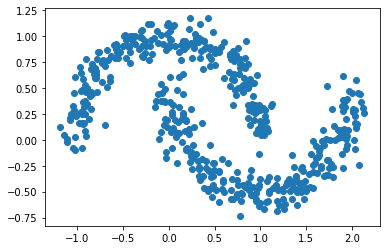

In [ ]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

In [ ]:
# your code here


Референс:

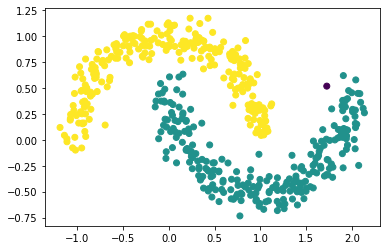

In [ ]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()


> Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):



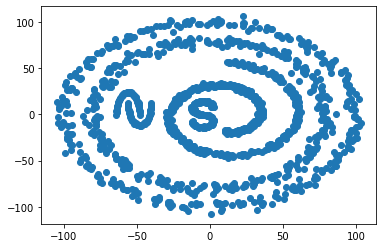

In [ ]:
# your code here


Или хотя бы что-нибудь такое: 

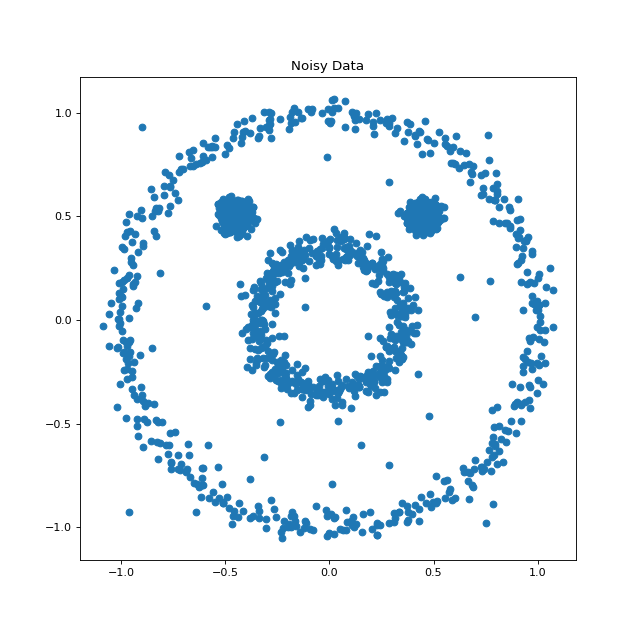

In [ ]:
# your code here



> Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:



In [ ]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

In [ ]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

## Применяем DBSCAN (3 балла)

__[1.5 балла]__ Возьмите колонки `Distance` и `DepTime` (из датасета о задержках самолётов). Запустите на тренировочной выборке на них DBSCAN. Нарисуйте облоко рассеивания с получившимися кластерами. Насколько много их вышло? 

In [ ]:
# your code here  ლ(ಠ益ಠლ)


Попробуйте перебрать параметры `eps` и `min_samples` по решётке и нарисовать для каждой пары облако рассеивания. При каких параметрах шумовых точек оказывается больше всего? Почему так происходит? 

__Ответ:__ 

In [ ]:
# your code here   ⟅⎛ꌩωꌩ⎞⟆


__[1.5 балла]__ Добавьте в датасет новую категориальную переменную: номер кластера из DBSCAN и обучите Catboost со своими лучшими гиперпараметрами. Улучшилось ли качество модели на тестовой выборке? Как думаете, почему? 

In [ ]:
# your code here  ¯\_(ツ)_/¯


__Ответ:__

# Небольшие подарочки

**+0.1 балла** за фотографию того, как вы проводите лето на открытом воздухе

**+0.1 балла** за смешной мем по машинному обучению

**+0.1 балла** за развернутый отзыв о курсе: ваших впечатлениях, сложностях и радостях, любимых темах и т.д.